This notebook requires **cpnest**; see https://github.com/johnveitch/cpnest. 

Can be installed via `pip install cpnest`.

In [1]:
import os

import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

from corner import corner

import sys
sys.path.append(os.path.abspath('code'))

import cpnest
import cpnest.model

# Introduction to Bayesian Analysis

### Christopher J. Moore - 3rd February 2020

In this session I will give an introduction to some Bayesian methods.
The focus will be on the statistical ideas, not the physics. Therefore we will work with a highly simplified toy problem and idealised mock data.

**Contents:**
 - **1. A New Class of Transient**: This section describes the toy problem, the mock data and the models we will be using.
 - **2. Analysing Individual Events**: This section applyies Bayesian analysis to the analysis of an individual transient light curve: detection, parameter estimation, and model selection are all discussed. 
 - **3. Hierarchical Bayesian Analysis**: Given several light curves we can start asking questions about the underlying population. This section analyses the population of several events in a mock catalog
 - **4. Conclusions**
 

# Section 1: A New Class of Transient

Supppose that we observe some new type of transient event. We want to analyse a small catalog containing the light curves from the first such events.

## Section 1.1: Data

The light curve data for the small catalog of transietns is stored in *data/catalog.dat*.

In [2]:
with open("data/catalog.dat") as f:
    for i in range(7): # print first few lines
        line = f.readline()[0:-1]
        
        # Read the error from the header 
        if 'sigma' in line: sigma = float(line.split()[-1])
        
        print(line)

# 
# # The 1 sigma error on all flux measurements is 0.1
# 
# # Time [s], Flux event 0, Flux event 1, Flux event 2, Flux event 3, Flux event 4, Flux event 5, Flux event 6, Flux event 7, Flux event 8, Flux event 9
-5.00000e+01 4.53263e-01 -2.19139e-02 9.17320e-02 8.97810e-02 1.65213e-01 4.74920e-02 2.01064e-01 4.00395e-01 4.07285e-02 2.25889e-01
-4.90000e+01 6.15541e-01 5.56270e-02 4.02778e-02 9.01864e-04 -3.65543e-02 1.17990e-01 6.08269e-02 1.78592e-01 -3.21475e-02 3.98286e-02
-4.80000e+01 5.73954e-01 3.32182e-02 -4.69585e-02 2.16169e-01 -5.08152e-02 1.02166e-01 2.01516e-01 2.43563e-01 1.84837e-02 1.98826e-01


**Column 0:** time stamps. (For simplicity, times are shifted such that peak occurs at $t=0$ and resampled at 1Hz.)

**Columns 1 to Nevents:** light curves for first few events. (Each flux measurement is assumed to have an identical, independent Gaussian error which is given in the file.)


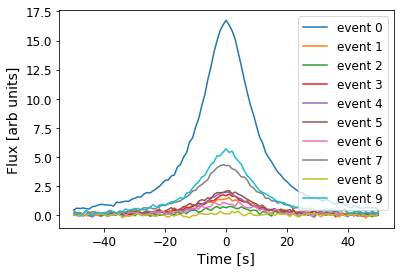

In [3]:
catalog_data = np.loadtxt("data/catalog.dat")

times = catalog_data[:,0]
Nevents = catalog_data.shape[1] - 1

for N in range(Nevents):
    plt.plot(times, catalog_data[:,N+1], label='event '+str(N))  
    
plt.xlabel("Time [s]")
plt.ylabel("Flux [arb units]")

plt.legend(loc='upper right')
plt.show()

### 1.1: Model(s)

The simplest possible situation is that there is no signal present in the data (null hypothesis).

**Model 0** is the null hypothesis,
$$ F_0(t) = 0 $$

Now suppose that there are two competing models for the light curve signals. 

**Model A** is a Gaussian, 
$$ F_A(t) = A\exp\left( \frac{-t^2}{\tau^2} \right) \,.$$

**Model B** has a similar shape but with broader tails,
$$ F_B(t) = \frac{A \tau^2}{\tau^2+t^2 } \,. $$

Both signal hypotheses have two parameters: an amplitude $A$, and a duration $\tau$; we collectively denote the model parameters
$\theta^{\mu} = (A, \tau)$.

These models are coded up in *Models.py*; let's import and inspect these functions.

In [4]:
from Models import ModelA_lightcurve as ModelA
from Models import ModelB_lightcurve as ModelB

print('def ModelA(times, params):\n    """', ModelA.__doc__[:-1], '"""')

def ModelA(times, params):
    """ 
    Model A for the light curve
    
    f(t) = 'amplitude' * exp( -x**2 )
    where x = t / 'duration'
    
    INPUTS
    ------
    times: numpy array shape=(Ntimes,)
        the time stamps for the observations [seconds]
        
    params: dict of model parameters
        keys 'amplitude' and 'duration'
        
    RETURNS
    -------
    light_curve: numpy array shape=(Ntimes,)
    """


# Section 2.0: Analysing Individual Events 

## Section 2.1: Bayes' Theorem

Bayes' theorem is the basis for everything we do in the this notebook;
$$ P(\theta^{\mu} | \mathrm{data}) = P(\mathrm{data} | \theta^{\mu}) \frac{P(\theta^{\mu}_{i})}{P(\mathrm{data})} \,. $$
This equation is to be understood as appling to a particular event; i.e. $\theta=\theta_i$ for $i\in\{1,\ldots, N_\rm{events}\}$ and $\mathrm{data}=\mathrm{data}_i$. 

Each term has a special name:

#### The Posterior: $P(\theta| \rm{data} )$

This is what we want to find (sometimes known as the target distribution). It is the probability of the model parameters given the data.

#### The Likelihood: $P(\rm{data} | \theta) \equiv \mathcal{L}(\theta)$

This is a input to the Bayesian analysis.

The probability of the data given a particular set of model parameters.

For our toy problem, because we have assumed simple noise (i.e. identical, independent Gaussian etc) the likelihood takes a simple form;
$$ \log\mathcal{L}(\theta) = \frac{-1}{2}\sum_{m=1}^{N_\mathrm{times}}\frac{\big[\mathrm{data}_m-\mathrm{model}(\theta)_m)\big]^2}{\sigma^{2}} -\frac{N_\mathrm{times}}{2}\log(2\pi\sigma^2) \,. $$

#### The Prior: $P(\theta)\equiv \Pi(\theta)$

This is a input to the Bayesian analysis.

The prior probability on the source parameters. There are no concrete rules for how to choose priors. 
However, a reasonable choice here would be a seperable prior on the two parameters; i.e. 
$$\Pi(\theta^{\mu})=\Pi(A)\Pi(\tau)\,.$$
For the amplitude the prior is uniform in log (Jeffreys 
prior) between lower/upper cutoffs $A_\mathrm{lower}=0.03$ and $A_\mathrm{upper}=30$;
$$\Pi(A)\propto\frac{1}{\log\left(A_\mathrm{upper}/A_\mathrm{lower}\right)}\begin{cases}1/A & \rm{if}\;A >A_\mathrm{lower}\;\rm{and}\;A <A_\mathrm{upper}\\0 &\rm{else}\end{cases}\,,$$
and for the duration the prior is uniform between lower/upper cutoffs $\tau_\mathrm{lower}=3$ and $\tau_\mathrm{upper}=30$;
$$\Pi(\tau)\propto \frac{1}{\tau_\mathrm{upper}-\tau_\mathrm{lower}}\begin{cases}1& \rm{if}\;\tau>1\;\rm{and}\;\tau<100\\0 &\rm{else}\end{cases}\,.$$

#### The Evidence: $P(\rm{data})\equiv Z$

This is the normalisation factor for the posterior,
$$ Z = \int\mathrm{d}\theta^{\mu} \; \mathcal{L}(\theta^{\mu})\Pi(\theta^{\mu}) \,. $$


---------

In the new notation, Bayes' theorem becomes
$$ P(\theta^{\mu} | \mathrm{data}) = \frac{\mathcal{L}(\theta^{\mu}) \Pi(\theta^{\mu})}{Z} \,. $$

## Section 2.2: CPNest Implementation

The **likelihood** and **prior** functions are the inputs to any Bayesian analysis. Here these functions are implemented inside the *model* class of the *CPNest* python package.

CPNest implements the nested sampling algorithm [J. Skilling (2006) doi:10.1214/06-BA127]. Nested sampling calculates $Z$ by Monte-Carlo integration of $\int\mathrm{d}\theta \; \mathcal{L}(\theta)\Pi(\theta)$. As by product, this algorithm produces a list parameter values $\{\theta_{1}, \theta_2, \ldots, \theta_{N_\rm{samples}}\}$ which are distributed according to the posterior.

In [5]:
class CPNestModel(cpnest.model.Model):
    
    def __init__(self, catalog_data, event_num=0, model='A', sigma=0.1):
        """
        INPUTS
        ------
        catalog_data: numpy array
            the time series data for all light curves
        event_num: int
            which event to analyse? e.g. 1, 2,... [default to 1]
        model: string
            which model to use? e.g. 'A' or 'B' or 'Null' [defult to 'A']
        sigma: float
            the 1-sigma uncertainty on the measurements
        """
        
        self.catalog = catalog_data
        
        self.event = event_num
        
        self.model = model
        
        self.sigma = sigma
        
        if model is 'Null': # null hypothesis
            self.names   = []
            self.bounds  = []
            
        else: # signal hypotheses
            self.names   = ['amplitude', 'duration']
            self.bounds  = [[0.03, 30], [3, 30]]
    
    def log_prior(self, params):
        """
        The log-prior distribution

        INPUTS
        ------
        params: dict of model parameters
            keys 'amplitude' and 'duration'
    
        RETURNS
        -------
            LogPrior: float
        """
        if self.model is 'Null':
            return 0
        elif not self.in_bounds(params): 
            return -np.inf
        else:
            LogPrior = -np.log(np.log(self.bounds[0][1]/self.bounds[0][0]))
            LogPrior -= np.log(self.bounds[1][1]-self.bounds[1][0])
            return LogPrior 
        
    def log_likelihood(self, params):
        """
        The log-likelihood distribution
    
        LogLike = sum_i ( -0.5*(data_i-model_i)**2/sigma**2 ) - norm_const
    
        INPUTS
        ------
        params: dict of model parameters
            keys 'amplitude' and 'duration'
    
        RETURNS
        -------
            LogLike: float
        """
        times = self.catalog[:,0]
        data_light_curve = self.catalog[:,self.event+1]
    
        if self.model=='Null':
            model_lightcurve = np.zeros(len(times))
        elif self.model=='A':
            model_lightcurve = ModelA(times, params)
        elif self.model=='B':
            model_lightcurve = ModelB(times, params)

        LogLike = -0.5 * np.sum( (data_light_curve-model_lightcurve)**2 / self.sigma**2 )
        LogLike -= 0.5*len(times)*np.log(2*np.pi*self.sigma**2)
    
        return LogLike
    

## Section 2.2: Analysing First Event With Model A

Now we have set up the CPNest class it is a simple matter to create an instance of this class for a particular event (say, event number 0) and run the analysis.

In [6]:
eventID = 0
modelA = CPNestModel(catalog_data, 
                     event_num=eventID, 
                     model='A',
                     sigma=sigma)

nest_modelA = cpnest.CPNest(modelA, 
                            nlive=1024, 
                            output='results/event'+str(eventID)+'_A', 
                            nthreads=4, 
                            verbose=1)

nest_modelA.run()
posterior_samplesA = nest_modelA.get_posterior_samples() 

Running with 4 parallel threads


SMPLR 0 init draw:   0%|          | 0/100 [00:00<?, ?it/s]






SMPLR 2 init draw:   0%|          | 0/100 [00:00<?, ?it/s]?, ?it/s]


SMPLR 0 init evolve:   0%|          | 0/100 [00:00<?, ?it/s]A
                                                          

                                                          



                                                          s]

SMPLR 2 init evolve:   0%|          | 0/100 [00:00<?, ?it/s]


                                                            
                                                            

                                                            


                                                            



CPNEST: populate samplers:   2%|▏         | 25/1024 [00:00<00:04, 248.09it/s]



CPNEST: populate samplers:  44%|████▍     | 449/1024 [00:00<00:01, 345.72it/s]



CPNEST: populate samplers:  83%|████████▎ | 853/1024 [00:00<00:00, 476.26it/s]



CPNEST: populate samplers: 100%|██████████| 1024/1024 [00:00<

50: n:  11 NS_acc:0.980 S3_acc:0.641 sub_acc:0.545 H: 6.98 logL -341843.45755 --> -177623.08098 dZ: 336812.358 logZ: -341850.439 logLmax: -5038.03
51: n:  12 NS_acc:0.981 S0_acc:0.675 sub_acc:0.500 H: 6.98 logL -350813.28828 --> -80901.59795 dZ: 336812.358 logZ: -341850.439 logLmax: -5038.03
52: n:  11 NS_acc:0.981 S1_acc:0.653 sub_acc:0.545 H: 6.98 logL -344968.22230 --> -30581.72443 dZ: 336812.358 logZ: -341850.439 logLmax: -5038.03
53: n:  13 NS_acc:0.981 S2_acc:0.652 sub_acc:0.692 H: 6.99 logL -330018.10601 --> -38687.56223 dZ: 323958.709 logZ: -328996.795 logLmax: -5038.03
54: n:  11 NS_acc:0.982 S3_acc:0.641 sub_acc:0.727 H: 6.99 logL -328989.80911 --> -35535.97365 dZ: 323958.709 logZ: -328996.795 logLmax: -5038.03
55: n:  12 NS_acc:0.982 S0_acc:0.674 sub_acc:0.333 H: 6.99 logL -336278.91716 --> -25399.31093 dZ: 323958.709 logZ: -328996.795 logLmax: -5038.03
56: n:  11 NS_acc:0.982 S1_acc:0.653 sub_acc:0.636 H: 6.99 logL -332523.35686 --> -177058.35799 dZ: 323958.709 logZ: -32899

106: n:  11 NS_acc:0.991 S0_acc:0.642 sub_acc:0.545 H: 7.04 logL -238096.54284 --> -75828.32710 dZ: 223609.112 logZ: -228647.248 logLmax: -5038.03
107: n:  12 NS_acc:0.991 S2_acc:0.672 sub_acc:0.500 H: 7.04 logL -231191.01551 --> -80701.64980 dZ: 223609.112 logZ: -228647.248 logLmax: -5038.03
108: n:  12 NS_acc:0.991 S1_acc:0.652 sub_acc:0.583 H: 7.04 logL -232709.14486 --> -102057.70357 dZ: 223609.112 logZ: -228647.248 logLmax: -5038.03
109: n:  12 NS_acc:0.991 S2_acc:0.654 sub_acc:0.750 H: 7.04 logL -224476.49277 --> -73992.76100 dZ: 216734.991 logZ: -221773.131 logLmax: -5038.03
110: n:  11 NS_acc:0.991 S0_acc:0.641 sub_acc:0.091 H: 7.04 logL -226919.33154 --> -19740.73088 dZ: 216734.991 logZ: -221773.131 logLmax: -5038.03
111: n:  12 NS_acc:0.991 S3_acc:0.671 sub_acc:0.333 H: 7.04 logL -221766.09053 --> -107120.62988 dZ: 216734.991 logZ: -221773.131 logLmax: -5038.03
112: n:  12 NS_acc:0.991 S1_acc:0.652 sub_acc:0.750 H: 7.04 logL -225527.85842 --> -94632.67243 dZ: 216734.991 logZ:

162: n:  14 NS_acc:0.994 S2_acc:0.639 sub_acc:0.571 H: 7.09 logL -185904.63623 --> -13419.44796 dZ: 179213.779 logZ: -184251.970 logLmax: -5038.03
163: n:  12 NS_acc:0.994 S1_acc:0.670 sub_acc:0.917 H: 7.09 logL -186165.40868 --> -5879.95083 dZ: 179213.779 logZ: -184251.970 logLmax: -5038.03
164: n:  11 NS_acc:0.994 S3_acc:0.652 sub_acc:0.364 H: 7.09 logL -184244.87846 --> -148368.21020 dZ: 179213.779 logZ: -184251.970 logLmax: -5038.03
165: n:  12 NS_acc:0.994 S2_acc:0.652 sub_acc:0.667 H: 7.10 logL -182640.23605 --> -58772.91366 dZ: 177074.727 logZ: -182112.922 logLmax: -5038.03
166: n:  14 NS_acc:0.994 S1_acc:0.638 sub_acc:0.500 H: 7.10 logL -183041.07060 --> -78151.85423 dZ: 177074.727 logZ: -182112.922 logLmax: -5038.03
167: n:  12 NS_acc:0.994 S3_acc:0.670 sub_acc:0.417 H: 7.10 logL -182105.82669 --> -167323.87050 dZ: 177074.727 logZ: -182112.922 logLmax: -5038.03
168: n:  11 NS_acc:0.994 S0_acc:0.652 sub_acc:0.545 H: 7.10 logL -183814.27767 --> -30122.71914 dZ: 177074.727 logZ: 

218: n:  18 NS_acc:0.995 S2_acc:0.634 sub_acc:0.556 H: 7.15 logL -167000.78981 --> -56454.56569 dZ: 161682.336 logZ: -166720.582 logLmax: -5038.03
219: n:  13 NS_acc:0.995 S1_acc:0.668 sub_acc:0.769 H: 7.15 logL -167323.87050 --> -23826.45921 dZ: 161682.336 logZ: -166720.582 logLmax: -5038.03
220: n:  14 NS_acc:0.995 S3_acc:0.652 sub_acc:0.571 H: 7.15 logL -166713.43581 --> -147313.40954 dZ: 161682.336 logZ: -166720.582 logLmax: -5038.03
221: n:  16 NS_acc:0.995 S2_acc:0.650 sub_acc:0.562 H: 7.15 logL -166098.56845 --> -52440.20649 dZ: 160523.460 logZ: -165561.709 logLmax: -5038.03
222: n:  17 NS_acc:0.996 S1_acc:0.634 sub_acc:0.706 H: 7.15 logL -166217.20203 --> -122090.61669 dZ: 160523.460 logZ: -165561.709 logLmax: -5038.03
223: n:  12 NS_acc:0.996 S0_acc:0.668 sub_acc:0.583 H: 7.15 logL -166446.21788 --> -47269.49050 dZ: 160523.460 logZ: -165561.709 logLmax: -5038.03
224: n:  14 NS_acc:0.996 S3_acc:0.652 sub_acc:0.786 H: 7.15 logL -165554.55974 --> -77269.86642 dZ: 160523.460 logZ:

274: n:  16 NS_acc:0.996 S3_acc:0.630 sub_acc:0.438 H: 7.20 logL -150356.77601 --> -14922.69146 dZ: 145325.676 logZ: -150363.977 logLmax: -5038.03
275: n:  12 NS_acc:0.996 S1_acc:0.665 sub_acc:0.500 H: 7.20 logL -150567.82637 --> -38425.73802 dZ: 145325.676 logZ: -150363.977 logLmax: -5038.03
276: n:  14 NS_acc:0.996 S0_acc:0.650 sub_acc:0.357 H: 7.20 logL -150645.38720 --> -109767.66854 dZ: 145325.676 logZ: -150363.977 logLmax: -5038.03
277: n:  14 NS_acc:0.996 S3_acc:0.648 sub_acc:0.714 H: 7.20 logL -148461.42900 --> -33720.97441 dZ: 143430.329 logZ: -148468.633 logLmax: -5038.03
278: n:  16 NS_acc:0.996 S2_acc:0.630 sub_acc:0.750 H: 7.20 logL -149100.45648 --> -75331.64584 dZ: 143430.329 logZ: -148468.633 logLmax: -5038.03
279: n:  12 NS_acc:0.996 S0_acc:0.665 sub_acc:0.583 H: 7.20 logL -149452.33782 --> -56422.03915 dZ: 143430.329 logZ: -148468.633 logLmax: -5038.03
280: n:  14 NS_acc:0.996 S1_acc:0.650 sub_acc:0.643 H: 7.20 logL -149250.42553 --> -31902.13264 dZ: 143430.329 logZ: 

330: n:  14 NS_acc:0.997 S2_acc:0.630 sub_acc:0.643 H: 7.26 logL -132135.24931 --> -11029.54092 dZ: 126065.640 logZ: -131103.995 logLmax: -5038.03
331: n:  13 NS_acc:0.997 S1_acc:0.663 sub_acc:0.385 H: 7.26 logL -132969.00654 --> -16318.23634 dZ: 126065.640 logZ: -131103.995 logLmax: -5038.03
332: n:  13 NS_acc:0.997 S3_acc:0.650 sub_acc:0.692 H: 7.26 logL -131096.73993 --> -22608.67713 dZ: 126065.640 logZ: -131103.995 logLmax: -5038.03
333: n:  13 NS_acc:0.997 S0_acc:0.646 sub_acc:0.615 H: 7.26 logL -130871.26422 --> -37784.48937 dZ: 125303.209 logZ: -130341.568 logLmax: -5038.03
334: n:  14 NS_acc:0.997 S1_acc:0.631 sub_acc:0.643 H: 7.26 logL -130860.41386 --> -45125.22813 dZ: 125303.209 logZ: -130341.568 logLmax: -5038.03
335: n:  14 NS_acc:0.997 S2_acc:0.663 sub_acc:0.714 H: 7.26 logL -130430.37990 --> -48426.36892 dZ: 125303.209 logZ: -130341.568 logLmax: -5038.03
336: n:  13 NS_acc:0.997 S3_acc:0.650 sub_acc:0.615 H: 7.26 logL -130334.30854 --> -128914.95892 dZ: 125303.209 logZ: 

386: n:  16 NS_acc:0.997 S0_acc:0.628 sub_acc:0.688 H: 7.31 logL -121409.95475 --> -110702.02002 dZ: 115784.400 logZ: -120822.810 logLmax: -5038.03
387: n:  12 NS_acc:0.997 S2_acc:0.662 sub_acc:0.583 H: 7.31 logL -121360.49479 --> -25649.92844 dZ: 115784.400 logZ: -120822.810 logLmax: -5038.03
388: n:  14 NS_acc:0.997 S3_acc:0.648 sub_acc:0.571 H: 7.31 logL -120815.49989 --> -58578.20004 dZ: 115784.400 logZ: -120822.810 logLmax: -5038.03
389: n:  16 NS_acc:0.997 S1_acc:0.644 sub_acc:0.562 H: 7.31 logL -120582.76016 --> -86485.02738 dZ: 115423.074 logZ: -120461.488 logLmax: -5038.03
390: n:  16 NS_acc:0.997 S2_acc:0.628 sub_acc:0.688 H: 7.31 logL -120513.53286 --> -101233.90905 dZ: 115423.074 logZ: -120461.488 logLmax: -5038.03
391: n:  12 NS_acc:0.997 S0_acc:0.661 sub_acc:0.583 H: 7.31 logL -120643.17806 --> -99827.94790 dZ: 115423.074 logZ: -120461.488 logLmax: -5038.03
392: n:  14 NS_acc:0.997 S3_acc:0.648 sub_acc:0.500 H: 7.31 logL -120454.17374 --> -115477.87432 dZ: 115423.074 logZ

442: n:  15 NS_acc:0.998 S0_acc:0.625 sub_acc:0.467 H: 7.36 logL -109240.03147 --> -100735.57491 dZ: 104020.639 logZ: -109059.104 logLmax: -5038.03
443: n:  12 NS_acc:0.998 S3_acc:0.660 sub_acc:0.583 H: 7.36 logL -109051.73909 --> -17701.12379 dZ: 104020.639 logZ: -109059.104 logLmax: -5038.03
444: n:  18 NS_acc:0.998 S1_acc:0.643 sub_acc:0.389 H: 7.36 logL -109237.77071 --> -100800.41900 dZ: 104020.639 logZ: -109059.104 logLmax: -5038.03
445: n:  15 NS_acc:0.998 S3_acc:0.642 sub_acc:0.667 H: 7.37 logL -108519.24701 --> -31921.72856 dZ: 103488.147 logZ: -108526.615 logLmax: -5038.03
446: n:  15 NS_acc:0.998 S2_acc:0.625 sub_acc:0.600 H: 7.37 logL -108544.77710 --> -25537.69601 dZ: 103488.147 logZ: -108526.615 logLmax: -5038.03
447: n:  12 NS_acc:0.998 S1_acc:0.660 sub_acc:0.917 H: 7.37 logL -108578.30308 --> -83635.42877 dZ: 103488.147 logZ: -108526.615 logLmax: -5038.03
448: n:  18 NS_acc:0.998 S0_acc:0.643 sub_acc:0.667 H: 7.37 logL -108610.18765 --> -74478.41111 dZ: 103488.147 logZ:

498: n:  13 NS_acc:0.998 S1_acc:0.625 sub_acc:0.769 H: 7.42 logL -100877.91723 --> -9492.11144 dZ: 95769.319 logZ: -100807.838 logLmax: -5038.03
499: n:  13 NS_acc:0.998 S3_acc:0.658 sub_acc:0.538 H: 7.42 logL -100800.41900 --> -25966.87030 dZ: 95769.319 logZ: -100807.838 logLmax: -5038.03
500: n:  16 NS_acc:0.998 S0_acc:0.641 sub_acc:0.812 H: 7.42 logL -101001.14660 --> -14860.03767 dZ: 95769.319 logZ: -100807.838 logLmax: -5038.03
501: n:  14 NS_acc:0.998 S0_acc:0.640 sub_acc:0.643 H: 7.42 logL -100735.57491 --> -14334.36558 dZ: 95604.210 logZ: -100642.733 logLmax: -5038.03
502: n:  13 NS_acc:0.998 S1_acc:0.625 sub_acc:0.769 H: 7.42 logL -100714.74061 --> -35054.06242 dZ: 95604.210 logZ: -100642.733 logLmax: -5038.03
503: n:  13 NS_acc:0.998 S3_acc:0.657 sub_acc:0.154 H: 7.42 logL -100635.30975 --> -27474.39010 dZ: 95604.210 logZ: -100642.733 logLmax: -5038.03
504: n:  16 NS_acc:0.998 S2_acc:0.641 sub_acc:0.562 H: 7.42 logL -100667.42432 --> -58295.52516 dZ: 95604.210 logZ: -100642.7

555: n:  15 NS_acc:0.998 S3_acc:0.653 sub_acc:0.533 H: 7.47 logL -93058.34851 --> -7827.32425 dZ: 88027.249 logZ: -93065.822 logLmax: -5038.03
556: n:  15 NS_acc:0.998 S2_acc:0.637 sub_acc:0.533 H: 7.47 logL -93085.60031 --> -8602.96785 dZ: 88027.249 logZ: -93065.822 logLmax: -5038.03
557: n:  22 NS_acc:0.998 S1_acc:0.635 sub_acc:0.682 H: 7.48 logL -92791.09951 --> -23439.57750 dZ: 87471.951 logZ: -92510.529 logLmax: -5038.03
558: n:  13 NS_acc:0.998 S0_acc:0.623 sub_acc:0.462 H: 7.48 logL -92847.77502 --> -63080.81554 dZ: 87471.951 logZ: -92510.529 logLmax: -5038.03
559: n:  15 NS_acc:0.998 S2_acc:0.653 sub_acc:0.667 H: 7.48 logL -92716.93251 --> -41838.41068 dZ: 87471.951 logZ: -92510.529 logLmax: -5038.03
560: n:  15 NS_acc:0.998 S3_acc:0.637 sub_acc:0.600 H: 7.48 logL -92503.05103 --> -37547.48796 dZ: 87471.951 logZ: -92510.529 logLmax: -5038.03
561: n:  21 NS_acc:0.998 S3_acc:0.635 sub_acc:0.667 H: 7.48 logL -91829.47761 --> -31425.88003 dZ: 86798.378 logZ: -91836.959 logLmax: -50

612: n:  17 NS_acc:0.998 S2_acc:0.634 sub_acc:0.706 H: 7.53 logL -85872.14644 --> -26277.98381 dZ: 80346.699 logZ: -85385.327 logLmax: -5038.03
613: n:  17 NS_acc:0.998 S1_acc:0.631 sub_acc:0.353 H: 7.53 logL -85249.95967 --> -15730.87993 dZ: 79977.989 logZ: -85016.621 logLmax: -5038.03
614: n:  15 NS_acc:0.998 S2_acc:0.621 sub_acc:0.667 H: 7.53 logL -85093.84346 --> -18386.93362 dZ: 79977.989 logZ: -85016.621 logLmax: -5038.03
615: n:  13 NS_acc:0.998 S3_acc:0.652 sub_acc:0.846 H: 7.53 logL -85009.08881 --> -7023.82447 dZ: 79977.989 logZ: -85016.621 logLmax: -5038.03
616: n:  16 NS_acc:0.998 S0_acc:0.633 sub_acc:0.375 H: 7.53 logL -85257.52485 --> -48842.13601 dZ: 79977.989 logZ: -85016.621 logLmax: -5038.03
617: n:  17 NS_acc:0.998 S2_acc:0.631 sub_acc:0.706 H: 7.54 logL -84935.15870 --> -63483.02875 dZ: 79582.293 logZ: -84620.929 logLmax: -5038.03
618: n:  14 NS_acc:0.998 S1_acc:0.621 sub_acc:0.643 H: 7.54 logL -84944.20896 --> -23393.64097 dZ: 79582.293 logZ: -84620.929 logLmax: -5

669: n:  15 NS_acc:0.999 S1_acc:0.630 sub_acc:0.533 H: 7.59 logL -80007.43953 --> -47433.58243 dZ: 74867.279 logZ: -79905.966 logLmax: -5038.03
670: n:  16 NS_acc:0.999 S0_acc:0.617 sub_acc:0.375 H: 7.59 logL -80247.55284 --> -11787.40151 dZ: 74867.279 logZ: -79905.966 logLmax: -5038.03
671: n:  12 NS_acc:0.999 S3_acc:0.651 sub_acc:0.500 H: 7.59 logL -79898.37828 --> -37623.02659 dZ: 74867.279 logZ: -79905.966 logLmax: -5038.03
672: n:  17 NS_acc:0.999 S2_acc:0.629 sub_acc:0.471 H: 7.59 logL -79980.90361 --> -75119.68254 dZ: 74867.279 logZ: -79905.966 logLmax: -5038.03
673: n:  15 NS_acc:0.999 S1_acc:0.630 sub_acc:0.600 H: 7.59 logL -79552.47463 --> -18145.78758 dZ: 74369.582 logZ: -79408.273 logLmax: -5038.03
674: n:  16 NS_acc:0.999 S2_acc:0.616 sub_acc:0.500 H: 7.59 logL -79504.87541 --> -52098.25360 dZ: 74369.582 logZ: -79408.273 logLmax: -5038.03
675: n:  13 NS_acc:0.999 S3_acc:0.651 sub_acc:0.538 H: 7.59 logL -79400.68196 --> -67161.16597 dZ: 74369.582 logZ: -79408.273 logLmax: -

726: n:  15 NS_acc:0.999 S0_acc:0.615 sub_acc:0.467 H: 7.64 logL -74712.68426 --> -52545.94799 dZ: 69517.031 logZ: -74555.772 logLmax: -5038.03
727: n:  18 NS_acc:0.999 S3_acc:0.646 sub_acc:0.611 H: 7.64 logL -74548.13032 --> -59183.97429 dZ: 69517.031 logZ: -74555.772 logLmax: -5038.03
728: n:  14 NS_acc:0.999 S2_acc:0.629 sub_acc:0.643 H: 7.64 logL -74583.76278 --> -33841.50299 dZ: 69517.031 logZ: -74555.772 logLmax: -5038.03
729: n:  15 NS_acc:0.999 S3_acc:0.627 sub_acc:0.733 H: 7.65 logL -74115.55138 --> -15456.09391 dZ: 69084.452 logZ: -74123.197 logLmax: -5038.03
730: n:  15 NS_acc:0.999 S2_acc:0.615 sub_acc:0.600 H: 7.65 logL -74164.73744 --> -58227.08162 dZ: 69084.452 logZ: -74123.197 logLmax: -5038.03
731: n:  18 NS_acc:0.999 S0_acc:0.646 sub_acc:0.667 H: 7.65 logL -74478.41111 --> -66687.52204 dZ: 69084.452 logZ: -74123.197 logLmax: -5038.03
732: n:  14 NS_acc:0.999 S1_acc:0.629 sub_acc:0.429 H: 7.65 logL -74443.28916 --> -33806.33207 dZ: 69084.452 logZ: -74123.197 logLmax: -

783: n:  14 NS_acc:0.999 S2_acc:0.646 sub_acc:0.643 H: 7.70 logL -69741.25358 --> -28777.02090 dZ: 64722.640 logZ: -69684.866 logLmax: -4961.46
784: n:  14 NS_acc:0.999 S0_acc:0.626 sub_acc:0.357 H: 7.70 logL -70142.93719 --> -57711.75104 dZ: 64722.640 logZ: -69684.866 logLmax: -4961.46
785: n:  21 NS_acc:0.999 S0_acc:0.623 sub_acc:0.714 H: 7.70 logL -69665.45777 --> -57890.56404 dZ: 64521.761 logZ: -69483.991 logLmax: -4961.46
786: n:  15 NS_acc:0.999 S1_acc:0.613 sub_acc:0.400 H: 7.70 logL -69650.71139 --> -38248.97605 dZ: 64521.761 logZ: -69483.991 logLmax: -4961.46
787: n:  14 NS_acc:0.999 S3_acc:0.645 sub_acc:0.357 H: 7.70 logL -69476.29020 --> -33090.39223 dZ: 64521.761 logZ: -69483.991 logLmax: -4961.46
788: n:  15 NS_acc:0.999 S2_acc:0.626 sub_acc:0.600 H: 7.70 logL -69562.87584 --> -25697.36326 dZ: 64521.761 logZ: -69483.991 logLmax: -4961.46
789: n:  20 NS_acc:0.999 S2_acc:0.624 sub_acc:0.750 H: 7.70 logL -69297.87429 --> -53419.91724 dZ: 64183.127 logZ: -69145.361 logLmax: -

840: n:  15 NS_acc:0.999 S0_acc:0.624 sub_acc:0.533 H: 7.75 logL -64182.63169 --> -36548.30665 dZ: 59029.542 logZ: -63991.822 logLmax: -4961.46
841: n:  17 NS_acc:0.999 S3_acc:0.622 sub_acc:0.588 H: 7.76 logL -63782.65781 --> -45691.76013 dZ: 58828.129 logZ: -63790.413 logLmax: -4961.46
842: n:  17 NS_acc:0.999 S1_acc:0.609 sub_acc:0.353 H: 7.76 logL -63868.15370 --> -8398.97884 dZ: 58828.129 logZ: -63790.413 logLmax: -4961.46
843: n:  15 NS_acc:0.999 S2_acc:0.642 sub_acc:0.600 H: 7.76 logL -63826.69624 --> -45862.46287 dZ: 58828.129 logZ: -63790.413 logLmax: -4961.46
844: n:  15 NS_acc:0.999 S0_acc:0.624 sub_acc:0.667 H: 7.76 logL -63979.87146 --> -52129.24921 dZ: 58828.129 logZ: -63790.413 logLmax: -4961.46
845: n:  17 NS_acc:0.999 S3_acc:0.622 sub_acc:0.706 H: 7.76 logL -63483.02875 --> -6307.52757 dZ: 58528.500 logZ: -63490.788 logLmax: -4961.46
846: n:  17 NS_acc:0.999 S2_acc:0.608 sub_acc:0.235 H: 7.76 logL -63524.94412 --> -37096.69211 dZ: 58528.500 logZ: -63490.788 logLmax: -49

897: n:  24 NS_acc:0.999 S1_acc:0.619 sub_acc:0.458 H: 7.81 logL -59582.23166 --> -32427.18180 dZ: 54428.225 logZ: -59390.565 logLmax: -4961.46
898: n:  17 NS_acc:0.999 S0_acc:0.606 sub_acc:0.706 H: 7.81 logL -59702.09888 --> -39574.66001 dZ: 54428.225 logZ: -59390.565 logLmax: -4961.46
899: n:  14 NS_acc:0.999 S3_acc:0.639 sub_acc:0.500 H: 7.81 logL -59382.75465 --> -45418.55690 dZ: 54428.225 logZ: -59390.565 logLmax: -4961.46
900: n:  16 NS_acc:0.999 S2_acc:0.620 sub_acc:0.625 H: 7.81 logL -59485.09879 --> -41018.39394 dZ: 54428.225 logZ: -59390.565 logLmax: -4961.46
901: n:  24 NS_acc:0.999 S0_acc:0.618 sub_acc:0.417 H: 7.72 logL -59349.69598 --> -26717.67071 dZ: 54361.220 logZ: -59323.563 logLmax: -4961.46
902: n:  16 NS_acc:0.999 S2_acc:0.606 sub_acc:0.438 H: 7.72 logL -59319.76144 --> -21955.65007 dZ: 54361.220 logZ: -59323.563 logLmax: -4961.46
903: n:  14 NS_acc:0.999 S1_acc:0.639 sub_acc:0.500 H: 7.72 logL -59327.83271 --> -17966.68014 dZ: 54361.220 logZ: -59323.563 logLmax: -

954: n:  15 NS_acc:0.999 S0_acc:0.604 sub_acc:0.533 H: 7.65 logL -56644.89658 --> -39756.96224 dZ: 51575.144 logZ: -56537.538 logLmax: -4961.46
955: n:  16 NS_acc:0.999 S1_acc:0.635 sub_acc:0.312 H: 7.65 logL -56640.42512 --> -33412.44024 dZ: 51575.144 logZ: -56537.538 logLmax: -4961.46
956: n:  14 NS_acc:0.999 S3_acc:0.619 sub_acc:0.643 H: 7.65 logL -56529.73211 --> -41676.43179 dZ: 51575.144 logZ: -56537.538 logLmax: -4961.46
957: n:  18 NS_acc:0.999 S0_acc:0.617 sub_acc:0.667 H: 7.87 logL -56454.56569 --> -23684.77578 dZ: 51387.034 logZ: -56349.432 logLmax: -4961.46
958: n:  15 NS_acc:0.999 S2_acc:0.605 sub_acc:0.733 H: 7.87 logL -56418.79026 --> -7519.77583 dZ: 51387.034 logZ: -56349.432 logLmax: -4961.46
959: n:  16 NS_acc:0.999 S3_acc:0.635 sub_acc:0.812 H: 7.87 logL -56341.56325 --> -30626.92848 dZ: 51387.034 logZ: -56349.432 logLmax: -4961.46
960: n:  14 NS_acc:0.999 S1_acc:0.620 sub_acc:0.857 H: 7.87 logL -56422.03915 --> -16228.37051 dZ: 51387.034 logZ: -56349.432 logLmax: -4

1011: n:  15 NS_acc:0.999 S3_acc:0.633 sub_acc:0.533 H: 7.92 logL -53197.09164 --> -7016.28813 dZ: 48242.562 logZ: -53205.011 logLmax: -4961.46
1012: n:  13 NS_acc:0.999 S1_acc:0.618 sub_acc:0.308 H: 7.92 logL -53358.94079 --> -15836.41105 dZ: 48242.562 logZ: -53205.011 logLmax: -4961.46
1013: n:  16 NS_acc:0.999 S2_acc:0.615 sub_acc:0.625 H: 7.92 logL -52870.12835 --> -5361.94212 dZ: 47801.808 logZ: -52764.260 logLmax: -4961.46
1014: n:  15 NS_acc:0.999 S0_acc:0.602 sub_acc:0.467 H: 7.92 logL -53184.02711 --> -18512.16671 dZ: 47801.808 logZ: -52764.260 logLmax: -4961.46
1015: n:  15 NS_acc:0.999 S1_acc:0.632 sub_acc:0.533 H: 7.92 logL -53147.91120 --> -36770.25889 dZ: 47801.808 logZ: -52764.260 logLmax: -4961.46
1016: n:  14 NS_acc:0.999 S3_acc:0.618 sub_acc:0.500 H: 7.92 logL -52756.33714 --> -15042.77886 dZ: 47801.808 logZ: -52764.260 logLmax: -4961.46
1017: n:  16 NS_acc:0.999 S1_acc:0.615 sub_acc:0.562 H: 7.93 logL -52724.42303 --> -19824.51181 dZ: 47649.606 logZ: -52612.062 logLm

1068: n:  15 NS_acc:0.999 S2_acc:0.616 sub_acc:0.600 H: 7.94 logL -49943.38295 --> -30007.28389 dZ: 44983.655 logZ: -49946.158 logLmax: -4961.46
1069: n:  16 NS_acc:0.999 S3_acc:0.612 sub_acc:0.312 H: 7.98 logL -49892.79261 --> -44712.58254 dZ: 44938.263 logZ: -49900.770 logLmax: -4961.46
1070: n:  15 NS_acc:0.999 S0_acc:0.601 sub_acc:0.667 H: 7.98 logL -49909.81758 --> -10591.53198 dZ: 44938.263 logZ: -49900.770 logLmax: -4961.46
1071: n:  14 NS_acc:0.999 S1_acc:0.630 sub_acc:0.429 H: 7.98 logL -49909.53744 --> -36231.87330 dZ: 44938.263 logZ: -49900.770 logLmax: -4961.46
1072: n:  15 NS_acc:0.999 S2_acc:0.615 sub_acc:0.333 H: 7.98 logL -49901.55132 --> -5646.61949 dZ: 44938.263 logZ: -49900.770 logLmax: -4961.46
1073: n:  16 NS_acc:0.999 S1_acc:0.612 sub_acc:0.688 H: 7.98 logL -49877.06552 --> -46939.12383 dZ: 44862.423 logZ: -49824.934 logLmax: -4961.46
1074: n:  15 NS_acc:0.999 S0_acc:0.600 sub_acc:0.400 H: 7.98 logL -49884.46720 --> -38890.05553 dZ: 44862.423 logZ: -49824.934 logL

1125: n:  18 NS_acc:0.999 S0_acc:0.608 sub_acc:0.444 H: 8.03 logL -47466.22511 --> -46126.04199 dZ: 42364.379 logZ: -47326.941 logLmax: -4961.46
1126: n:  15 NS_acc:0.999 S2_acc:0.598 sub_acc:0.600 H: 8.03 logL -47431.78128 --> -7769.43411 dZ: 42364.379 logZ: -47326.941 logLmax: -4961.46
1127: n:  16 NS_acc:0.999 S1_acc:0.628 sub_acc:0.688 H: 8.03 logL -47433.58243 --> -10445.47394 dZ: 42364.379 logZ: -47326.941 logLmax: -4961.46
1128: n:  18 NS_acc:0.999 S3_acc:0.612 sub_acc:0.611 H: 8.03 logL -47318.90871 --> -38493.39332 dZ: 42364.379 logZ: -47326.941 logLmax: -4961.46
1129: n:  18 NS_acc:0.999 S2_acc:0.608 sub_acc:0.611 H: 8.04 logL -47289.83538 --> -12512.39059 dZ: 42314.961 logZ: -47277.527 logLmax: -4961.46
1130: n:  15 NS_acc:0.999 S3_acc:0.599 sub_acc:0.733 H: 8.04 logL -47269.49050 --> -36236.20527 dZ: 42314.961 logZ: -47277.527 logLmax: -4961.46
1131: n:  16 NS_acc:0.999 S0_acc:0.627 sub_acc:0.312 H: 8.04 logL -47292.94715 --> -9952.36391 dZ: 42314.961 logZ: -47277.527 logLm

1182: n:  14 NS_acc:0.999 S3_acc:0.598 sub_acc:0.071 H: 8.09 logL -45250.72172 --> -43241.95598 dZ: 40296.192 logZ: -45258.809 logLmax: -4961.46
1183: n:  16 NS_acc:0.999 S0_acc:0.625 sub_acc:0.812 H: 8.09 logL -45379.91864 --> -28794.95844 dZ: 40296.192 logZ: -45258.809 logLmax: -4961.46
1184: n:  14 NS_acc:0.999 S1_acc:0.612 sub_acc:0.357 H: 8.09 logL -45353.93468 --> -44789.50620 dZ: 40296.192 logZ: -45258.809 logLmax: -4961.46
1185: n:  15 NS_acc:0.999 S2_acc:0.608 sub_acc:0.333 H: 8.09 logL -45108.67308 --> -31456.04184 dZ: 40083.002 logZ: -45045.623 logLmax: -4961.46
1186: n:  19 NS_acc:0.999 S0_acc:0.598 sub_acc:0.684 H: 8.09 logL -45125.22813 --> -8873.35094 dZ: 40083.002 logZ: -45045.623 logLmax: -4961.46
1187: n:  15 NS_acc:0.999 S1_acc:0.625 sub_acc:0.533 H: 8.09 logL -45113.24498 --> -14551.42976 dZ: 40083.002 logZ: -45045.623 logLmax: -4961.46
1188: n:  15 NS_acc:0.999 S3_acc:0.611 sub_acc:0.133 H: 8.09 logL -45037.53148 --> -33159.70529 dZ: 40083.002 logZ: -45045.623 logL

1239: n:  14 NS_acc:0.999 S2_acc:0.623 sub_acc:0.500 H: 8.14 logL -42816.24766 --> -27654.57030 dZ: 37846.705 logZ: -42809.376 logLmax: -4961.46
1240: n:  15 NS_acc:0.999 S0_acc:0.610 sub_acc:0.400 H: 8.14 logL -42932.54127 --> -12656.31536 dZ: 37846.705 logZ: -42809.376 logLmax: -4961.46
1241: n:  15 NS_acc:0.999 S2_acc:0.606 sub_acc:0.600 H: 8.15 logL -42473.17346 --> -13254.51576 dZ: 37479.988 logZ: -42442.663 logLmax: -4961.46
1242: n:  17 NS_acc:0.999 S0_acc:0.596 sub_acc:0.588 H: 8.15 logL -42715.31930 --> -6094.83453 dZ: 37479.988 logZ: -42442.663 logLmax: -4961.46
1243: n:  14 NS_acc:0.999 S1_acc:0.623 sub_acc:0.643 H: 8.15 logL -42661.24340 --> -9743.47639 dZ: 37479.988 logZ: -42442.663 logLmax: -4961.46
1244: n:  15 NS_acc:0.999 S3_acc:0.610 sub_acc:0.400 H: 8.15 logL -42434.51764 --> -14256.62211 dZ: 37479.988 logZ: -42442.663 logLmax: -4961.46
1245: n:  15 NS_acc:0.999 S0_acc:0.605 sub_acc:0.200 H: 8.15 logL -42296.40374 --> -32039.32231 dZ: 37208.625 logZ: -42171.304 logLm

1296: n:  15 NS_acc:0.999 S2_acc:0.608 sub_acc:0.667 H: 8.20 logL -40094.55907 --> -36577.08918 dZ: 35038.321 logZ: -40001.047 logLmax: -4961.46
1297: n:  15 NS_acc:0.999 S3_acc:0.605 sub_acc:0.467 H: 8.20 logL -39886.38533 --> -21840.15549 dZ: 34931.856 logZ: -39894.586 logLmax: -4961.46
1298: n:  14 NS_acc:0.999 S1_acc:0.597 sub_acc:0.714 H: 8.20 logL -39976.05290 --> -12469.32784 dZ: 34931.856 logZ: -39894.586 logLmax: -4961.46
1299: n:  19 NS_acc:0.999 S0_acc:0.620 sub_acc:0.526 H: 8.20 logL -39983.42102 --> -35360.91893 dZ: 34931.856 logZ: -39894.586 logLmax: -4961.46
1300: n:  15 NS_acc:0.999 S2_acc:0.607 sub_acc:0.400 H: 8.20 logL -39957.04484 --> -36132.91776 dZ: 34931.856 logZ: -39894.586 logLmax: -4961.46
1301: n:  15 NS_acc:0.999 S3_acc:0.604 sub_acc:0.200 H: 8.09 logL -39742.09551 --> -21275.50314 dZ: 34787.542 logZ: -39750.275 logLmax: -4961.46
1302: n:  14 NS_acc:0.999 S1_acc:0.597 sub_acc:0.571 H: 8.09 logL -39756.96224 --> -25357.12870 dZ: 34787.542 logZ: -39750.275 log

1353: n:  17 NS_acc:0.999 S3_acc:0.602 sub_acc:0.588 H: 8.26 logL -38320.54361 --> -26740.58908 dZ: 33366.014 logZ: -38328.799 logLmax: -4961.46
1354: n:  20 NS_acc:0.999 S1_acc:0.595 sub_acc:0.700 H: 8.26 logL -38425.73802 --> -21216.10500 dZ: 33366.014 logZ: -38328.799 logLmax: -4961.46
1355: n:  17 NS_acc:0.999 S2_acc:0.617 sub_acc:0.471 H: 8.26 logL -38399.73070 --> -25820.39571 dZ: 33366.014 logZ: -38328.799 logLmax: -4961.46
1356: n:  19 NS_acc:0.999 S0_acc:0.605 sub_acc:0.421 H: 8.26 logL -38442.16825 --> -32634.74587 dZ: 33366.014 logZ: -38328.799 logLmax: -4961.46
1357: n:  16 NS_acc:0.999 S0_acc:0.601 sub_acc:0.438 H: 8.26 logL -38253.20266 --> -24211.64516 dZ: 33102.720 logZ: -38065.509 logLmax: -4961.46
1358: n:  19 NS_acc:0.999 S1_acc:0.594 sub_acc:0.421 H: 8.26 logL -38248.97605 --> -5416.06462 dZ: 33102.720 logZ: -38065.509 logLmax: -4961.46
1359: n:  17 NS_acc:0.999 S2_acc:0.616 sub_acc:0.235 H: 8.26 logL -38168.28874 --> -11138.70088 dZ: 33102.720 logZ: -38065.509 logL

1410: n:  19 NS_acc:0.999 S0_acc:0.591 sub_acc:0.421 H: 8.31 logL -36577.08918 --> -24971.98081 dZ: 31545.166 logZ: -36508.005 logLmax: -4961.46
1411: n:  17 NS_acc:0.999 S2_acc:0.614 sub_acc:0.471 H: 8.31 logL -36548.30665 --> -34420.55181 dZ: 31545.166 logZ: -36508.005 logLmax: -4961.46
1412: n:  27 NS_acc:0.999 S3_acc:0.601 sub_acc:0.519 H: 8.31 logL -36499.69474 --> -9922.96692 dZ: 31545.166 logZ: -36508.005 logLmax: -4961.46
1413: n:  14 NS_acc:0.999 S1_acc:0.601 sub_acc:0.429 H: 8.31 logL -36376.87804 --> -17467.80952 dZ: 31303.932 logZ: -36266.775 logLmax: -4961.46
1414: n:  19 NS_acc:0.999 S0_acc:0.591 sub_acc:0.263 H: 8.31 logL -36405.97551 --> -33843.57720 dZ: 31303.932 logZ: -36266.775 logLmax: -4961.46
1415: n:  17 NS_acc:0.999 S2_acc:0.614 sub_acc:0.471 H: 8.31 logL -36286.78094 --> -25189.86057 dZ: 31303.932 logZ: -36266.775 logLmax: -4961.46
1416: n:  26 NS_acc:0.999 S3_acc:0.601 sub_acc:0.615 H: 8.31 logL -36258.46155 --> -19129.94680 dZ: 31303.932 logZ: -36266.775 logL

1467: n:  15 NS_acc:0.999 S1_acc:0.613 sub_acc:0.600 H: 8.25 logL -35095.72280 --> -12457.54986 dZ: 30099.508 logZ: -35062.402 logLmax: -4961.46
1468: n:  20 NS_acc:0.999 S2_acc:0.599 sub_acc:0.500 H: 8.25 logL -35057.73942 --> -33505.97605 dZ: 30099.508 logZ: -35062.402 logLmax: -4961.46
1469: n:  15 NS_acc:0.999 S3_acc:0.600 sub_acc:0.600 H: 8.31 logL -34931.56908 --> -30537.28360 dZ: 29977.030 logZ: -34939.928 logLmax: -4961.46
1470: n:  18 NS_acc:0.999 S1_acc:0.589 sub_acc:0.667 H: 8.31 logL -34938.00646 --> -5225.94461 dZ: 29977.030 logZ: -34939.928 logLmax: -4961.46
1471: n:  15 NS_acc:0.999 S0_acc:0.614 sub_acc:0.667 H: 8.31 logL -34987.50643 --> -31301.60511 dZ: 29977.030 logZ: -34939.928 logLmax: -4961.46
1472: n:  20 NS_acc:0.999 S2_acc:0.599 sub_acc:0.500 H: 8.31 logL -34936.37204 --> -34171.16899 dZ: 29977.030 logZ: -34939.928 logLmax: -4961.46
1473: n:  15 NS_acc:0.999 S3_acc:0.600 sub_acc:0.333 H: 8.37 logL -34799.69109 --> -28011.15477 dZ: 29845.162 logZ: -34808.063 logL

1524: n:  16 NS_acc:0.999 S2_acc:0.599 sub_acc:0.625 H: 8.41 logL -33647.79278 --> -29875.40906 dZ: 28685.819 logZ: -33648.767 logLmax: -4961.46
1525: n:  24 NS_acc:0.999 S2_acc:0.598 sub_acc:0.042 H: 8.42 logL -33513.42127 --> -28207.48877 dZ: 28551.446 logZ: -33514.399 logLmax: -4961.46
1526: n:  18 NS_acc:0.999 S3_acc:0.587 sub_acc:0.389 H: 8.42 logL -33505.97605 --> -13306.42292 dZ: 28551.446 logZ: -33514.399 logLmax: -4961.46
1527: n:  15 NS_acc:0.999 S1_acc:0.611 sub_acc:0.600 H: 8.42 logL -33584.42368 --> -10923.04650 dZ: 28551.446 logZ: -33514.399 logLmax: -4961.46
1528: n:  16 NS_acc:0.999 S0_acc:0.599 sub_acc:0.625 H: 8.42 logL -33590.61048 --> -11812.22658 dZ: 28551.446 logZ: -33514.399 logLmax: -4961.46
1529: n:  25 NS_acc:0.999 S3_acc:0.598 sub_acc:0.440 H: 8.43 logL -33342.68407 --> -24039.58454 dZ: 28388.155 logZ: -33351.111 logLmax: -4961.46
1530: n:  18 NS_acc:0.999 S1_acc:0.587 sub_acc:0.667 H: 8.43 logL -33442.52999 --> -18563.05771 dZ: 28388.155 logZ: -33351.111 log

1581: n:  20 NS_acc:0.999 S0_acc:0.596 sub_acc:0.500 H: 8.48 logL -32216.56293 --> -25146.35082 dZ: 27134.473 logZ: -32097.480 logLmax: -4961.46
1582: n:  15 NS_acc:0.999 S3_acc:0.587 sub_acc:0.467 H: 8.48 logL -32089.00240 --> -26063.88168 dZ: 27134.473 logZ: -32097.480 logLmax: -4961.46
1583: n:  14 NS_acc:0.999 S2_acc:0.611 sub_acc:0.571 H: 8.48 logL -32168.00185 --> -11393.87511 dZ: 27134.473 logZ: -32097.480 logLmax: -4961.46
1584: n:  16 NS_acc:0.999 S1_acc:0.597 sub_acc:0.125 H: 8.48 logL -32215.56104 --> -10476.97774 dZ: 27134.473 logZ: -32097.480 logLmax: -4961.46
1585: n:  20 NS_acc:0.999 S3_acc:0.596 sub_acc:0.800 H: 8.48 logL -31999.04388 --> -25939.99888 dZ: 27044.515 logZ: -32007.526 logLmax: -4961.46
1586: n:  15 NS_acc:0.999 S0_acc:0.587 sub_acc:0.467 H: 8.48 logL -32081.66669 --> -11936.75624 dZ: 27044.515 logZ: -32007.526 logLmax: -4961.46
1587: n:  14 NS_acc:0.999 S2_acc:0.610 sub_acc:0.500 H: 8.48 logL -32026.54516 --> -22496.61264 dZ: 27044.515 logZ: -32007.526 log

1638: n:  15 NS_acc:0.999 S1_acc:0.586 sub_acc:0.733 H: 8.53 logL -30770.46349 --> -8644.72188 dZ: 25770.552 logZ: -30733.613 logLmax: -4961.46
1639: n:  14 NS_acc:0.999 S2_acc:0.609 sub_acc:0.643 H: 8.53 logL -30732.07973 --> -22958.84158 dZ: 25770.552 logZ: -30733.613 logLmax: -4961.46
1640: n:  16 NS_acc:0.999 S3_acc:0.596 sub_acc:0.438 H: 8.53 logL -30725.08175 --> -29883.80783 dZ: 25770.552 logZ: -30733.613 logLmax: -4961.46
1641: n:  16 NS_acc:0.999 S3_acc:0.597 sub_acc:0.688 H: 8.54 logL -30626.92848 --> -10391.29969 dZ: 25672.399 logZ: -30635.465 logLmax: -4961.46
1642: n:  14 NS_acc:0.999 S1_acc:0.586 sub_acc:0.357 H: 8.54 logL -30678.29410 --> -14925.51255 dZ: 25672.399 logZ: -30635.465 logLmax: -4961.46
1643: n:  13 NS_acc:0.999 S0_acc:0.609 sub_acc:0.308 H: 8.54 logL -30703.75754 --> -18386.49024 dZ: 25672.399 logZ: -30635.465 logLmax: -4961.46
1644: n:  16 NS_acc:0.999 S2_acc:0.596 sub_acc:0.562 H: 8.54 logL -30658.56791 --> -30135.56417 dZ: 25672.399 logZ: -30635.465 logL

1695: n:  15 NS_acc:0.999 S0_acc:0.607 sub_acc:0.067 H: 8.06 logL -29299.96229 --> -28354.66871 dZ: 24334.502 logZ: -29297.618 logLmax: -4961.46
1696: n:  21 NS_acc:0.999 S2_acc:0.593 sub_acc:0.571 H: 8.06 logL -29290.56767 --> -25271.79417 dZ: 24334.502 logZ: -29297.618 logLmax: -4961.46
1697: n:  17 NS_acc:0.999 S0_acc:0.595 sub_acc:0.706 H: 7.90 logL -29281.27674 --> -20348.01003 dZ: 24286.232 logZ: -29249.352 logLmax: -4961.46
1698: n:  13 NS_acc:0.999 S3_acc:0.586 sub_acc:0.308 H: 7.90 logL -29241.35684 --> -28757.98165 dZ: 24286.232 logZ: -29249.352 logLmax: -4961.46
1699: n:  22 NS_acc:0.999 S1_acc:0.607 sub_acc:0.409 H: 7.90 logL -29253.03178 --> -16014.05213 dZ: 24286.232 logZ: -29249.352 logLmax: -4961.46
1700: n:  20 NS_acc:0.999 S2_acc:0.593 sub_acc:0.450 H: 7.90 logL -29241.56340 --> -9147.86148 dZ: 24286.232 logZ: -29249.352 logLmax: -4961.46
1701: n:  17 NS_acc:0.999 S2_acc:0.595 sub_acc:0.412 H: 8.55 logL -29207.89997 --> -17614.32440 dZ: 24248.561 logZ: -29211.686 logL

1752: n:  18 NS_acc:0.999 S3_acc:0.592 sub_acc:0.556 H: 8.48 logL -28212.11759 --> -14886.81023 dZ: 23257.549 logZ: -28220.720 logLmax: -4961.46
1753: n:  15 NS_acc:0.999 S1_acc:0.594 sub_acc:0.333 H: 8.64 logL -28195.16075 --> -17612.41710 dZ: 23227.444 logZ: -28190.619 logLmax: -4961.46
1754: n:  13 NS_acc:0.999 S0_acc:0.586 sub_acc:0.846 H: 8.64 logL -28207.48877 --> -7749.45381 dZ: 23227.444 logZ: -28190.619 logLmax: -4961.46
1755: n:  16 NS_acc:0.999 S2_acc:0.607 sub_acc:0.750 H: 8.64 logL -28191.04232 --> -26316.74093 dZ: 23227.444 logZ: -28190.619 logLmax: -4961.46
1756: n:  18 NS_acc:0.999 S3_acc:0.592 sub_acc:0.722 H: 8.64 logL -28181.97303 --> -26213.60884 dZ: 23227.444 logZ: -28190.619 logLmax: -4961.46
1757: n:  16 NS_acc:0.999 S3_acc:0.593 sub_acc:0.125 H: 8.57 logL -28054.05771 --> -25056.11654 dZ: 23099.513 logZ: -28062.692 logLmax: -4961.46
1758: n:  13 NS_acc:0.999 S0_acc:0.586 sub_acc:0.538 H: 8.57 logL -28131.40069 --> -15948.61281 dZ: 23099.513 logZ: -28062.692 logL

1809: n:  16 NS_acc:0.999 S3_acc:0.593 sub_acc:0.625 H: 8.70 logL -26843.79067 --> -26397.99502 dZ: 21889.261 logZ: -26852.491 logLmax: -4961.46
1810: n:  13 NS_acc:0.999 S1_acc:0.586 sub_acc:0.615 H: 8.70 logL -26887.08553 --> -7385.83213 dZ: 21889.261 logZ: -26852.491 logLmax: -4961.46
1811: n:  15 NS_acc:0.999 S0_acc:0.606 sub_acc:0.467 H: 8.70 logL -26959.52748 --> -24577.86726 dZ: 21889.261 logZ: -26852.491 logLmax: -4961.46
1812: n:  16 NS_acc:0.999 S2_acc:0.590 sub_acc:0.438 H: 8.70 logL -26882.23191 --> -12297.97928 dZ: 21889.261 logZ: -26852.491 logLmax: -4961.46
1813: n:  16 NS_acc:0.999 S1_acc:0.593 sub_acc:0.750 H: 8.70 logL -26814.54554 --> -12290.44178 dZ: 21786.060 logZ: -26749.294 logLmax: -4961.46
1814: n:  13 NS_acc:0.999 S2_acc:0.586 sub_acc:0.462 H: 8.70 logL -26774.13488 --> -20420.55350 dZ: 21786.060 logZ: -26749.294 logLmax: -4961.46
1815: n:  15 NS_acc:0.999 S3_acc:0.606 sub_acc:0.333 H: 8.70 logL -26740.58908 --> -15703.60760 dZ: 21786.060 logZ: -26749.294 logL

1866: n:  13 NS_acc:0.999 S1_acc:0.586 sub_acc:0.846 H: 8.75 logL -25962.45524 --> -8695.60859 dZ: 20985.468 logZ: -25948.753 logLmax: -4961.46
1867: n:  14 NS_acc:0.999 S2_acc:0.606 sub_acc:0.643 H: 8.75 logL -25946.62553 --> -19665.35672 dZ: 20985.468 logZ: -25948.753 logLmax: -4961.46
1868: n:  18 NS_acc:0.999 S3_acc:0.588 sub_acc:0.556 H: 8.75 logL -25939.99888 --> -15171.34589 dZ: 20985.468 logZ: -25948.753 logLmax: -4961.46
1869: n:  13 NS_acc:0.999 S2_acc:0.593 sub_acc:0.385 H: 8.59 logL -25854.26634 --> -13894.96486 dZ: 20896.554 logZ: -25859.842 logLmax: -4961.46
1870: n:  13 NS_acc:0.999 S3_acc:0.586 sub_acc:0.462 H: 8.59 logL -25851.12539 --> -22963.49688 dZ: 20896.554 logZ: -25859.842 logLmax: -4961.46
1871: n:  13 NS_acc:0.999 S0_acc:0.606 sub_acc:0.692 H: 8.59 logL -25902.52882 --> -19566.19242 dZ: 20896.554 logZ: -25859.842 logLmax: -4961.46
1872: n:  18 NS_acc:0.999 S1_acc:0.589 sub_acc:0.833 H: 8.59 logL -25864.47482 --> -11272.10124 dZ: 20896.554 logZ: -25859.842 logL

1923: n:  12 NS_acc:0.999 S1_acc:0.606 sub_acc:0.583 H: 8.81 logL -24836.96329 --> -7577.09348 dZ: 19842.106 logZ: -24805.445 logLmax: -4961.46
1924: n:  15 NS_acc:0.999 S3_acc:0.588 sub_acc:0.467 H: 8.81 logL -24796.63555 --> -5129.15810 dZ: 19842.106 logZ: -24805.445 logLmax: -4961.46
1925: n:  13 NS_acc:0.999 S3_acc:0.593 sub_acc:0.615 H: 8.79 logL -24691.24638 --> -13258.61256 dZ: 19736.713 logZ: -24700.056 logLmax: -4961.46
1926: n:  13 NS_acc:0.999 S1_acc:0.585 sub_acc:0.692 H: 8.79 logL -24735.32517 --> -21846.82998 dZ: 19736.713 logZ: -24700.056 logLmax: -4961.46
1927: n:  12 NS_acc:0.999 S0_acc:0.606 sub_acc:0.833 H: 8.79 logL -24759.15664 --> -7663.55593 dZ: 19736.713 logZ: -24700.056 logLmax: -4961.46
1928: n:  15 NS_acc:0.999 S2_acc:0.588 sub_acc:0.600 H: 8.79 logL -24696.76061 --> -10348.51323 dZ: 19736.713 logZ: -24700.056 logLmax: -4961.46
1929: n:  12 NS_acc:0.999 S0_acc:0.594 sub_acc:0.667 H: 8.81 logL -24687.99548 --> -20200.73777 dZ: 19616.397 logZ: -24579.743 logLma

1980: n:  15 NS_acc:0.999 S0_acc:0.587 sub_acc:0.533 H: 8.86 logL -23618.66057 --> -13726.40714 dZ: 18605.910 logZ: -23569.303 logLmax: -4961.46
1981: n:  13 NS_acc:0.999 S0_acc:0.593 sub_acc:0.692 H: 8.87 logL -23553.42317 --> -21109.95412 dZ: 18523.185 logZ: -23486.582 logLmax: -4961.46
1982: n:  12 NS_acc:0.999 S2_acc:0.586 sub_acc:0.583 H: 8.87 logL -23486.64403 --> -17734.00048 dZ: 18523.185 logZ: -23486.582 logLmax: -4961.46
1983: n:  14 NS_acc:0.999 S3_acc:0.604 sub_acc:0.571 H: 8.87 logL -23477.71401 --> -15253.29380 dZ: 18523.185 logZ: -23486.582 logLmax: -4961.46
1984: n:  15 NS_acc:0.999 S1_acc:0.587 sub_acc:0.533 H: 8.87 logL -23526.20615 --> -9411.20118 dZ: 18523.185 logZ: -23486.582 logLmax: -4961.46
1985: n:  12 NS_acc:0.999 S0_acc:0.593 sub_acc:0.333 H: 8.25 logL -23476.59241 --> -17361.45140 dZ: 18489.451 logZ: -23452.853 logLmax: -4961.46
1986: n:  12 NS_acc:0.999 S2_acc:0.586 sub_acc:0.833 H: 8.25 logL -23445.15012 --> -17286.64218 dZ: 18489.451 logZ: -23452.853 logL

2037: n:  16 NS_acc:1.000 S1_acc:0.592 sub_acc:0.562 H: 8.92 logL -22533.32326 --> -20514.13109 dZ: 17544.556 logZ: -22507.426 logLmax: -4960.88
2038: n:  13 NS_acc:1.000 S2_acc:0.586 sub_acc:0.846 H: 8.92 logL -22521.43565 --> -5699.61565 dZ: 17544.556 logZ: -22507.426 logLmax: -4960.88
2039: n:  14 NS_acc:1.000 S0_acc:0.604 sub_acc:0.500 H: 8.92 logL -22552.66080 --> -10642.58882 dZ: 17544.556 logZ: -22507.426 logLmax: -4960.88
2040: n:  14 NS_acc:1.000 S3_acc:0.587 sub_acc:0.714 H: 8.92 logL -22498.50266 --> -6634.94223 dZ: 17544.556 logZ: -22507.426 logLmax: -4960.88
2041: n:  16 NS_acc:1.000 S0_acc:0.592 sub_acc:0.625 H: 8.91 logL -22497.08028 --> -7735.59864 dZ: 17476.328 logZ: -22439.202 logLmax: -4960.88
2042: n:  13 NS_acc:1.000 S1_acc:0.586 sub_acc:0.462 H: 8.91 logL -22496.61264 --> -11204.96381 dZ: 17476.328 logZ: -22439.202 logLmax: -4960.88
2043: n:  14 NS_acc:1.000 S2_acc:0.604 sub_acc:0.429 H: 8.91 logL -22436.60231 --> -19587.02882 dZ: 17476.328 logZ: -22439.202 logLma

2094: n:  14 NS_acc:1.000 S0_acc:0.585 sub_acc:0.571 H: 8.77 logL -21601.73362 --> -14225.10608 dZ: 16629.453 logZ: -21592.378 logLmax: -4960.88
2095: n:  15 NS_acc:1.000 S3_acc:0.602 sub_acc:0.667 H: 8.77 logL -21583.45455 --> -19717.85171 dZ: 16629.453 logZ: -21592.378 logLmax: -4960.88
2096: n:  14 NS_acc:1.000 S2_acc:0.586 sub_acc:0.571 H: 8.77 logL -21586.33982 --> -11445.53327 dZ: 16629.453 logZ: -21592.378 logLmax: -4960.88
2097: n:  17 NS_acc:1.000 S0_acc:0.590 sub_acc:0.706 H: 8.98 logL -21581.32721 --> -21367.58571 dZ: 16586.610 logZ: -21549.538 logLmax: -4960.88
2098: n:  14 NS_acc:1.000 S2_acc:0.585 sub_acc:0.429 H: 8.98 logL -21570.93736 --> -11042.28921 dZ: 16586.610 logZ: -21549.538 logLmax: -4960.88
2099: n:  14 NS_acc:1.000 S3_acc:0.602 sub_acc:0.643 H: 8.98 logL -21540.55659 --> -8211.54950 dZ: 16586.610 logZ: -21549.538 logLmax: -4960.88
2100: n:  14 NS_acc:1.000 S1_acc:0.586 sub_acc:0.357 H: 8.98 logL -21579.66657 --> -9070.78427 dZ: 16586.610 logZ: -21549.538 logLm

2151: n:  15 NS_acc:1.000 S0_acc:0.601 sub_acc:0.667 H: 9.03 logL -20773.75459 --> -10452.87243 dZ: 15770.726 logZ: -20733.706 logLmax: -4960.88
2152: n:  14 NS_acc:1.000 S2_acc:0.586 sub_acc:0.714 H: 9.03 logL -20734.84962 --> -15915.19002 dZ: 15770.726 logZ: -20733.706 logLmax: -4960.88
2153: n:  16 NS_acc:1.000 S2_acc:0.589 sub_acc:0.875 H: 9.04 logL -20695.96642 --> -9710.38023 dZ: 15730.182 logZ: -20693.166 logLmax: -4960.88
2154: n:  15 NS_acc:1.000 S1_acc:0.584 sub_acc:0.400 H: 9.04 logL -20699.52615 --> -20618.39976 dZ: 15730.182 logZ: -20693.166 logLmax: -4960.88
2155: n:  15 NS_acc:1.000 S0_acc:0.601 sub_acc:0.400 H: 9.04 logL -20707.46214 --> -17526.72073 dZ: 15730.182 logZ: -20693.166 logLmax: -4960.88
2156: n:  14 NS_acc:1.000 S3_acc:0.586 sub_acc:0.500 H: 9.04 logL -20684.12920 --> -19931.21612 dZ: 15730.182 logZ: -20693.166 logLmax: -4960.88
2157: n:  16 NS_acc:1.000 S2_acc:0.589 sub_acc:0.500 H: 8.81 logL -20666.78613 --> -16851.80436 dZ: 15710.062 logZ: -20673.050 logL

2208: n:  14 NS_acc:1.000 S2_acc:0.586 sub_acc:0.643 H: 8.66 logL -20017.88998 --> -12845.49621 dZ: 15061.988 logZ: -20025.022 logLmax: -4960.88
2209: n:  16 NS_acc:1.000 S1_acc:0.587 sub_acc:0.500 H: 9.05 logL -20002.86667 --> -7290.18188 dZ: 15040.630 logZ: -20003.668 logLmax: -4960.88
2210: n:  14 NS_acc:1.000 S3_acc:0.583 sub_acc:0.357 H: 9.05 logL -19994.58369 --> -17687.92488 dZ: 15040.630 logZ: -20003.668 logLmax: -4960.88
2211: n:  14 NS_acc:1.000 S0_acc:0.601 sub_acc:0.643 H: 9.05 logL -20010.81403 --> -13985.88974 dZ: 15040.630 logZ: -20003.668 logLmax: -4960.88
2212: n:  14 NS_acc:1.000 S2_acc:0.586 sub_acc:0.643 H: 9.05 logL -19999.62490 --> -6132.21976 dZ: 15040.630 logZ: -20003.668 logLmax: -4960.88
2213: n:  16 NS_acc:1.000 S3_acc:0.588 sub_acc:0.812 H: 9.09 logL -19962.60030 --> -12994.94895 dZ: 15008.653 logZ: -19971.695 logLmax: -4960.88
2214: n:  15 NS_acc:1.000 S1_acc:0.583 sub_acc:0.400 H: 9.09 logL -19982.90723 --> -5441.63431 dZ: 15008.653 logZ: -19971.695 logLma

2265: n:  13 NS_acc:1.000 S0_acc:0.588 sub_acc:0.538 H: 9.15 logL -19376.86164 --> -7753.53450 dZ: 14381.629 logZ: -19344.721 logLmax: -4960.88
2266: n:  15 NS_acc:1.000 S2_acc:0.583 sub_acc:0.467 H: 9.15 logL -19359.80676 --> -16424.07803 dZ: 14381.629 logZ: -19344.721 logLmax: -4960.88
2267: n:  13 NS_acc:1.000 S1_acc:0.600 sub_acc:0.308 H: 9.15 logL -19375.11432 --> -16088.32570 dZ: 14381.629 logZ: -19344.721 logLmax: -4960.88
2268: n:  13 NS_acc:1.000 S3_acc:0.586 sub_acc:0.692 H: 9.15 logL -19335.57548 --> -17586.02529 dZ: 14381.629 logZ: -19344.721 logLmax: -4960.88
2269: n:  13 NS_acc:1.000 S2_acc:0.589 sub_acc:0.769 H: 8.81 logL -19259.09536 --> -14675.96571 dZ: 14302.923 logZ: -19266.020 logLmax: -4960.88
2270: n:  15 NS_acc:1.000 S0_acc:0.583 sub_acc:0.667 H: 8.81 logL -19275.41073 --> -5639.14973 dZ: 14302.923 logZ: -19266.020 logLmax: -4960.88
2271: n:  14 NS_acc:1.000 S3_acc:0.600 sub_acc:0.429 H: 8.81 logL -19256.98484 --> -12356.62603 dZ: 14302.923 logZ: -19266.020 logLm

2322: n:  13 NS_acc:1.000 S2_acc:0.583 sub_acc:0.615 H: 9.02 logL -18570.28447 --> -17934.42049 dZ: 13613.248 logZ: -18576.395 logLmax: -4960.88
2323: n:  13 NS_acc:1.000 S1_acc:0.600 sub_acc:0.385 H: 9.02 logL -18577.97674 --> -13533.50771 dZ: 13613.248 logZ: -18576.395 logLmax: -4960.88
2324: n:  14 NS_acc:1.000 S0_acc:0.585 sub_acc:0.214 H: 9.02 logL -18583.86149 --> -18253.81478 dZ: 13613.248 logZ: -18576.395 logLmax: -4960.88
2325: n:  13 NS_acc:1.000 S2_acc:0.588 sub_acc:0.462 H: 9.20 logL -18545.70235 --> -15461.70408 dZ: 13579.258 logZ: -18542.409 logLmax: -4960.88
2326: n:  13 NS_acc:1.000 S3_acc:0.583 sub_acc:0.308 H: 9.20 logL -18533.20450 --> -14283.28962 dZ: 13579.258 logZ: -18542.409 logLmax: -4960.88
2327: n:  13 NS_acc:1.000 S0_acc:0.600 sub_acc:0.615 H: 9.20 logL -18563.05771 --> -13249.14244 dZ: 13579.258 logZ: -18542.409 logLmax: -4960.88
2328: n:  15 NS_acc:1.000 S1_acc:0.585 sub_acc:0.533 H: 9.20 logL -18551.89776 --> -16693.44404 dZ: 13579.258 logZ: -18542.409 log

2379: n:  14 NS_acc:1.000 S3_acc:0.599 sub_acc:0.429 H: 9.24 logL -17791.91307 --> -15440.99594 dZ: 12837.965 logZ: -17801.167 logLmax: -4960.88
2380: n:  14 NS_acc:1.000 S2_acc:0.584 sub_acc:0.500 H: 9.24 logL -17798.38176 --> -10015.02808 dZ: 12837.965 logZ: -17801.167 logLmax: -4960.88
2381: n:  12 NS_acc:1.000 S2_acc:0.589 sub_acc:0.417 H: 9.26 logL -17752.53636 --> -7365.66326 dZ: 12787.609 logZ: -17750.815 logLmax: -4960.88
2382: n:  14 NS_acc:1.000 S1_acc:0.582 sub_acc:0.714 H: 9.26 logL -17778.02063 --> -13583.57749 dZ: 12787.609 logZ: -17750.815 logLmax: -4960.88
2383: n:  14 NS_acc:1.000 S0_acc:0.599 sub_acc:0.643 H: 9.26 logL -17778.97443 --> -5447.26830 dZ: 12787.609 logZ: -17750.815 logLmax: -4960.88
2384: n:  14 NS_acc:1.000 S3_acc:0.585 sub_acc:0.714 H: 9.26 logL -17741.55599 --> -7714.93899 dZ: 12787.609 logZ: -17750.815 logLmax: -4960.88
2385: n:  12 NS_acc:1.000 S3_acc:0.589 sub_acc:0.583 H: 9.24 logL -17701.12379 --> -8977.94588 dZ: 12747.174 logZ: -17710.384 logLmax

2436: n:  13 NS_acc:1.000 S1_acc:0.584 sub_acc:0.538 H: 9.31 logL -17138.47855 --> -16296.71756 dZ: 12110.086 logZ: -17073.343 logLmax: -4960.88
2437: n:  13 NS_acc:1.000 S2_acc:0.589 sub_acc:0.692 H: 9.31 logL -17010.01990 --> -13271.26967 dZ: 12045.101 logZ: -17008.361 logLmax: -4960.88
2438: n:  14 NS_acc:1.000 S3_acc:0.582 sub_acc:0.714 H: 9.31 logL -16999.04769 --> -12447.98564 dZ: 12045.101 logZ: -17008.361 logLmax: -4960.88
2439: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.538 H: 9.31 logL -17027.93705 --> -7659.96855 dZ: 12045.101 logZ: -17008.361 logLmax: -4960.88
2440: n:  13 NS_acc:1.000 S0_acc:0.584 sub_acc:0.692 H: 9.31 logL -17037.69776 --> -6924.79498 dZ: 12045.101 logZ: -17008.361 logLmax: -4960.88
2441: n:  13 NS_acc:1.000 S2_acc:0.589 sub_acc:0.385 H: 8.83 logL -16990.68465 --> -16542.46615 dZ: 12034.735 logZ: -16998.000 logLmax: -4960.88
2442: n:  13 NS_acc:1.000 S1_acc:0.582 sub_acc:0.538 H: 8.83 logL -16992.68936 --> -12215.72704 dZ: 12034.735 logZ: -16998.000 logLm

2493: n:  14 NS_acc:1.000 S1_acc:0.588 sub_acc:0.429 H: 8.75 logL -16565.82855 --> -8913.81286 dZ: 11601.573 logZ: -16564.888 logLmax: -4960.88
2494: n:  13 NS_acc:1.000 S3_acc:0.582 sub_acc:0.385 H: 8.75 logL -16555.88459 --> -9474.00317 dZ: 11601.573 logZ: -16564.888 logLmax: -4960.88
2495: n:  14 NS_acc:1.000 S2_acc:0.598 sub_acc:0.143 H: 8.75 logL -16556.70536 --> -15116.65403 dZ: 11601.573 logZ: -16564.888 logLmax: -4960.88
2496: n:  12 NS_acc:1.000 S0_acc:0.585 sub_acc:0.500 H: 8.75 logL -16580.34056 --> -13821.16815 dZ: 11601.573 logZ: -16564.888 logLmax: -4960.88
2497: n:  14 NS_acc:1.000 S3_acc:0.588 sub_acc:0.500 H: 8.87 logL -16485.38796 --> -14281.85774 dZ: 11531.220 logZ: -16494.539 logLmax: -4960.88
2498: n:  13 NS_acc:1.000 S1_acc:0.582 sub_acc:0.462 H: 8.87 logL -16516.03489 --> -7360.59380 dZ: 11531.220 logZ: -16494.539 logLmax: -4960.88
2499: n:  17 NS_acc:1.000 S2_acc:0.598 sub_acc:0.529 H: 8.87 logL -16486.78587 --> -6615.47200 dZ: 11531.220 logZ: -16494.539 logLmax

2550: n:  16 NS_acc:1.000 S0_acc:0.580 sub_acc:0.188 H: 9.42 logL -15947.99898 --> -14466.85934 dZ: 10961.642 logZ: -15925.012 logLmax: -4960.88
2551: n:  15 NS_acc:1.000 S1_acc:0.598 sub_acc:0.733 H: 9.42 logL -15942.55797 --> -15446.66614 dZ: 10961.642 logZ: -15925.012 logLmax: -4960.88
2552: n:  14 NS_acc:1.000 S2_acc:0.584 sub_acc:0.643 H: 9.42 logL -15940.49804 --> -12310.01569 dZ: 10961.642 logZ: -15925.012 logLmax: -4960.88
2553: n:  13 NS_acc:1.000 S1_acc:0.588 sub_acc:0.462 H: 9.40 logL -15908.54244 --> -9884.64207 dZ: 10946.852 logZ: -15910.226 logLmax: -4960.88
2554: n:  17 NS_acc:1.000 S0_acc:0.580 sub_acc:0.353 H: 9.40 logL -15915.19002 --> -9977.29623 dZ: 10946.852 logZ: -15910.226 logLmax: -4960.88
2555: n:  14 NS_acc:1.000 S2_acc:0.597 sub_acc:0.357 H: 9.40 logL -15906.56339 --> -10452.86442 dZ: 10946.852 logZ: -15910.226 logLmax: -4960.88
2556: n:  14 NS_acc:1.000 S3_acc:0.584 sub_acc:0.429 H: 9.40 logL -15900.80204 --> -12014.84035 dZ: 10946.852 logZ: -15910.226 logLm

2607: n:  14 NS_acc:1.000 S3_acc:0.597 sub_acc:0.643 H: 9.48 logL -15348.69972 --> -7455.82043 dZ: 10394.753 logZ: -15358.178 logLmax: -4960.88
2608: n:  14 NS_acc:1.000 S1_acc:0.584 sub_acc:0.357 H: 9.48 logL -15366.20184 --> -10070.06714 dZ: 10394.753 logZ: -15358.178 logLmax: -4960.88
2609: n:  18 NS_acc:1.000 S0_acc:0.586 sub_acc:0.389 H: 9.48 logL -15341.14538 --> -11520.97772 dZ: 10369.767 logZ: -15333.196 logLmax: -4960.88
2610: n:  15 NS_acc:1.000 S2_acc:0.580 sub_acc:0.400 H: 9.48 logL -15339.29134 --> -7287.12694 dZ: 10369.767 logZ: -15333.196 logLmax: -4960.88
2611: n:  14 NS_acc:1.000 S3_acc:0.598 sub_acc:0.786 H: 9.48 logL -15323.71414 --> -10575.30459 dZ: 10369.767 logZ: -15333.196 logLmax: -4960.88
2612: n:  15 NS_acc:1.000 S1_acc:0.584 sub_acc:0.667 H: 9.48 logL -15339.61720 --> -12135.99618 dZ: 10369.767 logZ: -15333.196 logLmax: -4960.88
2613: n:  18 NS_acc:1.000 S3_acc:0.586 sub_acc:0.500 H: 9.28 logL -15288.29685 --> -8780.62123 dZ: 10334.298 logZ: -15297.730 logLma

2664: n:  15 NS_acc:1.000 S0_acc:0.583 sub_acc:0.533 H: 9.53 logL -14961.06933 --> -13017.48710 dZ: 9992.891 logZ: -14956.371 logLmax: -4960.88
2665: n:  16 NS_acc:1.000 S1_acc:0.586 sub_acc:0.625 H: 8.78 logL -14925.51255 --> -14235.13554 dZ: 9967.739 logZ: -14931.222 logLmax: -4960.88
2666: n:  17 NS_acc:1.000 S2_acc:0.579 sub_acc:0.471 H: 8.78 logL -14922.69146 --> -12960.14686 dZ: 9967.739 logZ: -14931.222 logLmax: -4960.88
2667: n:  12 NS_acc:1.000 S3_acc:0.598 sub_acc:0.417 H: 8.78 logL -14922.17676 --> -9131.57015 dZ: 9967.739 logZ: -14931.222 logLmax: -4960.88
2668: n:  14 NS_acc:1.000 S0_acc:0.583 sub_acc:0.500 H: 8.78 logL -14934.70156 --> -6715.95823 dZ: 9967.739 logZ: -14931.222 logLmax: -4960.88
2669: n:  16 NS_acc:1.000 S0_acc:0.585 sub_acc:0.562 H: 9.26 logL -14919.36580 --> -14168.86657 dZ: 9932.781 logZ: -14896.268 logLmax: -4960.88
2670: n:  17 NS_acc:1.000 S1_acc:0.579 sub_acc:0.647 H: 9.26 logL -14897.92449 --> -14639.75921 dZ: 9932.781 logZ: -14896.268 logLmax: -49

2722: n:  15 NS_acc:1.000 S1_acc:0.579 sub_acc:0.533 H: 9.31 logL -14391.59233 --> -12867.32104 dZ: 9433.421 logZ: -14396.959 logLmax: -4960.88
2723: n:  15 NS_acc:1.000 S3_acc:0.596 sub_acc:0.667 H: 9.31 logL -14387.43782 --> -13261.02040 dZ: 9433.421 logZ: -14396.959 logLmax: -4960.88
2724: n:  14 NS_acc:1.000 S2_acc:0.584 sub_acc:0.714 H: 9.31 logL -14390.31484 --> -12161.19741 dZ: 9433.421 logZ: -14396.959 logLmax: -4960.88
2725: n:  14 NS_acc:1.000 S3_acc:0.586 sub_acc:0.643 H: 9.40 logL -14361.81486 --> -13081.03215 dZ: 9407.819 logZ: -14371.360 logLmax: -4960.88
2726: n:  15 NS_acc:1.000 S1_acc:0.579 sub_acc:0.267 H: 9.40 logL -14372.09496 --> -12742.95300 dZ: 9407.819 logZ: -14371.360 logLmax: -4960.88
2727: n:  15 NS_acc:1.000 S0_acc:0.596 sub_acc:0.467 H: 9.40 logL -14376.17092 --> -10797.09051 dZ: 9407.819 logZ: -14371.360 logLmax: -4960.88
2728: n:  14 NS_acc:1.000 S2_acc:0.584 sub_acc:0.857 H: 9.40 logL -14364.79885 --> -6739.20335 dZ: 9407.819 logZ: -14371.360 logLmax: -4

2780: n:  14 NS_acc:1.000 S3_acc:0.584 sub_acc:0.714 H: 9.65 logL -13821.16815 --> -12329.80223 dZ: 8867.221 logZ: -13830.814 logLmax: -4960.88
2781: n:  15 NS_acc:1.000 S2_acc:0.585 sub_acc:0.533 H: 9.65 logL -13736.64430 --> -8445.92562 dZ: 8773.330 logZ: -13736.927 logLmax: -4960.88
2782: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.571 H: 9.65 logL -13811.42779 --> -7158.11837 dZ: 8773.330 logZ: -13736.927 logLmax: -4960.88
2783: n:  13 NS_acc:1.000 S3_acc:0.597 sub_acc:0.846 H: 9.65 logL -13727.27735 --> -8800.11193 dZ: 8773.330 logZ: -13736.927 logLmax: -4960.88
2784: n:  14 NS_acc:1.000 S1_acc:0.583 sub_acc:0.214 H: 9.65 logL -13803.98930 --> -8468.52880 dZ: 8773.330 logZ: -13736.927 logLmax: -4960.88
2785: n:  15 NS_acc:1.000 S2_acc:0.585 sub_acc:0.600 H: 8.92 logL -13716.75234 --> -10267.05273 dZ: 8761.761 logZ: -13725.362 logLmax: -4960.88
2786: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.643 H: 8.92 logL -13716.17106 --> -6255.87161 dZ: 8761.761 logZ: -13725.362 logLmax: -4960.

2838: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.667 H: 9.70 logL -13380.89462 --> -7637.02072 dZ: 8416.270 logZ: -13379.921 logLmax: -4960.88
2839: n:  13 NS_acc:1.000 S1_acc:0.597 sub_acc:0.769 H: 9.70 logL -13379.80558 --> -5831.56513 dZ: 8416.270 logZ: -13379.921 logLmax: -4960.88
2840: n:  16 NS_acc:1.000 S3_acc:0.582 sub_acc:0.500 H: 9.70 logL -13370.21669 --> -6691.45777 dZ: 8416.270 logZ: -13379.921 logLmax: -4960.88
2841: n:  14 NS_acc:1.000 S3_acc:0.585 sub_acc:0.571 H: 9.71 logL -13348.61534 --> -5340.68516 dZ: 8394.668 logZ: -13358.324 logLmax: -4960.88
2842: n:  15 NS_acc:1.000 S1_acc:0.579 sub_acc:0.600 H: 9.71 logL -13361.36459 --> -6836.81496 dZ: 8394.668 logZ: -13358.324 logLmax: -4960.88
2843: n:  13 NS_acc:1.000 S0_acc:0.597 sub_acc:0.615 H: 9.71 logL -13368.27424 --> -5472.53980 dZ: 8394.668 logZ: -13358.324 logLmax: -4960.88
2844: n:  16 NS_acc:1.000 S2_acc:0.582 sub_acc:0.562 H: 9.71 logL -13360.94029 --> -8259.82229 dZ: 8394.668 logZ: -13358.324 logLmax: -4960.88

2896: n:  15 NS_acc:1.000 S0_acc:0.581 sub_acc:0.267 H: 8.95 logL -12964.71846 --> -7779.73552 dZ: 8005.267 logZ: -12968.973 logLmax: -4960.88
2897: n:  14 NS_acc:1.000 S1_acc:0.585 sub_acc:0.500 H: 9.76 logL -12943.12868 --> -5464.61864 dZ: 7966.779 logZ: -12930.489 logLmax: -4960.88
2898: n:  13 NS_acc:1.000 S3_acc:0.580 sub_acc:0.615 H: 9.76 logL -12920.72564 --> -12794.06509 dZ: 7966.779 logZ: -12930.489 logLmax: -4960.88
2899: n:  11 NS_acc:1.000 S2_acc:0.598 sub_acc:0.545 H: 9.76 logL -12937.01898 --> -7676.58710 dZ: 7966.779 logZ: -12930.489 logLmax: -4960.88
2900: n:  16 NS_acc:1.000 S0_acc:0.581 sub_acc:0.500 H: 9.76 logL -12945.00852 --> -10224.17655 dZ: 7966.779 logZ: -12930.489 logLmax: -4960.88
2901: n:  14 NS_acc:1.000 S3_acc:0.585 sub_acc:0.500 H: 8.99 logL -12905.25775 --> -7177.94289 dZ: 7950.866 logZ: -12914.580 logLmax: -4960.88
2902: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.692 H: 8.99 logL -12908.09822 --> -7730.18129 dZ: 7950.866 logZ: -12914.580 logLmax: -4960.

2954: n:  19 NS_acc:1.000 S1_acc:0.579 sub_acc:0.526 H: 9.74 logL -12553.82265 --> -5988.34151 dZ: 7594.385 logZ: -12558.150 logLmax: -4960.88
2955: n:  16 NS_acc:1.000 S2_acc:0.597 sub_acc:0.688 H: 9.74 logL -12553.02114 --> -10276.02215 dZ: 7594.385 logZ: -12558.150 logLmax: -4960.88
2956: n:  17 NS_acc:1.000 S0_acc:0.580 sub_acc:0.706 H: 9.74 logL -12558.36955 --> -8982.39027 dZ: 7594.385 logZ: -12558.150 logLmax: -4960.88
2957: n:  12 NS_acc:1.000 S1_acc:0.585 sub_acc:0.417 H: 9.72 logL -12535.29008 --> -7265.56691 dZ: 7575.215 logZ: -12538.984 logLmax: -4960.88
2958: n:  19 NS_acc:1.000 S2_acc:0.579 sub_acc:0.579 H: 9.72 logL -12533.31298 --> -9193.79708 dZ: 7575.215 logZ: -12538.984 logLmax: -4960.88
2959: n:  15 NS_acc:1.000 S0_acc:0.596 sub_acc:0.200 H: 9.72 logL -12546.13467 --> -11871.44726 dZ: 7575.215 logZ: -12538.984 logLmax: -4960.88
2960: n:  17 NS_acc:1.000 S3_acc:0.580 sub_acc:0.588 H: 9.72 logL -12529.18033 --> -5912.12031 dZ: 7575.215 logZ: -12538.984 logLmax: -4960.

3012: n:  18 NS_acc:1.000 S2_acc:0.579 sub_acc:0.444 H: 9.87 logL -12207.70826 --> -7039.32419 dZ: 7244.197 logZ: -12208.016 logLmax: -4960.88
3013: n:  13 NS_acc:1.000 S3_acc:0.585 sub_acc:0.538 H: 9.85 logL -12182.23784 --> -10620.07758 dZ: 7228.287 logZ: -12192.110 logLmax: -4960.88
3014: n:  19 NS_acc:1.000 S0_acc:0.578 sub_acc:0.737 H: 9.85 logL -12196.26626 --> -8885.32220 dZ: 7228.287 logZ: -12192.110 logLmax: -4960.88
3015: n:  15 NS_acc:1.000 S2_acc:0.596 sub_acc:0.733 H: 9.85 logL -12187.66755 --> -8384.82654 dZ: 7228.287 logZ: -12192.110 logLmax: -4960.88
3016: n:  18 NS_acc:1.000 S1_acc:0.579 sub_acc:0.667 H: 9.85 logL -12196.13223 --> -5367.21318 dZ: 7228.287 logZ: -12192.110 logLmax: -4960.88
3017: n:  13 NS_acc:1.000 S0_acc:0.585 sub_acc:0.692 H: 9.38 logL -12171.99088 --> -9635.23070 dZ: 7207.033 logZ: -12170.860 logLmax: -4960.88
3018: n:  19 NS_acc:1.000 S1_acc:0.579 sub_acc:0.737 H: 9.38 logL -12170.11200 --> -7551.97129 dZ: 7207.033 logZ: -12170.860 logLmax: -4960.8

3070: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.733 H: 9.93 logL -11809.47395 --> -10991.17029 dZ: 6840.864 logZ: -11804.742 logLmax: -4960.88
3071: n:  14 NS_acc:1.000 S1_acc:0.596 sub_acc:0.500 H: 9.93 logL -11809.00798 --> -9691.69127 dZ: 6840.864 logZ: -11804.742 logLmax: -4960.88
3072: n:  16 NS_acc:1.000 S3_acc:0.579 sub_acc:0.750 H: 9.93 logL -11794.81084 --> -8155.20143 dZ: 6840.864 logZ: -11804.742 logLmax: -4960.88
3073: n:  12 NS_acc:1.000 S3_acc:0.585 sub_acc:0.417 H: 9.93 logL -11756.67953 --> -8442.27310 dZ: 6802.733 logZ: -11766.614 logLmax: -4960.88
3074: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.800 H: 9.93 logL -11787.40151 --> -8367.17319 dZ: 6802.733 logZ: -11766.614 logLmax: -4960.88
3075: n:  14 NS_acc:1.000 S1_acc:0.596 sub_acc:0.429 H: 9.93 logL -11773.19745 --> -10727.97040 dZ: 6802.733 logZ: -11766.614 logLmax: -4960.88
3076: n:  16 NS_acc:1.000 S2_acc:0.579 sub_acc:0.688 H: 9.93 logL -11772.30263 --> -10715.67217 dZ: 6802.733 logZ: -11766.614 logLmax: -4960

3128: n:  16 NS_acc:1.000 S2_acc:0.578 sub_acc:0.500 H: 9.99 logL -11458.68973 --> -8493.96126 dZ: 6491.586 logZ: -11455.519 logLmax: -4960.88
3129: n:  12 NS_acc:1.000 S1_acc:0.586 sub_acc:0.583 H: 9.74 logL -11439.31734 --> -6684.37906 dZ: 6481.175 logZ: -11445.111 logLmax: -4960.88
3130: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.800 H: 9.74 logL -11445.36490 --> -8417.34586 dZ: 6481.175 logZ: -11445.111 logLmax: -4960.88
3131: n:  15 NS_acc:1.000 S3_acc:0.595 sub_acc:0.600 H: 9.74 logL -11435.17889 --> -5516.51818 dZ: 6481.175 logZ: -11445.111 logLmax: -4960.88
3132: n:  16 NS_acc:1.000 S2_acc:0.578 sub_acc:0.625 H: 9.74 logL -11438.32547 --> -5570.21544 dZ: 6481.175 logZ: -11445.111 logLmax: -4960.88
3133: n:  12 NS_acc:1.000 S2_acc:0.585 sub_acc:0.500 H: 9.98 logL -11426.35677 --> -7321.89570 dZ: 6465.678 logZ: -11429.619 logLmax: -4960.88
3134: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.733 H: 9.98 logL -11429.38453 --> -7719.34177 dZ: 6465.678 logZ: -11429.619 logLmax: -4960.88

3186: n:  13 NS_acc:1.000 S0_acc:0.580 sub_acc:0.769 H: 10.04 logL -11041.91877 --> -8700.21607 dZ: 6067.859 logZ: -11031.851 logLmax: -4960.88
3187: n:  14 NS_acc:1.000 S3_acc:0.595 sub_acc:0.786 H: 10.04 logL -11021.80672 --> -6398.60793 dZ: 6067.859 logZ: -11031.851 logLmax: -4960.88
3188: n:  14 NS_acc:1.000 S1_acc:0.579 sub_acc:0.571 H: 10.04 logL -11040.24570 --> -5511.96706 dZ: 6067.859 logZ: -11031.851 logLmax: -4960.88
3189: n:  13 NS_acc:1.000 S3_acc:0.586 sub_acc:0.769 H: 9.44 logL -11013.67640 --> -9699.92526 dZ: 6059.461 logZ: -11023.456 logLmax: -4960.88
3190: n:  12 NS_acc:1.000 S2_acc:0.580 sub_acc:0.417 H: 9.44 logL -11014.91198 --> -5235.20186 dZ: 6059.461 logZ: -11023.456 logLmax: -4960.88
3191: n:  13 NS_acc:1.000 S1_acc:0.595 sub_acc:0.385 H: 9.44 logL -11017.98109 --> -10999.61166 dZ: 6059.461 logZ: -11023.456 logLmax: -4960.88
3192: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.571 H: 9.44 logL -11019.44601 --> -9591.30231 dZ: 6059.461 logZ: -11023.456 logLmax: -496

3244: n:  13 NS_acc:1.000 S0_acc:0.579 sub_acc:0.385 H: 8.84 logL -10717.26617 --> -7736.08036 dZ: 5760.888 logZ: -10724.933 logLmax: -4960.88
3245: n:  13 NS_acc:1.000 S1_acc:0.586 sub_acc:0.692 H: 10.10 logL -10708.52636 --> -6457.18687 dZ: 5729.823 logZ: -10693.873 logLmax: -4960.88
3246: n:  12 NS_acc:1.000 S2_acc:0.580 sub_acc:0.583 H: 10.10 logL -10707.60608 --> -6224.77337 dZ: 5729.823 logZ: -10693.873 logLmax: -4960.88
3247: n:  14 NS_acc:1.000 S0_acc:0.594 sub_acc:0.429 H: 10.10 logL -10709.42856 --> -6654.17658 dZ: 5729.823 logZ: -10693.873 logLmax: -4960.88
3248: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.500 H: 10.10 logL -10683.77032 --> -8568.62600 dZ: 5729.823 logZ: -10693.873 logLmax: -4960.88
3249: n:  12 NS_acc:1.000 S2_acc:0.586 sub_acc:0.500 H: 9.85 logL -10662.26676 --> -7246.98498 dZ: 5705.684 logZ: -10669.737 logLmax: -4960.88
3250: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.750 H: 9.85 logL -10659.70511 --> -5380.51775 dZ: 5705.684 logZ: -10669.737 logLmax: -496

3302: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.500 H: 9.50 logL -10391.29969 --> -5368.46651 dZ: 5436.897 logZ: -10401.002 logLmax: -4960.88
3303: n:  16 NS_acc:1.000 S2_acc:0.594 sub_acc:0.375 H: 9.50 logL -10391.85020 --> -6945.16475 dZ: 5436.897 logZ: -10401.002 logLmax: -4960.88
3304: n:  12 NS_acc:1.000 S0_acc:0.579 sub_acc:0.750 H: 9.50 logL -10407.57180 --> -5714.96489 dZ: 5436.897 logZ: -10401.002 logLmax: -4960.88
3305: n:  19 NS_acc:1.000 S0_acc:0.585 sub_acc:0.737 H: 10.16 logL -10387.48939 --> -9927.66519 dZ: 5395.029 logZ: -10359.137 logLmax: -4960.88
3306: n:  12 NS_acc:1.000 S2_acc:0.580 sub_acc:0.583 H: 10.16 logL -10363.19106 --> -6301.94381 dZ: 5395.029 logZ: -10359.137 logLmax: -4960.88
3307: n:  16 NS_acc:1.000 S1_acc:0.594 sub_acc:0.625 H: 10.16 logL -10377.72577 --> -5013.57860 dZ: 5395.029 logZ: -10359.137 logLmax: -4960.88
3308: n:  12 NS_acc:1.000 S3_acc:0.579 sub_acc:0.667 H: 10.16 logL -10348.97544 --> -5299.47736 dZ: 5395.029 logZ: -10359.137 logLmax: -496

3359: n:  17 NS_acc:1.000 S2_acc:0.593 sub_acc:0.471 H: 10.19 logL -10075.96593 --> -9279.05681 dZ: 5116.145 logZ: -10080.304 logLmax: -4960.88
3360: n:  12 NS_acc:1.000 S0_acc:0.580 sub_acc:0.667 H: 10.19 logL -10087.06520 --> -6004.41296 dZ: 5116.145 logZ: -10080.304 logLmax: -4960.88
3361: n:  15 NS_acc:1.000 S2_acc:0.585 sub_acc:0.333 H: 9.73 logL -10063.49223 --> -6771.52426 dZ: 5107.785 logZ: -10071.948 logLmax: -4960.88
3362: n:  14 NS_acc:1.000 S1_acc:0.580 sub_acc:0.429 H: 9.73 logL -10067.38550 --> -7587.40330 dZ: 5107.785 logZ: -10071.948 logLmax: -4960.88
3363: n:  17 NS_acc:1.000 S0_acc:0.593 sub_acc:0.765 H: 9.73 logL -10070.06714 --> -7042.96062 dZ: 5107.785 logZ: -10071.948 logLmax: -4960.88
3364: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.417 H: 9.73 logL -10061.92617 --> -8832.79339 dZ: 5107.785 logZ: -10071.948 logLmax: -4960.88
3365: n:  16 NS_acc:1.000 S3_acc:0.585 sub_acc:0.500 H: 10.21 logL -10038.24513 --> -5337.07690 dZ: 5084.297 logZ: -10048.464 logLmax: -4960

3417: n:  14 NS_acc:1.000 S0_acc:0.585 sub_acc:0.571 H: 9.88 logL -9767.68665 --> -5975.67408 dZ: 4808.449 logZ: -9772.667 logLmax: -4960.88
3418: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.615 H: 9.88 logL -9766.78227 --> -7050.14252 dZ: 4808.449 logZ: -9772.667 logLmax: -4960.88
3419: n:  15 NS_acc:1.000 S2_acc:0.593 sub_acc:0.600 H: 9.88 logL -9764.85420 --> -7021.93932 dZ: 4808.449 logZ: -9772.667 logLmax: -4960.88
3420: n:  13 NS_acc:1.000 S3_acc:0.579 sub_acc:0.769 H: 9.88 logL -9762.50505 --> -7335.45082 dZ: 4808.449 logZ: -9772.667 logLmax: -4960.88
3421: n:  14 NS_acc:1.000 S3_acc:0.585 sub_acc:0.429 H: 10.10 logL -9744.23457 --> -5088.96502 dZ: 4790.251 logZ: -9754.473 logLmax: -4960.88
3422: n:  13 NS_acc:1.000 S2_acc:0.580 sub_acc:0.538 H: 10.10 logL -9747.92445 --> -5345.54996 dZ: 4790.251 logZ: -9754.473 logLmax: -4960.88
3423: n:  14 NS_acc:1.000 S0_acc:0.592 sub_acc:0.286 H: 10.10 logL -9754.58760 --> -8780.00975 dZ: 4790.251 logZ: -9754.473 logLmax: -4960.88
3424: n:  

3475: n:  13 NS_acc:1.000 S2_acc:0.593 sub_acc:0.385 H: 10.28 logL -9533.47688 --> -6717.43616 dZ: 4574.318 logZ: -9538.591 logLmax: -4960.88
3476: n:  13 NS_acc:1.000 S1_acc:0.579 sub_acc:0.769 H: 10.28 logL -9535.03152 --> -5240.13903 dZ: 4574.318 logZ: -9538.591 logLmax: -4960.88
3477: n:  15 NS_acc:1.000 S3_acc:0.584 sub_acc:0.467 H: 10.23 logL -9521.60462 --> -7217.05739 dZ: 4567.643 logZ: -9531.919 logLmax: -4960.88
3478: n:  14 NS_acc:1.000 S0_acc:0.580 sub_acc:0.571 H: 10.23 logL -9527.86990 --> -8870.55606 dZ: 4567.643 logZ: -9531.919 logLmax: -4960.88
3479: n:  13 NS_acc:1.000 S1_acc:0.593 sub_acc:0.692 H: 10.23 logL -9526.94300 --> -8052.76134 dZ: 4567.643 logZ: -9531.919 logLmax: -4960.88
3480: n:  13 NS_acc:1.000 S2_acc:0.579 sub_acc:0.692 H: 10.23 logL -9526.53206 --> -5374.43064 dZ: 4567.643 logZ: -9531.919 logLmax: -4960.88
3481: n:  15 NS_acc:1.000 S2_acc:0.585 sub_acc:0.733 H: 10.33 logL -9507.13168 --> -6642.87383 dZ: 4538.165 logZ: -9502.445 logLmax: -4960.88
3482: 

3533: n:  15 NS_acc:1.000 S3_acc:0.584 sub_acc:0.333 H: 10.21 logL -9205.97298 --> -5972.88513 dZ: 4251.983 logZ: -9216.314 logLmax: -4960.88
3534: n:  12 NS_acc:1.000 S1_acc:0.581 sub_acc:0.667 H: 10.21 logL -9214.00296 --> -5583.77945 dZ: 4251.983 logZ: -9216.314 logLmax: -4960.88
3535: n:  13 NS_acc:1.000 S0_acc:0.593 sub_acc:0.538 H: 10.21 logL -9217.94013 --> -8136.51755 dZ: 4251.983 logZ: -9216.314 logLmax: -4960.88
3536: n:  13 NS_acc:1.000 S2_acc:0.579 sub_acc:0.462 H: 10.21 logL -9209.11578 --> -6008.38420 dZ: 4251.983 logZ: -9216.314 logLmax: -4960.88
3537: n:  16 NS_acc:1.000 S3_acc:0.584 sub_acc:0.438 H: 9.35 logL -9203.36237 --> -6749.37747 dZ: 4249.043 logZ: -9213.378 logLmax: -4960.88
3538: n:  12 NS_acc:1.000 S2_acc:0.581 sub_acc:0.500 H: 9.35 logL -9205.01386 --> -7436.59850 dZ: 4249.043 logZ: -9213.378 logLmax: -4960.88
3539: n:  13 NS_acc:1.000 S1_acc:0.593 sub_acc:0.846 H: 9.35 logL -9205.68924 --> -6871.61017 dZ: 4249.043 logZ: -9213.378 logLmax: -4960.88
3540: n: 

3591: n:  13 NS_acc:1.000 S0_acc:0.593 sub_acc:0.692 H: 10.38 logL -9006.91594 --> -8905.49316 dZ: 4041.188 logZ: -9005.574 logLmax: -4960.88
3592: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.692 H: 10.38 logL -9005.12003 --> -8439.74247 dZ: 4041.188 logZ: -9005.574 logLmax: -4960.88
3593: n:  14 NS_acc:1.000 S2_acc:0.584 sub_acc:0.500 H: 10.14 logL -8982.39027 --> -7545.40552 dZ: 4025.937 logZ: -8990.327 logLmax: -4960.88
3594: n:  13 NS_acc:1.000 S0_acc:0.581 sub_acc:0.308 H: 10.14 logL -8991.10328 --> -6935.36236 dZ: 4025.937 logZ: -8990.327 logLmax: -4960.88
3595: n:  13 NS_acc:1.000 S3_acc:0.593 sub_acc:0.308 H: 10.14 logL -8979.97241 --> -8548.86633 dZ: 4025.937 logZ: -8990.327 logLmax: -4960.88
3596: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.692 H: 10.14 logL -8985.81296 --> -5092.50903 dZ: 4025.937 logZ: -8990.327 logLmax: -4960.88
3597: n:  14 NS_acc:1.000 S1_acc:0.584 sub_acc:0.643 H: 10.43 logL -8977.94588 --> -5412.81813 dZ: 4011.156 logZ: -8975.550 logLmax: -4960.88
3598: 

3649: n:  14 NS_acc:1.000 S1_acc:0.583 sub_acc:0.786 H: 10.33 logL -8735.99997 --> -5220.73605 dZ: 3771.518 logZ: -8735.962 logLmax: -4960.88
3650: n:  16 NS_acc:1.000 S0_acc:0.580 sub_acc:0.562 H: 10.33 logL -8742.65057 --> -8202.74953 dZ: 3771.518 logZ: -8735.962 logLmax: -4960.88
3651: n:  14 NS_acc:1.000 S3_acc:0.593 sub_acc:0.500 H: 10.33 logL -8725.50582 --> -5149.36658 dZ: 3771.518 logZ: -8735.962 logLmax: -4960.88
3652: n:  12 NS_acc:1.000 S2_acc:0.580 sub_acc:0.667 H: 10.33 logL -8728.67891 --> -5527.71199 dZ: 3771.518 logZ: -8735.962 logLmax: -4960.88
3653: n:  14 NS_acc:1.000 S0_acc:0.583 sub_acc:0.429 H: 10.43 logL -8724.00151 --> -8244.79191 dZ: 3755.360 logZ: -8719.808 logLmax: -4960.88
3654: n:  16 NS_acc:1.000 S3_acc:0.580 sub_acc:0.812 H: 10.43 logL -8709.31983 --> -8401.72168 dZ: 3755.360 logZ: -8719.808 logLmax: -4960.88
3655: n:  14 NS_acc:1.000 S2_acc:0.593 sub_acc:0.714 H: 10.43 logL -8713.64861 --> -6186.67961 dZ: 3755.360 logZ: -8719.808 logLmax: -4960.88
3656: 

3707: n:  15 NS_acc:1.000 S2_acc:0.592 sub_acc:0.600 H: 9.93 logL -8523.41425 --> -7194.98057 dZ: 3568.297 logZ: -8532.796 logLmax: -4960.88
3708: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.583 H: 9.93 logL -8522.61526 --> -6437.78029 dZ: 3568.297 logZ: -8532.796 logLmax: -4960.88
3709: n:  13 NS_acc:1.000 S0_acc:0.583 sub_acc:0.462 H: 10.56 logL -8522.42087 --> -6006.26655 dZ: 3554.207 logZ: -8518.710 logLmax: -4960.88
3710: n:  15 NS_acc:1.000 S2_acc:0.580 sub_acc:0.600 H: 10.56 logL -8518.10591 --> -5473.61300 dZ: 3554.207 logZ: -8518.710 logLmax: -4960.88
3711: n:  15 NS_acc:1.000 S1_acc:0.592 sub_acc:0.467 H: 10.56 logL -8522.18806 --> -6853.47102 dZ: 3554.207 logZ: -8518.710 logLmax: -4960.88
3712: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.833 H: 10.56 logL -8508.15432 --> -7974.84293 dZ: 3554.207 logZ: -8518.710 logLmax: -4960.88
3713: n:  13 NS_acc:1.000 S3_acc:0.584 sub_acc:0.769 H: 10.54 logL -8487.74521 --> -6806.05354 dZ: 3533.796 logZ: -8498.303 logLmax: -4960.88
3714: n:

3765: n:  16 NS_acc:1.000 S0_acc:0.582 sub_acc:0.438 H: 10.13 logL -8344.05816 --> -6711.17028 dZ: 3380.619 logZ: -8345.177 logLmax: -4960.88
3766: n:  14 NS_acc:1.000 S2_acc:0.580 sub_acc:0.571 H: 10.13 logL -8336.25020 --> -6932.08136 dZ: 3380.619 logZ: -8345.177 logLmax: -4960.88
3767: n:  15 NS_acc:1.000 S1_acc:0.591 sub_acc:0.667 H: 10.13 logL -8344.02133 --> -5183.24107 dZ: 3380.619 logZ: -8345.177 logLmax: -4960.88
3768: n:  13 NS_acc:1.000 S3_acc:0.580 sub_acc:0.538 H: 10.13 logL -8334.77188 --> -7233.01614 dZ: 3380.619 logZ: -8345.177 logLmax: -4960.88
3769: n:  16 NS_acc:1.000 S1_acc:0.582 sub_acc:0.438 H: 10.52 logL -8332.54202 --> -6546.63416 dZ: 3372.439 logZ: -8337.001 logLmax: -4960.88
3770: n:  13 NS_acc:1.000 S3_acc:0.580 sub_acc:0.462 H: 10.52 logL -8326.40245 --> -7514.46358 dZ: 3372.439 logZ: -8337.001 logLmax: -4960.88
3771: n:  15 NS_acc:1.000 S0_acc:0.591 sub_acc:0.400 H: 10.52 logL -8334.23606 --> -5482.70530 dZ: 3372.439 logZ: -8337.001 logLmax: -4960.88
3772: 

3823: n:  15 NS_acc:1.000 S2_acc:0.590 sub_acc:0.333 H: 10.66 logL -8177.87482 --> -7558.62906 dZ: 3216.781 logZ: -8181.393 logLmax: -4960.88
3824: n:  14 NS_acc:1.000 S0_acc:0.580 sub_acc:0.643 H: 10.66 logL -8189.97171 --> -5926.89707 dZ: 3216.781 logZ: -8181.393 logLmax: -4960.88
3825: n:  14 NS_acc:1.000 S1_acc:0.582 sub_acc:0.786 H: 10.01 logL -8160.08903 --> -5678.70998 dZ: 3203.098 logZ: -8167.714 logLmax: -4960.88
3826: n:  13 NS_acc:1.000 S0_acc:0.580 sub_acc:0.462 H: 10.01 logL -8170.22850 --> -5757.96359 dZ: 3203.098 logZ: -8167.714 logLmax: -4960.88
3827: n:  16 NS_acc:1.000 S3_acc:0.590 sub_acc:0.625 H: 10.01 logL -8157.30922 --> -5269.01782 dZ: 3203.098 logZ: -8167.714 logLmax: -4960.88
3828: n:  14 NS_acc:1.000 S2_acc:0.580 sub_acc:0.357 H: 10.01 logL -8158.73528 --> -5249.80616 dZ: 3203.098 logZ: -8167.714 logLmax: -4960.88
3829: n:  14 NS_acc:1.000 S1_acc:0.582 sub_acc:0.500 H: 10.67 logL -8155.20143 --> -5257.16296 dZ: 3185.897 logZ: -8150.517 logLmax: -4960.88
3830: 

3881: n:  15 NS_acc:1.000 S1_acc:0.582 sub_acc:0.333 H: 10.53 logL -7973.27407 --> -7809.47856 dZ: 3010.219 logZ: -7974.890 logLmax: -4960.88
3882: n:  13 NS_acc:1.000 S0_acc:0.580 sub_acc:0.385 H: 10.53 logL -7974.84293 --> -7797.88668 dZ: 3010.219 logZ: -7974.890 logLmax: -4960.88
3883: n:  13 NS_acc:1.000 S2_acc:0.590 sub_acc:0.846 H: 10.53 logL -7967.19420 --> -5488.88492 dZ: 3010.219 logZ: -7974.890 logLmax: -4960.88
3884: n:  14 NS_acc:1.000 S3_acc:0.580 sub_acc:0.786 H: 10.53 logL -7964.21563 --> -6887.55874 dZ: 3010.219 logZ: -7974.890 logLmax: -4960.88
3885: n:  15 NS_acc:1.000 S3_acc:0.582 sub_acc:0.800 H: 10.47 logL -7955.61241 --> -5341.45963 dZ: 3001.593 logZ: -7966.268 logLmax: -4960.88
3886: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.615 H: 10.47 logL -7962.83768 --> -4967.47249 dZ: 3001.593 logZ: -7966.268 logLmax: -4960.88
3887: n:  13 NS_acc:1.000 S2_acc:0.590 sub_acc:0.615 H: 10.47 logL -7958.22299 --> -7448.22990 dZ: 3001.593 logZ: -7966.268 logLmax: -4960.88
3888: 

3939: n:  15 NS_acc:1.000 S0_acc:0.590 sub_acc:0.600 H: 10.13 logL -7806.10520 --> -5669.70857 dZ: 2845.382 logZ: -7810.108 logLmax: -4960.88
3940: n:  12 NS_acc:1.000 S2_acc:0.580 sub_acc:0.750 H: 10.13 logL -7800.83298 --> -6601.62666 dZ: 2845.382 logZ: -7810.108 logLmax: -4960.88
3941: n:  14 NS_acc:1.000 S2_acc:0.582 sub_acc:0.357 H: 10.22 logL -7793.90356 --> -5382.44330 dZ: 2838.344 logZ: -7803.074 logLmax: -4960.88
3942: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.615 H: 10.22 logL -7797.44530 --> -7470.44896 dZ: 2838.344 logZ: -7803.074 logLmax: -4960.88
3943: n:  14 NS_acc:1.000 S0_acc:0.590 sub_acc:0.714 H: 10.22 logL -7797.88668 --> -5668.17485 dZ: 2838.344 logZ: -7803.074 logLmax: -4960.88
3944: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.333 H: 10.22 logL -7792.52704 --> -5379.23964 dZ: 2838.344 logZ: -7803.074 logLmax: -4960.88
3945: n:  14 NS_acc:1.000 S2_acc:0.582 sub_acc:0.429 H: 10.52 logL -7782.45271 --> -7705.68003 dZ: 2825.719 logZ: -7790.452 logLmax: -4960.88
3946: 

3997: n:  13 NS_acc:1.000 S2_acc:0.582 sub_acc:0.846 H: 9.91 logL -7649.59100 --> -5596.18226 dZ: 2693.399 logZ: -7658.183 logLmax: -4960.88
3998: n:  14 NS_acc:1.000 S0_acc:0.580 sub_acc:0.429 H: 9.91 logL -7650.02178 --> -5930.71912 dZ: 2693.399 logZ: -7658.183 logLmax: -4960.88
3999: n:  15 NS_acc:1.000 S3_acc:0.590 sub_acc:0.800 H: 9.91 logL -7647.65442 --> -6129.92584 dZ: 2693.399 logZ: -7658.183 logLmax: -4960.88
4000: n:  19 NS_acc:1.000 S1_acc:0.580 sub_acc:0.632 H: 9.91 logL -7649.97434 --> -7618.70055 dZ: 2693.399 logZ: -7658.183 logLmax: -4960.88
4001: n:  13 NS_acc:1.000 S0_acc:0.583 sub_acc:0.846 H: 10.34 logL -7645.12643 --> -6742.52169 dZ: 2682.886 logZ: -7647.674 logLmax: -4960.88
4002: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.357 H: 10.34 logL -7637.02072 --> -7090.49621 dZ: 2682.886 logZ: -7647.674 logLmax: -4960.88
4003: n:  14 NS_acc:1.000 S1_acc:0.590 sub_acc:0.643 H: 10.34 logL -7641.20446 --> -6121.91662 dZ: 2682.886 logZ: -7647.674 logLmax: -4960.88
4004: n:  

4055: n:  15 NS_acc:1.000 S3_acc:0.589 sub_acc:0.600 H: 10.85 logL -7484.20382 --> -5471.37423 dZ: 2530.249 logZ: -7495.088 logLmax: -4960.88
4056: n:  15 NS_acc:1.000 S1_acc:0.581 sub_acc:0.733 H: 10.85 logL -7498.53734 --> -6721.07517 dZ: 2530.249 logZ: -7495.088 logLmax: -4960.88
4057: n:  13 NS_acc:1.000 S0_acc:0.582 sub_acc:0.692 H: 9.61 logL -7481.80325 --> -6217.49686 dZ: 2525.250 logZ: -7490.093 logLmax: -4960.88
4058: n:  14 NS_acc:1.000 S1_acc:0.579 sub_acc:0.857 H: 9.61 logL -7480.65885 --> -5140.05946 dZ: 2525.250 logZ: -7490.093 logLmax: -4960.88
4059: n:  15 NS_acc:1.000 S2_acc:0.589 sub_acc:0.533 H: 9.61 logL -7480.49322 --> -7248.37596 dZ: 2525.250 logZ: -7490.093 logLmax: -4960.88
4060: n:  15 NS_acc:1.000 S3_acc:0.581 sub_acc:0.533 H: 9.61 logL -7480.08030 --> -7295.12910 dZ: 2525.250 logZ: -7490.093 logLmax: -4960.88
4061: n:  13 NS_acc:1.000 S3_acc:0.582 sub_acc:0.769 H: 10.62 logL -7466.92464 --> -6722.85559 dZ: 2512.915 logZ: -7477.761 logLmax: -4960.88
4062: n:  

4113: n:  14 NS_acc:1.000 S1_acc:0.582 sub_acc:0.500 H: 9.57 logL -7312.76374 --> -6656.71569 dZ: 2356.812 logZ: -7321.710 logLmax: -4960.88
4114: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.733 H: 9.57 logL -7312.96281 --> -6458.30777 dZ: 2356.812 logZ: -7321.710 logLmax: -4960.88
4115: n:  17 NS_acc:1.000 S3_acc:0.588 sub_acc:0.059 H: 9.57 logL -7311.63782 --> -6149.41479 dZ: 2356.812 logZ: -7321.710 logLmax: -4960.88
4116: n:  14 NS_acc:1.000 S2_acc:0.581 sub_acc:0.571 H: 9.57 logL -7311.96118 --> -6029.58831 dZ: 2356.812 logZ: -7321.710 logLmax: -4960.88
4117: n:  14 NS_acc:1.000 S3_acc:0.582 sub_acc:0.357 H: 9.95 logL -7299.88421 --> -6939.42881 dZ: 2345.250 logZ: -7310.152 logLmax: -4960.88
4118: n:  15 NS_acc:1.000 S2_acc:0.579 sub_acc:0.400 H: 9.95 logL -7300.29649 --> -5445.59887 dZ: 2345.250 logZ: -7310.152 logLmax: -4960.88
4119: n:  22 NS_acc:1.000 S1_acc:0.588 sub_acc:0.545 H: 9.95 logL -7301.01034 --> -7007.65819 dZ: 2345.250 logZ: -7310.152 logLmax: -4960.88
4120: n:  14 

4171: n:  18 NS_acc:1.000 S0_acc:0.588 sub_acc:0.889 H: 9.99 logL -7202.78398 --> -6210.20967 dZ: 2240.321 logZ: -7205.273 logLmax: -4960.88
4172: n:  15 NS_acc:1.000 S3_acc:0.580 sub_acc:0.600 H: 9.99 logL -7194.98057 --> -6446.08134 dZ: 2240.321 logZ: -7205.273 logLmax: -4960.88
4173: n:  18 NS_acc:1.000 S3_acc:0.582 sub_acc:0.667 H: 10.58 logL -7185.86942 --> -6718.97307 dZ: 2231.795 logZ: -7196.751 logLmax: -4960.88
4174: n:  14 NS_acc:1.000 S1_acc:0.579 sub_acc:0.643 H: 10.58 logL -7189.58776 --> -7090.71351 dZ: 2231.795 logZ: -7196.751 logLmax: -4960.88
4175: n:  18 NS_acc:1.000 S2_acc:0.588 sub_acc:0.556 H: 10.58 logL -7188.06577 --> -5628.50111 dZ: 2231.795 logZ: -7196.751 logLmax: -4960.88
4176: n:  15 NS_acc:1.000 S0_acc:0.580 sub_acc:0.533 H: 10.58 logL -7193.32276 --> -5124.71874 dZ: 2231.795 logZ: -7196.751 logLmax: -4960.88
4177: n:  17 NS_acc:1.000 S0_acc:0.582 sub_acc:0.529 H: 9.84 logL -7185.67505 --> -7022.88980 dZ: 2227.499 logZ: -7192.459 logLmax: -4960.88
4178: n: 

4229: n:  16 NS_acc:1.000 S1_acc:0.581 sub_acc:0.625 H: 10.45 logL -7072.73443 --> -5297.08205 dZ: 2115.548 logZ: -7080.559 logLmax: -4960.88
4230: n:  14 NS_acc:1.000 S2_acc:0.579 sub_acc:0.643 H: 10.45 logL -7072.48306 --> -5935.93712 dZ: 2115.548 logZ: -7080.559 logLmax: -4960.88
4231: n:  16 NS_acc:1.000 S3_acc:0.587 sub_acc:0.625 H: 10.45 logL -7069.64713 --> -5682.12083 dZ: 2115.548 logZ: -7080.559 logLmax: -4960.88
4232: n:  14 NS_acc:1.000 S0_acc:0.580 sub_acc:0.857 H: 10.45 logL -7073.31994 --> -5508.09991 dZ: 2115.548 logZ: -7080.559 logLmax: -4960.88
4233: n:  16 NS_acc:1.000 S3_acc:0.581 sub_acc:0.500 H: 10.53 logL -7051.12404 --> -5646.13486 dZ: 2096.988 logZ: -7062.002 logLmax: -4960.88
4234: n:  14 NS_acc:1.000 S2_acc:0.579 sub_acc:0.214 H: 10.53 logL -7052.85595 --> -5514.47686 dZ: 2096.988 logZ: -7062.002 logLmax: -4960.88
4235: n:  16 NS_acc:1.000 S1_acc:0.587 sub_acc:0.625 H: 10.53 logL -7054.58101 --> -6369.21635 dZ: 2096.988 logZ: -7062.002 logLmax: -4960.88
4236: 

4287: n:  15 NS_acc:1.000 S0_acc:0.587 sub_acc:0.533 H: 10.46 logL -6942.74423 --> -5024.05690 dZ: 1980.250 logZ: -6945.315 logLmax: -4960.88
4288: n:  17 NS_acc:1.000 S2_acc:0.578 sub_acc:0.647 H: 10.46 logL -6935.36236 --> -6261.09722 dZ: 1980.250 logZ: -6945.315 logLmax: -4960.88
4289: n:  14 NS_acc:1.000 S3_acc:0.582 sub_acc:0.429 H: 10.32 logL -6929.75328 --> -5770.44196 dZ: 1975.537 logZ: -6940.606 logLmax: -4960.88
4290: n:  14 NS_acc:1.000 S2_acc:0.579 sub_acc:0.643 H: 10.32 logL -6931.52637 --> -5683.59728 dZ: 1975.537 logZ: -6940.606 logLmax: -4960.88
4291: n:  15 NS_acc:1.000 S0_acc:0.587 sub_acc:0.733 H: 10.32 logL -6933.27662 --> -5342.70367 dZ: 1975.537 logZ: -6940.606 logLmax: -4960.88
4292: n:  17 NS_acc:1.000 S1_acc:0.578 sub_acc:0.588 H: 10.32 logL -6932.08136 --> -6217.41773 dZ: 1975.537 logZ: -6940.606 logLmax: -4960.88
4293: n:  14 NS_acc:1.000 S2_acc:0.582 sub_acc:0.643 H: 10.06 logL -6924.79498 --> -5202.08444 dZ: 1969.860 logZ: -6934.934 logLmax: -4960.88
4294: 

4345: n:  12 NS_acc:1.000 S2_acc:0.582 sub_acc:0.583 H: 10.21 logL -6831.93790 --> -5060.65876 dZ: 1877.176 logZ: -6842.300 logLmax: -4960.88
4346: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.714 H: 10.21 logL -6836.81496 --> -6169.84975 dZ: 1877.176 logZ: -6842.300 logLmax: -4960.88
4347: n:  16 NS_acc:1.000 S1_acc:0.587 sub_acc:0.562 H: 10.21 logL -6833.60606 --> -6659.53438 dZ: 1877.176 logZ: -6842.300 logLmax: -4960.88
4348: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.400 H: 10.21 logL -6831.88408 --> -6066.47798 dZ: 1877.176 logZ: -6842.300 logLmax: -4960.88
4349: n:  12 NS_acc:1.000 S3_acc:0.582 sub_acc:0.750 H: 10.39 logL -6823.37115 --> -5460.88171 dZ: 1868.741 logZ: -6833.869 logLmax: -4960.88
4350: n:  14 NS_acc:1.000 S1_acc:0.579 sub_acc:0.429 H: 10.39 logL -6826.55576 --> -6660.65370 dZ: 1868.741 logZ: -6833.869 logLmax: -4960.88
4351: n:  15 NS_acc:1.000 S2_acc:0.587 sub_acc:0.600 H: 10.39 logL -6823.43814 --> -5857.41680 dZ: 1868.741 logZ: -6833.869 logLmax: -4960.88
4352: 

4403: n:  14 NS_acc:1.000 S2_acc:0.587 sub_acc:0.857 H: 9.87 logL -6729.63475 --> -6213.63279 dZ: 1774.515 logZ: -6739.694 logLmax: -4960.88
4404: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.846 H: 9.87 logL -6729.92630 --> -5853.79039 dZ: 1774.515 logZ: -6739.694 logLmax: -4960.88
4405: n:  13 NS_acc:1.000 S0_acc:0.582 sub_acc:0.615 H: 10.43 logL -6727.51757 --> -6693.83186 dZ: 1770.208 logZ: -6735.391 logLmax: -4960.88
4406: n:  15 NS_acc:1.000 S2_acc:0.578 sub_acc:0.467 H: 10.43 logL -6726.12712 --> -6156.58069 dZ: 1770.208 logZ: -6735.391 logLmax: -4960.88
4407: n:  13 NS_acc:1.000 S1_acc:0.587 sub_acc:0.538 H: 10.43 logL -6727.30202 --> -5549.88713 dZ: 1770.208 logZ: -6735.391 logLmax: -4960.88
4408: n:  13 NS_acc:1.000 S3_acc:0.579 sub_acc:0.615 H: 10.43 logL -6724.41735 --> -5922.75670 dZ: 1770.208 logZ: -6735.391 logLmax: -4960.88
4409: n:  13 NS_acc:1.000 S2_acc:0.582 sub_acc:0.769 H: 10.03 logL -6722.85559 --> -5552.03532 dZ: 1766.974 logZ: -6732.161 logLmax: -4960.88
4410: n:

4461: n:  13 NS_acc:1.000 S0_acc:0.582 sub_acc:0.692 H: 10.01 logL -6663.49672 --> -5629.69161 dZ: 1705.880 logZ: -6671.117 logLmax: -4960.88
4462: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.533 H: 10.01 logL -6660.86244 --> -6550.60372 dZ: 1705.880 logZ: -6671.117 logLmax: -4960.88
4463: n:  12 NS_acc:1.000 S1_acc:0.587 sub_acc:0.667 H: 10.01 logL -6661.13671 --> -5557.68788 dZ: 1705.880 logZ: -6671.117 logLmax: -4960.88
4464: n:  13 NS_acc:1.000 S2_acc:0.579 sub_acc:0.538 H: 10.01 logL -6660.93357 --> -6401.19088 dZ: 1705.880 logZ: -6671.117 logLmax: -4960.88
4465: n:  13 NS_acc:1.000 S0_acc:0.582 sub_acc:0.615 H: 9.46 logL -6660.82301 --> -5291.19007 dZ: 1704.577 logZ: -6669.818 logLmax: -4960.88
4466: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.667 H: 9.46 logL -6659.53438 --> -5184.14236 dZ: 1704.577 logZ: -6669.818 logLmax: -4960.88
4467: n:  12 NS_acc:1.000 S2_acc:0.587 sub_acc:0.583 H: 9.46 logL -6660.46715 --> -5215.74789 dZ: 1704.577 logZ: -6669.818 logLmax: -4960.88
4468: n: 

4519: n:  12 NS_acc:1.000 S2_acc:0.587 sub_acc:0.500 H: 10.70 logL -6572.95480 --> -5854.39798 dZ: 1617.778 logZ: -6583.070 logLmax: -4960.88
4520: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.357 H: 10.70 logL -6580.08903 --> -6198.66824 dZ: 1617.778 logZ: -6583.070 logLmax: -4960.88
4521: n:  13 NS_acc:1.000 S1_acc:0.583 sub_acc:0.692 H: 10.69 logL -6568.06596 --> -5467.77783 dZ: 1610.075 logZ: -6575.371 logLmax: -4960.88
4522: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.357 H: 10.69 logL -6571.37050 --> -6000.67002 dZ: 1610.075 logZ: -6575.371 logLmax: -4960.88
4523: n:  12 NS_acc:1.000 S3_acc:0.587 sub_acc:0.417 H: 10.69 logL -6564.34635 --> -5543.42785 dZ: 1610.075 logZ: -6575.371 logLmax: -4960.88
4524: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.500 H: 10.69 logL -6565.37727 --> -6045.53749 dZ: 1610.075 logZ: -6575.371 logLmax: -4960.88
4525: n:  13 NS_acc:1.000 S3_acc:0.583 sub_acc:0.769 H: 10.48 logL -6556.06629 --> -5399.87501 dZ: 1601.719 logZ: -6567.019 logLmax: -4960.88
4526: 

4577: n:  13 NS_acc:1.000 S1_acc:0.582 sub_acc:0.385 H: 10.59 logL -6478.49284 --> -5907.98117 dZ: 1520.886 logZ: -6486.237 logLmax: -4960.88
4578: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.357 H: 10.59 logL -6475.98537 --> -5103.67397 dZ: 1520.886 logZ: -6486.237 logLmax: -4960.88
4579: n:  11 NS_acc:1.000 S3_acc:0.588 sub_acc:0.545 H: 10.59 logL -6475.27540 --> -6044.18685 dZ: 1520.886 logZ: -6486.237 logLmax: -4960.88
4580: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.308 H: 10.59 logL -6479.17392 --> -5639.38714 dZ: 1520.886 logZ: -6486.237 logLmax: -4960.88
4581: n:  14 NS_acc:1.000 S1_acc:0.582 sub_acc:0.571 H: 10.45 logL -6468.45749 --> -5287.39681 dZ: 1512.184 logZ: -6477.538 logLmax: -4960.88
4582: n:  15 NS_acc:1.000 S0_acc:0.577 sub_acc:0.600 H: 10.45 logL -6470.91394 --> -5504.69679 dZ: 1512.184 logZ: -6477.538 logLmax: -4960.88
4583: n:  11 NS_acc:1.000 S2_acc:0.588 sub_acc:0.182 H: 10.45 logL -6467.23125 --> -5469.13415 dZ: 1512.184 logZ: -6477.538 logLmax: -4960.88
4584: 

4635: n:  13 NS_acc:1.000 S3_acc:0.587 sub_acc:0.308 H: 10.78 logL -6379.64170 --> -5184.13506 dZ: 1425.352 logZ: -6390.758 logLmax: -4960.88
4636: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.500 H: 10.78 logL -6380.59534 --> -4960.26820 dZ: 1425.352 logZ: -6390.758 logLmax: -4960.88
4637: n:  14 NS_acc:1.000 S1_acc:0.582 sub_acc:0.857 H: 10.73 logL -6375.72589 --> -6031.46302 dZ: 1418.351 logZ: -6383.146 logLmax: -4960.27
4638: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.462 H: 10.73 logL -6376.18549 --> -5945.22627 dZ: 1418.351 logZ: -6383.146 logLmax: -4960.27
4639: n:  14 NS_acc:1.000 S2_acc:0.587 sub_acc:0.571 H: 10.73 logL -6372.99013 --> -6229.84629 dZ: 1418.351 logZ: -6383.146 logLmax: -4960.27
4640: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.643 H: 10.73 logL -6372.04153 --> -5593.38042 dZ: 1418.351 logZ: -6383.146 logLmax: -4960.27
4641: n:  13 NS_acc:1.000 S1_acc:0.582 sub_acc:0.692 H: 10.02 logL -6369.08515 --> -5075.59278 dZ: 1414.227 logZ: -6379.027 logLmax: -4960.27
4642: 

4693: n:  13 NS_acc:1.000 S1_acc:0.582 sub_acc:0.462 H: 10.99 logL -6294.60426 --> -5877.38443 dZ: 1336.770 logZ: -6301.620 logLmax: -4960.27
4694: n:  12 NS_acc:1.000 S0_acc:0.578 sub_acc:0.833 H: 10.99 logL -6294.71874 --> -5635.26674 dZ: 1336.770 logZ: -6301.620 logLmax: -4960.27
4695: n:  13 NS_acc:1.000 S3_acc:0.588 sub_acc:0.615 H: 10.99 logL -6290.27535 --> -5520.28373 dZ: 1336.770 logZ: -6301.620 logLmax: -4960.27
4696: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.615 H: 10.99 logL -6292.10301 --> -5548.71588 dZ: 1336.770 logZ: -6301.620 logLmax: -4960.27
4697: n:  13 NS_acc:1.000 S2_acc:0.582 sub_acc:0.846 H: 10.20 logL -6283.53902 --> -5456.43646 dZ: 1329.032 logZ: -6293.886 logLmax: -4960.27
4698: n:  12 NS_acc:1.000 S1_acc:0.578 sub_acc:0.833 H: 10.20 logL -6284.18683 --> -5499.60953 dZ: 1329.032 logZ: -6293.886 logLmax: -4960.27
4699: n:  12 NS_acc:1.000 S0_acc:0.587 sub_acc:0.333 H: 10.20 logL -6284.19806 --> -5170.67467 dZ: 1329.032 logZ: -6293.886 logLmax: -4960.27
4700: 

4751: n:  14 NS_acc:1.000 S1_acc:0.587 sub_acc:0.571 H: 10.09 logL -6229.79008 --> -5618.53477 dZ: 1277.954 logZ: -6239.465 logLmax: -4956.87
4752: n:  12 NS_acc:1.000 S3_acc:0.579 sub_acc:0.583 H: 10.09 logL -6228.86163 --> -5175.79380 dZ: 1277.954 logZ: -6239.465 logLmax: -4956.87
4753: n:  12 NS_acc:1.000 S1_acc:0.583 sub_acc:0.500 H: 10.18 logL -6224.37550 --> -5855.84583 dZ: 1273.008 logZ: -6234.523 logLmax: -4956.87
4754: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.615 H: 10.18 logL -6224.04789 --> -5130.78278 dZ: 1273.008 logZ: -6234.523 logLmax: -4956.87
4755: n:  14 NS_acc:1.000 S2_acc:0.587 sub_acc:0.714 H: 10.18 logL -6224.30014 --> -5316.05543 dZ: 1273.008 logZ: -6234.523 logLmax: -4956.87
4756: n:  12 NS_acc:1.000 S0_acc:0.579 sub_acc:0.750 H: 10.18 logL -6224.77337 --> -4965.12354 dZ: 1273.008 logZ: -6234.523 logLmax: -4956.87
4757: n:  12 NS_acc:1.000 S1_acc:0.583 sub_acc:0.750 H: 10.39 logL -6218.24207 --> -5387.56154 dZ: 1266.573 logZ: -6228.091 logLmax: -4956.87
4758: 

4809: n:  13 NS_acc:1.000 S3_acc:0.582 sub_acc:0.615 H: 10.87 logL -6148.87152 --> -5707.12698 dZ: 1198.501 logZ: -6160.022 logLmax: -4956.83
4810: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.714 H: 10.87 logL -6153.32988 --> -5731.98978 dZ: 1198.501 logZ: -6160.022 logLmax: -4956.83
4811: n:  13 NS_acc:1.000 S2_acc:0.587 sub_acc:0.538 H: 10.87 logL -6149.41479 --> -5398.55176 dZ: 1198.501 logZ: -6160.022 logLmax: -4956.83
4812: n:  13 NS_acc:1.000 S1_acc:0.579 sub_acc:0.308 H: 10.87 logL -6152.68213 --> -5895.27132 dZ: 1198.501 logZ: -6160.022 logLmax: -4956.83
4813: n:  13 NS_acc:1.000 S3_acc:0.583 sub_acc:0.692 H: 11.40 logL -6141.21165 --> -6055.58341 dZ: 1191.271 logZ: -6152.796 logLmax: -4956.83
4814: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.462 H: 11.40 logL -6148.82815 --> -5877.35865 dZ: 1191.271 logZ: -6152.796 logLmax: -4956.83
4815: n:  13 NS_acc:1.000 S1_acc:0.587 sub_acc:0.538 H: 11.40 logL -6144.92288 --> -6032.22337 dZ: 1191.271 logZ: -6152.796 logLmax: -4956.83
4816: 

4867: n:  14 NS_acc:1.000 S1_acc:0.587 sub_acc:0.643 H: 11.38 logL -6082.56148 --> -5969.32946 dZ: 1127.662 logZ: -6089.238 logLmax: -4956.83
4868: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.667 H: 11.38 logL -6077.63834 --> -5723.97975 dZ: 1127.662 logZ: -6089.238 logLmax: -4956.83
4869: n:  13 NS_acc:1.000 S1_acc:0.582 sub_acc:0.462 H: 11.03 logL -6077.07617 --> -5042.59562 dZ: 1121.457 logZ: -6083.036 logLmax: -4956.83
4870: n:  18 NS_acc:1.000 S3_acc:0.578 sub_acc:0.944 H: 11.03 logL -6071.71452 --> -4958.80303 dZ: 1121.457 logZ: -6083.036 logLmax: -4956.83
4871: n:  13 NS_acc:1.000 S0_acc:0.587 sub_acc:0.462 H: 11.03 logL -6077.40543 --> -5676.67361 dZ: 1121.457 logZ: -6083.036 logLmax: -4956.83
4872: n:  15 NS_acc:1.000 S2_acc:0.578 sub_acc:0.533 H: 11.03 logL -6072.55430 --> -5818.23720 dZ: 1121.457 logZ: -6083.036 logLmax: -4956.83
4873: n:  13 NS_acc:1.000 S2_acc:0.582 sub_acc:0.692 H: 10.50 logL -6066.81188 --> -5480.37021 dZ: 1115.744 logZ: -6077.327 logLmax: -4956.83
4874: 

4925: n:  12 NS_acc:1.000 S3_acc:0.582 sub_acc:0.667 H: 11.03 logL -6011.63061 --> -5337.47230 dZ: 1061.047 logZ: -6022.681 logLmax: -4956.83
4926: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.600 H: 11.03 logL -6017.45822 --> -5784.02939 dZ: 1061.047 logZ: -6022.681 logLmax: -4956.83
4927: n:  13 NS_acc:1.000 S2_acc:0.587 sub_acc:0.462 H: 11.03 logL -6011.63891 --> -5079.59432 dZ: 1061.047 logZ: -6022.681 logLmax: -4956.83
4928: n:  14 NS_acc:1.000 S1_acc:0.579 sub_acc:0.429 H: 11.03 logL -6017.29474 --> -5736.26517 dZ: 1061.047 logZ: -6022.681 logLmax: -4956.83
4929: n:  12 NS_acc:1.000 S2_acc:0.583 sub_acc:0.750 H: 10.37 logL -6008.76917 --> -5114.96085 dZ: 1057.549 logZ: -6019.188 logLmax: -4956.83
4930: n:  15 NS_acc:1.000 S1_acc:0.578 sub_acc:0.267 H: 10.37 logL -6008.82784 --> -5955.99232 dZ: 1057.549 logZ: -6019.188 logLmax: -4956.83
4931: n:  13 NS_acc:1.000 S0_acc:0.587 sub_acc:0.692 H: 10.37 logL -6010.17279 --> -5120.81945 dZ: 1057.549 logZ: -6019.188 logLmax: -4956.83
4932: 

4983: n:  12 NS_acc:1.000 S2_acc:0.587 sub_acc:0.583 H: 10.92 logL -5972.31350 --> -5397.40235 dZ: 1020.485 logZ: -5982.174 logLmax: -4956.83
4984: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.800 H: 10.92 logL -5973.78787 --> -5141.04086 dZ: 1020.485 logZ: -5982.174 logLmax: -4956.83
4985: n:  12 NS_acc:1.000 S0_acc:0.583 sub_acc:0.333 H: 10.19 logL -5970.42966 --> -5862.48505 dZ: 1018.232 logZ: -5979.925 logLmax: -4956.83
4986: n:  15 NS_acc:1.000 S1_acc:0.578 sub_acc:0.733 H: 10.19 logL -5969.52697 --> -5231.59742 dZ: 1018.232 logZ: -5979.925 logLmax: -4956.83
4987: n:  12 NS_acc:1.000 S2_acc:0.587 sub_acc:0.750 H: 10.19 logL -5969.51332 --> -5406.04777 dZ: 1018.232 logZ: -5979.925 logLmax: -4956.83
4988: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.533 H: 10.19 logL -5969.32946 --> -4975.39333 dZ: 1018.232 logZ: -5979.925 logLmax: -4956.83
4989: n:  13 NS_acc:1.000 S3_acc:0.583 sub_acc:0.769 H: 10.29 logL -5966.93423 --> -5744.25350 dZ: 1016.120 logZ: -5977.817 logLmax: -4956.83
4990: 

5041: n:  17 NS_acc:1.000 S3_acc:0.583 sub_acc:0.588 H: 10.68 logL -5909.65207 --> -5693.80977 dZ: 959.332 logZ: -5921.080 logLmax: -4956.83
5042: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.571 H: 10.68 logL -5911.32716 --> -5538.70679 dZ: 959.332 logZ: -5921.080 logLmax: -4956.83
5043: n:  13 NS_acc:1.000 S1_acc:0.587 sub_acc:0.538 H: 10.68 logL -5911.68367 --> -5610.29931 dZ: 959.332 logZ: -5921.080 logLmax: -4956.83
5044: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.643 H: 10.68 logL -5912.06176 --> -5056.20000 dZ: 959.332 logZ: -5921.080 logLmax: -4956.83
5045: n:  17 NS_acc:1.000 S1_acc:0.583 sub_acc:0.647 H: 10.50 logL -5908.68681 --> -5665.43781 dZ: 956.651 logZ: -5918.402 logLmax: -4956.83
5046: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.429 H: 10.50 logL -5907.98117 --> -5810.34086 dZ: 956.651 logZ: -5918.402 logLmax: -4956.83
5047: n:  13 NS_acc:1.000 S0_acc:0.587 sub_acc:0.692 H: 10.50 logL -5909.42625 --> -5333.13430 dZ: 956.651 logZ: -5918.402 logLmax: -4956.83
5048: n:  14 

5100: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.643 H: 10.15 logL -5875.64928 --> -5124.24112 dZ: 923.590 logZ: -5885.392 logLmax: -4956.83
5101: n:  14 NS_acc:1.000 S1_acc:0.584 sub_acc:0.714 H: 10.93 logL -5871.70728 --> -5838.87201 dZ: 919.220 logZ: -5881.027 logLmax: -4956.83
5102: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.692 H: 10.93 logL -5869.66987 --> -5580.88934 dZ: 919.220 logZ: -5881.027 logLmax: -4956.83
5103: n:  16 NS_acc:1.000 S2_acc:0.587 sub_acc:0.312 H: 10.93 logL -5870.20711 --> -5815.99501 dZ: 919.220 logZ: -5881.027 logLmax: -4956.83
5104: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.615 H: 10.93 logL -5874.25837 --> -5669.28483 dZ: 919.220 logZ: -5881.027 logLmax: -4956.83
5105: n:  14 NS_acc:1.000 S0_acc:0.583 sub_acc:0.500 H: 10.91 logL -5865.80370 --> -4973.75535 dZ: 912.794 logZ: -5874.605 logLmax: -4956.83
5106: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.538 H: 10.91 logL -5864.05523 --> -5689.85253 dZ: 912.794 logZ: -5874.605 logLmax: -4956.83
5107: n:  17 

5159: n:  15 NS_acc:1.000 S2_acc:0.587 sub_acc:0.867 H: 10.40 logL -5815.99501 --> -5130.52446 dZ: 864.338 logZ: -5826.199 logLmax: -4956.83
5160: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 10.40 logL -5815.10750 --> -5213.72605 dZ: 864.338 logZ: -5826.199 logLmax: -4956.83
5161: n:  16 NS_acc:1.000 S2_acc:0.583 sub_acc:0.625 H: 11.31 logL -5812.31865 --> -5297.43088 dZ: 860.258 logZ: -5822.123 logLmax: -4956.83
5162: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.692 H: 11.31 logL -5814.25863 --> -5284.58879 dZ: 860.258 logZ: -5822.123 logLmax: -4956.83
5163: n:  14 NS_acc:1.000 S1_acc:0.587 sub_acc:0.571 H: 11.31 logL -5813.78349 --> -5309.07630 dZ: 860.258 logZ: -5822.123 logLmax: -4956.83
5164: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 11.31 logL -5810.34086 --> -5301.12919 dZ: 860.258 logZ: -5822.123 logLmax: -4956.83
5165: n:  16 NS_acc:1.000 S3_acc:0.583 sub_acc:0.688 H: 10.66 logL -5807.25202 --> -5386.49728 dZ: 856.361 logZ: -5818.230 logLmax: -4956.83
5166: n:  13 

5218: n:  16 NS_acc:1.000 S0_acc:0.578 sub_acc:0.562 H: 10.79 logL -5762.89840 --> -5149.56390 dZ: 809.405 logZ: -5771.325 logLmax: -4956.83
5219: n:  14 NS_acc:1.000 S2_acc:0.586 sub_acc:0.429 H: 10.79 logL -5760.43021 --> -4975.20090 dZ: 809.405 logZ: -5771.325 logLmax: -4956.83
5220: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.231 H: 10.79 logL -5761.15278 --> -5220.51878 dZ: 809.405 logZ: -5771.325 logLmax: -4956.83
5221: n:  20 NS_acc:1.000 S2_acc:0.582 sub_acc:0.600 H: 10.47 logL -5758.41322 --> -5691.89603 dZ: 807.209 logZ: -5769.132 logLmax: -4956.83
5222: n:  16 NS_acc:1.000 S0_acc:0.578 sub_acc:0.562 H: 10.47 logL -5759.49807 --> -5398.04500 dZ: 807.209 logZ: -5769.132 logLmax: -4956.83
5223: n:  14 NS_acc:1.000 S3_acc:0.586 sub_acc:0.357 H: 10.47 logL -5757.96359 --> -5104.63382 dZ: 807.209 logZ: -5769.132 logLmax: -4956.83
5224: n:  15 NS_acc:1.000 S1_acc:0.578 sub_acc:0.400 H: 10.47 logL -5759.34292 --> -5111.14536 dZ: 807.209 logZ: -5769.132 logLmax: -4956.83
5225: n:  19 

5277: n:  16 NS_acc:1.000 S2_acc:0.582 sub_acc:0.625 H: 10.53 logL -5714.50027 --> -5235.55413 dZ: 763.354 logZ: -5725.332 logLmax: -4956.83
5278: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.692 H: 10.53 logL -5714.38037 --> -5439.83194 dZ: 763.354 logZ: -5725.332 logLmax: -4956.83
5279: n:  14 NS_acc:1.000 S0_acc:0.586 sub_acc:0.714 H: 10.53 logL -5715.12323 --> -4979.71946 dZ: 763.354 logZ: -5725.332 logLmax: -4956.83
5280: n:  14 NS_acc:1.000 S1_acc:0.578 sub_acc:0.571 H: 10.53 logL -5714.96489 --> -5269.10935 dZ: 763.354 logZ: -5725.332 logLmax: -4956.83
5281: n:  16 NS_acc:1.000 S2_acc:0.582 sub_acc:0.500 H: 11.72 logL -5713.30281 --> -5643.12235 dZ: 759.647 logZ: -5721.629 logLmax: -4956.83
5282: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.462 H: 11.72 logL -5714.10350 --> -5502.40640 dZ: 759.647 logZ: -5721.629 logLmax: -4956.83
5283: n:  13 NS_acc:1.000 S3_acc:0.586 sub_acc:0.615 H: 11.72 logL -5709.60841 --> -5147.96510 dZ: 759.647 logZ: -5721.629 logLmax: -4956.83
5284: n:  14 

5336: n:  16 NS_acc:1.000 S0_acc:0.579 sub_acc:0.625 H: 10.77 logL -5668.48134 --> -5600.45306 dZ: 716.032 logZ: -5678.065 logLmax: -4956.83
5337: n:  16 NS_acc:1.000 S1_acc:0.581 sub_acc:0.625 H: 11.24 logL -5665.69764 --> -5110.32314 dZ: 712.999 logZ: -5675.036 logLmax: -4956.83
5338: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.692 H: 11.24 logL -5663.14506 --> -5510.15160 dZ: 712.999 logZ: -5675.036 logLmax: -4956.83
5339: n:  14 NS_acc:1.000 S2_acc:0.586 sub_acc:0.286 H: 11.24 logL -5665.43781 --> -5134.70294 dZ: 712.999 logZ: -5675.036 logLmax: -4956.83
5340: n:  16 NS_acc:1.000 S0_acc:0.578 sub_acc:0.438 H: 11.24 logL -5666.16506 --> -4996.75287 dZ: 712.999 logZ: -5675.036 logLmax: -4956.83
5341: n:  16 NS_acc:1.000 S3_acc:0.581 sub_acc:0.750 H: 11.29 logL -5659.06971 --> -5341.19541 dZ: 708.790 logZ: -5670.831 logLmax: -4956.83
5342: n:  12 NS_acc:1.000 S1_acc:0.578 sub_acc:0.333 H: 11.29 logL -5662.24885 --> -5472.73825 dZ: 708.790 logZ: -5670.831 logLmax: -4956.83
5343: n:  15 

5395: n:  14 NS_acc:1.000 S2_acc:0.585 sub_acc:0.786 H: 10.66 logL -5623.36683 --> -5248.67327 dZ: 672.422 logZ: -5634.513 logLmax: -4956.83
5396: n:  16 NS_acc:1.000 S3_acc:0.579 sub_acc:0.562 H: 10.66 logL -5623.34878 --> -5567.68626 dZ: 672.422 logZ: -5634.513 logLmax: -4956.83
5397: n:  17 NS_acc:1.000 S2_acc:0.581 sub_acc:0.765 H: 10.87 logL -5620.82042 --> -5413.12644 dZ: 669.816 logZ: -5631.911 logLmax: -4956.83
5398: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.692 H: 10.87 logL -5620.42503 --> -5483.82657 dZ: 669.816 logZ: -5631.911 logLmax: -4956.83
5399: n:  14 NS_acc:1.000 S1_acc:0.586 sub_acc:0.643 H: 10.87 logL -5622.32984 --> -5463.64965 dZ: 669.816 logZ: -5631.911 logLmax: -4956.83
5400: n:  16 NS_acc:1.000 S0_acc:0.579 sub_acc:0.625 H: 10.87 logL -5623.01558 --> -5459.36407 dZ: 669.816 logZ: -5631.911 logLmax: -4956.83
5401: n:  16 NS_acc:1.000 S0_acc:0.581 sub_acc:0.625 H: 10.66 logL -5619.16104 --> -5552.02724 dZ: 667.198 logZ: -5629.297 logLmax: -4956.83
5402: n:  13 

5454: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.308 H: 11.03 logL -5587.12771 --> -4996.00894 dZ: 634.293 logZ: -5596.444 logLmax: -4956.83
5455: n:  14 NS_acc:1.000 S3_acc:0.586 sub_acc:0.571 H: 11.03 logL -5584.67923 --> -5169.58172 dZ: 634.293 logZ: -5596.444 logLmax: -4956.83
5456: n:  13 NS_acc:1.000 S2_acc:0.579 sub_acc:0.692 H: 11.03 logL -5585.83334 --> -5397.25272 dZ: 634.293 logZ: -5596.444 logLmax: -4956.83
5457: n:  17 NS_acc:1.000 S2_acc:0.580 sub_acc:0.588 H: 10.53 logL -5583.62573 --> -5207.11769 dZ: 632.361 logZ: -5594.515 logLmax: -4956.83
5458: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.615 H: 10.53 logL -5583.51133 --> -5015.81133 dZ: 632.361 logZ: -5594.515 logLmax: -4956.83
5459: n:  14 NS_acc:1.000 S1_acc:0.586 sub_acc:0.714 H: 10.53 logL -5583.77945 --> -5209.43910 dZ: 632.361 logZ: -5594.515 logLmax: -4956.83
5460: n:  13 NS_acc:1.000 S0_acc:0.579 sub_acc:0.231 H: 10.53 logL -5584.55993 --> -5091.27689 dZ: 632.361 logZ: -5594.515 logLmax: -4956.83
5461: n:  16 

5513: n:  15 NS_acc:1.000 S1_acc:0.580 sub_acc:0.533 H: 11.16 logL -5547.79040 --> -5245.55933 dZ: 595.431 logZ: -5557.640 logLmax: -4956.83
5514: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 11.16 logL -5545.78215 --> -5474.35636 dZ: 595.431 logZ: -5557.640 logLmax: -4956.83
5515: n:  15 NS_acc:1.000 S2_acc:0.585 sub_acc:0.267 H: 11.16 logL -5546.91282 --> -5458.38505 dZ: 595.431 logZ: -5557.640 logLmax: -4956.83
5516: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.643 H: 11.16 logL -5548.71588 --> -5209.31965 dZ: 595.431 logZ: -5557.640 logLmax: -4956.83
5517: n:  15 NS_acc:1.000 S3_acc:0.580 sub_acc:0.467 H: 10.77 logL -5543.91463 --> -5540.44114 dZ: 593.044 logZ: -5555.257 logLmax: -4956.83
5518: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.692 H: 10.77 logL -5545.59468 --> -5099.54411 dZ: 593.044 logZ: -5555.257 logLmax: -4956.83
5519: n:  16 NS_acc:1.000 S1_acc:0.585 sub_acc:0.688 H: 10.77 logL -5544.54653 --> -5243.24420 dZ: 593.044 logZ: -5555.257 logLmax: -4956.83
5520: n:  13 

5572: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.500 H: 11.26 logL -5513.27315 --> -5103.24987 dZ: 560.006 logZ: -5522.269 logLmax: -4956.83
5573: n:  16 NS_acc:1.000 S0_acc:0.579 sub_acc:0.562 H: 10.84 logL -5510.15160 --> -5345.12214 dZ: 557.665 logZ: -5519.932 logLmax: -4956.83
5574: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.538 H: 10.84 logL -5508.73145 --> -5502.71038 dZ: 557.665 logZ: -5519.932 logLmax: -4956.83
5575: n:  14 NS_acc:1.000 S1_acc:0.585 sub_acc:0.714 H: 10.84 logL -5509.48424 --> -5165.63675 dZ: 557.665 logZ: -5519.932 logLmax: -4956.83
5576: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.357 H: 10.84 logL -5508.53935 --> -5424.19926 dZ: 557.665 logZ: -5519.932 logLmax: -4956.83
5577: n:  16 NS_acc:1.000 S1_acc:0.579 sub_acc:0.500 H: 10.98 logL -5508.09991 --> -5284.55474 dZ: 555.358 logZ: -5517.629 logLmax: -4956.83
5578: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.615 H: 10.98 logL -5506.37602 --> -5186.64111 dZ: 555.358 logZ: -5517.629 logLmax: -4956.83
5579: n:  14 

5631: n:  14 NS_acc:1.000 S1_acc:0.585 sub_acc:0.500 H: 11.02 logL -5481.83555 --> -5461.57626 dZ: 529.630 logZ: -5491.952 logLmax: -4956.83
5632: n:  18 NS_acc:1.000 S0_acc:0.578 sub_acc:0.778 H: 11.02 logL -5482.70530 --> -5142.09886 dZ: 529.630 logZ: -5491.952 logLmax: -4956.83
5633: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.533 H: 10.64 logL -5480.37021 --> -5191.25077 dZ: 528.095 logZ: -5490.421 logLmax: -4956.83
5634: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.857 H: 10.64 logL -5479.51890 --> -5262.78858 dZ: 528.095 logZ: -5490.421 logLmax: -4956.83
5635: n:  14 NS_acc:1.000 S1_acc:0.584 sub_acc:0.357 H: 10.64 logL -5480.22239 --> -5094.99764 dZ: 528.095 logZ: -5490.421 logLmax: -4956.83
5636: n:  18 NS_acc:1.000 S3_acc:0.578 sub_acc:0.611 H: 10.64 logL -5478.98544 --> -5252.72593 dZ: 528.095 logZ: -5490.421 logLmax: -4956.83
5637: n:  15 NS_acc:1.000 S1_acc:0.579 sub_acc:0.267 H: 10.72 logL -5477.33169 --> -5257.34032 dZ: 525.804 logZ: -5488.133 logLmax: -4956.83
5638: n:  13 

5690: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.429 H: 10.85 logL -5454.43176 --> -4972.90914 dZ: 503.429 logZ: -5465.810 logLmax: -4956.83
5691: n:  14 NS_acc:1.000 S0_acc:0.584 sub_acc:0.357 H: 10.85 logL -5456.43646 --> -5135.89738 dZ: 503.429 logZ: -5465.810 logLmax: -4956.83
5692: n:  16 NS_acc:1.000 S2_acc:0.578 sub_acc:0.438 H: 10.85 logL -5454.64310 --> -5327.08324 dZ: 503.429 logZ: -5465.810 logLmax: -4956.83
5693: n:  14 NS_acc:1.000 S1_acc:0.579 sub_acc:0.571 H: 10.85 logL -5454.18694 --> -5275.97506 dZ: 501.600 logZ: -5463.984 logLmax: -4956.83
5694: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.643 H: 10.85 logL -5454.25657 --> -5026.58805 dZ: 501.600 logZ: -5463.984 logLmax: -4956.83
5695: n:  14 NS_acc:1.000 S2_acc:0.584 sub_acc:0.571 H: 10.85 logL -5452.72968 --> -4973.80541 dZ: 501.600 logZ: -5463.984 logLmax: -4956.83
5696: n:  16 NS_acc:1.000 S3_acc:0.578 sub_acc:0.562 H: 10.85 logL -5452.36238 --> -5389.31757 dZ: 501.600 logZ: -5463.984 logLmax: -4956.83
5697: n:  14 

5749: n:  13 NS_acc:1.000 S0_acc:0.579 sub_acc:0.538 H: 10.62 logL -5424.58349 --> -5279.81372 dZ: 472.782 logZ: -5435.221 logLmax: -4956.83
5750: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.385 H: 10.62 logL -5424.19926 --> -5134.71808 dZ: 472.782 logZ: -5435.221 logLmax: -4956.83
5751: n:  15 NS_acc:1.000 S1_acc:0.584 sub_acc:0.600 H: 10.62 logL -5424.53307 --> -5231.44530 dZ: 472.782 logZ: -5435.221 logLmax: -4956.83
5752: n:  16 NS_acc:1.000 S3_acc:0.577 sub_acc:0.375 H: 10.62 logL -5424.14811 --> -5297.49161 dZ: 472.782 logZ: -5435.221 logLmax: -4956.83
5753: n:  13 NS_acc:1.000 S2_acc:0.579 sub_acc:0.692 H: 10.71 logL -5422.12201 --> -5413.97474 dZ: 470.886 logZ: -5433.329 logLmax: -4956.83
5754: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.429 H: 10.71 logL -5422.11888 --> -5080.60150 dZ: 470.886 logZ: -5433.329 logLmax: -4956.83
5755: n:  15 NS_acc:1.000 S0_acc:0.584 sub_acc:0.467 H: 10.71 logL -5423.10721 --> -5301.89316 dZ: 470.886 logZ: -5433.329 logLmax: -4956.83
5756: n:  16 

5808: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.643 H: 11.25 logL -5402.69507 --> -4974.43811 dZ: 452.344 logZ: -5414.838 logLmax: -4956.83
5809: n:  14 NS_acc:1.000 S2_acc:0.579 sub_acc:0.714 H: 10.76 logL -5402.12915 --> -5195.82036 dZ: 450.650 logZ: -5413.148 logLmax: -4956.83
5810: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.500 H: 10.76 logL -5402.34117 --> -5273.87764 dZ: 450.650 logZ: -5413.148 logLmax: -4956.83
5811: n:  15 NS_acc:1.000 S3_acc:0.583 sub_acc:0.533 H: 10.76 logL -5401.89657 --> -5185.90556 dZ: 450.650 logZ: -5413.148 logLmax: -4956.83
5812: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.571 H: 10.76 logL -5402.21846 --> -5278.85532 dZ: 450.650 logZ: -5413.148 logLmax: -4956.83
5813: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.643 H: 10.57 logL -5400.55947 --> -5278.48095 dZ: 449.364 logZ: -5411.866 logLmax: -4956.83
5814: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.786 H: 10.57 logL -5400.70106 --> -4962.81290 dZ: 449.364 logZ: -5411.866 logLmax: -4956.83
5815: n:  15 

5867: n:  15 NS_acc:1.000 S1_acc:0.583 sub_acc:0.333 H: 10.65 logL -5379.94436 --> -4978.24567 dZ: 427.970 logZ: -5390.522 logLmax: -4956.83
5868: n:  16 NS_acc:1.000 S0_acc:0.577 sub_acc:0.562 H: 10.65 logL -5380.51130 --> -5158.94948 dZ: 427.970 logZ: -5390.522 logLmax: -4956.83
5869: n:  12 NS_acc:1.000 S0_acc:0.580 sub_acc:0.833 H: 10.61 logL -5378.67502 --> -4969.10769 dZ: 426.560 logZ: -5389.116 logLmax: -4956.83
5870: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.615 H: 10.61 logL -5377.85030 --> -5238.43475 dZ: 426.560 logZ: -5389.116 logLmax: -4956.83
5871: n:  15 NS_acc:1.000 S2_acc:0.583 sub_acc:0.667 H: 10.61 logL -5377.85883 --> -5354.69601 dZ: 426.560 logZ: -5389.116 logLmax: -4956.83
5872: n:  16 NS_acc:1.000 S1_acc:0.577 sub_acc:0.750 H: 10.61 logL -5378.31748 --> -5351.65390 dZ: 426.560 logZ: -5389.116 logLmax: -4956.83
5873: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.667 H: 10.77 logL -5375.89456 --> -5083.26431 dZ: 425.106 logZ: -5387.666 logLmax: -4956.83
5874: n:  13 

5926: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.615 H: 10.67 logL -5351.26844 --> -5038.11246 dZ: 399.955 logZ: -5362.566 logLmax: -4956.83
5927: n:  14 NS_acc:1.000 S1_acc:0.583 sub_acc:0.786 H: 10.67 logL -5351.65390 --> -5050.65831 dZ: 399.955 logZ: -5362.566 logLmax: -4956.83
5928: n:  18 NS_acc:1.000 S2_acc:0.577 sub_acc:0.722 H: 10.67 logL -5351.44310 --> -4976.45750 dZ: 399.955 logZ: -5362.566 logLmax: -4956.83
5929: n:  12 NS_acc:1.000 S1_acc:0.580 sub_acc:0.583 H: 10.61 logL -5350.84652 --> -5109.48283 dZ: 398.764 logZ: -5361.379 logLmax: -4956.83
5930: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.846 H: 10.61 logL -5351.14307 --> -5020.78022 dZ: 398.764 logZ: -5361.379 logLmax: -4956.83
5931: n:  14 NS_acc:1.000 S2_acc:0.583 sub_acc:0.500 H: 10.61 logL -5350.33434 --> -5314.63148 dZ: 398.764 logZ: -5361.379 logLmax: -4956.83
5932: n:  18 NS_acc:1.000 S3_acc:0.577 sub_acc:0.556 H: 10.61 logL -5349.81611 --> -5075.46804 dZ: 398.764 logZ: -5361.379 logLmax: -4956.83
5933: n:  12 

5985: n:  13 NS_acc:1.000 S3_acc:0.580 sub_acc:0.538 H: 10.29 logL -5332.03394 --> -5075.02046 dZ: 380.695 logZ: -5343.365 logLmax: -4956.83
5986: n:  21 NS_acc:1.000 S2_acc:0.577 sub_acc:0.429 H: 10.29 logL -5332.55974 --> -5195.68095 dZ: 380.695 logZ: -5343.365 logLmax: -4956.83
5987: n:  14 NS_acc:1.000 S1_acc:0.583 sub_acc:0.643 H: 10.29 logL -5333.13430 --> -4961.06160 dZ: 380.695 logZ: -5343.365 logLmax: -4956.83
5988: n:  15 NS_acc:1.000 S0_acc:0.577 sub_acc:0.600 H: 10.29 logL -5333.16842 --> -5212.16533 dZ: 380.695 logZ: -5343.365 logLmax: -4956.83
5989: n:  13 NS_acc:1.000 S0_acc:0.580 sub_acc:0.769 H: 10.55 logL -5331.38646 --> -5259.29814 dZ: 379.350 logZ: -5342.023 logLmax: -4956.83
5990: n:  21 NS_acc:1.000 S2_acc:0.577 sub_acc:0.619 H: 10.55 logL -5330.75240 --> -5266.34986 dZ: 379.350 logZ: -5342.023 logLmax: -4956.83
5991: n:  14 NS_acc:1.000 S3_acc:0.583 sub_acc:0.357 H: 10.55 logL -5330.74309 --> -5250.44181 dZ: 379.350 logZ: -5342.023 logLmax: -4956.83
5992: n:  15 

6044: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.786 H: 10.61 logL -5313.33871 --> -5106.19474 dZ: 361.031 logZ: -5323.755 logLmax: -4956.83
6045: n:  11 NS_acc:1.000 S3_acc:0.581 sub_acc:0.545 H: 10.79 logL -5310.66954 --> -5214.24709 dZ: 359.577 logZ: -5322.305 logLmax: -4956.83
6046: n:  16 NS_acc:1.000 S1_acc:0.577 sub_acc:0.562 H: 10.79 logL -5311.20814 --> -4979.25642 dZ: 359.577 logZ: -5322.305 logLmax: -4956.83
6047: n:  14 NS_acc:1.000 S2_acc:0.583 sub_acc:0.429 H: 10.79 logL -5310.98591 --> -5109.76287 dZ: 359.577 logZ: -5322.305 logLmax: -4956.83
6048: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.429 H: 10.79 logL -5312.12973 --> -4966.65899 dZ: 359.577 logZ: -5322.305 logLmax: -4956.83
6049: n:  11 NS_acc:1.000 S0_acc:0.581 sub_acc:0.182 H: 10.84 logL -5310.14294 --> -5023.86444 dZ: 358.003 logZ: -5320.735 logLmax: -4956.83
6050: n:  16 NS_acc:1.000 S2_acc:0.577 sub_acc:0.562 H: 10.84 logL -5309.33280 --> -5153.39581 dZ: 358.003 logZ: -5320.735 logLmax: -4956.83
6051: n:  14 

6103: n:  15 NS_acc:1.000 S3_acc:0.582 sub_acc:0.667 H: 10.59 logL -5290.42291 --> -5005.56875 dZ: 338.951 logZ: -5301.734 logLmax: -4956.83
6104: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.692 H: 10.59 logL -5290.70321 --> -4958.19715 dZ: 338.951 logZ: -5301.734 logLmax: -4956.83
6105: n:  15 NS_acc:1.000 S1_acc:0.580 sub_acc:0.333 H: 10.37 logL -5290.34228 --> -5213.22907 dZ: 338.225 logZ: -5301.012 logLmax: -4956.83
6106: n:  16 NS_acc:1.000 S0_acc:0.577 sub_acc:0.438 H: 10.37 logL -5290.35313 --> -5023.00803 dZ: 338.225 logZ: -5301.012 logLmax: -4956.83
6107: n:  15 NS_acc:1.000 S3_acc:0.582 sub_acc:0.133 H: 10.37 logL -5289.99134 --> -5282.40162 dZ: 338.225 logZ: -5301.012 logLmax: -4956.83
6108: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.692 H: 10.37 logL -5290.04214 --> -5105.97567 dZ: 338.225 logZ: -5301.012 logLmax: -4956.83
6109: n:  16 NS_acc:1.000 S1_acc:0.580 sub_acc:0.750 H: 10.56 logL -5288.91262 --> -5140.18239 dZ: 337.074 logZ: -5299.865 logLmax: -4956.83
6110: n:  16 

6162: n:  15 NS_acc:1.000 S0_acc:0.577 sub_acc:0.800 H: 10.42 logL -5273.69629 --> -5139.50596 dZ: 321.622 logZ: -5284.463 logLmax: -4956.83
6163: n:  15 NS_acc:1.000 S1_acc:0.582 sub_acc:0.467 H: 10.42 logL -5273.55377 --> -5118.41406 dZ: 321.622 logZ: -5284.463 logLmax: -4956.83
6164: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.467 H: 10.42 logL -5273.18906 --> -5244.93106 dZ: 321.622 logZ: -5284.463 logLmax: -4956.83
6165: n:  19 NS_acc:1.000 S2_acc:0.580 sub_acc:0.053 H: 10.83 logL -5271.42877 --> -5016.54031 dZ: 320.063 logZ: -5282.908 logLmax: -4956.83
6166: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.500 H: 10.83 logL -5271.38439 --> -4982.58740 dZ: 320.063 logZ: -5282.908 logLmax: -4956.83
6167: n:  15 NS_acc:1.000 S1_acc:0.582 sub_acc:0.667 H: 10.83 logL -5271.54727 --> -5199.83142 dZ: 320.063 logZ: -5282.908 logLmax: -4956.83
6168: n:  15 NS_acc:1.000 S0_acc:0.577 sub_acc:0.267 H: 10.83 logL -5272.10052 --> -5182.93513 dZ: 320.063 logZ: -5282.908 logLmax: -4956.83
6169: n:  24 

6221: n:  18 NS_acc:1.000 S2_acc:0.580 sub_acc:0.667 H: 11.12 logL -5251.98791 --> -5073.08422 dZ: 300.576 logZ: -5263.476 logLmax: -4956.83
6222: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.714 H: 11.12 logL -5252.72593 --> -4961.89442 dZ: 300.576 logZ: -5263.476 logLmax: -4956.83
6223: n:  13 NS_acc:1.000 S3_acc:0.582 sub_acc:0.154 H: 11.12 logL -5251.49088 --> -5130.89002 dZ: 300.576 logZ: -5263.476 logLmax: -4956.83
6224: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.286 H: 11.12 logL -5252.93002 --> -5019.90586 dZ: 300.576 logZ: -5263.476 logLmax: -4956.83
6225: n:  17 NS_acc:1.000 S1_acc:0.580 sub_acc:0.706 H: 10.87 logL -5251.11506 --> -5106.21167 dZ: 299.380 logZ: -5262.284 logLmax: -4956.83
6226: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.643 H: 10.87 logL -5250.74789 --> -5176.79556 dZ: 299.380 logZ: -5262.284 logLmax: -4956.83
6227: n:  16 NS_acc:1.000 S2_acc:0.582 sub_acc:0.500 H: 10.87 logL -5250.95465 --> -5143.06182 dZ: 299.380 logZ: -5262.284 logLmax: -4956.83
6228: n:  15 

6280: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.615 H: 10.67 logL -5234.94560 --> -5208.56069 dZ: 283.052 logZ: -5246.007 logLmax: -4956.83
6281: n:  15 NS_acc:1.000 S0_acc:0.580 sub_acc:0.267 H: 10.50 logL -5234.53418 --> -5131.31396 dZ: 282.347 logZ: -5245.305 logLmax: -4956.83
6282: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.357 H: 10.50 logL -5233.96446 --> -5165.74929 dZ: 282.347 logZ: -5245.305 logLmax: -4956.83
6283: n:  14 NS_acc:1.000 S2_acc:0.582 sub_acc:0.429 H: 10.50 logL -5234.37977 --> -5126.62718 dZ: 282.347 logZ: -5245.305 logLmax: -4956.83
6284: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.462 H: 10.50 logL -5234.46512 --> -5171.33564 dZ: 282.347 logZ: -5245.305 logLmax: -4956.83
6285: n:  16 NS_acc:1.000 S0_acc:0.580 sub_acc:0.625 H: 10.72 logL -5233.24237 --> -5077.71912 dZ: 281.158 logZ: -5244.121 logLmax: -4956.83
6286: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.333 H: 10.72 logL -5232.59679 --> -5093.11013 dZ: 281.158 logZ: -5244.121 logLmax: -4956.83
6287: n:  14 

6339: n:  13 NS_acc:1.000 S0_acc:0.582 sub_acc:0.538 H: 10.49 logL -5218.70103 --> -4962.54676 dZ: 266.361 logZ: -5229.374 logLmax: -4956.83
6340: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.615 H: 10.49 logL -5218.68942 --> -5119.30648 dZ: 266.361 logZ: -5229.374 logLmax: -4956.83
6341: n:  15 NS_acc:1.000 S3_acc:0.580 sub_acc:0.467 H: 10.79 logL -5216.41004 --> -4957.53088 dZ: 265.227 logZ: -5228.244 logLmax: -4956.83
6342: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.357 H: 10.79 logL -5217.66848 --> -5048.15071 dZ: 265.227 logZ: -5228.244 logLmax: -4956.83
6343: n:  13 NS_acc:1.000 S1_acc:0.582 sub_acc:0.615 H: 10.79 logL -5217.42225 --> -4977.88948 dZ: 265.227 logZ: -5228.244 logLmax: -4956.83
6344: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.538 H: 10.79 logL -5216.61402 --> -5095.90149 dZ: 265.227 logZ: -5228.244 logLmax: -4956.83
6345: n:  16 NS_acc:1.000 S3_acc:0.580 sub_acc:0.625 H: 10.83 logL -5215.34872 --> -4957.48480 dZ: 264.111 logZ: -5227.132 logLmax: -4956.83
6346: n:  15 

6398: n:  15 NS_acc:1.000 S2_acc:0.577 sub_acc:0.600 H: 10.97 logL -5202.27331 --> -5046.67202 dZ: 250.770 logZ: -5213.842 logLmax: -4956.83
6399: n:  15 NS_acc:1.000 S0_acc:0.582 sub_acc:0.467 H: 10.97 logL -5202.94905 --> -5201.58612 dZ: 250.770 logZ: -5213.842 logLmax: -4956.83
6400: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.500 H: 10.97 logL -5202.08444 --> -5077.50197 dZ: 250.770 logZ: -5213.842 logLmax: -4956.83
6401: n:  15 NS_acc:1.000 S2_acc:0.580 sub_acc:0.667 H: 10.79 logL -5201.58612 --> -4994.21508 dZ: 249.866 logZ: -5212.942 logLmax: -4956.83
6402: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.733 H: 10.79 logL -5201.53827 --> -5065.55003 dZ: 249.866 logZ: -5212.942 logLmax: -4956.83
6403: n:  15 NS_acc:1.000 S0_acc:0.582 sub_acc:0.800 H: 10.79 logL -5201.78376 --> -5001.48655 dZ: 249.866 logZ: -5212.942 logLmax: -4956.83
6404: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.500 H: 10.79 logL -5201.78036 --> -5071.54295 dZ: 249.866 logZ: -5212.942 logLmax: -4956.83
6405: n:  15 

6457: n:  15 NS_acc:1.000 S1_acc:0.580 sub_acc:0.467 H: 10.89 logL -5188.99001 --> -5036.52909 dZ: 237.023 logZ: -5200.153 logLmax: -4956.83
6458: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.308 H: 10.89 logL -5189.18388 --> -5067.91182 dZ: 237.023 logZ: -5200.153 logLmax: -4956.83
6459: n:  14 NS_acc:1.000 S3_acc:0.582 sub_acc:0.571 H: 10.89 logL -5188.41091 --> -5025.78335 dZ: 237.023 logZ: -5200.153 logLmax: -4956.83
6460: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.643 H: 10.89 logL -5188.56089 --> -5075.24501 dZ: 237.023 logZ: -5200.153 logLmax: -4956.83
6461: n:  15 NS_acc:1.000 S1_acc:0.580 sub_acc:0.667 H: 10.72 logL -5188.24244 --> -5157.46379 dZ: 236.254 logZ: -5199.389 logLmax: -4956.83
6462: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.692 H: 10.72 logL -5188.02435 --> -5018.27812 dZ: 236.254 logZ: -5199.389 logLmax: -4956.83
6463: n:  14 NS_acc:1.000 S3_acc:0.582 sub_acc:0.500 H: 10.72 logL -5188.01567 --> -5145.24847 dZ: 236.254 logZ: -5199.389 logLmax: -4956.83
6464: n:  14 

6516: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.500 H: 10.65 logL -5177.57188 --> -5097.49128 dZ: 225.458 logZ: -5188.644 logLmax: -4956.83
6517: n:  15 NS_acc:1.000 S1_acc:0.579 sub_acc:0.667 H: 10.62 logL -5176.70745 --> -4978.76505 dZ: 224.715 logZ: -5187.904 logLmax: -4956.83
6518: n:  16 NS_acc:1.000 S0_acc:0.577 sub_acc:0.438 H: 10.62 logL -5176.79556 --> -5127.60640 dZ: 224.715 logZ: -5187.904 logLmax: -4956.83
6519: n:  14 NS_acc:1.000 S3_acc:0.582 sub_acc:0.786 H: 10.62 logL -5176.52096 --> -5013.27367 dZ: 224.715 logZ: -5187.904 logLmax: -4956.83
6520: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.571 H: 10.62 logL -5176.56727 --> -5107.34061 dZ: 224.715 logZ: -5187.904 logLmax: -4956.83
6521: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.400 H: 10.59 logL -5176.25252 --> -5061.44284 dZ: 224.004 logZ: -5187.198 logLmax: -4956.83
6522: n:  16 NS_acc:1.000 S1_acc:0.577 sub_acc:0.812 H: 10.59 logL -5175.96936 --> -4986.88736 dZ: 224.004 logZ: -5187.198 logLmax: -4956.83
6523: n:  13 

6575: n:  15 NS_acc:1.000 S3_acc:0.581 sub_acc:0.400 H: 10.85 logL -5165.74929 --> -5015.42167 dZ: 214.334 logZ: -5177.578 logLmax: -4956.83
6576: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.231 H: 10.85 logL -5166.34289 --> -5122.55135 dZ: 214.334 logZ: -5177.578 logLmax: -4956.83
6577: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.429 H: 11.03 logL -5165.63675 --> -5138.14218 dZ: 213.213 logZ: -5176.461 logLmax: -4956.83
6578: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.071 H: 11.03 logL -5164.45966 --> -5159.80438 dZ: 213.213 logZ: -5176.461 logLmax: -4956.83
6579: n:  16 NS_acc:1.000 S2_acc:0.581 sub_acc:0.188 H: 11.03 logL -5164.69042 --> -5022.65911 dZ: 213.213 logZ: -5176.461 logLmax: -4956.83
6580: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.714 H: 11.03 logL -5165.14013 --> -4982.04491 dZ: 213.213 logZ: -5176.461 logLmax: -4956.83
6581: n:  14 NS_acc:1.000 S2_acc:0.579 sub_acc:0.786 H: 11.01 logL -5163.73911 --> -5159.50629 dZ: 212.142 logZ: -5175.394 logLmax: -4956.83
6582: n:  20 

6634: n:  16 NS_acc:1.000 S2_acc:0.578 sub_acc:0.562 H: 10.79 logL -5152.28901 --> -4968.56054 dZ: 200.787 logZ: -5163.846 logLmax: -4956.58
6635: n:  16 NS_acc:1.000 S1_acc:0.581 sub_acc:0.625 H: 10.79 logL -5152.46294 --> -5012.72285 dZ: 200.787 logZ: -5163.846 logLmax: -4956.58
6636: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.214 H: 10.79 logL -5152.68872 --> -5107.38938 dZ: 200.787 logZ: -5163.846 logLmax: -4956.58
6637: n:  15 NS_acc:1.000 S1_acc:0.579 sub_acc:0.733 H: 10.70 logL -5151.96569 --> -5087.72237 dZ: 200.122 logZ: -5163.185 logLmax: -4956.58
6638: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.533 H: 10.70 logL -5151.99254 --> -5064.32512 dZ: 200.122 logZ: -5163.185 logLmax: -4956.58
6639: n:  16 NS_acc:1.000 S2_acc:0.581 sub_acc:0.562 H: 10.70 logL -5151.84637 --> -5019.99068 dZ: 200.122 logZ: -5163.185 logLmax: -4956.58
6640: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.400 H: 10.70 logL -5151.74776 --> -5146.49406 dZ: 200.122 logZ: -5163.185 logLmax: -4956.58
6641: n:  14 

6693: n:  14 NS_acc:1.000 S2_acc:0.579 sub_acc:0.500 H: 10.52 logL -5142.17008 --> -5093.94392 dZ: 190.280 logZ: -5153.397 logLmax: -4956.58
6694: n:  14 NS_acc:1.000 S1_acc:0.578 sub_acc:0.500 H: 10.52 logL -5142.33504 --> -4969.26619 dZ: 190.280 logZ: -5153.397 logLmax: -4956.58
6695: n:  13 NS_acc:1.000 S3_acc:0.581 sub_acc:0.538 H: 10.52 logL -5142.09886 --> -5072.31737 dZ: 190.280 logZ: -5153.397 logLmax: -4956.58
6696: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.462 H: 10.52 logL -5142.46839 --> -4964.09212 dZ: 190.280 logZ: -5153.397 logLmax: -4956.58
6697: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.571 H: 10.51 logL -5142.02834 --> -5110.00509 dZ: 189.763 logZ: -5152.884 logLmax: -4956.58
6698: n:  14 NS_acc:1.000 S1_acc:0.578 sub_acc:0.643 H: 10.51 logL -5142.01885 --> -5052.47691 dZ: 189.763 logZ: -5152.884 logLmax: -4956.58
6699: n:  13 NS_acc:1.000 S3_acc:0.581 sub_acc:0.769 H: 10.51 logL -5141.17770 --> -5139.83789 dZ: 189.763 logZ: -5152.884 logLmax: -4956.58
6700: n:  13 

6752: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.692 H: 10.28 logL -5135.51102 --> -4974.83527 dZ: 183.496 logZ: -5146.668 logLmax: -4956.58
6753: n:  13 NS_acc:1.000 S2_acc:0.579 sub_acc:0.615 H: 10.28 logL -5135.13572 --> -5069.59200 dZ: 183.075 logZ: -5146.251 logLmax: -4956.58
6754: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.357 H: 10.28 logL -5135.36874 --> -5012.56956 dZ: 183.075 logZ: -5146.251 logLmax: -4956.58
6755: n:  14 NS_acc:1.000 S1_acc:0.581 sub_acc:0.429 H: 10.28 logL -5135.22757 --> -5100.74263 dZ: 183.075 logZ: -5146.251 logLmax: -4956.58
6756: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.462 H: 10.28 logL -5135.03969 --> -4982.99889 dZ: 183.075 logZ: -5146.251 logLmax: -4956.58
6757: n:  13 NS_acc:1.000 S3_acc:0.579 sub_acc:0.769 H: 10.28 logL -5134.69372 --> -5106.54279 dZ: 182.645 logZ: -5145.825 logLmax: -4956.58
6758: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.214 H: 10.28 logL -5134.70294 --> -4976.82632 dZ: 182.645 logZ: -5145.825 logLmax: -4956.58
6759: n:  15 

6811: n:  14 NS_acc:1.000 S1_acc:0.581 sub_acc:0.429 H: 10.52 logL -5126.72602 --> -5116.21401 dZ: 174.749 logZ: -5137.980 logLmax: -4956.58
6812: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.385 H: 10.52 logL -5126.58611 --> -4996.70890 dZ: 174.749 logZ: -5137.980 logLmax: -4956.58
6813: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.643 H: 10.52 logL -5126.41531 --> -4974.22273 dZ: 174.242 logZ: -5137.477 logLmax: -4956.58
6814: n:  17 NS_acc:1.000 S2_acc:0.577 sub_acc:0.412 H: 10.52 logL -5126.06932 --> -4993.52604 dZ: 174.242 logZ: -5137.477 logLmax: -4956.58
6815: n:  14 NS_acc:1.000 S3_acc:0.581 sub_acc:0.500 H: 10.52 logL -5126.04114 --> -5004.94919 dZ: 174.242 logZ: -5137.477 logLmax: -4956.58
6816: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.538 H: 10.52 logL -5126.35236 --> -5006.74924 dZ: 174.242 logZ: -5137.477 logLmax: -4956.58
6817: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.500 H: 10.62 logL -5125.96243 --> -5009.18348 dZ: 173.644 logZ: -5136.883 logLmax: -4956.58
6818: n:  17 

6870: n:  16 NS_acc:1.000 S1_acc:0.577 sub_acc:0.438 H: 10.69 logL -5118.01827 --> -5031.03173 dZ: 165.949 logZ: -5129.238 logLmax: -4956.58
6871: n:  20 NS_acc:1.000 S2_acc:0.581 sub_acc:0.600 H: 10.69 logL -5117.91924 --> -5047.53825 dZ: 165.949 logZ: -5129.238 logLmax: -4956.58
6872: n:  12 NS_acc:1.000 S3_acc:0.577 sub_acc:0.417 H: 10.69 logL -5117.77268 --> -5007.34088 dZ: 165.949 logZ: -5129.238 logLmax: -4956.58
6873: n:  13 NS_acc:1.000 S1_acc:0.579 sub_acc:0.615 H: 10.65 logL -5117.47203 --> -5087.62184 dZ: 165.430 logZ: -5128.723 logLmax: -4956.58
6874: n:  16 NS_acc:1.000 S3_acc:0.577 sub_acc:0.562 H: 10.65 logL -5117.16217 --> -5084.89430 dZ: 165.430 logZ: -5128.723 logLmax: -4956.58
6875: n:  20 NS_acc:1.000 S0_acc:0.581 sub_acc:0.450 H: 10.65 logL -5117.48844 --> -5079.55071 dZ: 165.430 logZ: -5128.723 logLmax: -4956.58
6876: n:  12 NS_acc:1.000 S2_acc:0.577 sub_acc:0.250 H: 10.65 logL -5117.41101 --> -5015.55737 dZ: 165.430 logZ: -5128.723 logLmax: -4956.58
6877: n:  13 

6929: n:  12 NS_acc:1.000 S1_acc:0.579 sub_acc:0.750 H: 11.03 logL -5107.73250 --> -5097.07748 dZ: 155.957 logZ: -5119.305 logLmax: -4956.58
6930: n:  16 NS_acc:1.000 S0_acc:0.577 sub_acc:0.625 H: 11.03 logL -5107.94381 --> -4999.80725 dZ: 155.957 logZ: -5119.305 logLmax: -4956.58
6931: n:  18 NS_acc:1.000 S2_acc:0.580 sub_acc:0.667 H: 11.03 logL -5107.71902 --> -4987.54290 dZ: 155.957 logZ: -5119.305 logLmax: -4956.58
6932: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.385 H: 11.03 logL -5107.42999 --> -5020.05878 dZ: 155.957 logZ: -5119.305 logLmax: -4956.58
6933: n:  12 NS_acc:1.000 S2_acc:0.579 sub_acc:0.750 H: 10.89 logL -5107.29287 --> -5043.60773 dZ: 155.408 logZ: -5118.760 logLmax: -4956.58
6934: n:  16 NS_acc:1.000 S0_acc:0.577 sub_acc:0.500 H: 10.89 logL -5107.38938 --> -5079.25305 dZ: 155.408 logZ: -5118.760 logLmax: -4956.58
6935: n:  18 NS_acc:1.000 S1_acc:0.580 sub_acc:0.611 H: 10.89 logL -5107.34061 --> -4987.82627 dZ: 155.408 logZ: -5118.760 logLmax: -4956.58
6936: n:  14 

6988: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.571 H: 10.59 logL -5101.37709 --> -5015.02802 dZ: 149.523 logZ: -5112.925 logLmax: -4956.58
6989: n:  12 NS_acc:1.000 S1_acc:0.579 sub_acc:0.667 H: 10.61 logL -5101.11987 --> -5068.09391 dZ: 149.042 logZ: -5112.448 logLmax: -4956.58
6990: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.714 H: 10.61 logL -5101.27273 --> -4985.75322 dZ: 149.042 logZ: -5112.448 logLmax: -4956.58
6991: n:  15 NS_acc:1.000 S2_acc:0.580 sub_acc:0.733 H: 10.61 logL -5100.95473 --> -4980.53277 dZ: 149.042 logZ: -5112.448 logLmax: -4956.58
6992: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.643 H: 10.61 logL -5100.88339 --> -4994.36536 dZ: 149.042 logZ: -5112.448 logLmax: -4956.58
6993: n:  12 NS_acc:1.000 S0_acc:0.579 sub_acc:0.667 H: 10.55 logL -5100.83760 --> -5082.71401 dZ: 148.647 logZ: -5112.058 logLmax: -4956.58
6994: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.571 H: 10.55 logL -5100.83439 --> -5088.70130 dZ: 148.647 logZ: -5112.058 logLmax: -4956.58
6995: n:  15 

7047: n:  14 NS_acc:1.000 S1_acc:0.580 sub_acc:0.429 H: 10.88 logL -5093.75376 --> -4957.48269 dZ: 141.649 logZ: -5105.111 logLmax: -4956.58
7048: n:  12 NS_acc:1.000 S2_acc:0.577 sub_acc:0.583 H: 10.88 logL -5093.25926 --> -5026.33083 dZ: 141.649 logZ: -5105.111 logLmax: -4956.58
7049: n:  16 NS_acc:1.000 S0_acc:0.579 sub_acc:0.500 H: 10.88 logL -5093.16413 --> -5008.21627 dZ: 141.070 logZ: -5104.536 logLmax: -4956.58
7050: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.714 H: 10.88 logL -5092.76968 --> -4990.11689 dZ: 141.070 logZ: -5104.536 logLmax: -4956.58
7051: n:  15 NS_acc:1.000 S1_acc:0.580 sub_acc:0.600 H: 10.88 logL -5093.11013 --> -4970.98209 dZ: 141.070 logZ: -5104.536 logLmax: -4956.58
7052: n:  12 NS_acc:1.000 S3_acc:0.577 sub_acc:0.500 H: 10.88 logL -5092.75671 --> -5008.44016 dZ: 141.070 logZ: -5104.536 logLmax: -4956.58
7053: n:  16 NS_acc:1.000 S3_acc:0.579 sub_acc:0.562 H: 10.85 logL -5092.30921 --> -5071.28492 dZ: 140.522 logZ: -5103.991 logLmax: -4956.58
7054: n:  14 

7106: n:  16 NS_acc:1.000 S3_acc:0.577 sub_acc:0.562 H: 10.49 logL -5087.02023 --> -5061.35945 dZ: 135.115 logZ: -5098.635 logLmax: -4956.58
7107: n:  13 NS_acc:1.000 S0_acc:0.580 sub_acc:0.462 H: 10.49 logL -5087.37563 --> -5086.56840 dZ: 135.115 logZ: -5098.635 logLmax: -4956.58
7108: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.714 H: 10.49 logL -5087.30590 --> -4972.52344 dZ: 135.115 logZ: -5098.635 logLmax: -4956.58
7109: n:  15 NS_acc:1.000 S0_acc:0.579 sub_acc:0.533 H: 10.59 logL -5086.98136 --> -5041.61577 dZ: 134.629 logZ: -5098.153 logLmax: -4956.58
7110: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.733 H: 10.59 logL -5086.45929 --> -4996.01257 dZ: 134.629 logZ: -5098.153 logLmax: -4956.58
7111: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.615 H: 10.59 logL -5086.56840 --> -5072.15003 dZ: 134.629 logZ: -5098.153 logLmax: -4956.58
7112: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.500 H: 10.59 logL -5086.56807 --> -5062.00481 dZ: 134.629 logZ: -5098.153 logLmax: -4956.58
7113: n:  15 

7165: n:  16 NS_acc:1.000 S0_acc:0.578 sub_acc:0.688 H: 10.87 logL -5078.92512 --> -4968.28409 dZ: 126.892 logZ: -5090.470 logLmax: -4956.58
7166: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.786 H: 10.87 logL -5078.78806 --> -5003.98781 dZ: 126.892 logZ: -5090.470 logLmax: -4956.58
7167: n:  12 NS_acc:1.000 S2_acc:0.580 sub_acc:0.333 H: 10.87 logL -5078.81960 --> -5065.05866 dZ: 126.892 logZ: -5090.470 logLmax: -4956.58
7168: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.429 H: 10.87 logL -5078.87979 --> -4988.18036 dZ: 126.892 logZ: -5090.470 logLmax: -4956.58
7169: n:  15 NS_acc:1.000 S3_acc:0.579 sub_acc:0.800 H: 10.85 logL -5078.17990 --> -5026.95563 dZ: 126.412 logZ: -5089.994 logLmax: -4956.58
7170: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.538 H: 10.85 logL -5078.51875 --> -5050.99752 dZ: 126.412 logZ: -5089.994 logLmax: -4956.58
7171: n:  13 NS_acc:1.000 S2_acc:0.580 sub_acc:0.615 H: 10.85 logL -5078.37744 --> -5000.30899 dZ: 126.412 logZ: -5089.994 logLmax: -4956.58
7172: n:  14 

7224: n:  15 NS_acc:1.000 S1_acc:0.577 sub_acc:0.600 H: 10.77 logL -5073.30871 --> -5044.14407 dZ: 121.329 logZ: -5084.962 logLmax: -4956.58
7225: n:  13 NS_acc:1.000 S0_acc:0.579 sub_acc:0.385 H: 10.76 logL -5073.08422 --> -5012.21293 dZ: 120.901 logZ: -5084.538 logLmax: -4956.58
7226: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.533 H: 10.76 logL -5072.87493 --> -5015.57260 dZ: 120.901 logZ: -5084.538 logLmax: -4956.58
7227: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.538 H: 10.76 logL -5073.04369 --> -5030.61075 dZ: 120.901 logZ: -5084.538 logLmax: -4956.58
7228: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.714 H: 10.76 logL -5073.00065 --> -5028.62355 dZ: 120.901 logZ: -5084.538 logLmax: -4956.58
7229: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.500 H: 10.80 logL -5072.31737 --> -5028.32728 dZ: 120.418 logZ: -5084.059 logLmax: -4956.58
7230: n:  15 NS_acc:1.000 S2_acc:0.577 sub_acc:0.267 H: 10.80 logL -5072.31787 --> -5054.94267 dZ: 120.418 logZ: -5084.059 logLmax: -4956.58
7231: n:  13 

7283: n:  13 NS_acc:1.000 S2_acc:0.580 sub_acc:0.615 H: 11.00 logL -5066.08202 --> -5026.91599 dZ: 114.250 logZ: -5077.942 logLmax: -4956.58
7284: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.571 H: 11.00 logL -5066.00734 --> -5049.21724 dZ: 114.250 logZ: -5077.942 logLmax: -4956.58
7285: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.357 H: 10.99 logL -5065.77162 --> -5000.66931 dZ: 113.729 logZ: -5077.425 logLmax: -4956.58
7286: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.500 H: 10.99 logL -5065.55003 --> -5005.12918 dZ: 113.729 logZ: -5077.425 logLmax: -4956.58
7287: n:  13 NS_acc:1.000 S2_acc:0.581 sub_acc:0.846 H: 10.99 logL -5065.62533 --> -5029.54086 dZ: 113.729 logZ: -5077.425 logLmax: -4956.58
7288: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.692 H: 10.99 logL -5065.75671 --> -4989.09833 dZ: 113.729 logZ: -5077.425 logLmax: -4956.58
7289: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.643 H: 10.93 logL -5065.32573 --> -4974.40606 dZ: 113.295 logZ: -5076.994 logLmax: -4956.58
7290: n:  14 

7342: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.462 H: 10.78 logL -5060.20079 --> -5053.03007 dZ: 108.252 logZ: -5072.002 logLmax: -4956.58
7343: n:  14 NS_acc:1.000 S1_acc:0.581 sub_acc:0.643 H: 10.78 logL -5060.48850 --> -5051.35909 dZ: 108.252 logZ: -5072.002 logLmax: -4956.58
7344: n:  12 NS_acc:1.000 S0_acc:0.577 sub_acc:0.667 H: 10.78 logL -5060.53378 --> -5017.03989 dZ: 108.252 logZ: -5072.002 logLmax: -4956.58
7345: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.769 H: 10.87 logL -5059.95045 --> -4961.09915 dZ: 107.756 logZ: -5071.510 logLmax: -4956.58
7346: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.500 H: 10.87 logL -5059.60817 --> -5029.54529 dZ: 107.756 logZ: -5071.510 logLmax: -4956.58
7347: n:  14 NS_acc:1.000 S3_acc:0.580 sub_acc:0.500 H: 10.87 logL -5059.58376 --> -4993.95468 dZ: 107.756 logZ: -5071.510 logLmax: -4956.58
7348: n:  12 NS_acc:1.000 S1_acc:0.577 sub_acc:0.583 H: 10.87 logL -5059.85601 --> -4994.62911 dZ: 107.756 logZ: -5071.510 logLmax: -4956.58
7349: n:  13 

7401: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.769 H: 10.86 logL -5054.09922 --> -4977.23817 dZ: 101.873 logZ: -5065.682 logLmax: -4956.58
7402: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.538 H: 10.86 logL -5054.03235 --> -4984.26448 dZ: 101.873 logZ: -5065.682 logLmax: -4956.58
7403: n:  14 NS_acc:1.000 S2_acc:0.580 sub_acc:0.429 H: 10.86 logL -5054.05233 --> -5036.36397 dZ: 101.873 logZ: -5065.682 logLmax: -4956.58
7404: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.692 H: 10.86 logL -5054.08282 --> -5053.52131 dZ: 101.873 logZ: -5065.682 logLmax: -4956.58
7405: n:  12 NS_acc:1.000 S3_acc:0.578 sub_acc:0.583 H: 10.88 logL -5053.45982 --> -4969.14181 dZ: 101.451 logZ: -5065.263 logLmax: -4956.58
7406: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.462 H: 10.88 logL -5053.74546 --> -4971.25277 dZ: 101.451 logZ: -5065.263 logLmax: -4956.58
7407: n:  14 NS_acc:1.000 S2_acc:0.580 sub_acc:0.643 H: 10.88 logL -5053.52131 --> -5013.60198 dZ: 101.451 logZ: -5065.263 logLmax: -4956.58
7408: n:  13 

7460: n:  12 NS_acc:1.000 S0_acc:0.578 sub_acc:0.667 H: 10.81 logL -5048.92486 --> -4996.11805 dZ: 96.495 logZ: -5060.359 logLmax: -4956.58
7461: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.462 H: 10.76 logL -5048.58388 --> -4990.76012 dZ: 96.197 logZ: -5060.065 logLmax: -4956.58
7462: n:  16 NS_acc:1.000 S2_acc:0.576 sub_acc:0.688 H: 10.76 logL -5048.54737 --> -5024.07743 dZ: 96.197 logZ: -5060.065 logLmax: -4956.58
7463: n:  14 NS_acc:1.000 S3_acc:0.580 sub_acc:0.643 H: 10.76 logL -5048.50826 --> -5035.49476 dZ: 96.197 logZ: -5060.065 logLmax: -4956.58
7464: n:  12 NS_acc:1.000 S0_acc:0.577 sub_acc:0.500 H: 10.76 logL -5048.77361 --> -4972.92488 dZ: 96.197 logZ: -5060.065 logLmax: -4956.58
7465: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.692 H: 10.74 logL -5048.15071 --> -4971.93126 dZ: 95.869 logZ: -5059.741 logLmax: -4956.58
7466: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.562 H: 10.74 logL -5048.06177 --> -4987.51106 dZ: 95.869 logZ: -5059.741 logLmax: -4956.58
7467: n:  14 NS_acc:

7519: n:  13 NS_acc:1.000 S3_acc:0.580 sub_acc:0.692 H: 11.00 logL -5042.21659 --> -5034.88689 dZ: 90.008 logZ: -5053.930 logLmax: -4956.58
7520: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.643 H: 11.00 logL -5042.22766 --> -5037.55370 dZ: 90.008 logZ: -5053.930 logLmax: -4956.58
7521: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.769 H: 10.94 logL -5042.07213 --> -5034.64685 dZ: 89.665 logZ: -5053.591 logLmax: -4956.58
7522: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.133 H: 10.94 logL -5041.82092 --> -4983.67832 dZ: 89.665 logZ: -5053.591 logLmax: -4956.58
7523: n:  13 NS_acc:1.000 S2_acc:0.580 sub_acc:0.615 H: 10.94 logL -5041.88988 --> -4975.39904 dZ: 89.665 logZ: -5053.591 logLmax: -4956.58
7524: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.786 H: 10.94 logL -5042.01763 --> -5028.25423 dZ: 89.665 logZ: -5053.591 logLmax: -4956.58
7525: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.538 H: 10.91 logL -5041.61577 --> -4996.42922 dZ: 89.320 logZ: -5053.250 logLmax: -4956.58
7526: n:  18 NS_acc:

7578: n:  17 NS_acc:1.000 S0_acc:0.576 sub_acc:0.588 H: 10.78 logL -5037.55357 --> -4957.62160 dZ: 85.036 logZ: -5049.017 logLmax: -4956.58
7579: n:  15 NS_acc:1.000 S1_acc:0.580 sub_acc:0.667 H: 10.78 logL -5037.42267 --> -4982.39685 dZ: 85.036 logZ: -5049.017 logLmax: -4956.58
7580: n:  22 NS_acc:1.000 S2_acc:0.577 sub_acc:0.591 H: 10.78 logL -5037.40365 --> -5017.37551 dZ: 85.036 logZ: -5049.017 logLmax: -4956.58
7581: n:  12 NS_acc:1.000 S1_acc:0.579 sub_acc:0.750 H: 10.75 logL -5037.29103 --> -5002.72213 dZ: 84.761 logZ: -5048.746 logLmax: -4956.58
7582: n:  16 NS_acc:1.000 S2_acc:0.576 sub_acc:0.312 H: 10.75 logL -5037.17186 --> -4961.39604 dZ: 84.761 logZ: -5048.746 logLmax: -4956.58
7583: n:  14 NS_acc:1.000 S3_acc:0.580 sub_acc:0.714 H: 10.75 logL -5037.17082 --> -4985.34133 dZ: 84.761 logZ: -5048.746 logLmax: -4956.58
7584: n:  21 NS_acc:1.000 S0_acc:0.577 sub_acc:0.524 H: 10.75 logL -5037.30382 --> -5012.91230 dZ: 84.761 logZ: -5048.746 logLmax: -4956.58
7585: n:  12 NS_acc:

7637: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.538 H: 10.65 logL -5033.57124 --> -4975.86917 dZ: 81.101 logZ: -5045.140 logLmax: -4956.58
7638: n:  17 NS_acc:1.000 S0_acc:0.575 sub_acc:0.765 H: 10.65 logL -5033.62240 --> -4989.87994 dZ: 81.101 logZ: -5045.140 logLmax: -4956.58
7639: n:  14 NS_acc:1.000 S3_acc:0.580 sub_acc:0.214 H: 10.65 logL -5033.48437 --> -4990.75849 dZ: 81.101 logZ: -5045.140 logLmax: -4956.58
7640: n:  17 NS_acc:1.000 S2_acc:0.577 sub_acc:0.471 H: 10.65 logL -5033.56995 --> -4964.48783 dZ: 81.101 logZ: -5045.140 logLmax: -4956.58
7641: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.692 H: 10.68 logL -5033.10557 --> -5004.18081 dZ: 80.805 logZ: -5044.849 logLmax: -4956.58
7642: n:  16 NS_acc:1.000 S3_acc:0.575 sub_acc:0.500 H: 10.68 logL -5033.05240 --> -4990.68592 dZ: 80.805 logZ: -5044.849 logLmax: -4956.58
7643: n:  15 NS_acc:1.000 S0_acc:0.580 sub_acc:0.600 H: 10.68 logL -5033.40799 --> -4983.21598 dZ: 80.805 logZ: -5044.849 logLmax: -4956.58
7644: n:  17 NS_acc:

7696: n:  15 NS_acc:1.000 S1_acc:0.577 sub_acc:0.667 H: 10.79 logL -5029.54086 --> -4968.08149 dZ: 76.943 logZ: -5041.037 logLmax: -4956.58
7697: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.533 H: 10.77 logL -5029.00038 --> -5002.34430 dZ: 76.684 logZ: -5040.782 logLmax: -4956.58
7698: n:  15 NS_acc:1.000 S2_acc:0.575 sub_acc:0.333 H: 10.77 logL -5029.17120 --> -4985.17672 dZ: 76.684 logZ: -5040.782 logLmax: -4956.58
7699: n:  14 NS_acc:1.000 S0_acc:0.580 sub_acc:0.500 H: 10.77 logL -5029.36940 --> -5024.78024 dZ: 76.684 logZ: -5040.782 logLmax: -4956.58
7700: n:  15 NS_acc:1.000 S1_acc:0.577 sub_acc:0.533 H: 10.77 logL -5029.34483 --> -5002.61582 dZ: 76.684 logZ: -5040.782 logLmax: -4956.58
7701: n:  15 NS_acc:1.000 S2_acc:0.578 sub_acc:0.667 H: 10.80 logL -5028.64334 --> -4989.21182 dZ: 76.372 logZ: -5040.474 logLmax: -4956.58
7702: n:  15 NS_acc:1.000 S0_acc:0.575 sub_acc:0.867 H: 10.80 logL -5028.90791 --> -5024.91137 dZ: 76.372 logZ: -5040.474 logLmax: -4956.58
7703: n:  14 NS_acc:

7755: n:  16 NS_acc:1.000 S2_acc:0.580 sub_acc:0.375 H: 10.86 logL -5025.05481 --> -4985.79954 dZ: 72.816 logZ: -5036.969 logLmax: -4956.58
7756: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.615 H: 10.86 logL -5025.24571 --> -4956.57803 dZ: 72.816 logZ: -5036.969 logLmax: -4956.58
7757: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.429 H: 10.86 logL -5024.97590 --> -4968.10360 dZ: 72.538 logZ: -5036.690 logLmax: -4956.58
7758: n:  14 NS_acc:1.000 S3_acc:0.575 sub_acc:0.714 H: 10.86 logL -5024.91137 --> -4985.08931 dZ: 72.538 logZ: -5036.690 logLmax: -4956.58
7759: n:  16 NS_acc:1.000 S1_acc:0.580 sub_acc:0.562 H: 10.86 logL -5025.00073 --> -4982.73426 dZ: 72.538 logZ: -5036.690 logLmax: -4956.58
7760: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.538 H: 10.86 logL -5025.05037 --> -4987.48312 dZ: 72.538 logZ: -5036.690 logLmax: -4956.58
7761: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.286 H: 10.82 logL -5024.90038 --> -4959.96099 dZ: 72.296 logZ: -5036.453 logLmax: -4956.58
7762: n:  13 NS_acc:

7814: n:  13 NS_acc:1.000 S2_acc:0.575 sub_acc:0.615 H: 10.78 logL -5021.68591 --> -4989.41059 dZ: 69.285 logZ: -5033.492 logLmax: -4956.58
7815: n:  14 NS_acc:1.000 S1_acc:0.580 sub_acc:0.500 H: 10.78 logL -5021.71299 --> -5017.62612 dZ: 69.285 logZ: -5033.492 logLmax: -4956.58
7816: n:  12 NS_acc:1.000 S0_acc:0.577 sub_acc:0.583 H: 10.78 logL -5021.75613 --> -4977.43784 dZ: 69.285 logZ: -5033.492 logLmax: -4956.58
7817: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.786 H: 10.85 logL -5021.42382 --> -4989.96729 dZ: 68.959 logZ: -5033.170 logLmax: -4956.58
7818: n:  13 NS_acc:1.000 S1_acc:0.575 sub_acc:0.615 H: 10.85 logL -5021.38081 --> -4971.00121 dZ: 68.959 logZ: -5033.170 logLmax: -4956.58
7819: n:  14 NS_acc:1.000 S2_acc:0.580 sub_acc:0.500 H: 10.85 logL -5021.19376 --> -5016.66485 dZ: 68.959 logZ: -5033.170 logLmax: -4956.58
7820: n:  12 NS_acc:1.000 S3_acc:0.577 sub_acc:0.667 H: 10.85 logL -5021.15153 --> -4964.35499 dZ: 68.959 logZ: -5033.170 logLmax: -4956.58
7821: n:  13 NS_acc:

7873: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.769 H: 10.69 logL -5018.39115 --> -5014.32384 dZ: 65.820 logZ: -5030.085 logLmax: -4956.58
7874: n:  13 NS_acc:1.000 S3_acc:0.575 sub_acc:0.462 H: 10.69 logL -5018.32943 --> -5005.11174 dZ: 65.820 logZ: -5030.085 logLmax: -4956.58
7875: n:  14 NS_acc:1.000 S1_acc:0.580 sub_acc:0.857 H: 10.69 logL -5018.41525 --> -4971.31456 dZ: 65.820 logZ: -5030.085 logLmax: -4956.58
7876: n:  16 NS_acc:1.000 S0_acc:0.577 sub_acc:0.500 H: 10.69 logL -5018.50609 --> -4984.65317 dZ: 65.820 logZ: -5030.085 logLmax: -4956.58
7877: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.769 H: 10.69 logL -5018.27812 --> -4979.60534 dZ: 65.598 logZ: -5029.867 logLmax: -4956.58
7878: n:  13 NS_acc:1.000 S3_acc:0.575 sub_acc:0.615 H: 10.69 logL -5018.20114 --> -4964.32036 dZ: 65.598 logZ: -5029.867 logLmax: -4956.58
7879: n:  14 NS_acc:1.000 S0_acc:0.580 sub_acc:0.500 H: 10.69 logL -5018.29800 --> -5008.87194 dZ: 65.598 logZ: -5029.867 logLmax: -4956.58
7880: n:  16 NS_acc:

7932: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.600 H: 10.66 logL -5015.65220 --> -5010.78568 dZ: 62.971 logZ: -5027.291 logLmax: -4956.58
7933: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.600 H: 10.65 logL -5015.57260 --> -5009.83079 dZ: 62.784 logZ: -5027.109 logLmax: -4956.58
7934: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.615 H: 10.65 logL -5015.63613 --> -4970.91556 dZ: 62.784 logZ: -5027.109 logLmax: -4956.58
7935: n:  14 NS_acc:1.000 S1_acc:0.580 sub_acc:0.643 H: 10.65 logL -5015.61175 --> -4997.07786 dZ: 62.784 logZ: -5027.109 logLmax: -4956.58
7936: n:  15 NS_acc:1.000 S2_acc:0.577 sub_acc:0.733 H: 10.65 logL -5015.61070 --> -4968.67710 dZ: 62.784 logZ: -5027.109 logLmax: -4956.58
7937: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.714 H: 10.64 logL -5015.37354 --> -4983.94560 dZ: 62.600 logZ: -5026.928 logLmax: -4956.58
7938: n:  13 NS_acc:1.000 S3_acc:0.575 sub_acc:0.385 H: 10.64 logL -5015.37347 --> -5011.30962 dZ: 62.600 logZ: -5026.928 logLmax: -4956.58
7939: n:  13 NS_acc:

7991: n:  14 NS_acc:1.000 S2_acc:0.580 sub_acc:0.714 H: 10.69 logL -5012.84154 --> -4967.07863 dZ: 60.158 logZ: -5024.537 logLmax: -4956.58
7992: n:  12 NS_acc:1.000 S3_acc:0.577 sub_acc:0.500 H: 10.69 logL -5012.75045 --> -5000.69103 dZ: 60.158 logZ: -5024.537 logLmax: -4956.58
7993: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.538 H: 10.72 logL -5012.56956 --> -4991.42534 dZ: 59.936 logZ: -5024.319 logLmax: -4956.58
7994: n:  15 NS_acc:1.000 S0_acc:0.575 sub_acc:0.467 H: 10.72 logL -5012.72285 --> -4961.39940 dZ: 59.936 logZ: -5024.319 logLmax: -4956.58
7995: n:  14 NS_acc:1.000 S1_acc:0.580 sub_acc:0.643 H: 10.72 logL -5012.60311 --> -4965.53514 dZ: 59.936 logZ: -5024.319 logLmax: -4956.58
7996: n:  12 NS_acc:1.000 S3_acc:0.577 sub_acc:0.750 H: 10.72 logL -5012.50372 --> -4985.48284 dZ: 59.936 logZ: -5024.319 logLmax: -4956.58
7997: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.308 H: 10.74 logL -5012.38220 --> -4963.26903 dZ: 59.719 logZ: -5024.106 logLmax: -4956.58
7998: n:  15 NS_acc:

8050: n:  15 NS_acc:1.000 S3_acc:0.574 sub_acc:0.800 H: 10.97 logL -5009.14742 --> -4964.93679 dZ: 56.593 logZ: -5021.030 logLmax: -4956.58
8051: n:  15 NS_acc:1.000 S0_acc:0.580 sub_acc:0.400 H: 10.97 logL -5009.26489 --> -4974.21979 dZ: 56.593 logZ: -5021.030 logLmax: -4956.58
8052: n:  12 NS_acc:1.000 S2_acc:0.577 sub_acc:0.417 H: 10.97 logL -5009.17780 --> -5004.85107 dZ: 56.593 logZ: -5021.030 logLmax: -4956.58
8053: n:  19 NS_acc:1.000 S0_acc:0.578 sub_acc:0.632 H: 10.95 logL -5009.12128 --> -4972.98066 dZ: 56.371 logZ: -5020.812 logLmax: -4956.58
8054: n:  14 NS_acc:1.000 S1_acc:0.574 sub_acc:0.714 H: 10.95 logL -5009.07711 --> -4958.11552 dZ: 56.371 logZ: -5020.812 logLmax: -4956.58
8055: n:  15 NS_acc:1.000 S2_acc:0.580 sub_acc:0.467 H: 10.95 logL -5009.02835 --> -4961.99635 dZ: 56.371 logZ: -5020.812 logLmax: -4956.58
8056: n:  12 NS_acc:1.000 S3_acc:0.577 sub_acc:0.333 H: 10.95 logL -5008.90807 --> -4976.54871 dZ: 56.371 logZ: -5020.812 logLmax: -4956.58
8057: n:  19 NS_acc:

8109: n:  16 NS_acc:1.000 S2_acc:0.578 sub_acc:0.688 H: 10.82 logL -5006.33859 --> -4979.49434 dZ: 53.740 logZ: -5018.236 logLmax: -4956.58
8110: n:  14 NS_acc:1.000 S3_acc:0.574 sub_acc:0.500 H: 10.82 logL -5006.27803 --> -5005.46412 dZ: 53.740 logZ: -5018.236 logLmax: -4956.58
8111: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.615 H: 10.82 logL -5006.37033 --> -4993.02984 dZ: 53.740 logZ: -5018.236 logLmax: -4956.58
8112: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.308 H: 10.82 logL -5006.39518 --> -4992.36229 dZ: 53.740 logZ: -5018.236 logLmax: -4956.58
8113: n:  16 NS_acc:1.000 S0_acc:0.578 sub_acc:0.625 H: 10.86 logL -5006.18681 --> -4975.17602 dZ: 53.501 logZ: -5018.001 logLmax: -4956.58
8114: n:  14 NS_acc:1.000 S2_acc:0.574 sub_acc:0.643 H: 10.86 logL -5006.06127 --> -4963.12448 dZ: 53.501 logZ: -5018.001 logLmax: -4956.58
8115: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.538 H: 10.86 logL -5006.10844 --> -4957.32519 dZ: 53.501 logZ: -5018.001 logLmax: -4956.58
8116: n:  14 NS_acc:

8168: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.538 H: 10.95 logL -5003.21633 --> -4969.80040 dZ: 50.509 logZ: -5015.060 logLmax: -4956.58
8169: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.600 H: 10.99 logL -5002.69329 --> -4977.81177 dZ: 50.256 logZ: -5014.811 logLmax: -4956.58
8170: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.769 H: 10.99 logL -5002.90614 --> -4984.04951 dZ: 50.256 logZ: -5014.811 logLmax: -4956.58
8171: n:  14 NS_acc:1.000 S1_acc:0.580 sub_acc:0.357 H: 10.99 logL -5002.89895 --> -4997.34313 dZ: 50.256 logZ: -5014.811 logLmax: -4956.58
8172: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.462 H: 10.99 logL -5002.72213 --> -4958.43048 dZ: 50.256 logZ: -5014.811 logLmax: -4956.58
8173: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.667 H: 11.02 logL -5002.63871 --> -4978.67794 dZ: 50.005 logZ: -5014.564 logLmax: -4956.58
8174: n:  12 NS_acc:1.000 S1_acc:0.575 sub_acc:0.583 H: 11.02 logL -5002.61582 --> -4998.94144 dZ: 50.005 logZ: -5014.564 logLmax: -4956.58
8175: n:  14 NS_acc:

8227: n:  13 NS_acc:1.000 S1_acc:0.580 sub_acc:0.692 H: 11.10 logL -4999.53003 --> -4981.81507 dZ: 46.719 logZ: -5011.317 logLmax: -4956.57
8228: n:  12 NS_acc:1.000 S0_acc:0.578 sub_acc:0.250 H: 11.10 logL -4999.54433 --> -4998.98379 dZ: 46.719 logZ: -5011.317 logLmax: -4956.57
8229: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.667 H: 11.06 logL -4999.40394 --> -4974.43004 dZ: 46.530 logZ: -5011.132 logLmax: -4956.57
8230: n:  12 NS_acc:1.000 S1_acc:0.575 sub_acc:0.750 H: 11.06 logL -4999.32870 --> -4970.44580 dZ: 46.530 logZ: -5011.132 logLmax: -4956.57
8231: n:  12 NS_acc:1.000 S2_acc:0.580 sub_acc:0.250 H: 11.06 logL -4999.30142 --> -4973.33523 dZ: 46.530 logZ: -5011.132 logLmax: -4956.57
8232: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 11.06 logL -4999.27740 --> -4991.12773 dZ: 46.530 logZ: -5011.132 logLmax: -4956.57
8233: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.500 H: 11.04 logL -4999.22920 --> -4971.55845 dZ: 46.341 logZ: -5010.947 logLmax: -4956.57
8234: n:  12 NS_acc:

8286: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.769 H: 10.91 logL -4996.94075 --> -4957.71181 dZ: 43.948 logZ: -5008.604 logLmax: -4956.57
8287: n:  13 NS_acc:1.000 S3_acc:0.580 sub_acc:0.462 H: 10.91 logL -4996.89872 --> -4986.50011 dZ: 43.948 logZ: -5008.604 logLmax: -4956.57
8288: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.462 H: 10.91 logL -4996.93155 --> -4956.92437 dZ: 43.948 logZ: -5008.604 logLmax: -4956.57
8289: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 10.88 logL -4996.82073 --> -4963.79784 dZ: 43.803 logZ: -5008.463 logLmax: -4956.57
8290: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.538 H: 10.88 logL -4996.87127 --> -4990.27475 dZ: 43.803 logZ: -5008.463 logLmax: -4956.57
8291: n:  13 NS_acc:1.000 S2_acc:0.580 sub_acc:0.692 H: 10.88 logL -4996.85337 --> -4989.12839 dZ: 43.803 logZ: -5008.463 logLmax: -4956.57
8292: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.615 H: 10.88 logL -4996.86226 --> -4991.23172 dZ: 43.803 logZ: -5008.463 logLmax: -4956.57
8293: n:  13 NS_acc:

8345: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.692 H: 10.78 logL -4994.69795 --> -4991.49770 dZ: 41.695 logZ: -5006.410 logLmax: -4956.57
8346: n:  14 NS_acc:1.000 S0_acc:0.575 sub_acc:0.857 H: 10.78 logL -4994.76793 --> -4987.03194 dZ: 41.695 logZ: -5006.410 logLmax: -4956.57
8347: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.500 H: 10.78 logL -4994.62911 --> -4988.32415 dZ: 41.695 logZ: -5006.410 logLmax: -4956.57
8348: n:  12 NS_acc:1.000 S1_acc:0.578 sub_acc:0.833 H: 10.78 logL -4994.70048 --> -4961.18235 dZ: 41.695 logZ: -5006.410 logLmax: -4956.57
8349: n:  12 NS_acc:1.000 S1_acc:0.578 sub_acc:0.500 H: 10.79 logL -4994.51689 --> -4960.72807 dZ: 41.540 logZ: -5006.259 logLmax: -4956.57
8350: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.692 H: 10.79 logL -4994.56373 --> -4969.17916 dZ: 41.540 logZ: -5006.259 logLmax: -4956.57
8351: n:  12 NS_acc:1.000 S2_acc:0.580 sub_acc:0.667 H: 10.79 logL -4994.50711 --> -4985.66650 dZ: 41.540 logZ: -5006.259 logLmax: -4956.57
8352: n:  12 NS_acc:

8404: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 10.90 logL -4992.36229 --> -4973.73536 dZ: 39.480 logZ: -5004.249 logLmax: -4956.57
8405: n:  21 NS_acc:1.000 S1_acc:0.578 sub_acc:0.571 H: 10.91 logL -4992.32782 --> -4975.53599 dZ: 39.311 logZ: -5004.084 logLmax: -4956.57
8406: n:  13 NS_acc:1.000 S3_acc:0.575 sub_acc:0.615 H: 10.91 logL -4992.09810 --> -4977.27549 dZ: 39.311 logZ: -5004.084 logLmax: -4956.57
8407: n:  16 NS_acc:1.000 S0_acc:0.581 sub_acc:0.750 H: 10.91 logL -4992.34070 --> -4975.60337 dZ: 39.311 logZ: -5004.084 logLmax: -4956.57
8408: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.385 H: 10.91 logL -4992.11167 --> -4981.46656 dZ: 39.311 logZ: -5004.084 logLmax: -4956.57
8409: n:  21 NS_acc:1.000 S0_acc:0.578 sub_acc:0.429 H: 10.94 logL -4991.92629 --> -4980.59573 dZ: 39.121 logZ: -5003.899 logLmax: -4956.57
8410: n:  13 NS_acc:1.000 S1_acc:0.575 sub_acc:0.385 H: 10.94 logL -4991.91364 --> -4976.56739 dZ: 39.121 logZ: -5003.899 logLmax: -4956.57
8411: n:  16 NS_acc:

8463: n:  17 NS_acc:1.000 S0_acc:0.580 sub_acc:0.235 H: 10.81 logL -4990.48799 --> -4959.27400 dZ: 37.239 logZ: -5002.067 logLmax: -4956.57
8464: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.571 H: 10.81 logL -4990.33634 --> -4957.61162 dZ: 37.239 logZ: -5002.067 logLmax: -4956.57
8465: n:  17 NS_acc:1.000 S2_acc:0.577 sub_acc:0.529 H: 10.80 logL -4990.26386 --> -4985.06537 dZ: 37.108 logZ: -5001.940 logLmax: -4956.57
8466: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.308 H: 10.80 logL -4990.30813 --> -4981.97327 dZ: 37.108 logZ: -5001.940 logLmax: -4956.57
8467: n:  18 NS_acc:1.000 S1_acc:0.580 sub_acc:0.556 H: 10.80 logL -4990.27475 --> -4962.23286 dZ: 37.108 logZ: -5001.940 logLmax: -4956.57
8468: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.571 H: 10.80 logL -4990.16836 --> -4962.50029 dZ: 37.108 logZ: -5001.940 logLmax: -4956.57
8469: n:  17 NS_acc:1.000 S1_acc:0.577 sub_acc:0.471 H: 10.79 logL -4990.14836 --> -4964.06718 dZ: 36.980 logZ: -5001.816 logLmax: -4956.57
8470: n:  13 NS_acc:

8522: n:  14 NS_acc:1.000 S3_acc:0.575 sub_acc:0.714 H: 10.72 logL -4988.52026 --> -4958.79654 dZ: 35.399 logZ: -5000.286 logLmax: -4956.57
8523: n:  16 NS_acc:1.000 S1_acc:0.580 sub_acc:0.438 H: 10.72 logL -4988.66034 --> -4987.77756 dZ: 35.399 logZ: -5000.286 logLmax: -4956.57
8524: n:  19 NS_acc:1.000 S0_acc:0.577 sub_acc:0.474 H: 10.72 logL -4988.70316 --> -4967.64695 dZ: 35.399 logZ: -5000.286 logLmax: -4956.57
8525: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.786 H: 10.73 logL -4988.35993 --> -4968.56965 dZ: 35.269 logZ: -5000.160 logLmax: -4956.57
8526: n:  14 NS_acc:1.000 S3_acc:0.575 sub_acc:0.643 H: 10.73 logL -4988.35938 --> -4956.83935 dZ: 35.269 logZ: -5000.160 logLmax: -4956.57
8527: n:  16 NS_acc:1.000 S1_acc:0.580 sub_acc:0.750 H: 10.73 logL -4988.48663 --> -4984.59235 dZ: 35.269 logZ: -5000.160 logLmax: -4956.57
8528: n:  19 NS_acc:1.000 S0_acc:0.577 sub_acc:0.526 H: 10.73 logL -4988.49706 --> -4974.18486 dZ: 35.269 logZ: -5000.160 logLmax: -4956.57
8529: n:  14 NS_acc:

8581: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.571 H: 10.82 logL -4986.51407 --> -4972.02101 dZ: 33.465 logZ: -4998.411 logLmax: -4956.57
8582: n:  13 NS_acc:1.000 S1_acc:0.575 sub_acc:0.385 H: 10.82 logL -4986.50011 --> -4959.08792 dZ: 33.465 logZ: -4998.411 logLmax: -4956.57
8583: n:  17 NS_acc:1.000 S3_acc:0.579 sub_acc:0.588 H: 10.82 logL -4986.48064 --> -4967.80034 dZ: 33.465 logZ: -4998.411 logLmax: -4956.57
8584: n:  18 NS_acc:1.000 S2_acc:0.576 sub_acc:0.556 H: 10.82 logL -4986.49315 --> -4977.88847 dZ: 33.465 logZ: -4998.411 logLmax: -4956.57
8585: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.308 H: 10.83 logL -4986.46899 --> -4980.41780 dZ: 33.328 logZ: -4998.277 logLmax: -4956.57
8586: n:  13 NS_acc:1.000 S1_acc:0.575 sub_acc:0.538 H: 10.83 logL -4986.43491 --> -4974.20142 dZ: 33.328 logZ: -4998.277 logLmax: -4956.57
8587: n:  16 NS_acc:1.000 S2_acc:0.579 sub_acc:0.750 H: 10.83 logL -4986.41990 --> -4985.81399 dZ: 33.328 logZ: -4998.277 logLmax: -4956.57
8588: n:  18 NS_acc:

8640: n:  15 NS_acc:1.000 S2_acc:0.577 sub_acc:0.600 H: 10.86 logL -4984.82903 --> -4959.91793 dZ: 31.634 logZ: -4996.634 logLmax: -4956.57
8641: n:  15 NS_acc:1.000 S2_acc:0.577 sub_acc:0.200 H: 10.87 logL -4984.65317 --> -4982.74284 dZ: 31.507 logZ: -4996.511 logLmax: -4956.57
8642: n:  11 NS_acc:1.000 S1_acc:0.576 sub_acc:0.636 H: 10.87 logL -4984.70004 --> -4972.69840 dZ: 31.507 logZ: -4996.511 logLmax: -4956.57
8643: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.714 H: 10.87 logL -4984.64885 --> -4960.79506 dZ: 31.507 logZ: -4996.511 logLmax: -4956.57
8644: n:  15 NS_acc:1.000 S0_acc:0.577 sub_acc:0.600 H: 10.87 logL -4984.72687 --> -4970.16464 dZ: 31.507 logZ: -4996.511 logLmax: -4956.57
8645: n:  16 NS_acc:1.000 S0_acc:0.577 sub_acc:0.625 H: 10.86 logL -4984.64754 --> -4981.38399 dZ: 31.389 logZ: -4996.397 logLmax: -4956.57
8646: n:  11 NS_acc:1.000 S1_acc:0.576 sub_acc:0.545 H: 10.86 logL -4984.64187 --> -4957.38950 dZ: 31.389 logZ: -4996.397 logLmax: -4956.57
8647: n:  14 NS_acc:

8699: n:  12 NS_acc:1.000 S3_acc:0.580 sub_acc:0.667 H: 10.88 logL -4982.87802 --> -4978.26396 dZ: 29.850 logZ: -4994.909 logLmax: -4956.57
8700: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.267 H: 10.88 logL -4982.99889 --> -4971.07247 dZ: 29.850 logZ: -4994.909 logLmax: -4956.57
8701: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.467 H: 10.90 logL -4982.81140 --> -4978.35137 dZ: 29.715 logZ: -4994.778 logLmax: -4956.57
8702: n:  12 NS_acc:1.000 S2_acc:0.576 sub_acc:0.417 H: 10.90 logL -4982.81402 --> -4961.52384 dZ: 29.715 logZ: -4994.778 logLmax: -4956.57
8703: n:  19 NS_acc:1.000 S0_acc:0.580 sub_acc:0.053 H: 10.90 logL -4982.86160 --> -4970.16290 dZ: 29.715 logZ: -4994.778 logLmax: -4956.57
8704: n:  16 NS_acc:1.000 S1_acc:0.576 sub_acc:0.500 H: 10.90 logL -4982.84545 --> -4972.94778 dZ: 29.715 logZ: -4994.778 logLmax: -4956.57
8705: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.600 H: 10.90 logL -4982.74626 --> -4980.31753 dZ: 29.590 logZ: -4994.657 logLmax: -4956.57
8706: n:  12 NS_acc:

8758: n:  12 NS_acc:1.000 S3_acc:0.576 sub_acc:0.417 H: 10.78 logL -4981.51585 --> -4969.52176 dZ: 28.279 logZ: -4993.396 logLmax: -4956.57
8759: n:  18 NS_acc:1.000 S2_acc:0.579 sub_acc:0.500 H: 10.78 logL -4981.57465 --> -4958.27213 dZ: 28.279 logZ: -4993.396 logLmax: -4956.57
8760: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.143 H: 10.78 logL -4981.68405 --> -4961.97566 dZ: 28.279 logZ: -4993.396 logLmax: -4956.57
8761: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.643 H: 10.80 logL -4981.51138 --> -4976.41756 dZ: 28.166 logZ: -4993.287 logLmax: -4956.57
8762: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.769 H: 10.80 logL -4981.39942 --> -4957.11946 dZ: 28.166 logZ: -4993.287 logLmax: -4956.57
8763: n:  18 NS_acc:1.000 S2_acc:0.579 sub_acc:0.556 H: 10.80 logL -4981.43893 --> -4959.48087 dZ: 28.166 logZ: -4993.287 logLmax: -4956.57
8764: n:  17 NS_acc:1.000 S1_acc:0.576 sub_acc:0.647 H: 10.80 logL -4981.46656 --> -4961.53608 dZ: 28.166 logZ: -4993.287 logLmax: -4956.57
8765: n:  14 NS_acc:

8817: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.308 H: 10.90 logL -4979.94711 --> -4977.88271 dZ: 26.539 logZ: -4991.715 logLmax: -4956.57
8818: n:  16 NS_acc:1.000 S2_acc:0.576 sub_acc:0.500 H: 10.90 logL -4979.92042 --> -4957.33958 dZ: 26.539 logZ: -4991.715 logLmax: -4956.57
8819: n:  16 NS_acc:1.000 S1_acc:0.579 sub_acc:0.562 H: 10.90 logL -4979.93069 --> -4972.64031 dZ: 26.539 logZ: -4991.715 logLmax: -4956.57
8820: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.600 H: 10.90 logL -4979.85172 --> -4970.18181 dZ: 26.539 logZ: -4991.715 logLmax: -4956.57
8821: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.929 H: 10.90 logL -4979.84572 --> -4957.54746 dZ: 26.433 logZ: -4991.613 logLmax: -4956.57
8822: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.467 H: 10.90 logL -4979.73333 --> -4964.11974 dZ: 26.433 logZ: -4991.613 logLmax: -4956.57
8823: n:  16 NS_acc:1.000 S1_acc:0.579 sub_acc:0.562 H: 10.90 logL -4979.78724 --> -4958.17559 dZ: 26.433 logZ: -4991.613 logLmax: -4956.57
8824: n:  15 NS_acc:

8876: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.692 H: 10.86 logL -4978.51059 --> -4957.07958 dZ: 25.131 logZ: -4990.361 logLmax: -4956.57
8877: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.400 H: 10.86 logL -4978.41259 --> -4966.18723 dZ: 25.031 logZ: -4990.265 logLmax: -4956.57
8878: n:  18 NS_acc:1.000 S1_acc:0.575 sub_acc:0.611 H: 10.86 logL -4978.44767 --> -4963.83045 dZ: 25.031 logZ: -4990.265 logLmax: -4956.57
8879: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.429 H: 10.86 logL -4978.47785 --> -4977.28551 dZ: 25.031 logZ: -4990.265 logLmax: -4956.57
8880: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.692 H: 10.86 logL -4978.42567 --> -4966.21837 dZ: 25.031 logZ: -4990.265 logLmax: -4956.57
8881: n:  16 NS_acc:1.000 S2_acc:0.577 sub_acc:0.562 H: 10.86 logL -4978.36110 --> -4966.82518 dZ: 24.933 logZ: -4990.172 logLmax: -4956.57
8882: n:  17 NS_acc:1.000 S1_acc:0.575 sub_acc:0.353 H: 10.86 logL -4978.37931 --> -4976.67932 dZ: 24.933 logZ: -4990.172 logLmax: -4956.57
8883: n:  14 NS_acc:

8935: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.571 H: 10.81 logL -4977.28513 --> -4970.80919 dZ: 23.781 logZ: -4989.070 logLmax: -4956.57
8936: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.615 H: 10.81 logL -4977.28697 --> -4970.13681 dZ: 23.781 logZ: -4989.070 logLmax: -4956.57
8937: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.400 H: 10.80 logL -4977.27549 --> -4969.90234 dZ: 23.695 logZ: -4988.988 logLmax: -4956.57
8938: n:  16 NS_acc:1.000 S1_acc:0.575 sub_acc:0.500 H: 10.80 logL -4977.26757 --> -4961.32619 dZ: 23.695 logZ: -4988.988 logLmax: -4956.57
8939: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.643 H: 10.80 logL -4977.23817 --> -4973.06611 dZ: 23.695 logZ: -4988.988 logLmax: -4956.57
8940: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.615 H: 10.80 logL -4977.24514 --> -4973.86940 dZ: 23.695 logZ: -4988.988 logLmax: -4956.57
8941: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.800 H: 10.80 logL -4977.18686 --> -4961.14592 dZ: 23.607 logZ: -4988.904 logLmax: -4956.57
8942: n:  16 NS_acc:

8994: n:  14 NS_acc:1.000 S0_acc:0.575 sub_acc:0.500 H: 10.75 logL -4976.32107 --> -4957.22730 dZ: 22.554 logZ: -4987.902 logLmax: -4956.57
8995: n:  15 NS_acc:1.000 S3_acc:0.579 sub_acc:0.733 H: 10.75 logL -4976.22474 --> -4956.59811 dZ: 22.554 logZ: -4987.902 logLmax: -4956.57
8996: n:  12 NS_acc:1.000 S1_acc:0.577 sub_acc:0.667 H: 10.75 logL -4976.28560 --> -4967.16222 dZ: 22.554 logZ: -4987.902 logLmax: -4956.57
8997: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.615 H: 10.75 logL -4976.13457 --> -4972.12813 dZ: 22.478 logZ: -4987.830 logLmax: -4956.57
8998: n:  14 NS_acc:1.000 S0_acc:0.575 sub_acc:0.714 H: 10.75 logL -4976.21055 --> -4967.40043 dZ: 22.478 logZ: -4987.830 logLmax: -4956.57
8999: n:  15 NS_acc:1.000 S3_acc:0.579 sub_acc:0.600 H: 10.75 logL -4976.12803 --> -4964.33995 dZ: 22.478 logZ: -4987.830 logLmax: -4956.57
9000: n:  11 NS_acc:1.000 S1_acc:0.577 sub_acc:0.455 H: 10.75 logL -4976.16351 --> -4972.72593 dZ: 22.478 logZ: -4987.830 logLmax: -4956.57
9001: n:  13 NS_acc:

9053: n:  17 NS_acc:1.000 S0_acc:0.576 sub_acc:0.412 H: 10.78 logL -4975.01729 --> -4969.44165 dZ: 21.362 logZ: -4986.769 logLmax: -4956.57
9054: n:  24 NS_acc:1.000 S2_acc:0.575 sub_acc:0.708 H: 10.78 logL -4974.99915 --> -4967.82392 dZ: 21.362 logZ: -4986.769 logLmax: -4956.57
9055: n:  14 NS_acc:1.000 S1_acc:0.579 sub_acc:0.500 H: 10.78 logL -4975.01264 --> -4956.68331 dZ: 21.362 logZ: -4986.769 logLmax: -4956.57
9056: n:  12 NS_acc:1.000 S3_acc:0.577 sub_acc:0.583 H: 10.78 logL -4974.99198 --> -4964.44243 dZ: 21.362 logZ: -4986.769 logLmax: -4956.57
9057: n:  17 NS_acc:1.000 S2_acc:0.576 sub_acc:0.824 H: 10.78 logL -4974.85330 --> -4965.30733 dZ: 21.279 logZ: -4986.690 logLmax: -4956.57
9058: n:  23 NS_acc:1.000 S0_acc:0.575 sub_acc:0.435 H: 10.78 logL -4974.89989 --> -4974.52343 dZ: 21.279 logZ: -4986.690 logLmax: -4956.57
9059: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.714 H: 10.78 logL -4974.85027 --> -4960.66535 dZ: 21.279 logZ: -4986.690 logLmax: -4956.57
9060: n:  12 NS_acc:

9112: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.929 H: 10.84 logL -4973.78385 --> -4966.62364 dZ: 20.202 logZ: -4985.664 logLmax: -4956.57
9113: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.467 H: 10.85 logL -4973.73536 --> -4969.91968 dZ: 20.119 logZ: -4985.584 logLmax: -4956.57
9114: n:  20 NS_acc:1.000 S1_acc:0.575 sub_acc:0.750 H: 10.85 logL -4973.72045 --> -4970.12154 dZ: 20.119 logZ: -4985.584 logLmax: -4956.57
9115: n:  15 NS_acc:1.000 S3_acc:0.579 sub_acc:0.600 H: 10.85 logL -4973.66748 --> -4968.20774 dZ: 20.119 logZ: -4985.584 logLmax: -4956.57
9116: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.500 H: 10.85 logL -4973.70476 --> -4958.64209 dZ: 20.119 logZ: -4985.584 logLmax: -4956.57
9117: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.667 H: 10.85 logL -4973.62573 --> -4967.64502 dZ: 20.036 logZ: -4985.505 logLmax: -4956.57
9118: n:  19 NS_acc:1.000 S2_acc:0.575 sub_acc:0.684 H: 10.85 logL -4973.62666 --> -4960.72171 dZ: 20.036 logZ: -4985.505 logLmax: -4956.57
9119: n:  14 NS_acc:

9171: n:  14 NS_acc:1.000 S1_acc:0.579 sub_acc:0.571 H: 10.81 logL -4972.93956 --> -4967.06438 dZ: 19.092 logZ: -4984.612 logLmax: -4956.57
9172: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.538 H: 10.81 logL -4972.92488 --> -4957.98040 dZ: 19.092 logZ: -4984.612 logLmax: -4956.57
9173: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.462 H: 10.81 logL -4972.87293 --> -4957.62710 dZ: 19.026 logZ: -4984.550 logLmax: -4956.57
9174: n:  16 NS_acc:1.000 S2_acc:0.575 sub_acc:0.625 H: 10.81 logL -4972.85133 --> -4963.83094 dZ: 19.026 logZ: -4984.550 logLmax: -4956.57
9175: n:  14 NS_acc:1.000 S0_acc:0.579 sub_acc:0.786 H: 10.81 logL -4972.89236 --> -4960.77753 dZ: 19.026 logZ: -4984.550 logLmax: -4956.57
9176: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.538 H: 10.81 logL -4972.79884 --> -4968.22419 dZ: 19.026 logZ: -4984.550 logLmax: -4956.57
9177: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.231 H: 10.80 logL -4972.78883 --> -4957.55544 dZ: 18.959 logZ: -4984.487 logLmax: -4956.57
9178: n:  16 NS_acc:

9230: n:  18 NS_acc:1.000 S0_acc:0.574 sub_acc:0.389 H: 10.74 logL -4972.05538 --> -4970.20743 dZ: 18.161 logZ: -4983.740 logLmax: -4956.57
9231: n:  14 NS_acc:1.000 S2_acc:0.579 sub_acc:0.643 H: 10.74 logL -4972.04448 --> -4961.59479 dZ: 18.161 logZ: -4983.740 logLmax: -4956.57
9232: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.643 H: 10.74 logL -4972.05021 --> -4958.59246 dZ: 18.161 logZ: -4983.740 logLmax: -4956.57
9233: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.429 H: 10.74 logL -4972.02101 --> -4970.60232 dZ: 18.100 logZ: -4983.683 logLmax: -4956.57
9234: n:  18 NS_acc:1.000 S3_acc:0.574 sub_acc:0.389 H: 10.74 logL -4971.99952 --> -4965.32104 dZ: 18.100 logZ: -4983.683 logLmax: -4956.57
9235: n:  14 NS_acc:1.000 S2_acc:0.579 sub_acc:0.357 H: 10.74 logL -4972.01633 --> -4969.60158 dZ: 18.100 logZ: -4983.683 logLmax: -4956.57
9236: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.643 H: 10.74 logL -4972.01810 --> -4964.10360 dZ: 18.100 logZ: -4983.683 logLmax: -4956.57
9237: n:  14 NS_acc:

9289: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.643 H: 10.83 logL -4970.84265 --> -4970.53072 dZ: 17.122 logZ: -4982.759 logLmax: -4956.57
9290: n:  17 NS_acc:1.000 S1_acc:0.574 sub_acc:0.529 H: 10.83 logL -4970.88933 --> -4964.83557 dZ: 17.122 logZ: -4982.759 logLmax: -4956.57
9291: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.667 H: 10.83 logL -4970.89810 --> -4963.94126 dZ: 17.122 logZ: -4982.759 logLmax: -4956.57
9292: n:  12 NS_acc:1.000 S2_acc:0.577 sub_acc:0.667 H: 10.83 logL -4970.86998 --> -4959.16901 dZ: 17.122 logZ: -4982.759 logLmax: -4956.57
9293: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.067 H: 10.84 logL -4970.83008 --> -4969.41774 dZ: 17.052 logZ: -4982.693 logLmax: -4956.57
9294: n:  17 NS_acc:1.000 S3_acc:0.574 sub_acc:0.588 H: 10.84 logL -4970.80919 --> -4957.66112 dZ: 17.052 logZ: -4982.693 logLmax: -4956.57
9295: n:  15 NS_acc:1.000 S2_acc:0.578 sub_acc:0.400 H: 10.84 logL -4970.80940 --> -4970.43488 dZ: 17.052 logZ: -4982.693 logLmax: -4956.57
9296: n:  12 NS_acc:

9348: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.571 H: 10.81 logL -4970.22379 --> -4961.17066 dZ: 16.247 logZ: -4981.939 logLmax: -4956.57
9349: n:  16 NS_acc:1.000 S2_acc:0.576 sub_acc:0.562 H: 10.81 logL -4970.19952 --> -4962.89266 dZ: 16.192 logZ: -4981.887 logLmax: -4956.57
9350: n:  14 NS_acc:1.000 S3_acc:0.574 sub_acc:0.714 H: 10.81 logL -4970.18181 --> -4967.73870 dZ: 16.192 logZ: -4981.887 logLmax: -4956.57
9351: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.600 H: 10.81 logL -4970.20743 --> -4959.93935 dZ: 16.192 logZ: -4981.887 logLmax: -4956.57
9352: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.462 H: 10.81 logL -4970.20371 --> -4963.88441 dZ: 16.192 logZ: -4981.887 logLmax: -4956.57
9353: n:  16 NS_acc:1.000 S1_acc:0.576 sub_acc:0.625 H: 10.80 logL -4970.16464 --> -4957.39184 dZ: 16.137 logZ: -4981.837 logLmax: -4956.57
9354: n:  14 NS_acc:1.000 S3_acc:0.574 sub_acc:0.571 H: 10.80 logL -4970.16290 --> -4961.19297 dZ: 16.137 logZ: -4981.837 logLmax: -4956.57
9355: n:  15 NS_acc:

9407: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.385 H: 10.78 logL -4969.40616 --> -4969.20613 dZ: 15.409 logZ: -4981.159 logLmax: -4956.57
9408: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.462 H: 10.78 logL -4969.43773 --> -4967.08056 dZ: 15.409 logZ: -4981.159 logLmax: -4956.57
9409: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.688 H: 10.78 logL -4969.36489 --> -4966.41728 dZ: 15.354 logZ: -4981.108 logLmax: -4956.57
9410: n:  13 NS_acc:1.000 S0_acc:0.574 sub_acc:0.692 H: 10.78 logL -4969.39656 --> -4966.70032 dZ: 15.354 logZ: -4981.108 logLmax: -4956.57
9411: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.308 H: 10.78 logL -4969.38425 --> -4964.66745 dZ: 15.354 logZ: -4981.108 logLmax: -4956.57
9412: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.308 H: 10.78 logL -4969.37808 --> -4966.60274 dZ: 15.354 logZ: -4981.108 logLmax: -4956.57
9413: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.667 H: 10.78 logL -4969.35770 --> -4963.23534 dZ: 15.301 logZ: -4981.059 logLmax: -4956.57
9414: n:  13 NS_acc:

9466: n:  16 NS_acc:1.000 S0_acc:0.574 sub_acc:0.688 H: 10.75 logL -4968.71628 --> -4957.00885 dZ: 14.634 logZ: -4980.443 logLmax: -4956.57
9467: n:  15 NS_acc:1.000 S1_acc:0.578 sub_acc:0.667 H: 10.75 logL -4968.71284 --> -4958.60205 dZ: 14.634 logZ: -4980.443 logLmax: -4956.57
9468: n:  15 NS_acc:1.000 S2_acc:0.577 sub_acc:0.467 H: 10.75 logL -4968.68702 --> -4966.77545 dZ: 14.634 logZ: -4980.443 logLmax: -4956.57
9469: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.571 H: 10.75 logL -4968.68016 --> -4958.41743 dZ: 14.582 logZ: -4980.395 logLmax: -4956.57
9470: n:  16 NS_acc:1.000 S1_acc:0.574 sub_acc:0.500 H: 10.75 logL -4968.67710 --> -4964.24916 dZ: 14.582 logZ: -4980.395 logLmax: -4956.57
9471: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.467 H: 10.75 logL -4968.65477 --> -4963.29077 dZ: 14.582 logZ: -4980.395 logLmax: -4956.57
9472: n:  15 NS_acc:1.000 S2_acc:0.577 sub_acc:0.600 H: 10.75 logL -4968.66511 --> -4963.26589 dZ: 14.582 logZ: -4980.395 logLmax: -4956.57
9473: n:  14 NS_acc:

9525: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.462 H: 10.76 logL -4968.02271 --> -4961.63780 dZ: 13.873 logZ: -4979.741 logLmax: -4956.57
9526: n:  14 NS_acc:1.000 S2_acc:0.574 sub_acc:0.429 H: 10.76 logL -4968.01964 --> -4958.77879 dZ: 13.873 logZ: -4979.741 logLmax: -4956.57
9527: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.357 H: 10.76 logL -4968.01685 --> -4967.17186 dZ: 13.873 logZ: -4979.741 logLmax: -4956.57
9528: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.692 H: 10.76 logL -4968.03763 --> -4966.08796 dZ: 13.873 logZ: -4979.741 logLmax: -4956.57
9529: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.538 H: 10.75 logL -4967.97266 --> -4958.99843 dZ: 13.825 logZ: -4979.697 logLmax: -4956.57
9530: n:  15 NS_acc:1.000 S1_acc:0.574 sub_acc:0.733 H: 10.75 logL -4968.01368 --> -4956.79889 dZ: 13.825 logZ: -4979.697 logLmax: -4956.57
9531: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.667 H: 10.75 logL -4967.96797 --> -4967.42060 dZ: 13.825 logZ: -4979.697 logLmax: -4956.57
9532: n:  13 NS_acc:

9584: n:  19 NS_acc:1.000 S1_acc:0.577 sub_acc:0.579 H: 10.76 logL -4967.39818 --> -4956.67191 dZ: 13.197 logZ: -4979.119 logLmax: -4956.57
9585: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.643 H: 10.76 logL -4967.33829 --> -4964.00161 dZ: 13.151 logZ: -4979.077 logLmax: -4956.57
9586: n:  14 NS_acc:1.000 S1_acc:0.574 sub_acc:0.357 H: 10.76 logL -4967.35370 --> -4961.99172 dZ: 13.151 logZ: -4979.077 logLmax: -4956.57
9587: n:  15 NS_acc:1.000 S2_acc:0.578 sub_acc:0.600 H: 10.76 logL -4967.35346 --> -4956.57708 dZ: 13.151 logZ: -4979.077 logLmax: -4956.57
9588: n:  18 NS_acc:1.000 S0_acc:0.577 sub_acc:0.722 H: 10.76 logL -4967.35387 --> -4959.77851 dZ: 13.151 logZ: -4979.077 logLmax: -4956.57
9589: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.357 H: 10.76 logL -4967.32105 --> -4959.58376 dZ: 13.105 logZ: -4979.035 logLmax: -4956.57
9590: n:  14 NS_acc:1.000 S0_acc:0.574 sub_acc:0.429 H: 10.76 logL -4967.32457 --> -4962.44698 dZ: 13.105 logZ: -4979.035 logLmax: -4956.57
9591: n:  14 NS_acc:

9643: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.214 H: 10.75 logL -4966.79026 --> -4964.38044 dZ: 12.529 logZ: -4978.510 logLmax: -4956.57
9644: n:  17 NS_acc:1.000 S2_acc:0.577 sub_acc:0.706 H: 10.75 logL -4966.79161 --> -4965.32926 dZ: 12.529 logZ: -4978.510 logLmax: -4956.57
9645: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.500 H: 10.75 logL -4966.73333 --> -4965.38138 dZ: 12.486 logZ: -4978.470 logLmax: -4956.57
9646: n:  15 NS_acc:1.000 S1_acc:0.574 sub_acc:0.733 H: 10.75 logL -4966.75765 --> -4964.12234 dZ: 12.486 logZ: -4978.470 logLmax: -4956.57
9647: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.600 H: 10.75 logL -4966.77545 --> -4963.37457 dZ: 12.486 logZ: -4978.470 logLmax: -4956.57
9648: n:  17 NS_acc:1.000 S3_acc:0.576 sub_acc:0.471 H: 10.75 logL -4966.73087 --> -4963.20689 dZ: 12.486 logZ: -4978.470 logLmax: -4956.57
9649: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.429 H: 10.75 logL -4966.71966 --> -4963.55946 dZ: 12.442 logZ: -4978.431 logLmax: -4956.57
9650: n:  15 NS_acc:

9702: n:  15 NS_acc:1.000 S3_acc:0.573 sub_acc:0.400 H: 10.75 logL -4966.08796 --> -4964.10651 dZ: 11.880 logZ: -4977.919 logLmax: -4956.57
9703: n:  15 NS_acc:1.000 S1_acc:0.578 sub_acc:0.533 H: 10.75 logL -4966.09535 --> -4964.78098 dZ: 11.880 logZ: -4977.919 logLmax: -4956.57
9704: n:  16 NS_acc:1.000 S2_acc:0.576 sub_acc:0.375 H: 10.75 logL -4966.09112 --> -4965.92356 dZ: 11.880 logZ: -4977.919 logLmax: -4956.57
9705: n:  14 NS_acc:1.000 S2_acc:0.575 sub_acc:0.714 H: 10.76 logL -4966.06938 --> -4960.46419 dZ: 11.835 logZ: -4977.878 logLmax: -4956.57
9706: n:  15 NS_acc:1.000 S3_acc:0.574 sub_acc:0.733 H: 10.76 logL -4966.04771 --> -4957.62958 dZ: 11.835 logZ: -4977.878 logLmax: -4956.57
9707: n:  15 NS_acc:1.000 S1_acc:0.578 sub_acc:0.600 H: 10.76 logL -4966.07191 --> -4965.57911 dZ: 11.835 logZ: -4977.878 logLmax: -4956.57
9708: n:  17 NS_acc:1.000 S0_acc:0.576 sub_acc:0.471 H: 10.76 logL -4966.08449 --> -4962.20745 dZ: 11.835 logZ: -4977.878 logLmax: -4956.57
9709: n:  14 NS_acc:

9761: n:  14 NS_acc:1.000 S0_acc:0.575 sub_acc:0.643 H: 10.81 logL -4965.46937 --> -4958.98716 dZ: 11.200 logZ: -4977.298 logLmax: -4956.57
9762: n:  16 NS_acc:1.000 S1_acc:0.573 sub_acc:0.438 H: 10.81 logL -4965.46818 --> -4957.81933 dZ: 11.200 logZ: -4977.298 logLmax: -4956.57
9763: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 10.81 logL -4965.46232 --> -4957.46415 dZ: 11.200 logZ: -4977.298 logLmax: -4956.57
9764: n:  16 NS_acc:1.000 S2_acc:0.576 sub_acc:0.750 H: 10.81 logL -4965.46428 --> -4957.06701 dZ: 11.200 logZ: -4977.298 logLmax: -4956.57
9765: n:  14 NS_acc:1.000 S0_acc:0.575 sub_acc:0.429 H: 10.81 logL -4965.46142 --> -4961.85119 dZ: 11.157 logZ: -4977.259 logLmax: -4956.57
9766: n:  16 NS_acc:1.000 S1_acc:0.573 sub_acc:0.375 H: 10.81 logL -4965.46000 --> -4961.30343 dZ: 11.157 logZ: -4977.259 logLmax: -4956.57
9767: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.615 H: 10.81 logL -4965.45114 --> -4960.36958 dZ: 11.157 logZ: -4977.259 logLmax: -4956.57
9768: n:  16 NS_acc:

9820: n:  18 NS_acc:1.000 S0_acc:0.576 sub_acc:0.556 H: 10.80 logL -4965.01544 --> -4960.95982 dZ: 10.642 logZ: -4976.795 logLmax: -4956.57
9821: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.769 H: 10.80 logL -4964.96458 --> -4960.63027 dZ: 10.602 logZ: -4976.759 logLmax: -4956.57
9822: n:  20 NS_acc:1.000 S3_acc:0.573 sub_acc:0.700 H: 10.80 logL -4964.96184 --> -4964.52932 dZ: 10.602 logZ: -4976.759 logLmax: -4956.57
9823: n:  14 NS_acc:1.000 S1_acc:0.578 sub_acc:0.643 H: 10.80 logL -4964.96923 --> -4960.61010 dZ: 10.602 logZ: -4976.759 logLmax: -4956.57
9824: n:  18 NS_acc:1.000 S0_acc:0.576 sub_acc:0.778 H: 10.80 logL -4964.97383 --> -4962.15952 dZ: 10.602 logZ: -4976.759 logLmax: -4956.57
9825: n:  12 NS_acc:1.000 S3_acc:0.576 sub_acc:0.667 H: 10.80 logL -4964.92292 --> -4961.87653 dZ: 10.563 logZ: -4976.723 logLmax: -4956.57
9826: n:  20 NS_acc:1.000 S0_acc:0.573 sub_acc:0.850 H: 10.80 logL -4964.95929 --> -4964.16517 dZ: 10.563 logZ: -4976.723 logLmax: -4956.57
9827: n:  13 NS_acc:

9879: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 10.81 logL -4964.49869 --> -4957.08913 dZ: 10.052 logZ: -4976.264 logLmax: -4956.57
9880: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.267 H: 10.81 logL -4964.51490 --> -4964.48570 dZ: 10.052 logZ: -4976.264 logLmax: -4956.57
9881: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.692 H: 10.81 logL -4964.48783 --> -4958.14352 dZ: 10.016 logZ: -4976.231 logLmax: -4956.57
9882: n:  15 NS_acc:1.000 S0_acc:0.573 sub_acc:0.533 H: 10.81 logL -4964.49662 --> -4960.02363 dZ: 10.016 logZ: -4976.231 logLmax: -4956.57
9883: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.462 H: 10.81 logL -4964.48570 --> -4964.38887 dZ: 10.016 logZ: -4976.231 logLmax: -4956.57
9884: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.562 H: 10.81 logL -4964.47622 --> -4961.40998 dZ: 10.016 logZ: -4976.231 logLmax: -4956.57
9885: n:  12 NS_acc:1.000 S0_acc:0.576 sub_acc:0.667 H: 10.81 logL -4964.45120 --> -4963.82775 dZ: 9.980 logZ: -4976.199 logLmax: -4956.57
9886: n:  15 NS_acc:1

9938: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.308 H: 10.78 logL -4964.11072 --> -4961.74245 dZ: 9.533 logZ: -4975.802 logLmax: -4956.57
9939: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.769 H: 10.78 logL -4964.12475 --> -4959.75212 dZ: 9.533 logZ: -4975.802 logLmax: -4956.57
9940: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.600 H: 10.78 logL -4964.11974 --> -4961.69447 dZ: 9.533 logZ: -4975.802 logLmax: -4956.57
9941: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.538 H: 10.78 logL -4964.10360 --> -4956.90723 dZ: 9.500 logZ: -4975.774 logLmax: -4956.57
9942: n:  14 NS_acc:1.000 S3_acc:0.574 sub_acc:0.571 H: 10.78 logL -4964.09837 --> -4960.98034 dZ: 9.500 logZ: -4975.774 logLmax: -4956.57
9943: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.538 H: 10.78 logL -4964.10651 --> -4957.75990 dZ: 9.500 logZ: -4975.774 logLmax: -4956.57
9944: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.467 H: 10.78 logL -4964.09871 --> -4961.41316 dZ: 9.500 logZ: -4975.774 logLmax: -4956.57
9945: n:  13 NS_acc:1.000 S

9997: n:  12 NS_acc:1.000 S1_acc:0.576 sub_acc:0.167 H: 10.74 logL -4963.73290 --> -4963.12269 dZ: 9.070 logZ: -4975.399 logLmax: -4956.57
9998: n:  14 NS_acc:1.000 S3_acc:0.573 sub_acc:0.357 H: 10.74 logL -4963.71985 --> -4962.98010 dZ: 9.070 logZ: -4975.399 logLmax: -4956.57
9999: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.400 H: 10.74 logL -4963.73348 --> -4956.63592 dZ: 9.070 logZ: -4975.399 logLmax: -4956.57
10000: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.615 H: 10.74 logL -4963.72268 --> -4956.77236 dZ: 9.070 logZ: -4975.399 logLmax: -4956.57
10001: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.667 H: 10.74 logL -4963.71151 --> -4960.67772 dZ: 9.040 logZ: -4975.372 logLmax: -4956.57
10002: n:  15 NS_acc:1.000 S0_acc:0.573 sub_acc:0.600 H: 10.74 logL -4963.71795 --> -4963.16361 dZ: 9.040 logZ: -4975.372 logLmax: -4956.57
10003: n:  15 NS_acc:1.000 S2_acc:0.578 sub_acc:0.667 H: 10.74 logL -4963.70436 --> -4956.69582 dZ: 9.040 logZ: -4975.372 logLmax: -4956.57
10004: n:  13 NS_acc:1.

10056: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.308 H: 10.73 logL -4963.33552 --> -4957.12890 dZ: 8.650 logZ: -4975.033 logLmax: -4956.57
10057: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.692 H: 10.73 logL -4963.31501 --> -4956.69063 dZ: 8.620 logZ: -4975.007 logLmax: -4956.57
10058: n:  18 NS_acc:1.000 S0_acc:0.573 sub_acc:0.556 H: 10.73 logL -4963.33122 --> -4959.10875 dZ: 8.620 logZ: -4975.007 logLmax: -4956.57
10059: n:  16 NS_acc:1.000 S2_acc:0.578 sub_acc:0.438 H: 10.73 logL -4963.32217 --> -4959.55924 dZ: 8.620 logZ: -4975.007 logLmax: -4956.57
10060: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.571 H: 10.73 logL -4963.32364 --> -4963.26981 dZ: 8.620 logZ: -4975.007 logLmax: -4956.57
10061: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.692 H: 10.73 logL -4963.31400 --> -4958.80458 dZ: 8.591 logZ: -4974.982 logLmax: -4956.57
10062: n:  18 NS_acc:1.000 S2_acc:0.573 sub_acc:0.500 H: 10.73 logL -4963.30479 --> -4962.38379 dZ: 8.591 logZ: -4974.982 logLmax: -4956.57
10063: n:  16 NS_acc

10115: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.462 H: 10.71 logL -4963.05660 --> -4962.09219 dZ: 8.236 logZ: -4974.677 logLmax: -4956.57
10116: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.600 H: 10.71 logL -4963.06775 --> -4956.62094 dZ: 8.236 logZ: -4974.677 logLmax: -4956.57
10117: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.357 H: 10.70 logL -4963.00899 --> -4960.74321 dZ: 8.209 logZ: -4974.654 logLmax: -4956.57
10118: n:  15 NS_acc:1.000 S1_acc:0.573 sub_acc:0.467 H: 10.70 logL -4963.02132 --> -4957.68684 dZ: 8.209 logZ: -4974.654 logLmax: -4956.57
10119: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.571 H: 10.70 logL -4963.02450 --> -4957.93898 dZ: 8.209 logZ: -4974.654 logLmax: -4956.57
10120: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.429 H: 10.70 logL -4963.01042 --> -4958.84122 dZ: 8.209 logZ: -4974.654 logLmax: -4956.57
10121: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.429 H: 10.70 logL -4963.00449 --> -4957.08701 dZ: 8.182 logZ: -4974.631 logLmax: -4956.57
10122: n:  15 NS_acc

10174: n:  14 NS_acc:1.000 S0_acc:0.573 sub_acc:0.429 H: 10.71 logL -4962.58070 --> -4957.02528 dZ: 7.824 logZ: -4974.324 logLmax: -4956.57
10175: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.786 H: 10.71 logL -4962.57677 --> -4959.58028 dZ: 7.824 logZ: -4974.324 logLmax: -4956.57
10176: n:  16 NS_acc:1.000 S1_acc:0.575 sub_acc:0.562 H: 10.71 logL -4962.57940 --> -4959.88772 dZ: 7.824 logZ: -4974.324 logLmax: -4956.57
10177: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.692 H: 10.71 logL -4962.53790 --> -4960.63067 dZ: 7.796 logZ: -4974.299 logLmax: -4956.57
10178: n:  14 NS_acc:1.000 S1_acc:0.573 sub_acc:0.429 H: 10.71 logL -4962.54048 --> -4961.55861 dZ: 7.796 logZ: -4974.299 logLmax: -4956.57
10179: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.571 H: 10.71 logL -4962.54676 --> -4958.37362 dZ: 7.796 logZ: -4974.299 logLmax: -4956.57
10180: n:  15 NS_acc:1.000 S2_acc:0.575 sub_acc:0.600 H: 10.71 logL -4962.54034 --> -4957.74498 dZ: 7.796 logZ: -4974.299 logLmax: -4956.57
10181: n:  13 NS_acc

10233: n:  19 NS_acc:1.000 S3_acc:0.576 sub_acc:0.526 H: 10.73 logL -4962.16144 --> -4959.82608 dZ: 7.403 logZ: -4973.961 logLmax: -4956.57
10234: n:  15 NS_acc:1.000 S0_acc:0.573 sub_acc:0.467 H: 10.73 logL -4962.19310 --> -4960.00888 dZ: 7.403 logZ: -4973.961 logLmax: -4956.57
10235: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.692 H: 10.73 logL -4962.16737 --> -4957.93904 dZ: 7.403 logZ: -4973.961 logLmax: -4956.57
10236: n:  14 NS_acc:1.000 S1_acc:0.575 sub_acc:0.786 H: 10.73 logL -4962.17721 --> -4958.10966 dZ: 7.403 logZ: -4973.961 logLmax: -4956.57
10237: n:  18 NS_acc:1.000 S3_acc:0.576 sub_acc:0.778 H: 10.73 logL -4962.13507 --> -4959.11301 dZ: 7.375 logZ: -4973.937 logLmax: -4956.57
10238: n:  15 NS_acc:1.000 S2_acc:0.573 sub_acc:0.667 H: 10.73 logL -4962.14482 --> -4957.49948 dZ: 7.375 logZ: -4973.937 logLmax: -4956.57
10239: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.538 H: 10.73 logL -4962.15952 --> -4961.76493 dZ: 7.375 logZ: -4973.937 logLmax: -4956.57
10240: n:  14 NS_acc

10292: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.692 H: 10.75 logL -4961.84394 --> -4956.83455 dZ: 7.024 logZ: -4973.637 logLmax: -4956.57
10293: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.375 H: 10.75 logL -4961.83785 --> -4960.84980 dZ: 6.998 logZ: -4973.615 logLmax: -4956.57
10294: n:  12 NS_acc:1.000 S1_acc:0.574 sub_acc:0.500 H: 10.75 logL -4961.81768 --> -4959.72362 dZ: 6.998 logZ: -4973.615 logLmax: -4956.57
10295: n:  16 NS_acc:1.000 S2_acc:0.577 sub_acc:0.625 H: 10.75 logL -4961.81594 --> -4958.52235 dZ: 6.998 logZ: -4973.615 logLmax: -4956.57
10296: n:  12 NS_acc:1.000 S3_acc:0.576 sub_acc:0.833 H: 10.75 logL -4961.81505 --> -4960.03057 dZ: 6.998 logZ: -4973.615 logLmax: -4956.57
10297: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.688 H: 10.75 logL -4961.81237 --> -4958.95218 dZ: 6.972 logZ: -4973.592 logLmax: -4956.57
10298: n:  12 NS_acc:1.000 S1_acc:0.574 sub_acc:0.583 H: 10.75 logL -4961.81067 --> -4959.13317 dZ: 6.972 logZ: -4973.592 logLmax: -4956.57
10299: n:  15 NS_acc

10351: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.786 H: 10.76 logL -4961.56869 --> -4957.67155 dZ: 6.648 logZ: -4973.319 logLmax: -4956.57
10352: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.625 H: 10.76 logL -4961.56206 --> -4959.33873 dZ: 6.648 logZ: -4973.319 logLmax: -4956.57
10353: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.800 H: 10.76 logL -4961.55369 --> -4960.89838 dZ: 6.624 logZ: -4973.298 logLmax: -4956.57
10354: n:  12 NS_acc:1.000 S3_acc:0.574 sub_acc:0.750 H: 10.76 logL -4961.53608 --> -4959.21707 dZ: 6.624 logZ: -4973.298 logLmax: -4956.57
10355: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.571 H: 10.76 logL -4961.55861 --> -4960.28186 dZ: 6.624 logZ: -4973.298 logLmax: -4956.57
10356: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.600 H: 10.76 logL -4961.54649 --> -4957.33694 dZ: 6.624 logZ: -4973.298 logLmax: -4956.57
10357: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.600 H: 10.76 logL -4961.52384 --> -4958.33101 dZ: 6.599 logZ: -4973.278 logLmax: -4956.57
10358: n:  12 NS_acc

10410: n:  14 NS_acc:1.000 S0_acc:0.574 sub_acc:0.500 H: 10.75 logL -4961.31072 --> -4960.82704 dZ: 6.298 logZ: -4973.027 logLmax: -4956.57
10411: n:  15 NS_acc:1.000 S1_acc:0.577 sub_acc:0.400 H: 10.75 logL -4961.31051 --> -4959.57905 dZ: 6.298 logZ: -4973.027 logLmax: -4956.57
10412: n:  16 NS_acc:1.000 S3_acc:0.575 sub_acc:0.688 H: 10.75 logL -4961.30343 --> -4956.97950 dZ: 6.298 logZ: -4973.027 logLmax: -4956.57
10413: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.500 H: 10.75 logL -4961.30302 --> -4956.71031 dZ: 6.276 logZ: -4973.009 logLmax: -4956.57
10414: n:  14 NS_acc:1.000 S3_acc:0.574 sub_acc:0.571 H: 10.75 logL -4961.29245 --> -4957.67052 dZ: 6.276 logZ: -4973.009 logLmax: -4956.57
10415: n:  15 NS_acc:1.000 S1_acc:0.577 sub_acc:0.333 H: 10.75 logL -4961.30255 --> -4961.24903 dZ: 6.276 logZ: -4973.009 logLmax: -4956.57
10416: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.667 H: 10.75 logL -4961.29285 --> -4960.28174 dZ: 6.276 logZ: -4973.009 logLmax: -4956.57
10417: n:  14 NS_acc

10469: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.538 H: 10.74 logL -4961.05687 --> -4956.76979 dZ: 5.974 logZ: -4972.761 logLmax: -4956.57
10470: n:  13 NS_acc:1.000 S2_acc:0.574 sub_acc:0.615 H: 10.74 logL -4961.06015 --> -4960.14052 dZ: 5.974 logZ: -4972.761 logLmax: -4956.57
10471: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.538 H: 10.74 logL -4961.06160 --> -4960.71844 dZ: 5.974 logZ: -4972.761 logLmax: -4956.57
10472: n:  18 NS_acc:1.000 S0_acc:0.576 sub_acc:0.667 H: 10.74 logL -4961.06305 --> -4956.84653 dZ: 5.974 logZ: -4972.761 logLmax: -4956.57
10473: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.462 H: 10.74 logL -4961.05227 --> -4958.71082 dZ: 5.953 logZ: -4972.744 logLmax: -4956.57
10474: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.769 H: 10.74 logL -4961.01689 --> -4958.23484 dZ: 5.953 logZ: -4972.744 logLmax: -4956.57
10475: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.615 H: 10.74 logL -4961.05022 --> -4957.16885 dZ: 5.953 logZ: -4972.744 logLmax: -4956.57
10476: n:  18 NS_acc

10528: n:  18 NS_acc:1.000 S3_acc:0.575 sub_acc:0.556 H: 10.74 logL -4960.81712 --> -4960.33715 dZ: 5.681 logZ: -4972.522 logLmax: -4956.57
10529: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.533 H: 10.74 logL -4960.81295 --> -4956.97301 dZ: 5.661 logZ: -4972.505 logLmax: -4956.57
10530: n:  14 NS_acc:1.000 S0_acc:0.573 sub_acc:0.643 H: 10.74 logL -4960.81370 --> -4960.63485 dZ: 5.661 logZ: -4972.505 logLmax: -4956.57
10531: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.538 H: 10.74 logL -4960.80209 --> -4959.03842 dZ: 5.661 logZ: -4972.505 logLmax: -4956.57
10532: n:  18 NS_acc:1.000 S2_acc:0.575 sub_acc:0.667 H: 10.74 logL -4960.80244 --> -4959.61194 dZ: 5.661 logZ: -4972.505 logLmax: -4956.57
10533: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.533 H: 10.74 logL -4960.78111 --> -4957.16935 dZ: 5.641 logZ: -4972.489 logLmax: -4956.57
10534: n:  14 NS_acc:1.000 S0_acc:0.573 sub_acc:0.643 H: 10.74 logL -4960.80198 --> -4959.33737 dZ: 5.641 logZ: -4972.489 logLmax: -4956.57
10535: n:  13 NS_acc

10587: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.357 H: 10.73 logL -4960.56396 --> -4956.99033 dZ: 5.388 logZ: -4972.287 logLmax: -4956.57
10588: n:  18 NS_acc:1.000 S2_acc:0.575 sub_acc:0.556 H: 10.73 logL -4960.56796 --> -4960.28391 dZ: 5.388 logZ: -4972.287 logLmax: -4956.57
10589: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.615 H: 10.73 logL -4960.55476 --> -4957.83856 dZ: 5.369 logZ: -4972.271 logLmax: -4956.57
10590: n:  13 NS_acc:1.000 S0_acc:0.573 sub_acc:0.769 H: 10.73 logL -4960.56368 --> -4959.05174 dZ: 5.369 logZ: -4972.271 logLmax: -4956.57
10591: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.571 H: 10.73 logL -4960.55625 --> -4958.63100 dZ: 5.369 logZ: -4972.271 logLmax: -4956.57
10592: n:  17 NS_acc:1.000 S1_acc:0.575 sub_acc:0.529 H: 10.73 logL -4960.55683 --> -4959.17806 dZ: 5.369 logZ: -4972.271 logLmax: -4956.57
10593: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.462 H: 10.73 logL -4960.55410 --> -4957.55480 dZ: 5.350 logZ: -4972.256 logLmax: -4956.57
10594: n:  13 NS_acc

10646: n:  12 NS_acc:1.000 S2_acc:0.574 sub_acc:0.750 H: 10.73 logL -4960.36598 --> -4959.44382 dZ: 5.106 logZ: -4972.061 logLmax: -4956.57
10647: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.571 H: 10.73 logL -4960.36958 --> -4958.62564 dZ: 5.106 logZ: -4972.061 logLmax: -4956.57
10648: n:  16 NS_acc:1.000 S0_acc:0.575 sub_acc:0.375 H: 10.73 logL -4960.37069 --> -4959.66509 dZ: 5.106 logZ: -4972.061 logLmax: -4956.57
10649: n:  17 NS_acc:1.000 S2_acc:0.576 sub_acc:0.882 H: 10.73 logL -4960.34859 --> -4959.95256 dZ: 5.088 logZ: -4972.047 logLmax: -4956.57
10650: n:  12 NS_acc:1.000 S3_acc:0.574 sub_acc:0.667 H: 10.73 logL -4960.34695 --> -4958.40319 dZ: 5.088 logZ: -4972.047 logLmax: -4956.57
10651: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.786 H: 10.73 logL -4960.35928 --> -4957.66168 dZ: 5.088 logZ: -4972.047 logLmax: -4956.57
10652: n:  16 NS_acc:1.000 S1_acc:0.575 sub_acc:0.562 H: 10.73 logL -4960.35347 --> -4957.56629 dZ: 5.088 logZ: -4972.047 logLmax: -4956.57
10653: n:  16 NS_acc

10705: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.857 H: 10.73 logL -4960.14052 --> -4956.91849 dZ: 4.837 logZ: -4971.849 logLmax: -4956.57
10706: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.615 H: 10.73 logL -4960.13820 --> -4957.60497 dZ: 4.837 logZ: -4971.849 logLmax: -4956.57
10707: n:  15 NS_acc:1.000 S0_acc:0.577 sub_acc:0.667 H: 10.73 logL -4960.15458 --> -4959.34241 dZ: 4.837 logZ: -4971.849 logLmax: -4956.57
10708: n:  14 NS_acc:1.000 S2_acc:0.575 sub_acc:0.857 H: 10.73 logL -4960.13923 --> -4958.22989 dZ: 4.837 logZ: -4971.849 logLmax: -4956.57
10709: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.714 H: 10.73 logL -4960.13772 --> -4958.71293 dZ: 4.820 logZ: -4971.835 logLmax: -4956.57
10710: n:  13 NS_acc:1.000 S1_acc:0.574 sub_acc:0.615 H: 10.73 logL -4960.12742 --> -4958.70696 dZ: 4.820 logZ: -4971.835 logLmax: -4956.57
10711: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.533 H: 10.73 logL -4960.12383 --> -4957.98493 dZ: 4.820 logZ: -4971.835 logLmax: -4956.57
10712: n:  14 NS_acc

10764: n:  13 NS_acc:1.000 S3_acc:0.575 sub_acc:0.692 H: 10.73 logL -4959.92567 --> -4959.20581 dZ: 4.595 logZ: -4971.660 logLmax: -4956.57
10765: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.643 H: 10.73 logL -4959.91408 --> -4957.45622 dZ: 4.578 logZ: -4971.647 logLmax: -4956.57
10766: n:  16 NS_acc:1.000 S3_acc:0.574 sub_acc:0.438 H: 10.73 logL -4959.91328 --> -4957.10553 dZ: 4.578 logZ: -4971.647 logLmax: -4956.57
10767: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.462 H: 10.73 logL -4959.91793 --> -4958.77389 dZ: 4.578 logZ: -4971.647 logLmax: -4956.57
10768: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.615 H: 10.73 logL -4959.91947 --> -4956.85689 dZ: 4.578 logZ: -4971.647 logLmax: -4956.57
10769: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.286 H: 10.73 logL -4959.90130 --> -4957.76496 dZ: 4.561 logZ: -4971.633 logLmax: -4956.57
10770: n:  16 NS_acc:1.000 S0_acc:0.574 sub_acc:0.562 H: 10.73 logL -4959.90700 --> -4959.12938 dZ: 4.561 logZ: -4971.633 logLmax: -4956.57
10771: n:  14 NS_acc

10823: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.615 H: 10.73 logL -4959.74442 --> -4959.11728 dZ: 4.349 logZ: -4971.469 logLmax: -4956.57
10824: n:  14 NS_acc:1.000 S0_acc:0.575 sub_acc:0.714 H: 10.73 logL -4959.75647 --> -4956.94897 dZ: 4.349 logZ: -4971.469 logLmax: -4956.57
10825: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.538 H: 10.73 logL -4959.73518 --> -4957.80333 dZ: 4.332 logZ: -4971.456 logLmax: -4956.57
10826: n:  20 NS_acc:1.000 S2_acc:0.574 sub_acc:0.650 H: 10.73 logL -4959.74073 --> -4957.85607 dZ: 4.332 logZ: -4971.456 logLmax: -4956.57
10827: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.615 H: 10.73 logL -4959.74327 --> -4956.78394 dZ: 4.332 logZ: -4971.456 logLmax: -4956.57
10828: n:  13 NS_acc:1.000 S1_acc:0.575 sub_acc:0.538 H: 10.73 logL -4959.74098 --> -4958.30835 dZ: 4.332 logZ: -4971.456 logLmax: -4956.57
10829: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.067 H: 10.73 logL -4959.73158 --> -4957.78438 dZ: 4.317 logZ: -4971.444 logLmax: -4956.57
10830: n:  20 NS_acc

10882: n:  16 NS_acc:1.000 S0_acc:0.574 sub_acc:0.375 H: 10.72 logL -4959.60467 --> -4958.73348 dZ: 4.116 logZ: -4971.291 logLmax: -4956.57
10883: n:  11 NS_acc:1.000 S2_acc:0.577 sub_acc:0.545 H: 10.72 logL -4959.60059 --> -4959.32601 dZ: 4.116 logZ: -4971.291 logLmax: -4956.57
10884: n:  13 NS_acc:1.000 S1_acc:0.575 sub_acc:0.385 H: 10.72 logL -4959.60075 --> -4959.50930 dZ: 4.116 logZ: -4971.291 logLmax: -4956.57
10885: n:  16 NS_acc:1.000 S1_acc:0.576 sub_acc:0.500 H: 10.72 logL -4959.58047 --> -4957.96276 dZ: 4.101 logZ: -4971.280 logLmax: -4956.57
10886: n:  16 NS_acc:1.000 S3_acc:0.574 sub_acc:0.625 H: 10.72 logL -4959.57905 --> -4959.31793 dZ: 4.101 logZ: -4971.280 logLmax: -4956.57
10887: n:  11 NS_acc:1.000 S2_acc:0.577 sub_acc:0.273 H: 10.72 logL -4959.58028 --> -4958.30970 dZ: 4.101 logZ: -4971.280 logLmax: -4956.57
10888: n:  14 NS_acc:1.000 S0_acc:0.575 sub_acc:0.500 H: 10.72 logL -4959.58288 --> -4958.18020 dZ: 4.101 logZ: -4971.280 logLmax: -4956.57
10889: n:  16 NS_acc

10941: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.733 H: 10.72 logL -4959.39217 --> -4957.66600 dZ: 3.893 logZ: -4971.123 logLmax: -4956.57
10942: n:  15 NS_acc:1.000 S3_acc:0.574 sub_acc:0.467 H: 10.72 logL -4959.37898 --> -4956.99953 dZ: 3.893 logZ: -4971.123 logLmax: -4956.57
10943: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.769 H: 10.72 logL -4959.39233 --> -4958.64753 dZ: 3.893 logZ: -4971.123 logLmax: -4956.57
10944: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.538 H: 10.72 logL -4959.41579 --> -4957.07725 dZ: 3.893 logZ: -4971.123 logLmax: -4956.57
10945: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.600 H: 10.72 logL -4959.37704 --> -4957.76808 dZ: 3.878 logZ: -4971.112 logLmax: -4956.57
10946: n:  15 NS_acc:1.000 S2_acc:0.574 sub_acc:0.600 H: 10.72 logL -4959.37382 --> -4956.73667 dZ: 3.878 logZ: -4971.112 logLmax: -4956.57
10947: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.538 H: 10.72 logL -4959.37389 --> -4958.90290 dZ: 3.878 logZ: -4971.112 logLmax: -4956.57
10948: n:  13 NS_acc

11000: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.615 H: 10.72 logL -4959.24108 --> -4956.75107 dZ: 3.691 logZ: -4970.971 logLmax: -4956.57
11001: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.231 H: 10.72 logL -4959.21202 --> -4958.66251 dZ: 3.677 logZ: -4970.961 logLmax: -4956.57
11002: n:  14 NS_acc:1.000 S2_acc:0.574 sub_acc:0.714 H: 10.72 logL -4959.21233 --> -4957.95734 dZ: 3.677 logZ: -4970.961 logLmax: -4956.57
11003: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.692 H: 10.72 logL -4959.21707 --> -4958.45719 dZ: 3.677 logZ: -4970.961 logLmax: -4956.57
11004: n:  13 NS_acc:1.000 S0_acc:0.575 sub_acc:0.538 H: 10.72 logL -4959.21718 --> -4957.39625 dZ: 3.677 logZ: -4970.961 logLmax: -4956.57
11005: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.643 H: 10.72 logL -4959.20583 --> -4958.76511 dZ: 3.663 logZ: -4970.950 logLmax: -4956.57
11006: n:  14 NS_acc:1.000 S0_acc:0.574 sub_acc:0.429 H: 10.72 logL -4959.21051 --> -4958.81631 dZ: 3.663 logZ: -4970.950 logLmax: -4956.57
11007: n:  13 NS_acc

11059: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.769 H: 10.73 logL -4959.06752 --> -4957.12610 dZ: 3.483 logZ: -4970.815 logLmax: -4956.57
11060: n:  12 NS_acc:1.000 S1_acc:0.576 sub_acc:0.667 H: 10.73 logL -4959.07234 --> -4957.95174 dZ: 3.483 logZ: -4970.815 logLmax: -4956.57
11061: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.846 H: 10.73 logL -4959.05516 --> -4958.18012 dZ: 3.469 logZ: -4970.805 logLmax: -4956.57
11062: n:  14 NS_acc:1.000 S0_acc:0.574 sub_acc:0.643 H: 10.73 logL -4959.06175 --> -4957.24830 dZ: 3.469 logZ: -4970.805 logLmax: -4956.57
11063: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.769 H: 10.73 logL -4959.05724 --> -4957.45959 dZ: 3.469 logZ: -4970.805 logLmax: -4956.57
11064: n:  12 NS_acc:1.000 S2_acc:0.576 sub_acc:0.583 H: 10.73 logL -4959.05545 --> -4957.65798 dZ: 3.469 logZ: -4970.805 logLmax: -4956.57
11065: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.769 H: 10.73 logL -4959.05199 --> -4957.91465 dZ: 3.456 logZ: -4970.795 logLmax: -4956.57
11066: n:  13 NS_acc

11118: n:  13 NS_acc:1.000 S2_acc:0.574 sub_acc:0.923 H: 10.73 logL -4958.90675 --> -4957.40657 dZ: 3.283 logZ: -4970.667 logLmax: -4956.57
11119: n:  12 NS_acc:1.000 S3_acc:0.578 sub_acc:0.667 H: 10.73 logL -4958.90377 --> -4958.01574 dZ: 3.283 logZ: -4970.667 logLmax: -4956.57
11120: n:  12 NS_acc:1.000 S0_acc:0.576 sub_acc:0.417 H: 10.73 logL -4958.91477 --> -4957.91432 dZ: 3.283 logZ: -4970.667 logLmax: -4956.57
11121: n:  15 NS_acc:1.000 S0_acc:0.577 sub_acc:0.467 H: 10.73 logL -4958.90343 --> -4957.85688 dZ: 3.270 logZ: -4970.658 logLmax: -4956.57
11122: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.692 H: 10.73 logL -4958.89756 --> -4957.15934 dZ: 3.270 logZ: -4970.658 logLmax: -4956.57
11123: n:  12 NS_acc:1.000 S2_acc:0.578 sub_acc:0.500 H: 10.73 logL -4958.90290 --> -4957.03454 dZ: 3.270 logZ: -4970.658 logLmax: -4956.57
11124: n:  12 NS_acc:1.000 S1_acc:0.576 sub_acc:0.500 H: 10.73 logL -4958.90340 --> -4957.24531 dZ: 3.270 logZ: -4970.658 logLmax: -4956.57
11125: n:  15 NS_acc

11177: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.714 H: 10.74 logL -4958.76452 --> -4956.96439 dZ: 3.091 logZ: -4970.526 logLmax: -4956.57
11178: n:  13 NS_acc:1.000 S1_acc:0.574 sub_acc:0.846 H: 10.74 logL -4958.76511 --> -4957.59695 dZ: 3.091 logZ: -4970.526 logLmax: -4956.57
11179: n:  12 NS_acc:1.000 S0_acc:0.578 sub_acc:0.500 H: 10.74 logL -4958.76861 --> -4957.79274 dZ: 3.091 logZ: -4970.526 logLmax: -4956.57
11180: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.643 H: 10.74 logL -4958.76458 --> -4957.75624 dZ: 3.091 logZ: -4970.526 logLmax: -4956.57
11181: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.643 H: 10.74 logL -4958.75528 --> -4957.09893 dZ: 3.079 logZ: -4970.517 logLmax: -4956.57
11182: n:  13 NS_acc:1.000 S2_acc:0.574 sub_acc:0.923 H: 10.74 logL -4958.75579 --> -4956.94494 dZ: 3.079 logZ: -4970.517 logLmax: -4956.57
11183: n:  12 NS_acc:1.000 S1_acc:0.578 sub_acc:0.750 H: 10.74 logL -4958.76154 --> -4958.19219 dZ: 3.079 logZ: -4970.517 logLmax: -4956.57
11184: n:  13 NS_acc

11236: n:  20 NS_acc:1.000 S2_acc:0.576 sub_acc:0.650 H: 10.74 logL -4958.63623 --> -4958.20513 dZ: 2.922 logZ: -4970.402 logLmax: -4956.57
11237: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.500 H: 10.74 logL -4958.63100 --> -4957.53998 dZ: 2.910 logZ: -4970.393 logLmax: -4956.57
11238: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.538 H: 10.74 logL -4958.62564 --> -4957.28277 dZ: 2.910 logZ: -4970.393 logLmax: -4956.57
11239: n:  11 NS_acc:1.000 S2_acc:0.578 sub_acc:0.455 H: 10.74 logL -4958.62604 --> -4957.06871 dZ: 2.910 logZ: -4970.393 logLmax: -4956.57
11240: n:  19 NS_acc:1.000 S1_acc:0.575 sub_acc:0.368 H: 10.74 logL -4958.62872 --> -4957.74707 dZ: 2.910 logZ: -4970.393 logLmax: -4956.57
11241: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.571 H: 10.74 logL -4958.61935 --> -4958.39657 dZ: 2.898 logZ: -4970.384 logLmax: -4956.57
11242: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.769 H: 10.74 logL -4958.61802 --> -4957.46174 dZ: 2.898 logZ: -4970.384 logLmax: -4956.57
11243: n:  11 NS_acc

11295: n:  12 NS_acc:1.000 S3_acc:0.578 sub_acc:0.667 H: 10.74 logL -4958.51294 --> -4956.58085 dZ: 2.748 logZ: -4970.276 logLmax: -4956.57
11296: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.600 H: 10.74 logL -4958.51792 --> -4958.36613 dZ: 2.748 logZ: -4970.276 logLmax: -4956.57
11297: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.615 H: 10.74 logL -4958.50781 --> -4958.03839 dZ: 2.737 logZ: -4970.268 logLmax: -4956.57
11298: n:  13 NS_acc:1.000 S2_acc:0.574 sub_acc:0.538 H: 10.74 logL -4958.50686 --> -4957.14220 dZ: 2.737 logZ: -4970.268 logLmax: -4956.57
11299: n:  11 NS_acc:1.000 S3_acc:0.578 sub_acc:0.636 H: 10.74 logL -4958.50494 --> -4958.33931 dZ: 2.737 logZ: -4970.268 logLmax: -4956.57
11300: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.533 H: 10.74 logL -4958.51118 --> -4958.21920 dZ: 2.737 logZ: -4970.268 logLmax: -4956.57
11301: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.769 H: 10.74 logL -4958.49539 --> -4958.26541 dZ: 2.726 logZ: -4970.260 logLmax: -4956.57
11302: n:  13 NS_acc

11354: n:  13 NS_acc:1.000 S0_acc:0.574 sub_acc:0.538 H: 10.74 logL -4958.41853 --> -4958.25745 dZ: 2.584 logZ: -4970.158 logLmax: -4956.57
11355: n:  12 NS_acc:1.000 S1_acc:0.578 sub_acc:0.417 H: 10.74 logL -4958.41743 --> -4956.71277 dZ: 2.584 logZ: -4970.158 logLmax: -4956.57
11356: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.500 H: 10.74 logL -4958.40185 --> -4958.03386 dZ: 2.584 logZ: -4970.158 logLmax: -4956.57
11357: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.538 H: 10.74 logL -4958.39202 --> -4956.98536 dZ: 2.573 logZ: -4970.150 logLmax: -4956.57
11358: n:  13 NS_acc:1.000 S1_acc:0.574 sub_acc:0.538 H: 10.74 logL -4958.39522 --> -4957.20004 dZ: 2.573 logZ: -4970.150 logLmax: -4956.57
11359: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.538 H: 10.74 logL -4958.39657 --> -4957.87968 dZ: 2.573 logZ: -4970.150 logLmax: -4956.57
11360: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.500 H: 10.74 logL -4958.39500 --> -4957.94742 dZ: 2.573 logZ: -4970.150 logLmax: -4956.57
11361: n:  13 NS_acc

11413: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.615 H: 10.75 logL -4958.29493 --> -4957.42760 dZ: 2.428 logZ: -4970.047 logLmax: -4956.57
11414: n:  14 NS_acc:1.000 S1_acc:0.574 sub_acc:0.286 H: 10.75 logL -4958.29223 --> -4957.62913 dZ: 2.428 logZ: -4970.047 logLmax: -4956.57
11415: n:  12 NS_acc:1.000 S2_acc:0.578 sub_acc:0.500 H: 10.75 logL -4958.29052 --> -4957.98516 dZ: 2.428 logZ: -4970.047 logLmax: -4956.57
11416: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.462 H: 10.75 logL -4958.29005 --> -4957.37476 dZ: 2.428 logZ: -4970.047 logLmax: -4956.57
11417: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.462 H: 10.75 logL -4958.28515 --> -4958.09354 dZ: 2.418 logZ: -4970.040 logLmax: -4956.57
11418: n:  15 NS_acc:1.000 S2_acc:0.574 sub_acc:0.733 H: 10.75 logL -4958.28539 --> -4956.57482 dZ: 2.418 logZ: -4970.040 logLmax: -4956.57
11419: n:  12 NS_acc:1.000 S0_acc:0.578 sub_acc:0.500 H: 10.75 logL -4958.28620 --> -4957.03296 dZ: 2.418 logZ: -4970.040 logLmax: -4956.57
11420: n:  13 NS_acc

11472: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.308 H: 10.75 logL -4958.19715 --> -4957.24607 dZ: 2.290 logZ: -4969.949 logLmax: -4956.57
11473: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.800 H: 10.75 logL -4958.19196 --> -4957.59331 dZ: 2.280 logZ: -4969.942 logLmax: -4956.57
11474: n:  14 NS_acc:1.000 S0_acc:0.574 sub_acc:0.500 H: 10.75 logL -4958.19666 --> -4957.08029 dZ: 2.280 logZ: -4969.942 logLmax: -4956.57
11475: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.462 H: 10.75 logL -4958.19219 --> -4956.58679 dZ: 2.280 logZ: -4969.942 logLmax: -4956.57
11476: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.692 H: 10.75 logL -4958.19654 --> -4957.43817 dZ: 2.280 logZ: -4969.942 logLmax: -4956.57
11477: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.667 H: 10.75 logL -4958.18070 --> -4957.45342 dZ: 2.271 logZ: -4969.935 logLmax: -4956.57
11478: n:  14 NS_acc:1.000 S1_acc:0.574 sub_acc:0.357 H: 10.75 logL -4958.18647 --> -4958.04884 dZ: 2.271 logZ: -4969.935 logLmax: -4956.57
11479: n:  13 NS_acc

11531: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.538 H: 10.75 logL -4958.09354 --> -4956.62359 dZ: 2.149 logZ: -4969.850 logLmax: -4956.57
11532: n:  17 NS_acc:1.000 S3_acc:0.576 sub_acc:0.647 H: 10.75 logL -4958.09328 --> -4957.26174 dZ: 2.149 logZ: -4969.850 logLmax: -4956.57
11533: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.857 H: 10.75 logL -4958.09313 --> -4957.75688 dZ: 2.140 logZ: -4969.843 logLmax: -4956.57
11534: n:  13 NS_acc:1.000 S2_acc:0.574 sub_acc:0.462 H: 10.75 logL -4958.08607 --> -4956.87626 dZ: 2.140 logZ: -4969.843 logLmax: -4956.57
11535: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.692 H: 10.75 logL -4958.09003 --> -4956.72554 dZ: 2.140 logZ: -4969.843 logLmax: -4956.57
11536: n:  17 NS_acc:1.000 S3_acc:0.576 sub_acc:0.706 H: 10.75 logL -4958.08457 --> -4957.34899 dZ: 2.140 logZ: -4969.843 logLmax: -4956.57
11537: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.769 H: 10.75 logL -4958.07820 --> -4958.02679 dZ: 2.131 logZ: -4969.837 logLmax: -4956.57
11538: n:  13 NS_acc

11590: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.692 H: 10.75 logL -4958.00294 --> -4956.97092 dZ: 2.016 logZ: -4969.756 logLmax: -4956.57
11591: n:  12 NS_acc:1.000 S1_acc:0.578 sub_acc:0.333 H: 10.75 logL -4958.00729 --> -4957.42915 dZ: 2.016 logZ: -4969.756 logLmax: -4956.57
11592: n:  16 NS_acc:1.000 S2_acc:0.575 sub_acc:0.375 H: 10.75 logL -4958.00435 --> -4956.72746 dZ: 2.016 logZ: -4969.756 logLmax: -4956.57
11593: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.538 H: 10.75 logL -4957.99994 --> -4957.81027 dZ: 2.007 logZ: -4969.750 logLmax: -4956.57
11594: n:  13 NS_acc:1.000 S0_acc:0.574 sub_acc:0.385 H: 10.75 logL -4958.00251 --> -4957.52538 dZ: 2.007 logZ: -4969.750 logLmax: -4956.57
11595: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.154 H: 10.75 logL -4957.99955 --> -4957.52903 dZ: 2.007 logZ: -4969.750 logLmax: -4956.57
11596: n:  16 NS_acc:1.000 S3_acc:0.575 sub_acc:0.625 H: 10.75 logL -4957.99845 --> -4956.89523 dZ: 2.007 logZ: -4969.750 logLmax: -4956.57
11597: n:  13 NS_acc

11649: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.714 H: 10.75 logL -4957.91765 --> -4957.57626 dZ: 1.890 logZ: -4969.668 logLmax: -4956.57
11650: n:  14 NS_acc:1.000 S1_acc:0.573 sub_acc:0.643 H: 10.75 logL -4957.91712 --> -4957.77196 dZ: 1.890 logZ: -4969.668 logLmax: -4956.57
11651: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.714 H: 10.75 logL -4957.91432 --> -4957.18487 dZ: 1.890 logZ: -4969.668 logLmax: -4956.57
11652: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.786 H: 10.75 logL -4957.91465 --> -4956.63657 dZ: 1.890 logZ: -4969.668 logLmax: -4956.57
11653: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.538 H: 10.75 logL -4957.91017 --> -4956.62225 dZ: 1.882 logZ: -4969.662 logLmax: -4956.57
11654: n:  14 NS_acc:1.000 S3_acc:0.573 sub_acc:0.429 H: 10.75 logL -4957.90848 --> -4957.86478 dZ: 1.882 logZ: -4969.662 logLmax: -4956.57
11655: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.214 H: 10.75 logL -4957.90960 --> -4957.78365 dZ: 1.882 logZ: -4969.662 logLmax: -4956.57
11656: n:  13 NS_acc

11708: n:  12 NS_acc:1.000 S1_acc:0.576 sub_acc:0.583 H: 10.75 logL -4957.83856 --> -4956.74334 dZ: 1.779 logZ: -4969.591 logLmax: -4956.57
11709: n:  21 NS_acc:1.000 S1_acc:0.576 sub_acc:0.619 H: 10.75 logL -4957.83497 --> -4957.05627 dZ: 1.771 logZ: -4969.585 logLmax: -4956.57
11710: n:  15 NS_acc:1.000 S0_acc:0.573 sub_acc:0.600 H: 10.75 logL -4957.83542 --> -4957.55454 dZ: 1.771 logZ: -4969.585 logLmax: -4956.57
11711: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.429 H: 10.75 logL -4957.83346 --> -4957.15036 dZ: 1.771 logZ: -4969.585 logLmax: -4956.57
11712: n:  12 NS_acc:1.000 S2_acc:0.576 sub_acc:0.583 H: 10.75 logL -4957.83420 --> -4957.45074 dZ: 1.771 logZ: -4969.585 logLmax: -4956.57
11713: n:  20 NS_acc:1.000 S2_acc:0.576 sub_acc:0.650 H: 10.75 logL -4957.83247 --> -4957.70869 dZ: 1.764 logZ: -4969.580 logLmax: -4956.57
11714: n:  14 NS_acc:1.000 S3_acc:0.573 sub_acc:0.786 H: 10.75 logL -4957.83243 --> -4957.43377 dZ: 1.764 logZ: -4969.580 logLmax: -4956.57
11715: n:  15 NS_acc

11767: n:  14 NS_acc:1.000 S1_acc:0.578 sub_acc:0.357 H: 10.75 logL -4957.77155 --> -4956.84296 dZ: 1.667 logZ: -4969.513 logLmax: -4956.57
11768: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.500 H: 10.75 logL -4957.76911 --> -4957.14003 dZ: 1.667 logZ: -4969.513 logLmax: -4956.57
11769: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.438 H: 10.75 logL -4957.76388 --> -4956.77505 dZ: 1.660 logZ: -4969.508 logLmax: -4956.57
11770: n:  14 NS_acc:1.000 S2_acc:0.573 sub_acc:0.500 H: 10.75 logL -4957.76496 --> -4957.27276 dZ: 1.660 logZ: -4969.508 logLmax: -4956.57
11771: n:  15 NS_acc:1.000 S1_acc:0.578 sub_acc:0.600 H: 10.75 logL -4957.76744 --> -4957.21131 dZ: 1.660 logZ: -4969.508 logLmax: -4956.57
11772: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.786 H: 10.75 logL -4957.76808 --> -4957.15338 dZ: 1.660 logZ: -4969.508 logLmax: -4956.57
11773: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.438 H: 10.75 logL -4957.76138 --> -4957.51030 dZ: 1.653 logZ: -4969.503 logLmax: -4956.57
11774: n:  14 NS_acc

11826: n:  15 NS_acc:1.000 S3_acc:0.573 sub_acc:0.667 H: 10.75 logL -4957.70869 --> -4957.63625 dZ: 1.562 logZ: -4969.440 logLmax: -4956.57
11827: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.385 H: 10.75 logL -4957.71002 --> -4957.52530 dZ: 1.562 logZ: -4969.440 logLmax: -4956.57
11828: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.733 H: 10.75 logL -4957.71019 --> -4957.55797 dZ: 1.562 logZ: -4969.440 logLmax: -4956.57
11829: n:  17 NS_acc:1.000 S3_acc:0.576 sub_acc:0.588 H: 10.75 logL -4957.70533 --> -4957.48058 dZ: 1.555 logZ: -4969.435 logLmax: -4956.57
11830: n:  15 NS_acc:1.000 S2_acc:0.573 sub_acc:0.800 H: 10.75 logL -4957.70615 --> -4957.61123 dZ: 1.555 logZ: -4969.435 logLmax: -4956.57
11831: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.538 H: 10.75 logL -4957.70709 --> -4956.67976 dZ: 1.555 logZ: -4969.435 logLmax: -4956.57
11832: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.667 H: 10.75 logL -4957.70729 --> -4957.31997 dZ: 1.555 logZ: -4969.435 logLmax: -4956.57
11833: n:  17 NS_acc

11885: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.714 H: 10.75 logL -4957.63576 --> -4957.11596 dZ: 1.463 logZ: -4969.371 logLmax: -4956.57
11886: n:  14 NS_acc:1.000 S2_acc:0.573 sub_acc:0.571 H: 10.75 logL -4957.63597 --> -4957.21928 dZ: 1.463 logZ: -4969.371 logLmax: -4956.57
11887: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.308 H: 10.75 logL -4957.63607 --> -4957.11475 dZ: 1.463 logZ: -4969.371 logLmax: -4956.57
11888: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.692 H: 10.75 logL -4957.63625 --> -4957.26394 dZ: 1.463 logZ: -4969.371 logLmax: -4956.57
11889: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.643 H: 10.75 logL -4957.63294 --> -4956.95821 dZ: 1.456 logZ: -4969.367 logLmax: -4956.57
11890: n:  14 NS_acc:1.000 S2_acc:0.573 sub_acc:0.786 H: 10.75 logL -4957.63306 --> -4956.96180 dZ: 1.456 logZ: -4969.367 logLmax: -4956.57
11891: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.429 H: 10.75 logL -4957.63444 --> -4956.66464 dZ: 1.456 logZ: -4969.367 logLmax: -4956.57
11892: n:  13 NS_acc

11944: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.533 H: 10.75 logL -4957.59475 --> -4956.83416 dZ: 1.376 logZ: -4969.312 logLmax: -4956.57
11945: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.643 H: 10.75 logL -4957.59129 --> -4957.21740 dZ: 1.370 logZ: -4969.307 logLmax: -4956.57
11946: n:  12 NS_acc:1.000 S3_acc:0.573 sub_acc:0.500 H: 10.75 logL -4957.59084 --> -4956.58268 dZ: 1.370 logZ: -4969.307 logLmax: -4956.57
11947: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.385 H: 10.75 logL -4957.59183 --> -4956.82017 dZ: 1.370 logZ: -4969.307 logLmax: -4956.57
11948: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.800 H: 10.75 logL -4957.59103 --> -4956.94398 dZ: 1.370 logZ: -4969.307 logLmax: -4956.57
11949: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.571 H: 10.75 logL -4957.58612 --> -4957.43392 dZ: 1.364 logZ: -4969.303 logLmax: -4956.57
11950: n:  12 NS_acc:1.000 S0_acc:0.573 sub_acc:0.583 H: 10.75 logL -4957.59075 --> -4957.06337 dZ: 1.364 logZ: -4969.303 logLmax: -4956.57
11951: n:  13 NS_acc

12003: n:  12 NS_acc:1.000 S0_acc:0.578 sub_acc:0.583 H: 10.75 logL -4957.54746 --> -4956.96581 dZ: 1.289 logZ: -4969.252 logLmax: -4956.57
12004: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.571 H: 10.75 logL -4957.54555 --> -4957.32273 dZ: 1.289 logZ: -4969.252 logLmax: -4956.57
12005: n:  12 NS_acc:1.000 S1_acc:0.576 sub_acc:0.833 H: 10.74 logL -4957.54319 --> -4957.17143 dZ: 1.283 logZ: -4969.248 logLmax: -4956.57
12006: n:  16 NS_acc:1.000 S0_acc:0.573 sub_acc:0.438 H: 10.74 logL -4957.54427 --> -4957.05857 dZ: 1.283 logZ: -4969.248 logLmax: -4956.57
12007: n:  12 NS_acc:1.000 S3_acc:0.578 sub_acc:0.667 H: 10.74 logL -4957.54228 --> -4956.77341 dZ: 1.283 logZ: -4969.248 logLmax: -4956.57
12008: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.692 H: 10.74 logL -4957.54305 --> -4956.76416 dZ: 1.283 logZ: -4969.248 logLmax: -4956.57
12009: n:  12 NS_acc:1.000 S0_acc:0.576 sub_acc:0.417 H: 10.74 logL -4957.54180 --> -4956.79039 dZ: 1.278 logZ: -4969.244 logLmax: -4956.57
12010: n:  17 NS_acc

12062: n:  16 NS_acc:1.000 S2_acc:0.573 sub_acc:0.562 H: 10.74 logL -4957.48401 --> -4957.08766 dZ: 1.207 logZ: -4969.196 logLmax: -4956.57
12063: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.385 H: 10.74 logL -4957.48480 --> -4957.34634 dZ: 1.207 logZ: -4969.196 logLmax: -4956.57
12064: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.571 H: 10.74 logL -4957.48964 --> -4956.88327 dZ: 1.207 logZ: -4969.196 logLmax: -4956.57
12065: n:  12 NS_acc:1.000 S1_acc:0.576 sub_acc:0.417 H: 10.74 logL -4957.48233 --> -4957.15409 dZ: 1.202 logZ: -4969.192 logLmax: -4956.57
12066: n:  16 NS_acc:1.000 S0_acc:0.573 sub_acc:0.500 H: 10.74 logL -4957.48269 --> -4957.13143 dZ: 1.202 logZ: -4969.192 logLmax: -4956.57
12067: n:  13 NS_acc:1.000 S2_acc:0.578 sub_acc:0.462 H: 10.74 logL -4957.48110 --> -4957.01776 dZ: 1.202 logZ: -4969.192 logLmax: -4956.57
12068: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.500 H: 10.74 logL -4957.48058 --> -4956.58662 dZ: 1.202 logZ: -4969.192 logLmax: -4956.57
12069: n:  13 NS_acc

12121: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.533 H: 10.74 logL -4957.42915 --> -4957.35805 dZ: 1.130 logZ: -4969.143 logLmax: -4956.57
12122: n:  17 NS_acc:1.000 S3_acc:0.573 sub_acc:0.588 H: 10.74 logL -4957.42760 --> -4956.74993 dZ: 1.130 logZ: -4969.143 logLmax: -4956.57
12123: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.462 H: 10.74 logL -4957.42965 --> -4957.07703 dZ: 1.130 logZ: -4969.143 logLmax: -4956.57
12124: n:  12 NS_acc:1.000 S2_acc:0.576 sub_acc:0.417 H: 10.74 logL -4957.42807 --> -4957.23131 dZ: 1.130 logZ: -4969.143 logLmax: -4956.57
12125: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.467 H: 10.74 logL -4957.42148 --> -4957.01067 dZ: 1.125 logZ: -4969.139 logLmax: -4956.57
12126: n:  17 NS_acc:1.000 S3_acc:0.573 sub_acc:0.647 H: 10.74 logL -4957.42112 --> -4957.01027 dZ: 1.125 logZ: -4969.139 logLmax: -4956.57
12127: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.385 H: 10.74 logL -4957.42415 --> -4957.26493 dZ: 1.125 logZ: -4969.139 logLmax: -4956.57
12128: n:  13 NS_acc

12180: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.625 H: 10.74 logL -4957.37476 --> -4956.59218 dZ: 1.062 logZ: -4969.095 logLmax: -4956.57
12181: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.615 H: 10.74 logL -4957.37116 --> -4956.95843 dZ: 1.057 logZ: -4969.092 logLmax: -4956.57
12182: n:  16 NS_acc:1.000 S3_acc:0.573 sub_acc:0.500 H: 10.74 logL -4957.36757 --> -4957.33775 dZ: 1.057 logZ: -4969.092 logLmax: -4956.57
12183: n:  15 NS_acc:1.000 S2_acc:0.578 sub_acc:0.600 H: 10.74 logL -4957.36876 --> -4956.66637 dZ: 1.057 logZ: -4969.092 logLmax: -4956.57
12184: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.733 H: 10.74 logL -4957.37119 --> -4956.98314 dZ: 1.057 logZ: -4969.092 logLmax: -4956.57
12185: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.462 H: 10.74 logL -4957.36423 --> -4957.16280 dZ: 1.053 logZ: -4969.089 logLmax: -4956.57
12186: n:  16 NS_acc:1.000 S2_acc:0.573 sub_acc:0.625 H: 10.74 logL -4957.36416 --> -4956.93407 dZ: 1.053 logZ: -4969.089 logLmax: -4956.57
12187: n:  15 NS_acc

12239: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.857 H: 10.74 logL -4957.32273 --> -4957.28676 dZ: 0.994 logZ: -4969.047 logLmax: -4956.57
12240: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.308 H: 10.74 logL -4957.32286 --> -4957.16489 dZ: 0.994 logZ: -4969.047 logLmax: -4956.57
12241: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.667 H: 10.74 logL -4957.31997 --> -4956.63836 dZ: 0.989 logZ: -4969.044 logLmax: -4956.57
12242: n:  14 NS_acc:1.000 S3_acc:0.573 sub_acc:0.500 H: 10.74 logL -4957.31946 --> -4956.70854 dZ: 0.989 logZ: -4969.044 logLmax: -4956.57
12243: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.538 H: 10.74 logL -4957.32117 --> -4957.21329 dZ: 0.989 logZ: -4969.044 logLmax: -4956.57
12244: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.692 H: 10.74 logL -4957.32252 --> -4957.10561 dZ: 0.989 logZ: -4969.044 logLmax: -4956.57
12245: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.600 H: 10.74 logL -4957.31777 --> -4957.00792 dZ: 0.985 logZ: -4969.041 logLmax: -4956.57
12246: n:  14 NS_acc

12298: n:  14 NS_acc:1.000 S1_acc:0.573 sub_acc:0.571 H: 10.74 logL -4957.27027 --> -4957.08200 dZ: 0.929 logZ: -4969.002 logLmax: -4956.57
12299: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.643 H: 10.74 logL -4957.26969 --> -4957.21251 dZ: 0.929 logZ: -4969.002 logLmax: -4956.57
12300: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.786 H: 10.74 logL -4957.27105 --> -4957.16358 dZ: 0.929 logZ: -4969.002 logLmax: -4956.57
12301: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.400 H: 10.74 logL -4957.26602 --> -4956.72174 dZ: 0.925 logZ: -4968.999 logLmax: -4956.57
12302: n:  13 NS_acc:1.000 S1_acc:0.573 sub_acc:0.538 H: 10.74 logL -4957.26672 --> -4956.62372 dZ: 0.925 logZ: -4968.999 logLmax: -4956.57
12303: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.692 H: 10.74 logL -4957.26525 --> -4957.11334 dZ: 0.925 logZ: -4968.999 logLmax: -4956.57
12304: n:  18 NS_acc:1.000 S0_acc:0.576 sub_acc:0.056 H: 10.74 logL -4957.26700 --> -4956.76852 dZ: 0.925 logZ: -4968.999 logLmax: -4956.57
12305: n:  16 NS_acc

12357: n:  16 NS_acc:1.000 S1_acc:0.576 sub_acc:0.688 H: 10.74 logL -4957.23429 --> -4956.76053 dZ: 0.869 logZ: -4968.959 logLmax: -4956.57
12358: n:  13 NS_acc:1.000 S0_acc:0.573 sub_acc:0.538 H: 10.74 logL -4957.23592 --> -4956.56636 dZ: 0.869 logZ: -4968.959 logLmax: -4956.57
12359: n:  12 NS_acc:1.000 S2_acc:0.579 sub_acc:0.583 H: 10.74 logL -4957.23214 --> -4957.09592 dZ: 0.869 logZ: -4968.959 logLmax: -4956.57
12360: n:  17 NS_acc:1.000 S3_acc:0.576 sub_acc:0.647 H: 10.74 logL -4957.23131 --> -4956.57168 dZ: 0.869 logZ: -4968.959 logLmax: -4956.57
12361: n:  16 NS_acc:1.000 S2_acc:0.576 sub_acc:0.688 H: 10.74 logL -4957.22772 --> -4957.14254 dZ: 0.866 logZ: -4968.956 logLmax: -4956.57
12362: n:  13 NS_acc:1.000 S0_acc:0.573 sub_acc:0.923 H: 10.74 logL -4957.23022 --> -4956.89548 dZ: 0.866 logZ: -4968.956 logLmax: -4956.57
12363: n:  12 NS_acc:1.000 S1_acc:0.578 sub_acc:0.250 H: 10.74 logL -4957.22990 --> -4957.10514 dZ: 0.866 logZ: -4968.956 logLmax: -4956.57
12364: n:  17 NS_acc

12416: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.643 H: 10.74 logL -4957.20219 --> -4956.57412 dZ: 0.817 logZ: -4968.921 logLmax: -4956.57
12417: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.714 H: 10.74 logL -4957.20004 --> -4957.19743 dZ: 0.813 logZ: -4968.919 logLmax: -4956.57
12418: n:  12 NS_acc:1.000 S2_acc:0.573 sub_acc:0.333 H: 10.74 logL -4957.19960 --> -4956.84926 dZ: 0.813 logZ: -4968.919 logLmax: -4956.57
12419: n:  13 NS_acc:1.000 S0_acc:0.578 sub_acc:0.615 H: 10.74 logL -4957.20098 --> -4957.04381 dZ: 0.813 logZ: -4968.919 logLmax: -4956.57
12420: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.500 H: 10.74 logL -4957.19765 --> -4956.61402 dZ: 0.813 logZ: -4968.919 logLmax: -4956.57
12421: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.571 H: 10.74 logL -4957.19743 --> -4956.72353 dZ: 0.810 logZ: -4968.916 logLmax: -4956.57
12422: n:  12 NS_acc:1.000 S3_acc:0.573 sub_acc:0.417 H: 10.74 logL -4957.19309 --> -4957.06252 dZ: 0.810 logZ: -4968.916 logLmax: -4956.57
12423: n:  13 NS_acc

12475: n:  14 NS_acc:1.000 S1_acc:0.578 sub_acc:0.357 H: 10.74 logL -4957.16149 --> -4956.63126 dZ: 0.764 logZ: -4968.883 logLmax: -4956.57
12476: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.643 H: 10.74 logL -4957.16098 --> -4956.84244 dZ: 0.764 logZ: -4968.883 logLmax: -4956.57
12477: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.714 H: 10.74 logL -4957.15886 --> -4956.58740 dZ: 0.761 logZ: -4968.881 logLmax: -4956.57
12478: n:  13 NS_acc:1.000 S2_acc:0.573 sub_acc:0.769 H: 10.74 logL -4957.15827 --> -4956.71375 dZ: 0.761 logZ: -4968.881 logLmax: -4956.57
12479: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.571 H: 10.74 logL -4957.15934 --> -4956.76416 dZ: 0.761 logZ: -4968.881 logLmax: -4956.57
12480: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.643 H: 10.74 logL -4957.15652 --> -4956.64367 dZ: 0.761 logZ: -4968.881 logLmax: -4956.57
12481: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.357 H: 10.74 logL -4957.15645 --> -4957.14334 dZ: 0.757 logZ: -4968.878 logLmax: -4956.57
12482: n:  13 NS_acc

12534: n:  19 NS_acc:1.000 S2_acc:0.573 sub_acc:0.632 H: 10.74 logL -4957.12707 --> -4956.96872 dZ: 0.715 logZ: -4968.847 logLmax: -4956.57
12535: n:  14 NS_acc:1.000 S3_acc:0.578 sub_acc:0.571 H: 10.74 logL -4957.12680 --> -4956.74748 dZ: 0.715 logZ: -4968.847 logLmax: -4956.57
12536: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.786 H: 10.74 logL -4957.12893 --> -4956.86779 dZ: 0.715 logZ: -4968.847 logLmax: -4956.57
12537: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.692 H: 10.74 logL -4957.12461 --> -4956.66892 dZ: 0.712 logZ: -4968.845 logLmax: -4956.57
12538: n:  19 NS_acc:1.000 S3_acc:0.573 sub_acc:0.474 H: 10.74 logL -4957.12448 --> -4956.86024 dZ: 0.712 logZ: -4968.845 logLmax: -4956.57
12539: n:  14 NS_acc:1.000 S1_acc:0.578 sub_acc:0.286 H: 10.74 logL -4957.12610 --> -4956.81402 dZ: 0.712 logZ: -4968.845 logLmax: -4956.57
12540: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.500 H: 10.74 logL -4957.12680 --> -4956.69127 dZ: 0.712 logZ: -4968.845 logLmax: -4956.57
12541: n:  13 NS_acc

12593: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.538 H: 10.74 logL -4957.10356 --> -4956.60125 dZ: 0.669 logZ: -4968.814 logLmax: -4956.57
12594: n:  15 NS_acc:1.000 S3_acc:0.573 sub_acc:0.600 H: 10.74 logL -4957.09930 --> -4956.92331 dZ: 0.669 logZ: -4968.814 logLmax: -4956.57
12595: n:  13 NS_acc:1.000 S1_acc:0.578 sub_acc:0.462 H: 10.74 logL -4957.10191 --> -4956.67529 dZ: 0.669 logZ: -4968.814 logLmax: -4956.57
12596: n:  17 NS_acc:1.000 S2_acc:0.576 sub_acc:0.471 H: 10.74 logL -4957.10027 --> -4956.81039 dZ: 0.669 logZ: -4968.814 logLmax: -4956.57
12597: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.692 H: 10.74 logL -4957.09893 --> -4956.87676 dZ: 0.666 logZ: -4968.811 logLmax: -4956.57
12598: n:  15 NS_acc:1.000 S3_acc:0.573 sub_acc:0.267 H: 10.74 logL -4957.09592 --> -4956.73261 dZ: 0.666 logZ: -4968.811 logLmax: -4956.57
12599: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.714 H: 10.74 logL -4957.09850 --> -4956.62103 dZ: 0.666 logZ: -4968.811 logLmax: -4956.57
12600: n:  17 NS_acc

12652: n:  15 NS_acc:1.000 S1_acc:0.576 sub_acc:0.333 H: 10.74 logL -4957.07234 --> -4956.64367 dZ: 0.628 logZ: -4968.784 logLmax: -4956.57
12653: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.600 H: 10.74 logL -4957.06660 --> -4957.00169 dZ: 0.626 logZ: -4968.782 logLmax: -4956.57
12654: n:  13 NS_acc:1.000 S0_acc:0.573 sub_acc:0.538 H: 10.74 logL -4957.06842 --> -4956.93053 dZ: 0.626 logZ: -4968.782 logLmax: -4956.57
12655: n:  15 NS_acc:1.000 S1_acc:0.578 sub_acc:0.667 H: 10.74 logL -4957.06701 --> -4956.69242 dZ: 0.626 logZ: -4968.782 logLmax: -4956.57
12656: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.625 H: 10.74 logL -4957.06624 --> -4956.65187 dZ: 0.626 logZ: -4968.782 logLmax: -4956.57
12657: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.600 H: 10.74 logL -4957.06530 --> -4956.93232 dZ: 0.623 logZ: -4968.780 logLmax: -4956.57
12658: n:  13 NS_acc:1.000 S3_acc:0.573 sub_acc:0.846 H: 10.74 logL -4957.06516 --> -4956.67624 dZ: 0.623 logZ: -4968.780 logLmax: -4956.57
12659: n:  15 NS_acc

12711: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.538 H: 10.74 logL -4957.04321 --> -4956.58272 dZ: 0.588 logZ: -4968.754 logLmax: -4956.57
12712: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.600 H: 10.74 logL -4957.04381 --> -4956.68426 dZ: 0.588 logZ: -4968.754 logLmax: -4956.57
12713: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.857 H: 10.74 logL -4957.04253 --> -4956.62058 dZ: 0.586 logZ: -4968.752 logLmax: -4956.57
12714: n:  15 NS_acc:1.000 S1_acc:0.573 sub_acc:0.533 H: 10.74 logL -4957.04267 --> -4956.63510 dZ: 0.586 logZ: -4968.752 logLmax: -4956.57
12715: n:  13 NS_acc:1.000 S3_acc:0.578 sub_acc:0.462 H: 10.74 logL -4957.04161 --> -4956.74257 dZ: 0.586 logZ: -4968.752 logLmax: -4956.57
12716: n:  15 NS_acc:1.000 S0_acc:0.576 sub_acc:0.600 H: 10.74 logL -4957.04275 --> -4956.73266 dZ: 0.586 logZ: -4968.752 logLmax: -4956.57
12717: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.714 H: 10.74 logL -4957.03945 --> -4956.66276 dZ: 0.583 logZ: -4968.750 logLmax: -4956.57
12718: n:  15 NS_acc

12770: n:  14 NS_acc:1.000 S2_acc:0.573 sub_acc:0.571 H: 10.73 logL -4957.01921 --> -4956.67771 dZ: 0.550 logZ: -4968.726 logLmax: -4956.57
12771: n:  18 NS_acc:1.000 S3_acc:0.578 sub_acc:0.500 H: 10.73 logL -4957.01891 --> -4956.88516 dZ: 0.550 logZ: -4968.726 logLmax: -4956.57
12772: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.846 H: 10.73 logL -4957.01948 --> -4956.73872 dZ: 0.550 logZ: -4968.726 logLmax: -4956.57
12773: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.571 H: 10.73 logL -4957.01839 --> -4956.60611 dZ: 0.548 logZ: -4968.724 logLmax: -4956.57
12774: n:  14 NS_acc:1.000 S1_acc:0.573 sub_acc:0.929 H: 10.73 logL -4957.01868 --> -4956.80767 dZ: 0.548 logZ: -4968.724 logLmax: -4956.57
12775: n:  18 NS_acc:1.000 S2_acc:0.578 sub_acc:0.667 H: 10.73 logL -4957.01867 --> -4956.96408 dZ: 0.548 logZ: -4968.724 logLmax: -4956.57
12776: n:  12 NS_acc:1.000 S0_acc:0.577 sub_acc:0.583 H: 10.73 logL -4957.01877 --> -4956.59898 dZ: 0.548 logZ: -4968.724 logLmax: -4956.57
12777: n:  14 NS_acc

12829: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.375 H: 10.73 logL -4956.99223 --> -4956.86019 dZ: 0.515 logZ: -4968.699 logLmax: -4956.57
12830: n:  13 NS_acc:1.000 S2_acc:0.573 sub_acc:0.538 H: 10.73 logL -4956.99166 --> -4956.79665 dZ: 0.515 logZ: -4968.699 logLmax: -4956.57
12831: n:  14 NS_acc:1.000 S3_acc:0.579 sub_acc:0.429 H: 10.73 logL -4956.99069 --> -4956.85707 dZ: 0.515 logZ: -4968.699 logLmax: -4956.57
12832: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.571 H: 10.73 logL -4956.99169 --> -4956.77991 dZ: 0.515 logZ: -4968.699 logLmax: -4956.57
12833: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.562 H: 10.73 logL -4956.99025 --> -4956.84393 dZ: 0.513 logZ: -4968.698 logLmax: -4956.57
12834: n:  13 NS_acc:1.000 S0_acc:0.573 sub_acc:0.462 H: 10.73 logL -4956.99054 --> -4956.80464 dZ: 0.513 logZ: -4968.698 logLmax: -4956.57
12835: n:  14 NS_acc:1.000 S2_acc:0.578 sub_acc:0.429 H: 10.73 logL -4956.99033 --> -4956.78476 dZ: 0.513 logZ: -4968.698 logLmax: -4956.57
12836: n:  14 NS_acc

12888: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.385 H: 10.73 logL -4956.96794 --> -4956.71483 dZ: 0.485 logZ: -4968.676 logLmax: -4956.57
12889: n:  18 NS_acc:1.000 S1_acc:0.576 sub_acc:0.611 H: 10.73 logL -4956.96616 --> -4956.56935 dZ: 0.483 logZ: -4968.674 logLmax: -4956.57
12890: n:  16 NS_acc:1.000 S0_acc:0.573 sub_acc:0.625 H: 10.73 logL -4956.96629 --> -4956.60977 dZ: 0.483 logZ: -4968.674 logLmax: -4956.57
12891: n:  12 NS_acc:1.000 S3_acc:0.579 sub_acc:0.583 H: 10.73 logL -4956.96581 --> -4956.94926 dZ: 0.483 logZ: -4968.674 logLmax: -4956.57
12892: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.769 H: 10.73 logL -4956.96608 --> -4956.83598 dZ: 0.483 logZ: -4968.674 logLmax: -4956.57
12893: n:  18 NS_acc:1.000 S1_acc:0.576 sub_acc:0.778 H: 10.73 logL -4956.96563 --> -4956.88893 dZ: 0.480 logZ: -4968.673 logLmax: -4956.57
12894: n:  16 NS_acc:1.000 S3_acc:0.573 sub_acc:0.438 H: 10.73 logL -4956.96505 --> -4956.90626 dZ: 0.480 logZ: -4968.673 logLmax: -4956.57
12895: n:  12 NS_acc

12947: n:  18 NS_acc:1.000 S3_acc:0.579 sub_acc:0.556 H: 10.73 logL -4956.94555 --> -4956.72398 dZ: 0.454 logZ: -4968.652 logLmax: -4956.57
12948: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.769 H: 10.73 logL -4956.94591 --> -4956.64928 dZ: 0.454 logZ: -4968.652 logLmax: -4956.57
12949: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.688 H: 10.73 logL -4956.94494 --> -4956.79920 dZ: 0.452 logZ: -4968.651 logLmax: -4956.57
12950: n:  16 NS_acc:1.000 S1_acc:0.572 sub_acc:0.062 H: 10.73 logL -4956.94425 --> -4956.82185 dZ: 0.452 logZ: -4968.651 logLmax: -4956.57
12951: n:  18 NS_acc:1.000 S2_acc:0.579 sub_acc:0.556 H: 10.73 logL -4956.94416 --> -4956.86057 dZ: 0.452 logZ: -4968.651 logLmax: -4956.57
12952: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.385 H: 10.73 logL -4956.94398 --> -4956.69459 dZ: 0.452 logZ: -4968.651 logLmax: -4956.57
12953: n:  16 NS_acc:1.000 S3_acc:0.576 sub_acc:0.812 H: 10.73 logL -4956.94236 --> -4956.66080 dZ: 0.450 logZ: -4968.649 logLmax: -4956.57
12954: n:  23 NS_acc

13006: n:  19 NS_acc:1.000 S1_acc:0.572 sub_acc:0.632 H: 10.73 logL -4956.92291 --> -4956.66952 dZ: 0.425 logZ: -4968.630 logLmax: -4956.57
13007: n:  18 NS_acc:1.000 S2_acc:0.578 sub_acc:0.611 H: 10.73 logL -4956.92288 --> -4956.62396 dZ: 0.425 logZ: -4968.630 logLmax: -4956.57
13008: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.538 H: 10.73 logL -4956.92331 --> -4956.84574 dZ: 0.425 logZ: -4968.630 logLmax: -4956.57
13009: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.533 H: 10.73 logL -4956.92092 --> -4956.90954 dZ: 0.423 logZ: -4968.629 logLmax: -4956.57
13010: n:  19 NS_acc:1.000 S1_acc:0.572 sub_acc:0.474 H: 10.73 logL -4956.92138 --> -4956.80359 dZ: 0.423 logZ: -4968.629 logLmax: -4956.57
13011: n:  18 NS_acc:1.000 S3_acc:0.578 sub_acc:0.389 H: 10.73 logL -4956.92012 --> -4956.90848 dZ: 0.423 logZ: -4968.629 logLmax: -4956.57
13012: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.538 H: 10.73 logL -4956.92143 --> -4956.70905 dZ: 0.423 logZ: -4968.629 logLmax: -4956.57
13013: n:  15 NS_acc

13065: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.615 H: 10.73 logL -4956.90052 --> -4956.59712 dZ: 0.398 logZ: -4968.609 logLmax: -4956.57
13066: n:  15 NS_acc:1.000 S1_acc:0.572 sub_acc:0.467 H: 10.73 logL -4956.90022 --> -4956.84347 dZ: 0.398 logZ: -4968.609 logLmax: -4956.57
13067: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.667 H: 10.73 logL -4956.89865 --> -4956.79975 dZ: 0.398 logZ: -4968.609 logLmax: -4956.57
13068: n:  12 NS_acc:1.000 S2_acc:0.577 sub_acc:0.583 H: 10.73 logL -4956.89898 --> -4956.78992 dZ: 0.398 logZ: -4968.609 logLmax: -4956.57
13069: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.692 H: 10.73 logL -4956.89778 --> -4956.85861 dZ: 0.397 logZ: -4968.608 logLmax: -4956.57
13070: n:  15 NS_acc:1.000 S3_acc:0.572 sub_acc:0.533 H: 10.73 logL -4956.89771 --> -4956.88185 dZ: 0.397 logZ: -4968.608 logLmax: -4956.57
13071: n:  15 NS_acc:1.000 S0_acc:0.578 sub_acc:0.533 H: 10.73 logL -4956.89857 --> -4956.76534 dZ: 0.397 logZ: -4968.608 logLmax: -4956.57
13072: n:  12 NS_acc

13124: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.462 H: 10.73 logL -4956.88056 --> -4956.60710 dZ: 0.375 logZ: -4968.590 logLmax: -4956.57
13125: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.692 H: 10.73 logL -4956.87875 --> -4956.86370 dZ: 0.373 logZ: -4968.589 logLmax: -4956.57
13126: n:  13 NS_acc:1.000 S3_acc:0.573 sub_acc:0.462 H: 10.73 logL -4956.87865 --> -4956.76895 dZ: 0.373 logZ: -4968.589 logLmax: -4956.57
13127: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.500 H: 10.73 logL -4956.88016 --> -4956.84842 dZ: 0.373 logZ: -4968.589 logLmax: -4956.57
13128: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.769 H: 10.73 logL -4956.88012 --> -4956.70336 dZ: 0.373 logZ: -4968.589 logLmax: -4956.57
13129: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.692 H: 10.73 logL -4956.87752 --> -4956.62319 dZ: 0.372 logZ: -4968.588 logLmax: -4956.57
13130: n:  13 NS_acc:1.000 S2_acc:0.573 sub_acc:0.846 H: 10.73 logL -4956.87782 --> -4956.63123 dZ: 0.372 logZ: -4968.588 logLmax: -4956.57
13131: n:  14 NS_acc

13183: n:  17 NS_acc:1.000 S1_acc:0.578 sub_acc:0.765 H: 10.73 logL -4956.86057 --> -4956.57897 dZ: 0.351 logZ: -4968.572 logLmax: -4956.57
13184: n:  12 NS_acc:1.000 S3_acc:0.577 sub_acc:0.500 H: 10.73 logL -4956.86024 --> -4956.69715 dZ: 0.351 logZ: -4968.572 logLmax: -4956.57
13185: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.500 H: 10.73 logL -4956.85938 --> -4956.56654 dZ: 0.350 logZ: -4968.570 logLmax: -4956.57
13186: n:  19 NS_acc:1.000 S2_acc:0.573 sub_acc:0.526 H: 10.73 logL -4956.85971 --> -4956.80836 dZ: 0.350 logZ: -4968.570 logLmax: -4956.57
13187: n:  16 NS_acc:1.000 S1_acc:0.578 sub_acc:0.750 H: 10.73 logL -4956.86016 --> -4956.60590 dZ: 0.350 logZ: -4968.570 logLmax: -4956.57
13188: n:  12 NS_acc:1.000 S0_acc:0.577 sub_acc:0.333 H: 10.73 logL -4956.86019 --> -4956.69627 dZ: 0.350 logZ: -4968.570 logLmax: -4956.57
13189: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.500 H: 10.73 logL -4956.85935 --> -4956.74803 dZ: 0.348 logZ: -4968.569 logLmax: -4956.57
13190: n:  19 NS_acc

13242: n:  15 NS_acc:1.000 S1_acc:0.573 sub_acc:0.600 H: 10.73 logL -4956.84541 --> -4956.65485 dZ: 0.329 logZ: -4968.554 logLmax: -4956.57
13243: n:  15 NS_acc:1.000 S3_acc:0.578 sub_acc:0.400 H: 10.73 logL -4956.84468 --> -4956.76858 dZ: 0.329 logZ: -4968.554 logLmax: -4956.57
13244: n:  17 NS_acc:1.000 S0_acc:0.577 sub_acc:0.588 H: 10.73 logL -4956.84574 --> -4956.67920 dZ: 0.329 logZ: -4968.554 logLmax: -4956.57
13245: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.385 H: 10.73 logL -4956.84393 --> -4956.63445 dZ: 0.328 logZ: -4968.553 logLmax: -4956.57
13246: n:  15 NS_acc:1.000 S3_acc:0.573 sub_acc:0.600 H: 10.73 logL -4956.84296 --> -4956.83021 dZ: 0.328 logZ: -4968.553 logLmax: -4956.57
13247: n:  16 NS_acc:1.000 S0_acc:0.578 sub_acc:0.500 H: 10.73 logL -4956.84426 --> -4956.66568 dZ: 0.328 logZ: -4968.553 logLmax: -4956.57
13248: n:  17 NS_acc:1.000 S2_acc:0.577 sub_acc:0.706 H: 10.73 logL -4956.84347 --> -4956.73226 dZ: 0.328 logZ: -4968.553 logLmax: -4956.57
13249: n:  13 NS_acc

13301: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.692 H: 10.73 logL -4956.82997 --> -4956.60716 dZ: 0.309 logZ: -4968.537 logLmax: -4956.57
13302: n:  15 NS_acc:1.000 S0_acc:0.573 sub_acc:0.533 H: 10.73 logL -4956.82999 --> -4956.64903 dZ: 0.309 logZ: -4968.537 logLmax: -4956.57
13303: n:  17 NS_acc:1.000 S2_acc:0.578 sub_acc:0.706 H: 10.73 logL -4956.82952 --> -4956.82131 dZ: 0.309 logZ: -4968.537 logLmax: -4956.57
13304: n:  18 NS_acc:1.000 S3_acc:0.577 sub_acc:0.889 H: 10.73 logL -4956.82945 --> -4956.59837 dZ: 0.309 logZ: -4968.537 logLmax: -4956.57
13305: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.308 H: 10.73 logL -4956.82903 --> -4956.81503 dZ: 0.307 logZ: -4968.536 logLmax: -4956.57
13306: n:  15 NS_acc:1.000 S0_acc:0.573 sub_acc:0.667 H: 10.73 logL -4956.82917 --> -4956.76129 dZ: 0.307 logZ: -4968.536 logLmax: -4956.57
13307: n:  17 NS_acc:1.000 S3_acc:0.578 sub_acc:0.588 H: 10.73 logL -4956.82826 --> -4956.62523 dZ: 0.307 logZ: -4968.536 logLmax: -4956.57
13308: n:  17 NS_acc

13360: n:  17 NS_acc:1.000 S3_acc:0.576 sub_acc:0.235 H: 10.73 logL -4956.81724 --> -4956.76009 dZ: 0.291 logZ: -4968.522 logLmax: -4956.57
13361: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.600 H: 10.73 logL -4956.81667 --> -4956.62034 dZ: 0.289 logZ: -4968.521 logLmax: -4956.57
13362: n:  14 NS_acc:1.000 S1_acc:0.573 sub_acc:0.714 H: 10.73 logL -4956.81685 --> -4956.63603 dZ: 0.289 logZ: -4968.521 logLmax: -4956.57
13363: n:  16 NS_acc:1.000 S2_acc:0.577 sub_acc:0.500 H: 10.73 logL -4956.81685 --> -4956.67961 dZ: 0.289 logZ: -4968.521 logLmax: -4956.57
13364: n:  18 NS_acc:1.000 S0_acc:0.576 sub_acc:0.722 H: 10.73 logL -4956.81697 --> -4956.69401 dZ: 0.289 logZ: -4968.521 logLmax: -4956.57
13365: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.714 H: 10.73 logL -4956.81662 --> -4956.72902 dZ: 0.288 logZ: -4968.520 logLmax: -4956.57
13366: n:  14 NS_acc:1.000 S3_acc:0.573 sub_acc:0.643 H: 10.73 logL -4956.81579 --> -4956.69910 dZ: 0.288 logZ: -4968.520 logLmax: -4956.57
13367: n:  16 NS_acc

13419: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.714 H: 10.73 logL -4956.80318 --> -4956.79574 dZ: 0.273 logZ: -4968.508 logLmax: -4956.57
13420: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.733 H: 10.73 logL -4956.80271 --> -4956.58696 dZ: 0.273 logZ: -4968.508 logLmax: -4956.57
13421: n:  12 NS_acc:1.000 S3_acc:0.576 sub_acc:0.583 H: 10.73 logL -4956.80164 --> -4956.61836 dZ: 0.271 logZ: -4968.507 logLmax: -4956.57
13422: n:  13 NS_acc:1.000 S1_acc:0.573 sub_acc:0.692 H: 10.73 logL -4956.80219 --> -4956.64378 dZ: 0.271 logZ: -4968.507 logLmax: -4956.57
13423: n:  14 NS_acc:1.000 S0_acc:0.578 sub_acc:0.500 H: 10.73 logL -4956.80252 --> -4956.59859 dZ: 0.271 logZ: -4968.507 logLmax: -4956.57
13424: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.643 H: 10.73 logL -4956.80171 --> -4956.57695 dZ: 0.271 logZ: -4968.507 logLmax: -4956.57
13425: n:  12 NS_acc:1.000 S2_acc:0.576 sub_acc:0.417 H: 10.73 logL -4956.80083 --> -4956.63363 dZ: 0.270 logZ: -4968.506 logLmax: -4956.57
13426: n:  13 NS_acc

13478: n:  12 NS_acc:1.000 S1_acc:0.573 sub_acc:0.833 H: 10.73 logL -4956.78992 --> -4956.63417 dZ: 0.256 logZ: -4968.494 logLmax: -4956.57
13479: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.571 H: 10.73 logL -4956.78969 --> -4956.57469 dZ: 0.256 logZ: -4968.494 logLmax: -4956.57
13480: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.500 H: 10.73 logL -4956.78995 --> -4956.56829 dZ: 0.256 logZ: -4968.494 logLmax: -4956.57
13481: n:  12 NS_acc:1.000 S3_acc:0.576 sub_acc:0.750 H: 10.73 logL -4956.78889 --> -4956.58719 dZ: 0.255 logZ: -4968.493 logLmax: -4956.57
13482: n:  12 NS_acc:1.000 S1_acc:0.573 sub_acc:0.583 H: 10.73 logL -4956.78942 --> -4956.63094 dZ: 0.255 logZ: -4968.493 logLmax: -4956.57
13483: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.429 H: 10.73 logL -4956.78937 --> -4956.63765 dZ: 0.255 logZ: -4968.493 logLmax: -4956.57
13484: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.714 H: 10.73 logL -4956.78964 --> -4956.58024 dZ: 0.255 logZ: -4968.493 logLmax: -4956.57
13485: n:  12 NS_acc

13537: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.769 H: 10.73 logL -4956.77456 --> -4956.71033 dZ: 0.240 logZ: -4968.480 logLmax: -4956.57
13538: n:  11 NS_acc:1.000 S2_acc:0.574 sub_acc:0.909 H: 10.73 logL -4956.77505 --> -4956.72637 dZ: 0.240 logZ: -4968.480 logLmax: -4956.57
13539: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.571 H: 10.73 logL -4956.77529 --> -4956.61788 dZ: 0.240 logZ: -4968.480 logLmax: -4956.57
13540: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.615 H: 10.73 logL -4956.77537 --> -4956.67482 dZ: 0.240 logZ: -4968.480 logLmax: -4956.57
13541: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.385 H: 10.73 logL -4956.77290 --> -4956.65193 dZ: 0.239 logZ: -4968.479 logLmax: -4956.57
13542: n:  11 NS_acc:1.000 S1_acc:0.574 sub_acc:0.273 H: 10.73 logL -4956.77341 --> -4956.68967 dZ: 0.239 logZ: -4968.479 logLmax: -4956.57
13543: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.714 H: 10.73 logL -4956.77267 --> -4956.74588 dZ: 0.239 logZ: -4968.479 logLmax: -4956.57
13544: n:  12 NS_acc

13596: n:  17 NS_acc:1.000 S1_acc:0.577 sub_acc:0.588 H: 10.73 logL -4956.76147 --> -4956.75398 dZ: 0.226 logZ: -4968.469 logLmax: -4956.57
13597: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.769 H: 10.73 logL -4956.76060 --> -4956.74163 dZ: 0.225 logZ: -4968.468 logLmax: -4956.57
13598: n:  12 NS_acc:1.000 S0_acc:0.574 sub_acc:0.667 H: 10.73 logL -4956.76113 --> -4956.70985 dZ: 0.225 logZ: -4968.468 logLmax: -4956.57
13599: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.643 H: 10.73 logL -4956.76093 --> -4956.75156 dZ: 0.225 logZ: -4968.468 logLmax: -4956.57
13600: n:  17 NS_acc:1.000 S2_acc:0.577 sub_acc:0.529 H: 10.73 logL -4956.76081 --> -4956.57839 dZ: 0.225 logZ: -4968.468 logLmax: -4956.57
13601: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.462 H: 10.73 logL -4956.76009 --> -4956.72979 dZ: 0.224 logZ: -4968.467 logLmax: -4956.57
13602: n:  12 NS_acc:1.000 S0_acc:0.574 sub_acc:0.750 H: 10.73 logL -4956.76053 --> -4956.65101 dZ: 0.224 logZ: -4968.467 logLmax: -4956.57
13603: n:  14 NS_acc

13655: n:  16 NS_acc:1.000 S1_acc:0.577 sub_acc:0.688 H: 10.73 logL -4956.75000 --> -4956.62830 dZ: 0.212 logZ: -4968.457 logLmax: -4956.57
13656: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.786 H: 10.73 logL -4956.75037 --> -4956.62979 dZ: 0.212 logZ: -4968.457 logLmax: -4956.57
13657: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.308 H: 10.73 logL -4956.74907 --> -4956.70829 dZ: 0.211 logZ: -4968.456 logLmax: -4956.57
13658: n:  14 NS_acc:1.000 S2_acc:0.574 sub_acc:0.500 H: 10.73 logL -4956.74901 --> -4956.63669 dZ: 0.211 logZ: -4968.456 logLmax: -4956.57
13659: n:  16 NS_acc:1.000 S3_acc:0.577 sub_acc:0.688 H: 10.73 logL -4956.74896 --> -4956.60782 dZ: 0.211 logZ: -4968.456 logLmax: -4956.57
13660: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.643 H: 10.73 logL -4956.74940 --> -4956.63962 dZ: 0.211 logZ: -4968.456 logLmax: -4956.57
13661: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.429 H: 10.73 logL -4956.74806 --> -4956.72781 dZ: 0.211 logZ: -4968.455 logLmax: -4956.57
13662: n:  14 NS_acc

13714: n:  13 NS_acc:1.000 S2_acc:0.574 sub_acc:0.615 H: 10.73 logL -4956.73724 --> -4956.65679 dZ: 0.199 logZ: -4968.446 logLmax: -4956.57
13715: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.429 H: 10.73 logL -4956.73731 --> -4956.67104 dZ: 0.199 logZ: -4968.446 logLmax: -4956.57
13716: n:  16 NS_acc:1.000 S3_acc:0.577 sub_acc:0.312 H: 10.73 logL -4956.73720 --> -4956.65490 dZ: 0.199 logZ: -4968.446 logLmax: -4956.57
13717: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.500 H: 10.73 logL -4956.73655 --> -4956.71898 dZ: 0.199 logZ: -4968.445 logLmax: -4956.57
13718: n:  13 NS_acc:1.000 S2_acc:0.574 sub_acc:0.538 H: 10.73 logL -4956.73656 --> -4956.70348 dZ: 0.199 logZ: -4968.445 logLmax: -4956.57
13719: n:  14 NS_acc:1.000 S0_acc:0.577 sub_acc:0.429 H: 10.73 logL -4956.73685 --> -4956.72316 dZ: 0.199 logZ: -4968.445 logLmax: -4956.57
13720: n:  17 NS_acc:1.000 S1_acc:0.576 sub_acc:0.471 H: 10.73 logL -4956.73667 --> -4956.64447 dZ: 0.199 logZ: -4968.445 logLmax: -4956.57
13721: n:  14 NS_acc

13773: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.812 H: 10.73 logL -4956.72746 --> -4956.56640 dZ: 0.187 logZ: -4968.435 logLmax: -4956.57
13774: n:  12 NS_acc:1.000 S2_acc:0.574 sub_acc:0.750 H: 10.73 logL -4956.72704 --> -4956.61680 dZ: 0.187 logZ: -4968.435 logLmax: -4956.57
13775: n:  22 NS_acc:1.000 S1_acc:0.577 sub_acc:0.500 H: 10.73 logL -4956.72746 --> -4956.59129 dZ: 0.187 logZ: -4968.435 logLmax: -4956.57
13776: n:  17 NS_acc:1.000 S3_acc:0.576 sub_acc:0.647 H: 10.73 logL -4956.72697 --> -4956.65615 dZ: 0.187 logZ: -4968.435 logLmax: -4956.57
13777: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.533 H: 10.73 logL -4956.72609 --> -4956.66811 dZ: 0.186 logZ: -4968.434 logLmax: -4956.57
13778: n:  12 NS_acc:1.000 S1_acc:0.574 sub_acc:0.750 H: 10.73 logL -4956.72637 --> -4956.69913 dZ: 0.186 logZ: -4968.434 logLmax: -4956.57
13779: n:  21 NS_acc:1.000 S0_acc:0.577 sub_acc:0.667 H: 10.73 logL -4956.72696 --> -4956.72517 dZ: 0.186 logZ: -4968.434 logLmax: -4956.57
13780: n:  17 NS_acc

13832: n:  14 NS_acc:1.000 S1_acc:0.576 sub_acc:0.643 H: 10.73 logL -4956.71830 --> -4956.57866 dZ: 0.177 logZ: -4968.426 logLmax: -4956.57
13833: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.688 H: 10.73 logL -4956.71828 --> -4956.71317 dZ: 0.176 logZ: -4968.425 logLmax: -4956.57
13834: n:  15 NS_acc:1.000 S1_acc:0.574 sub_acc:0.400 H: 10.73 logL -4956.71812 --> -4956.69965 dZ: 0.176 logZ: -4968.425 logLmax: -4956.57
13835: n:  16 NS_acc:1.000 S3_acc:0.577 sub_acc:0.375 H: 10.73 logL -4956.71751 --> -4956.67213 dZ: 0.176 logZ: -4968.425 logLmax: -4956.57
13836: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.786 H: 10.73 logL -4956.71791 --> -4956.59823 dZ: 0.176 logZ: -4968.425 logLmax: -4956.57
13837: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.688 H: 10.73 logL -4956.71745 --> -4956.61472 dZ: 0.175 logZ: -4968.424 logLmax: -4956.57
13838: n:  15 NS_acc:1.000 S2_acc:0.574 sub_acc:0.533 H: 10.73 logL -4956.71735 --> -4956.69084 dZ: 0.175 logZ: -4968.424 logLmax: -4956.57
13839: n:  16 NS_acc

13891: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.500 H: 10.73 logL -4956.70991 --> -4956.58130 dZ: 0.166 logZ: -4968.416 logLmax: -4956.57
13892: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.643 H: 10.73 logL -4956.71015 --> -4956.62206 dZ: 0.166 logZ: -4968.416 logLmax: -4956.57
13893: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.769 H: 10.73 logL -4956.70988 --> -4956.60154 dZ: 0.165 logZ: -4968.416 logLmax: -4956.57
13894: n:  15 NS_acc:1.000 S3_acc:0.574 sub_acc:0.600 H: 10.73 logL -4956.70984 --> -4956.60001 dZ: 0.165 logZ: -4968.416 logLmax: -4956.57
13895: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.571 H: 10.73 logL -4956.70985 --> -4956.66390 dZ: 0.165 logZ: -4968.416 logLmax: -4956.57
13896: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.786 H: 10.73 logL -4956.70985 --> -4956.63458 dZ: 0.165 logZ: -4968.416 logLmax: -4956.57
13897: n:  12 NS_acc:1.000 S3_acc:0.576 sub_acc:0.250 H: 10.73 logL -4956.70911 --> -4956.70148 dZ: 0.165 logZ: -4968.415 logLmax: -4956.57
13898: n:  15 NS_acc

13950: n:  14 NS_acc:1.000 S3_acc:0.574 sub_acc:0.571 H: 10.73 logL -4956.70267 --> -4956.66094 dZ: 0.156 logZ: -4968.408 logLmax: -4956.57
13951: n:  18 NS_acc:1.000 S1_acc:0.577 sub_acc:0.667 H: 10.73 logL -4956.70271 --> -4956.65214 dZ: 0.156 logZ: -4968.408 logLmax: -4956.57
13952: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.643 H: 10.73 logL -4956.70270 --> -4956.58369 dZ: 0.156 logZ: -4968.408 logLmax: -4956.57
13953: n:  15 NS_acc:1.000 S2_acc:0.576 sub_acc:0.533 H: 10.73 logL -4956.70211 --> -4956.57165 dZ: 0.155 logZ: -4968.407 logLmax: -4956.57
13954: n:  14 NS_acc:1.000 S1_acc:0.574 sub_acc:0.786 H: 10.73 logL -4956.70237 --> -4956.63995 dZ: 0.155 logZ: -4968.407 logLmax: -4956.57
13955: n:  18 NS_acc:1.000 S0_acc:0.577 sub_acc:0.722 H: 10.73 logL -4956.70242 --> -4956.65434 dZ: 0.155 logZ: -4968.407 logLmax: -4956.57
13956: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.143 H: 10.73 logL -4956.70188 --> -4956.58963 dZ: 0.155 logZ: -4968.407 logLmax: -4956.57
13957: n:  15 NS_acc

14009: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.615 H: 10.73 logL -4956.69511 --> -4956.68858 dZ: 0.146 logZ: -4968.399 logLmax: -4956.57
14010: n:  16 NS_acc:1.000 S0_acc:0.574 sub_acc:0.562 H: 10.73 logL -4956.69516 --> -4956.63010 dZ: 0.146 logZ: -4968.399 logLmax: -4956.57
14011: n:  16 NS_acc:1.000 S3_acc:0.577 sub_acc:0.750 H: 10.73 logL -4956.69493 --> -4956.63435 dZ: 0.146 logZ: -4968.399 logLmax: -4956.57
14012: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.571 H: 10.73 logL -4956.69494 --> -4956.61374 dZ: 0.146 logZ: -4968.399 logLmax: -4956.57
14013: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.615 H: 10.73 logL -4956.69459 --> -4956.62199 dZ: 0.146 logZ: -4968.399 logLmax: -4956.57
14014: n:  16 NS_acc:1.000 S0_acc:0.574 sub_acc:0.312 H: 10.73 logL -4956.69479 --> -4956.64054 dZ: 0.146 logZ: -4968.399 logLmax: -4956.57
14015: n:  16 NS_acc:1.000 S3_acc:0.577 sub_acc:0.688 H: 10.73 logL -4956.69449 --> -4956.60702 dZ: 0.146 logZ: -4968.399 logLmax: -4956.57
14016: n:  13 NS_acc

14068: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.643 H: 10.73 logL -4956.68805 --> -4956.61831 dZ: 0.138 logZ: -4968.392 logLmax: -4956.57
14069: n:  12 NS_acc:1.000 S2_acc:0.576 sub_acc:0.583 H: 10.73 logL -4956.68771 --> -4956.59055 dZ: 0.138 logZ: -4968.391 logLmax: -4956.57
14070: n:  14 NS_acc:1.000 S0_acc:0.574 sub_acc:0.714 H: 10.73 logL -4956.68805 --> -4956.64586 dZ: 0.138 logZ: -4968.391 logLmax: -4956.57
14071: n:  14 NS_acc:1.000 S3_acc:0.577 sub_acc:0.500 H: 10.73 logL -4956.68752 --> -4956.65098 dZ: 0.138 logZ: -4968.391 logLmax: -4956.57
14072: n:  14 NS_acc:1.000 S1_acc:0.577 sub_acc:0.429 H: 10.73 logL -4956.68792 --> -4956.67063 dZ: 0.138 logZ: -4968.391 logLmax: -4956.57
14073: n:  12 NS_acc:1.000 S0_acc:0.576 sub_acc:0.583 H: 10.73 logL -4956.68749 --> -4956.61044 dZ: 0.137 logZ: -4968.391 logLmax: -4956.57
14074: n:  14 NS_acc:1.000 S3_acc:0.574 sub_acc:0.357 H: 10.73 logL -4956.68720 --> -4956.65233 dZ: 0.137 logZ: -4968.391 logLmax: -4956.57
14075: n:  14 NS_acc

14127: n:  13 NS_acc:1.000 S2_acc:0.577 sub_acc:0.385 H: 10.73 logL -4956.68175 --> -4956.67633 dZ: 0.130 logZ: -4968.384 logLmax: -4956.57
14128: n:  17 NS_acc:1.000 S3_acc:0.576 sub_acc:0.765 H: 10.73 logL -4956.68169 --> -4956.59730 dZ: 0.130 logZ: -4968.384 logLmax: -4956.57
14129: n:  12 NS_acc:1.000 S2_acc:0.576 sub_acc:0.500 H: 10.73 logL -4956.68147 --> -4956.63027 dZ: 0.129 logZ: -4968.384 logLmax: -4956.57
14130: n:  13 NS_acc:1.000 S0_acc:0.574 sub_acc:0.462 H: 10.73 logL -4956.68164 --> -4956.66032 dZ: 0.129 logZ: -4968.384 logLmax: -4956.57
14131: n:  13 NS_acc:1.000 S3_acc:0.577 sub_acc:0.538 H: 10.73 logL -4956.68113 --> -4956.57572 dZ: 0.129 logZ: -4968.384 logLmax: -4956.57
14132: n:  16 NS_acc:1.000 S1_acc:0.576 sub_acc:0.438 H: 10.73 logL -4956.68148 --> -4956.58818 dZ: 0.129 logZ: -4968.384 logLmax: -4956.57
14133: n:  12 NS_acc:1.000 S2_acc:0.576 sub_acc:0.750 H: 10.73 logL -4956.68069 --> -4956.61768 dZ: 0.129 logZ: -4968.383 logLmax: -4956.57
14134: n:  13 NS_acc

14186: n:  13 NS_acc:1.000 S2_acc:0.574 sub_acc:0.692 H: 10.73 logL -4956.67412 --> -4956.57336 dZ: 0.122 logZ: -4968.377 logLmax: -4956.57
14187: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.538 H: 10.73 logL -4956.67440 --> -4956.56934 dZ: 0.122 logZ: -4968.377 logLmax: -4956.57
14188: n:  15 NS_acc:1.000 S3_acc:0.576 sub_acc:0.867 H: 10.73 logL -4956.67387 --> -4956.60663 dZ: 0.122 logZ: -4968.377 logLmax: -4956.57
14189: n:  13 NS_acc:1.000 S2_acc:0.576 sub_acc:0.462 H: 10.73 logL -4956.67356 --> -4956.60633 dZ: 0.122 logZ: -4968.377 logLmax: -4956.57
14190: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.462 H: 10.73 logL -4956.67356 --> -4956.61051 dZ: 0.122 logZ: -4968.377 logLmax: -4956.57
14191: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.231 H: 10.73 logL -4956.67358 --> -4956.63805 dZ: 0.122 logZ: -4968.377 logLmax: -4956.57
14192: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.643 H: 10.73 logL -4956.67365 --> -4956.65730 dZ: 0.122 logZ: -4968.377 logLmax: -4956.57
14193: n:  14 NS_acc

14245: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.714 H: 10.73 logL -4956.66796 --> -4956.64184 dZ: 0.115 logZ: -4968.371 logLmax: -4956.57
14246: n:  13 NS_acc:1.000 S1_acc:0.574 sub_acc:0.538 H: 10.73 logL -4956.66816 --> -4956.62182 dZ: 0.115 logZ: -4968.371 logLmax: -4956.57
14247: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.500 H: 10.73 logL -4956.66811 --> -4956.64089 dZ: 0.115 logZ: -4968.371 logLmax: -4956.57
14248: n:  13 NS_acc:1.000 S0_acc:0.576 sub_acc:0.385 H: 10.73 logL -4956.66834 --> -4956.66238 dZ: 0.115 logZ: -4968.371 logLmax: -4956.57
14249: n:  14 NS_acc:1.000 S0_acc:0.576 sub_acc:0.786 H: 10.73 logL -4956.66776 --> -4956.63454 dZ: 0.114 logZ: -4968.370 logLmax: -4956.57
14250: n:  13 NS_acc:1.000 S1_acc:0.574 sub_acc:0.538 H: 10.73 logL -4956.66761 --> -4956.64910 dZ: 0.114 logZ: -4968.370 logLmax: -4956.57
14251: n:  14 NS_acc:1.000 S2_acc:0.577 sub_acc:0.571 H: 10.73 logL -4956.66759 --> -4956.57645 dZ: 0.114 logZ: -4968.370 logLmax: -4956.57
14252: n:  14 NS_acc

14304: n:  13 NS_acc:1.000 S3_acc:0.576 sub_acc:0.538 H: 10.73 logL -4956.66237 --> -4956.60474 dZ: 0.109 logZ: -4968.365 logLmax: -4956.57
14305: n:  19 NS_acc:1.000 S0_acc:0.576 sub_acc:0.474 H: 10.73 logL -4956.66231 --> -4956.60238 dZ: 0.108 logZ: -4968.365 logLmax: -4956.57
14306: n:  14 NS_acc:1.000 S2_acc:0.574 sub_acc:0.429 H: 10.73 logL -4956.66226 --> -4956.64535 dZ: 0.108 logZ: -4968.365 logLmax: -4956.57
14307: n:  15 NS_acc:1.000 S3_acc:0.577 sub_acc:0.600 H: 10.73 logL -4956.66223 --> -4956.64155 dZ: 0.108 logZ: -4968.365 logLmax: -4956.57
14308: n:  13 NS_acc:1.000 S1_acc:0.576 sub_acc:0.385 H: 10.73 logL -4956.66231 --> -4956.61915 dZ: 0.108 logZ: -4968.365 logLmax: -4956.57
14309: n:  19 NS_acc:1.000 S0_acc:0.576 sub_acc:0.526 H: 10.73 logL -4956.66223 --> -4956.64924 dZ: 0.108 logZ: -4968.364 logLmax: -4956.57
14310: n:  14 NS_acc:1.000 S1_acc:0.574 sub_acc:0.643 H: 10.73 logL -4956.66220 --> -4956.60386 dZ: 0.108 logZ: -4968.364 logLmax: -4956.57
14311: n:  15 NS_acc

14363: n:  13 NS_acc:1.000 S0_acc:0.577 sub_acc:0.462 H: 10.73 logL -4956.65788 --> -4956.63741 dZ: 0.102 logZ: -4968.359 logLmax: -4956.57
14364: n:  14 NS_acc:1.000 S3_acc:0.576 sub_acc:0.500 H: 10.73 logL -4956.65745 --> -4956.59730 dZ: 0.102 logZ: -4968.359 logLmax: -4956.57
14365: n:  16 NS_acc:1.000 S0_acc:0.576 sub_acc:0.688 H: 10.73 logL -4956.65742 --> -4956.57343 dZ: 0.102 logZ: -4968.359 logLmax: -4956.57
14366: n:  13 NS_acc:1.000 S3_acc:0.574 sub_acc:0.538 H: 10.73 logL -4956.65719 --> -4956.65664 dZ: 0.102 logZ: -4968.359 logLmax: -4956.57
14367: n:  13 NS_acc:1.000 S1_acc:0.577 sub_acc:0.769 H: 10.73 logL -4956.65730 --> -4956.61173 dZ: 0.102 logZ: -4968.359 logLmax: -4956.57
14368: n:  14 NS_acc:1.000 S2_acc:0.576 sub_acc:0.500 H: 10.73 logL -4956.65722 --> -4956.65159 dZ: 0.102 logZ: -4968.359 logLmax: -4956.57
14369: n:  16 NS_acc:1.000 S2_acc:0.576 sub_acc:0.625 H: 10.73 logL -4956.65683 --> -4956.58497 dZ: 0.101 logZ: -4968.358 logLmax: -4956.57
14370: n:  13 NS_acc

Final evidence: -4968.26
Information: 10.72
Computed log_evidences: (-4968.267707643612,)
Relative weights of input files: [1.0]
Relative weights of input files taking into account their length: [1.0]
Number of input samples: [15412]
Expected number of samples from each input file [2720]
Samples produced: 2720
Computed log_evidences: (-4968.267707643612,)
Relative weights of input files: [1.0]
Relative weights of input files taking into account their length: [1.0]
Number of input samples: [15412]
Expected number of samples from each input file [2735]
Samples produced: 2735


### Section 2.2.1: Parameter Estimation

As mentioned above, the nested sampling algorithm produces (as a by product) as list of *posterior samples*. This is a list of parameter values, each of witch is an independant random draw from the posterior (AKA target distribution). We can visualise the posterior by simply plotting a histogram of the posterior samples.

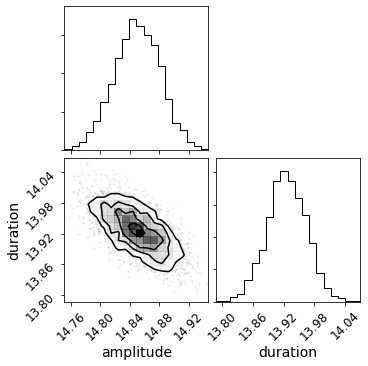

In [7]:
samples = np.array(list(zip(*[posterior_samplesA[name] for name in modelA.names])))
corner(samples, labels=modelA.names)
plt.show()

### Section 2.2.2: Detection

We can use the Bayesian evidence to decide whether or not there is a signal present.

First, compute the evidence for hypothesis A, defined as
$$Z_{A} = \int\mathrm{d}\theta^{\mu}\;\mathcal{L}_{A}(\theta^{\mu})\Pi(\theta^{\mu}) \,. $$ 
This has already been done above by CPNest.

Second, compute the evidence for the null hypothesis. The null hypothesis has no parameters (i.e. $\theta=\{\}$) so the evidence is simply given by the likelihood,

$$ Z_0 = \mathcal{L}_{0}() \,. $$

(This is an example of a Savage-Dickey density ratio.)

In [8]:
model0 = CPNestModel(catalog_data, 
                     event_num=eventID, 
                     model='Null')

folder = 'results/event'+str(eventID)+'_0/'
Z0 = np.array([ model0.log_likelihood({}), 0])

print('Computed log_evidences: {}'.format(Z0[0]))
os.makedirs(folder, exist_ok=True); np.savetxt(folder+'evidence.txt', Z0)

Computed log_evidences: -197401.88282975578


Finally, the *odds ratio* between the two hypothesis is given by the ratio

$$ \mathcal{O}_{A0} = \frac{Z_A}{Z_0} \,. $$

If this ratio is larger than unity then there is evidence in favour of a signal.

In [9]:
from Utils import GetEvidence

LogOddsRatio = GetEvidence(eventID, model='A') - GetEvidence(eventID, model='0')

print("log(O_A0) = ", LogOddsRatio)

log(O_A0) =  192433.62066975576


This is a **huge** number; there is definitely a signal present. The null hypothesis is ruled out at extremely high significance.

### Section 2.2.3: Model Selection

We can also use the Bayesian evidence to decide between two competing signal models.

We compute the evidences for each model, $Z_A$ and $Z_B$, and form the *odds ratio*

$$ \mathcal{O}_{AB} = \frac{Z_A}{Z_B} \,. $$

In [10]:
# Define the CPNest model
modelB = CPNestModel(catalog_data, 
                     event_num=eventID, 
                     model='B')

# Set up the nested sampling algorithm
nest_modelB = cpnest.CPNest(modelB, 
                            nlive=1024, 
                            output='results/event'+str(eventID)+'_B', 
                            nthreads=4, 
                            verbose=0)

# Run the algorithm
nest_modelB.run()
posterior_samplesB = nest_modelB.get_posterior_samples() 

Running with 4 parallel threads


Sampler process 55962: MCMC samples accumulated = 0
Sampler process 55963: MCMC samples accumulated = 0
Sampler process 55964: MCMC samples accumulated = 0
Sampler process 55961: MCMC samples accumulated = 0
Sampler process 55962 - mean acceptance 0.576: exiting
Sampler process 55963 - mean acceptance 0.573: exiting
Sampler process 55964 - mean acceptance 0.570: exiting
Sampler process 55961 - mean acceptance 0.576: exiting


Final evidence: 91.73
Information: 11.02


In [11]:
LogOddsRatio = GetEvidence(eventID, model='A') - GetEvidence(eventID, model='B')
print("log(O_AB) = ", LogOddsRatio)

log(O_AB) =  -5059.99546


There is very strong evidence in favour of model B.

Now that we have run CPNest for model B, we can look at the posterior distribution for the parameters $\theta^\mu$ under this model. The posterior on the parameters for model B is not the same as that for model A.

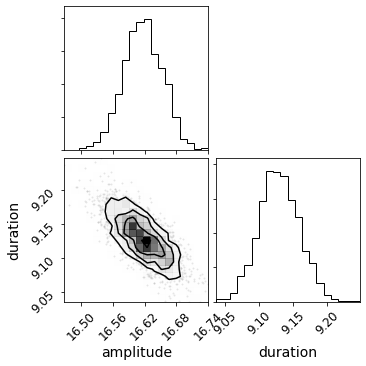

In [12]:
corner(np.array(list(zip(*[posterior_samplesB[name] for name in modelB.names]))), 
       labels=modelB.names)
plt.show()

## Section 2.3: Repeat Analysis for all Events in Catalog 

I ran this earlier for all events. The results are in the repository.

In [13]:
"""
eventID = 1

# Define the CPNest model A
modelA = CPNestModel(catalog_data,
                     event_num=eventID,
                     model='A')

nest_modelA = cpnest.CPNest(modelA,
                            nlive=1024,
                            output='results/event'+str(eventID)+'_A',
                            nthreads=4,
                            verbose=0)

nest_modelA.run()
post = nest_modelA.get_posterior_samples()

# Define the CPNest model B
modelB = CPNestModel(catalog_data,
                     event_num=eventID,
                     model='B')

nest_modelB = cpnest.CPNest(modelB,
                            nlive=1024,
                            output='results/event'+str(eventID)+'_B',
                            nthreads=4,
                            verbose=0)

nest_modelB.run()
post = nest_modelB.get_posterior_samples()

# The null hypothesis
model0 = CPNestModel(catalog_data,
                     event_num=eventID,
                     model='Null')

folder = 'results/event'+str(eventID)+'_0/'
Z0 = np.array([ model0.log_likelihood({}), 0])

print('Computed log_evidences: ({},)'.format(Z0))
os.makedirs(folder, exist_ok=True); np.savetxt(folder+'evidence.txt', Z0)
"""
print("Uncomment and run repeatedly with eventID 1,2,...,9")

Uncomment and run repeatedly with eventID 1,2,...,9


## Section 2.4: Summary Plots for our mock catalog

You can load the posterior samples from any of the events in the catalog and plot a corner plot if you wish to see the posterior distributions.

Here I will load the evidences for each hypothesis and for each event ($3\, \mathrm{hypotheses }\times 10\,\mathrm{events}=30$ evidences in total) and plot these to see if we can reach any general conclusions.

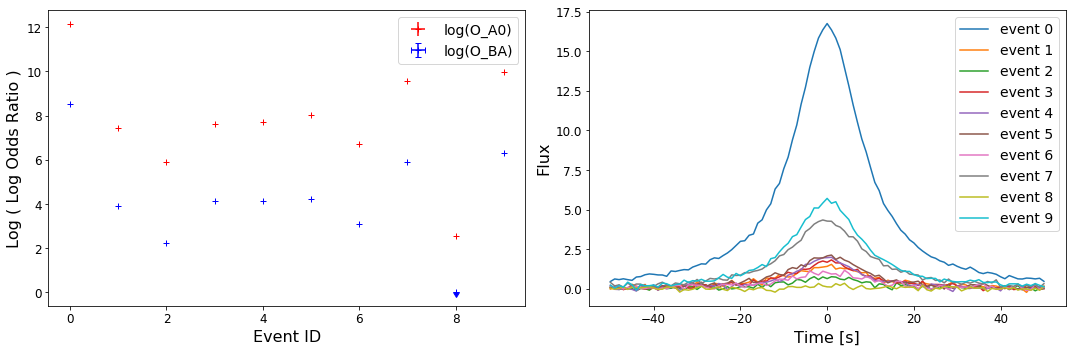

In [14]:
Zs = np.array([ [GetEvidence(eventID, model='0'), 
                 GetEvidence(eventID, model='A'), 
                 GetEvidence(eventID, model='B')] for eventID in range(10)])

logO_A0 = Zs[:,1] - Zs[:,0]
logO_BA = Zs[:,2] - Zs[:,1]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axes[0].errorbar(np.arange(Nevents), np.log(np.maximum(1,logO_A0)), 
                 xerr=0., yerr=0.0, uplims=logO_A0<1, marker='+', linestyle='',
                 color='red', label='log(O_A0)')
axes[0].errorbar(np.arange(Nevents), np.log(np.maximum(1,logO_BA)), 
                 xerr=0., yerr=0.0, uplims=logO_BA<1, marker='+', linestyle='',
                 color='blue', label='log(O_BA)')
axes[0].set_xlabel("Event ID", fontsize=BIGGER_SIZE)
axes[0].set_ylabel("Log ( Log Odds Ratio )", fontsize=BIGGER_SIZE)
axes[0].legend(loc='upper right', fontsize=MEDIUM_SIZE)

for N in range(Nevents):
    axes[1].plot(times, catalog_data[:,N+1], label='event '+str(N))  
axes[1].set_xlabel("Time [s]", fontsize=BIGGER_SIZE)
axes[1].set_ylabel("Flux", fontsize=BIGGER_SIZE)
axes[1].legend(loc='upper right', fontsize=MEDIUM_SIZE)

plt.tight_layout()
plt.show()

It seems that hypothesis B is generally prefered. These light curves are not Gaussian (with the possible exception of event 8 which is extremely faint in any case).

# Section 3: Hierarchical Bayesian Models

Inevitably, as we observe more events and the size of our catalog grows, we will stop just asking questions about individual events and start to ask questions about the population as a whole. The formalism of Bayesian analysis can be repurposed to address these questions as well.

In the above analysis a flat prior on the duration was used. But we might wonder whether this really reflects the population in our catalog. Certainly, looking at the light curves it seems that the durations are all clustered around a similar length. What is this average duration and how tight is the clustering?

## Section 3.1: General Approach

We could rerun the above analyses with a new prior on the parameters
$$ \Pi(\theta^\mu) \rightarrow \Pi(\theta^\mu|\lambda^{\alpha}) \,, $$
where the new *hyperparameters* $\lambda^{\alpha}$ describe the population.

Bayes' theorem for an individual event now reads
$$ P\big(\theta^\mu_i|\mathrm{data}_i, \lambda^\alpha \big) = \frac{P\big(\mathrm{data}_i|\theta^\mu\big)\Pi\big(\theta^\mu | \lambda^\alpha\big)}{Z_i(\lambda^\alpha)} \,, $$
for a fixed $i$ and where the $\lambda^\alpha$ are viewed as being fixed (constant). The normalising evidence now depends on the hyperparameters $\lambda^\alpha$.

Bayes' theorem one level up! Bayes' theorem applied to the population reads
$$ P\big(\lambda^\alpha|\{\mathrm{data}\} \big) = \frac{P\big(\{\mathrm{data}\}|\lambda^\alpha\big)\Pi\big(\lambda^\alpha\big)}{Z} \,, $$
where the $\lambda^\alpha$ are now our new *hyperparameters* and $\Pi(\lambda^{\alpha})$ are the *hyperpriors* on these parameters.
At this new, higher level the *hyperlikehood* is given by

$$ P(\lambda^{\alpha} | \{\mathrm{data}\}) = \prod_{i=1}^{N_\mathrm{events}}Z_i(\lambda^\alpha) \,. $$
which, by the definition of $Z_{i}(\lambda^\alpha)$ becomes
$$ P(\lambda^{\alpha} | \{\mathrm{data}\}) = \prod_{i=1}^{N_\mathrm{events}}\int\mathrm{d}\theta^\mu\; P(\mathrm{data}_i|\theta^{\mu})\Pi(\theta^\mu|\lambda^\alpha)\,. $$
The posterior samples which we have already obtained provide a computationally efficient method for evaluating this *hyperlikelihood*;
$$ P(\lambda^{\alpha} | \{\mathrm{data}\}) = \sum_{i=1}^{N_\mathrm{events}}\log\left( \sum_{a=1}^{N_\mathrm{samples}} \frac{\Pi(\theta^{\mu}_{a}| \lambda^\alpha)}{\Pi(\theta_a)} \right) \,. $$


---------

For completeness, we also give here the expressions for the *hyperevidence*, although it will not be needed;

$$ Z = \int\mathrm{d}\lambda\;P(\lambda^{\alpha} | \{\mathrm{data}\})\Pi(\lambda^{\alpha}) \,.$$


## Section 3.1: Modelling the Population - Specific example

We will choose as our model for the population (AKA *hyperprior*) to be
$$ \Pi(\theta^{\mu}|\lambda^{\nu}) = \Pi(A)\frac{\exp\left(\frac{-(\tau-\tau_0)^2}{2\Delta^2}\right)}{\sqrt{2\pi\Delta^2}}$$
where $\Pi(A)$ is the Jeffreys prior defined above and $\lambda^{\nu}=\{\tau_0, \Delta\}$.

In other words, we are modelling the population of transients as having durations $\tau$ which are log-normally distributed and we are trying to use the catalog of the first few events to measure the mean, $\tau_0$, and spread, $\Delta$, of the durations.

In [15]:
catalog_samples = [np.loadtxt('results/event'+str(eventID)+'_B/posterior.dat') 
                   for eventID in range(Nevents)]

In [16]:
class CPNestHyperModel(cpnest.model.Model):
    
    def __init__(self, catalog_samples):
        """
        INPUTS
        ------
        catalog_sample: list
            list length Nevents
            each entry in list is a np.array of the posterior samples
        """
        self.catalog_samples = catalog_samples
        
        self.names   = ['Tau0', 'Delta']
        self.bounds  = [[5, 15], [0.5, 2]] # Here I choose flat hyperpriors on 
                                           # the hyperparameters Tau0 and Delta and
                                           # relatively narrow ranges. 
            
    def log_prior(self, params):
        """
        The log-hyperprior distribution

        INPUTS
        ------
        params: dict of model parameters
            keys 'Tau0' and 'Delta'
        
        RETURNS
        -------
            LogPrior: float
        """
        if not self.in_bounds(params): 
            return -np.inf
        else:
            LogPrior = -np.log(self.bounds[0][1]-self.bounds[0][0])
            LogPrior -= np.log(self.bounds[1][1]-self.bounds[1][0])
            return LogPrior 
        
    def log_likelihood(self, params):
        """
        The log-hyperlikelihood distribution
    
        INPUTS
        ------
        params: dict of model parameters
            keys 'Tau0' and 'Delta'
           
        RETURNS
        -------
            LogLike: float
        """
        LogLike = 0.
        for samples in self.catalog_samples:
            LogLike += np.log(np.sum(
                norm.pdf(samples[:,1], loc=params['Tau0'], scale=params['Delta'])
            ) / (1./99.))
        
        return LogLike

Load the posterior samples for all of the individual events in the catalog.

In [17]:
catalog_samples = [np.loadtxt('results/event'+str(eventID)+'_B/posterior.dat') 
                   for eventID in range(Nevents)]

Now we run the population analysis. We use the machinery of CPNest exactly as before, it is only the interpretation of the various quantities that has changed.

In [18]:
hypermodel = CPNestHyperModel(catalog_samples)

nest_hypermodel = cpnest.CPNest(hypermodel, 
                            nlive=1024, 
                            output='results/population_analysis', 
                            nthreads=4, 
                            verbose=1)

nest_hypermodel.run()
nest_hypermodel_samples = nest_hypermodel.get_posterior_samples() 

Running with 4 parallel threads


SMPLR 1 init draw:   0%|          | 0/100 [00:00<?, ?it/s]



CPNEST: populate samplers:   0%|          | 0/1024 [00:00<?, ?it/s]

SMPLR 2 init draw:   0%|          | 0/100 [00:00<?, ?it/s]


SMPLR 1 init draw:  45%|████▌     | 45/100 [00:00<00:00, 445.39it/s]

SMPLR 2 init draw:  45%|████▌     | 45/100 [00:00<00:00, 448.52it/s]


SMPLR 1 init draw:  89%|████████▉ | 89/100 [00:00<00:00, 443.27it/s]

SMPLR 0 init evolve:   0%|          | 0/100 [00:00<?, ?it/s]        


SMPLR 3 init draw:  92%|█████████▏| 92/100 [00:00<00:00, 447.75it/s]
                                                                    
SMPLR 1 init evolve:   0%|          | 0/100 [00:00<?, ?it/s]

                                                                    


                                                                    

SMPLR 2 init evolve:   0%|          | 0/100 [00:00<?, ?it/s]


SMPLR 1 init evolve:   7%|▋         | 7/100 [00:00<00:01, 68.06it/s]


SMPLR 3 init evolve:   7%|▋         | 7/100 [00:00<

CPNEST: populate samplers:  63%|██████▎   | 645/1024 [00:05<00:02, 152.52it/s]



CPNEST: populate samplers:  65%|██████▍   | 661/1024 [00:05<00:02, 149.50it/s]



CPNEST: populate samplers:  67%|██████▋   | 681/1024 [00:06<00:02, 153.33it/s]



CPNEST: populate samplers:  68%|██████▊   | 697/1024 [00:06<00:02, 136.05it/s]



CPNEST: populate samplers:  70%|██████▉   | 713/1024 [00:06<00:02, 135.81it/s]



CPNEST: populate samplers:  71%|███████   | 729/1024 [00:06<00:02, 139.62it/s]



CPNEST: populate samplers:  73%|███████▎  | 744/1024 [00:06<00:01, 141.25it/s]



CPNEST: populate samplers:  74%|███████▍  | 761/1024 [00:06<00:01, 140.96it/s]



CPNEST: populate samplers:  76%|███████▋  | 781/1024 [00:06<00:01, 147.81it/s]



CPNEST: populate samplers:  78%|███████▊  | 797/1024 [00:06<00:01, 146.70it/s]



CPNEST: populate samplers:  79%|███████▉  | 812/1024 [00:06<00:01, 147.66it/s]



CPNEST: populate samplers:  81%|████████  | 827/1024 [00:07<00:01, 146.01it/s]



CPNEST: populate

47: n:  11 NS_acc:0.979 S1_acc:0.661 sub_acc:0.545 H: 5.92 logL -27.48495 --> 106.91416 dZ: 141.737 logZ: -33.065 logLmax: 108.72
48: n:  10 NS_acc:0.980 S0_acc:0.667 sub_acc:0.700 H: 5.92 logL -32.57035 --> 88.10713 dZ: 141.737 logZ: -33.065 logLmax: 108.72
49: n:  11 NS_acc:0.980 S2_acc:0.695 sub_acc:0.545 H: 5.47 logL -26.06761 --> 81.99479 dZ: 139.797 logZ: -31.129 logLmax: 108.72
50: n:  11 NS_acc:0.980 S3_acc:0.671 sub_acc:0.727 H: 5.47 logL -24.82303 --> 84.63547 dZ: 139.797 logZ: -31.129 logLmax: 108.72
51: n:  11 NS_acc:0.981 S0_acc:0.661 sub_acc:0.818 H: 5.47 logL -26.76156 --> 37.46007 dZ: 139.797 logZ: -31.129 logLmax: 108.72
52: n:  10 NS_acc:0.981 S1_acc:0.666 sub_acc:0.300 H: 5.47 logL -26.21103 --> 100.81196 dZ: 139.797 logZ: -31.129 logLmax: 108.72
53: n:  11 NS_acc:0.981 S2_acc:0.695 sub_acc:0.545 H: 6.13 logL -18.98884 --> 67.77174 dZ: 133.097 logZ: -24.432 logLmax: 108.72
54: n:  11 NS_acc:0.982 S3_acc:0.671 sub_acc:0.727 H: 6.13 logL -17.80449 --> 105.66616 dZ: 133

112: n:  11 NS_acc:0.991 S1_acc:0.666 sub_acc:0.545 H: 5.86 logL 26.53420 --> 76.26750 dZ: 86.471 logZ: 22.138 logLmax: 108.72
113: n:  11 NS_acc:0.991 S2_acc:0.693 sub_acc:0.818 H: 5.32 logL 29.55245 --> 87.70839 dZ: 84.737 logZ: 23.868 logLmax: 108.72
114: n:  11 NS_acc:0.991 S1_acc:0.670 sub_acc:0.727 H: 5.32 logL 28.90787 --> 105.66103 dZ: 84.737 logZ: 23.868 logLmax: 108.72
115: n:  12 NS_acc:0.991 S0_acc:0.661 sub_acc:0.667 H: 5.32 logL 28.51981 --> 80.53897 dZ: 84.737 logZ: 23.868 logLmax: 108.72
116: n:  11 NS_acc:0.991 S3_acc:0.666 sub_acc:0.818 H: 5.32 logL 29.83166 --> 41.88513 dZ: 84.737 logZ: 23.868 logLmax: 108.72
117: n:  11 NS_acc:0.992 S2_acc:0.693 sub_acc:0.545 H: 4.89 logL 30.15492 --> 92.12216 dZ: 83.717 logZ: 24.885 logLmax: 108.72
118: n:  11 NS_acc:0.992 S3_acc:0.670 sub_acc:0.818 H: 4.89 logL 30.20064 --> 107.29764 dZ: 83.717 logZ: 24.885 logLmax: 108.72
119: n:  12 NS_acc:0.992 S0_acc:0.660 sub_acc:0.417 H: 4.89 logL 29.85663 --> 103.40576 dZ: 83.717 logZ: 24.8

177: n:  11 NS_acc:0.994 S2_acc:0.692 sub_acc:0.636 H: 4.47 logL 50.14253 --> 106.30470 dZ: 63.708 logZ: 44.836 logLmax: 108.72
178: n:  11 NS_acc:0.994 S3_acc:0.669 sub_acc:0.545 H: 4.47 logL 50.18431 --> 107.70520 dZ: 63.708 logZ: 44.836 logLmax: 108.72
179: n:  13 NS_acc:0.994 S0_acc:0.657 sub_acc:0.769 H: 4.47 logL 49.54509 --> 103.47125 dZ: 63.708 logZ: 44.836 logLmax: 108.72
180: n:  15 NS_acc:0.994 S1_acc:0.660 sub_acc:0.467 H: 4.47 logL 49.79705 --> 85.45688 dZ: 63.708 logZ: 44.836 logLmax: 108.72
181: n:  10 NS_acc:0.995 S1_acc:0.692 sub_acc:0.700 H: 4.42 logL 50.48391 --> 68.70023 dZ: 63.005 logZ: 45.534 logLmax: 108.72
182: n:  11 NS_acc:0.995 S3_acc:0.670 sub_acc:0.818 H: 4.42 logL 50.91761 --> 106.84336 dZ: 63.005 logZ: 45.534 logLmax: 108.72
183: n:  13 NS_acc:0.995 S2_acc:0.657 sub_acc:0.692 H: 4.42 logL 50.54577 --> 107.78354 dZ: 63.005 logZ: 45.534 logLmax: 108.72
184: n:  15 NS_acc:0.995 S0_acc:0.661 sub_acc:0.800 H: 4.42 logL 50.19607 --> 106.59509 dZ: 63.005 logZ: 4

242: n:  15 NS_acc:0.996 S3_acc:0.664 sub_acc:0.467 H: 4.54 logL 62.12689 --> 107.39508 dZ: 51.848 logZ: 56.633 logLmax: 108.72
243: n:  14 NS_acc:0.996 S2_acc:0.655 sub_acc:0.643 H: 4.54 logL 62.06478 --> 75.13317 dZ: 51.848 logZ: 56.633 logLmax: 108.72
244: n:  15 NS_acc:0.996 S0_acc:0.657 sub_acc:0.600 H: 4.54 logL 61.60569 --> 106.56923 dZ: 51.848 logZ: 56.633 logLmax: 108.72
245: n:  13 NS_acc:0.996 S2_acc:0.687 sub_acc:0.769 H: 4.46 logL 62.39325 --> 107.29893 dZ: 51.173 logZ: 57.304 logLmax: 108.72
246: n:  15 NS_acc:0.996 S0_acc:0.665 sub_acc:0.800 H: 4.46 logL 62.26844 --> 101.74010 dZ: 51.173 logZ: 57.304 logLmax: 108.72
247: n:  14 NS_acc:0.996 S3_acc:0.655 sub_acc:0.571 H: 4.46 logL 62.51413 --> 81.71206 dZ: 51.173 logZ: 57.304 logLmax: 108.72
248: n:  15 NS_acc:0.996 S1_acc:0.657 sub_acc:0.733 H: 4.46 logL 62.29684 --> 108.53068 dZ: 51.173 logZ: 57.304 logLmax: 108.72
249: n:  13 NS_acc:0.996 S0_acc:0.686 sub_acc:0.462 H: 4.36 logL 62.75976 --> 83.19244 dZ: 50.594 logZ: 57

307: n:  13 NS_acc:0.997 S2_acc:0.651 sub_acc:0.538 H: 3.94 logL 69.72608 --> 102.96292 dZ: 43.547 logZ: 64.872 logLmax: 108.72
308: n:  15 NS_acc:0.997 S1_acc:0.650 sub_acc:0.333 H: 3.94 logL 69.41181 --> 72.11418 dZ: 43.547 logZ: 64.872 logLmax: 108.72
309: n:  19 NS_acc:0.997 S2_acc:0.674 sub_acc:0.526 H: 3.95 logL 70.07152 --> 73.33914 dZ: 43.125 logZ: 65.289 logLmax: 108.72
310: n:  14 NS_acc:0.997 S0_acc:0.659 sub_acc:0.286 H: 3.95 logL 70.03005 --> 93.22210 dZ: 43.125 logZ: 65.289 logLmax: 108.72
311: n:  13 NS_acc:0.997 S1_acc:0.651 sub_acc:0.846 H: 3.95 logL 70.05104 --> 106.81506 dZ: 43.125 logZ: 65.289 logLmax: 108.72
312: n:  16 NS_acc:0.997 S3_acc:0.650 sub_acc:0.438 H: 3.95 logL 70.09416 --> 76.42859 dZ: 43.125 logZ: 65.289 logLmax: 108.72
313: n:  18 NS_acc:0.997 S0_acc:0.672 sub_acc:0.278 H: 3.89 logL 70.11694 --> 81.99854 dZ: 42.789 logZ: 65.621 logLmax: 108.72
314: n:  15 NS_acc:0.997 S3_acc:0.658 sub_acc:0.267 H: 3.89 logL 70.39577 --> 72.88493 dZ: 42.789 logZ: 65.62

372: n:  14 NS_acc:0.997 S3_acc:0.645 sub_acc:0.214 H: 4.00 logL 75.77551 --> 77.28825 dZ: 37.413 logZ: 70.943 logLmax: 108.72
373: n:  15 NS_acc:0.997 S0_acc:0.668 sub_acc:0.467 H: 3.96 logL 75.89709 --> 92.10032 dZ: 37.059 logZ: 71.293 logLmax: 108.72
374: n:  15 NS_acc:0.997 S1_acc:0.654 sub_acc:0.733 H: 3.96 logL 75.99103 --> 106.91270 dZ: 37.059 logZ: 71.293 logLmax: 108.72
375: n:  17 NS_acc:0.997 S3_acc:0.647 sub_acc:0.471 H: 3.96 logL 76.04075 --> 107.54753 dZ: 37.059 logZ: 71.293 logLmax: 108.72
376: n:  16 NS_acc:0.997 S2_acc:0.645 sub_acc:0.688 H: 3.96 logL 75.99902 --> 93.13500 dZ: 37.059 logZ: 71.293 logLmax: 108.72
377: n:  16 NS_acc:0.997 S0_acc:0.668 sub_acc:0.812 H: 3.91 logL 76.17992 --> 107.09692 dZ: 36.736 logZ: 71.612 logLmax: 108.72
378: n:  15 NS_acc:0.997 S2_acc:0.654 sub_acc:0.800 H: 3.91 logL 76.26750 --> 92.00765 dZ: 36.736 logZ: 71.612 logLmax: 108.72
379: n:  17 NS_acc:0.997 S3_acc:0.647 sub_acc:0.588 H: 3.91 logL 76.27483 --> 94.54629 dZ: 36.736 logZ: 71.6

437: n:  14 NS_acc:0.998 S0_acc:0.663 sub_acc:0.714 H: 3.56 logL 79.99742 --> 92.61558 dZ: 32.553 logZ: 75.737 logLmax: 108.72
438: n:  16 NS_acc:0.998 S1_acc:0.647 sub_acc:0.750 H: 3.56 logL 80.02975 --> 101.17335 dZ: 32.553 logZ: 75.737 logLmax: 108.72
439: n:  15 NS_acc:0.998 S3_acc:0.643 sub_acc:0.400 H: 3.56 logL 80.10145 --> 98.99662 dZ: 32.553 logZ: 75.737 logLmax: 108.72
440: n:  19 NS_acc:0.998 S2_acc:0.642 sub_acc:0.579 H: 3.56 logL 80.08536 --> 95.60449 dZ: 32.553 logZ: 75.737 logLmax: 108.72
441: n:  14 NS_acc:0.998 S2_acc:0.664 sub_acc:0.714 H: 3.53 logL 80.20743 --> 95.28118 dZ: 32.346 logZ: 75.940 logLmax: 108.72
442: n:  15 NS_acc:0.998 S0_acc:0.647 sub_acc:0.667 H: 3.53 logL 80.15574 --> 103.53596 dZ: 32.346 logZ: 75.940 logLmax: 108.72
443: n:  15 NS_acc:0.998 S3_acc:0.643 sub_acc:0.467 H: 3.53 logL 80.34139 --> 106.20160 dZ: 32.346 logZ: 75.940 logLmax: 108.72
444: n:  18 NS_acc:0.998 S1_acc:0.641 sub_acc:0.333 H: 3.53 logL 80.18272 --> 101.94060 dZ: 32.346 logZ: 75.

502: n:  15 NS_acc:0.998 S1_acc:0.644 sub_acc:0.533 H: 3.62 logL 83.98955 --> 84.36734 dZ: 28.827 logZ: 79.400 logLmax: 108.72
503: n:  14 NS_acc:0.998 S3_acc:0.640 sub_acc:0.357 H: 3.62 logL 84.12709 --> 93.90592 dZ: 28.827 logZ: 79.400 logLmax: 108.72
504: n:  16 NS_acc:0.998 S2_acc:0.638 sub_acc:0.625 H: 3.62 logL 83.99357 --> 102.35618 dZ: 28.827 logZ: 79.400 logLmax: 108.72
505: n:  15 NS_acc:0.998 S3_acc:0.658 sub_acc:0.733 H: 3.65 logL 84.36742 --> 107.15813 dZ: 28.542 logZ: 79.681 logLmax: 108.72
506: n:  14 NS_acc:0.998 S2_acc:0.644 sub_acc:0.714 H: 3.65 logL 84.36734 --> 108.41591 dZ: 28.542 logZ: 79.681 logLmax: 108.72
507: n:  15 NS_acc:0.998 S1_acc:0.640 sub_acc:0.533 H: 3.65 logL 84.33027 --> 107.10812 dZ: 28.542 logZ: 79.681 logLmax: 108.72
508: n:  16 NS_acc:0.998 S0_acc:0.637 sub_acc:0.375 H: 3.65 logL 84.17787 --> 87.72682 dZ: 28.542 logZ: 79.681 logLmax: 108.72
509: n:  15 NS_acc:0.998 S1_acc:0.657 sub_acc:0.267 H: 3.68 logL 84.54064 --> 88.69092 dZ: 28.263 logZ: 79.

567: n:  15 NS_acc:0.998 S3_acc:0.637 sub_acc:0.733 H: 3.38 logL 87.10580 --> 106.23591 dZ: 25.493 logZ: 82.672 logLmax: 108.72
568: n:  17 NS_acc:0.998 S2_acc:0.636 sub_acc:0.882 H: 3.38 logL 87.04065 --> 106.63373 dZ: 25.493 logZ: 82.672 logLmax: 108.72
569: n:  18 NS_acc:0.998 S0_acc:0.650 sub_acc:0.556 H: 3.38 logL 87.12932 --> 92.99097 dZ: 25.307 logZ: 82.854 logLmax: 108.72
570: n:  16 NS_acc:0.998 S1_acc:0.638 sub_acc:0.438 H: 3.38 logL 87.14609 --> 107.07431 dZ: 25.307 logZ: 82.854 logLmax: 108.72
571: n:  14 NS_acc:0.998 S3_acc:0.637 sub_acc:0.643 H: 3.38 logL 87.21741 --> 104.11915 dZ: 25.307 logZ: 82.854 logLmax: 108.72
572: n:  16 NS_acc:0.998 S2_acc:0.636 sub_acc:0.688 H: 3.38 logL 87.15240 --> 91.26391 dZ: 25.307 logZ: 82.854 logLmax: 108.72
573: n:  18 NS_acc:0.998 S0_acc:0.650 sub_acc:0.611 H: 3.37 logL 87.22824 --> 102.11278 dZ: 25.137 logZ: 83.020 logLmax: 108.72
574: n:  16 NS_acc:0.998 S1_acc:0.638 sub_acc:0.375 H: 3.37 logL 87.23237 --> 101.90000 dZ: 25.137 logZ: 8

632: n:  14 NS_acc:0.998 S2_acc:0.636 sub_acc:0.500 H: 3.24 logL 89.21322 --> 103.52818 dZ: 23.015 logZ: 85.087 logLmax: 108.72
633: n:  16 NS_acc:0.998 S0_acc:0.647 sub_acc:0.688 H: 3.23 logL 89.35249 --> 91.90026 dZ: 22.869 logZ: 85.229 logLmax: 108.72
634: n:  14 NS_acc:0.998 S2_acc:0.635 sub_acc:0.571 H: 3.23 logL 89.37356 --> 89.98749 dZ: 22.869 logZ: 85.229 logLmax: 108.72
635: n:  13 NS_acc:0.998 S1_acc:0.636 sub_acc:0.385 H: 3.23 logL 89.36099 --> 96.59966 dZ: 22.869 logZ: 85.229 logLmax: 108.72
636: n:  14 NS_acc:0.998 S3_acc:0.636 sub_acc:0.714 H: 3.23 logL 89.39590 --> 96.57062 dZ: 22.869 logZ: 85.229 logLmax: 108.72
637: n:  15 NS_acc:0.998 S1_acc:0.647 sub_acc:0.733 H: 3.23 logL 89.45949 --> 101.91296 dZ: 22.730 logZ: 85.364 logLmax: 108.72
638: n:  14 NS_acc:0.998 S2_acc:0.635 sub_acc:0.643 H: 3.23 logL 89.47953 --> 97.13323 dZ: 22.730 logZ: 85.364 logLmax: 108.72
639: n:  13 NS_acc:0.998 S3_acc:0.636 sub_acc:0.923 H: 3.23 logL 89.50861 --> 105.76012 dZ: 22.730 logZ: 85.3

697: n:  14 NS_acc:0.999 S1_acc:0.645 sub_acc:0.571 H: 3.24 logL 91.58700 --> 94.02444 dZ: 20.599 logZ: 87.437 logLmax: 108.72
698: n:  13 NS_acc:0.999 S3_acc:0.633 sub_acc:0.385 H: 3.24 logL 91.69699 --> 96.28939 dZ: 20.599 logZ: 87.437 logLmax: 108.72
699: n:  15 NS_acc:0.999 S0_acc:0.630 sub_acc:0.267 H: 3.24 logL 91.57956 --> 107.99060 dZ: 20.599 logZ: 87.437 logLmax: 108.72
700: n:  16 NS_acc:0.999 S2_acc:0.634 sub_acc:0.562 H: 3.24 logL 91.68195 --> 98.68822 dZ: 20.599 logZ: 87.437 logLmax: 108.72
701: n:  14 NS_acc:0.999 S3_acc:0.645 sub_acc:0.571 H: 3.24 logL 91.73705 --> 105.66143 dZ: 20.463 logZ: 87.569 logLmax: 108.72
702: n:  14 NS_acc:0.999 S2_acc:0.633 sub_acc:0.714 H: 3.24 logL 91.70652 --> 106.32719 dZ: 20.463 logZ: 87.569 logLmax: 108.72
703: n:  16 NS_acc:0.999 S0_acc:0.630 sub_acc:0.625 H: 3.24 logL 91.70202 --> 108.23369 dZ: 20.463 logZ: 87.569 logLmax: 108.72
704: n:  16 NS_acc:0.999 S1_acc:0.634 sub_acc:0.625 H: 3.24 logL 91.70413 --> 108.31293 dZ: 20.463 logZ: 87

762: n:  15 NS_acc:0.999 S3_acc:0.629 sub_acc:0.867 H: 3.17 logL 93.52730 --> 105.51398 dZ: 18.607 logZ: 89.366 logLmax: 108.72
763: n:  18 NS_acc:0.999 S1_acc:0.625 sub_acc:0.778 H: 3.17 logL 93.47298 --> 101.77455 dZ: 18.607 logZ: 89.366 logLmax: 108.72
764: n:  15 NS_acc:0.999 S2_acc:0.631 sub_acc:0.600 H: 3.17 logL 93.49659 --> 102.98047 dZ: 18.607 logZ: 89.366 logLmax: 108.72
765: n:  14 NS_acc:0.999 S0_acc:0.642 sub_acc:0.500 H: 3.16 logL 93.53934 --> 105.76492 dZ: 18.485 logZ: 89.484 logLmax: 108.72
766: n:  14 NS_acc:0.999 S2_acc:0.629 sub_acc:0.429 H: 3.16 logL 93.59357 --> 96.73698 dZ: 18.485 logZ: 89.484 logLmax: 108.72
767: n:  18 NS_acc:0.999 S3_acc:0.625 sub_acc:0.556 H: 3.16 logL 93.60759 --> 94.54803 dZ: 18.485 logZ: 89.484 logLmax: 108.72
768: n:  15 NS_acc:0.999 S1_acc:0.631 sub_acc:0.533 H: 3.16 logL 93.57040 --> 96.64576 dZ: 18.485 logZ: 89.484 logLmax: 108.72
769: n:  14 NS_acc:0.999 S0_acc:0.642 sub_acc:0.286 H: 3.16 logL 93.62502 --> 97.83626 dZ: 18.363 logZ: 89.

827: n:  15 NS_acc:0.999 S1_acc:0.623 sub_acc:0.800 H: 3.27 logL 95.60449 --> 107.32761 dZ: 16.538 logZ: 91.372 logLmax: 108.72
828: n:  13 NS_acc:0.999 S3_acc:0.630 sub_acc:0.769 H: 3.27 logL 95.65186 --> 104.98310 dZ: 16.538 logZ: 91.372 logLmax: 108.72
829: n:  14 NS_acc:0.999 S1_acc:0.639 sub_acc:0.714 H: 3.26 logL 95.65662 --> 104.77350 dZ: 16.415 logZ: 91.492 logLmax: 108.72
830: n:  16 NS_acc:0.999 S3_acc:0.623 sub_acc:0.562 H: 3.26 logL 95.67790 --> 106.16791 dZ: 16.415 logZ: 91.492 logLmax: 108.72
831: n:  15 NS_acc:0.999 S0_acc:0.624 sub_acc:0.667 H: 3.26 logL 95.65281 --> 107.31556 dZ: 16.415 logZ: 91.492 logLmax: 108.72
832: n:  13 NS_acc:0.999 S2_acc:0.630 sub_acc:0.769 H: 3.26 logL 95.66492 --> 106.29189 dZ: 16.415 logZ: 91.492 logLmax: 108.72
833: n:  14 NS_acc:0.999 S2_acc:0.639 sub_acc:0.500 H: 3.26 logL 95.83469 --> 104.22475 dZ: 16.291 logZ: 91.611 logLmax: 108.72
834: n:  16 NS_acc:0.999 S3_acc:0.623 sub_acc:0.562 H: 3.26 logL 95.83621 --> 96.27665 dZ: 16.291 logZ: 

892: n:  12 NS_acc:0.999 S1_acc:0.629 sub_acc:0.667 H: 3.06 logL 96.73698 --> 102.64983 dZ: 14.918 logZ: 92.930 logLmax: 108.72
893: n:  14 NS_acc:0.999 S0_acc:0.636 sub_acc:0.500 H: 3.05 logL 96.84686 --> 107.72341 dZ: 14.834 logZ: 93.010 logLmax: 108.72
894: n:  14 NS_acc:0.999 S2_acc:0.621 sub_acc:0.500 H: 3.05 logL 96.86705 --> 105.66075 dZ: 14.834 logZ: 93.010 logLmax: 108.72
895: n:  15 NS_acc:0.999 S3_acc:0.621 sub_acc:0.800 H: 3.05 logL 96.87918 --> 103.60475 dZ: 14.834 logZ: 93.010 logLmax: 108.72
896: n:  12 NS_acc:0.999 S1_acc:0.629 sub_acc:0.583 H: 3.05 logL 96.85338 --> 107.12877 dZ: 14.834 logZ: 93.010 logLmax: 108.72
897: n:  14 NS_acc:0.999 S1_acc:0.636 sub_acc:0.357 H: 3.04 logL 96.92173 --> 107.23714 dZ: 14.752 logZ: 93.088 logLmax: 108.72
898: n:  14 NS_acc:0.999 S0_acc:0.621 sub_acc:0.500 H: 3.04 logL 96.88475 --> 100.90365 dZ: 14.752 logZ: 93.088 logLmax: 108.72
899: n:  14 NS_acc:0.999 S3_acc:0.621 sub_acc:0.571 H: 3.04 logL 96.93071 --> 107.81130 dZ: 14.752 logZ:

957: n:  13 NS_acc:0.999 S0_acc:0.635 sub_acc:0.692 H: 2.93 logL 98.01143 --> 103.45651 dZ: 13.550 logZ: 94.232 logLmax: 108.72
958: n:  14 NS_acc:0.999 S2_acc:0.619 sub_acc:0.357 H: 2.93 logL 98.01797 --> 104.46656 dZ: 13.550 logZ: 94.232 logLmax: 108.72
959: n:  14 NS_acc:0.999 S3_acc:0.619 sub_acc:0.643 H: 2.93 logL 98.02712 --> 107.77689 dZ: 13.550 logZ: 94.232 logLmax: 108.72
960: n:  13 NS_acc:0.999 S1_acc:0.628 sub_acc:0.615 H: 2.93 logL 98.01674 --> 103.12991 dZ: 13.550 logZ: 94.232 logLmax: 108.72
961: n:  13 NS_acc:0.999 S2_acc:0.635 sub_acc:0.692 H: 2.92 logL 98.08454 --> 108.45847 dZ: 13.478 logZ: 94.300 logLmax: 108.72
962: n:  14 NS_acc:0.999 S1_acc:0.618 sub_acc:0.500 H: 2.92 logL 98.03951 --> 102.70134 dZ: 13.478 logZ: 94.300 logLmax: 108.72
963: n:  14 NS_acc:0.999 S0_acc:0.619 sub_acc:0.571 H: 2.92 logL 98.02713 --> 103.55730 dZ: 13.478 logZ: 94.300 logLmax: 108.72
964: n:  12 NS_acc:0.999 S3_acc:0.628 sub_acc:0.667 H: 2.92 logL 98.08592 --> 101.03718 dZ: 13.478 logZ:

1021: n:  15 NS_acc:0.999 S3_acc:0.632 sub_acc:0.667 H: 2.85 logL 99.07481 --> 107.01521 dZ: 12.403 logZ: 95.316 logLmax: 108.72
1022: n:  15 NS_acc:0.999 S1_acc:0.615 sub_acc:0.400 H: 2.85 logL 99.07095 --> 101.95322 dZ: 12.403 logZ: 95.316 logLmax: 108.72
1023: n:  15 NS_acc:0.999 S2_acc:0.617 sub_acc:0.800 H: 2.85 logL 99.07377 --> 105.67926 dZ: 12.403 logZ: 95.316 logLmax: 108.72
1024: n:  12 NS_acc:0.999 S0_acc:0.627 sub_acc:0.417 H: 2.85 logL 99.04056 --> 102.39038 dZ: 12.403 logZ: 95.316 logLmax: 108.72
1025: n:  15 NS_acc:0.999 S1_acc:0.631 sub_acc:0.467 H: 2.85 logL 99.15366 --> 103.50250 dZ: 12.335 logZ: 95.380 logLmax: 108.72
1026: n:  15 NS_acc:0.999 S0_acc:0.615 sub_acc:0.400 H: 2.85 logL 99.07739 --> 107.73272 dZ: 12.335 logZ: 95.380 logLmax: 108.72
1027: n:  14 NS_acc:0.999 S3_acc:0.617 sub_acc:0.500 H: 2.85 logL 99.18349 --> 106.31154 dZ: 12.335 logZ: 95.380 logLmax: 108.72
1028: n:  13 NS_acc:0.999 S2_acc:0.627 sub_acc:0.846 H: 2.85 logL 99.17052 --> 107.41156 dZ: 12.3

1085: n:  14 NS_acc:0.999 S1_acc:0.629 sub_acc:0.357 H: 2.87 logL 100.24058 --> 102.43839 dZ: 11.268 logZ: 96.389 logLmax: 108.72
1086: n:  14 NS_acc:0.999 S3_acc:0.615 sub_acc:0.786 H: 2.87 logL 100.29291 --> 105.35591 dZ: 11.268 logZ: 96.389 logLmax: 108.72
1087: n:  14 NS_acc:0.999 S2_acc:0.617 sub_acc:0.571 H: 2.87 logL 100.26085 --> 106.40571 dZ: 11.268 logZ: 96.389 logLmax: 108.72
1088: n:  18 NS_acc:0.999 S0_acc:0.623 sub_acc:0.778 H: 2.87 logL 100.14489 --> 107.00033 dZ: 11.268 logZ: 96.389 logLmax: 108.72
1089: n:  15 NS_acc:0.999 S2_acc:0.630 sub_acc:0.867 H: 2.88 logL 100.43441 --> 103.70748 dZ: 11.193 logZ: 96.460 logLmax: 108.72
1090: n:  13 NS_acc:0.999 S3_acc:0.614 sub_acc:0.462 H: 2.88 logL 100.43635 --> 101.24992 dZ: 11.193 logZ: 96.460 logLmax: 108.72
1091: n:  14 NS_acc:0.999 S1_acc:0.617 sub_acc:0.643 H: 2.88 logL 100.37910 --> 108.69872 dZ: 11.193 logZ: 96.460 logLmax: 108.72
1092: n:  18 NS_acc:0.999 S0_acc:0.622 sub_acc:0.333 H: 2.88 logL 100.32292 --> 102.87472 

1149: n:  14 NS_acc:0.999 S0_acc:0.628 sub_acc:0.500 H: 2.92 logL 101.31909 --> 102.64947 dZ: 10.114 logZ: 97.480 logLmax: 108.72
1150: n:  15 NS_acc:0.999 S1_acc:0.614 sub_acc:0.600 H: 2.92 logL 101.32646 --> 107.70228 dZ: 10.114 logZ: 97.480 logLmax: 108.72
1151: n:  14 NS_acc:0.999 S3_acc:0.615 sub_acc:0.143 H: 2.92 logL 101.35872 --> 105.30496 dZ: 10.114 logZ: 97.480 logLmax: 108.72
1152: n:  19 NS_acc:0.999 S2_acc:0.619 sub_acc:0.684 H: 2.92 logL 101.33386 --> 105.12820 dZ: 10.114 logZ: 97.480 logLmax: 108.72
1153: n:  14 NS_acc:0.999 S0_acc:0.628 sub_acc:0.357 H: 2.92 logL 101.39275 --> 106.11685 dZ: 10.047 logZ: 97.543 logLmax: 108.72
1154: n:  15 NS_acc:0.999 S2_acc:0.614 sub_acc:0.533 H: 2.92 logL 101.42539 --> 106.39823 dZ: 10.047 logZ: 97.543 logLmax: 108.72
1155: n:  17 NS_acc:0.999 S1_acc:0.615 sub_acc:0.706 H: 2.92 logL 101.39570 --> 101.84161 dZ: 10.047 logZ: 97.543 logLmax: 108.72
1156: n:  18 NS_acc:0.999 S3_acc:0.619 sub_acc:0.667 H: 2.92 logL 101.44727 --> 104.64650 

1213: n:  18 NS_acc:0.999 S1_acc:0.624 sub_acc:0.722 H: 2.84 logL 101.97409 --> 102.33247 dZ: 9.171 logZ: 98.360 logLmax: 108.72
1214: n:  16 NS_acc:0.999 S3_acc:0.610 sub_acc:0.562 H: 2.84 logL 101.99770 --> 106.18943 dZ: 9.171 logZ: 98.360 logLmax: 108.72
1215: n:  15 NS_acc:0.999 S0_acc:0.613 sub_acc:0.467 H: 2.84 logL 101.97401 --> 108.60672 dZ: 9.171 logZ: 98.360 logLmax: 108.72
1216: n:  16 NS_acc:0.999 S2_acc:0.615 sub_acc:0.312 H: 2.84 logL 101.99486 --> 105.43320 dZ: 9.171 logZ: 98.360 logLmax: 108.72
1217: n:  17 NS_acc:0.999 S0_acc:0.623 sub_acc:0.471 H: 2.83 logL 102.00772 --> 107.60843 dZ: 9.122 logZ: 98.405 logLmax: 108.72
1218: n:  16 NS_acc:0.999 S1_acc:0.610 sub_acc:0.500 H: 2.83 logL 102.01106 --> 107.91505 dZ: 9.122 logZ: 98.405 logLmax: 108.72
1219: n:  15 NS_acc:0.999 S2_acc:0.612 sub_acc:0.333 H: 2.83 logL 102.02115 --> 106.99713 dZ: 9.122 logZ: 98.405 logLmax: 108.72
1220: n:  17 NS_acc:0.999 S3_acc:0.615 sub_acc:0.588 H: 2.83 logL 102.02271 --> 108.70571 dZ: 9.1

1277: n:  16 NS_acc:0.999 S2_acc:0.622 sub_acc:0.562 H: 2.71 logL 102.53280 --> 102.80518 dZ: 8.447 logZ: 99.023 logLmax: 108.72
1278: n:  14 NS_acc:0.999 S3_acc:0.609 sub_acc:0.429 H: 2.71 logL 102.53730 --> 105.85193 dZ: 8.447 logZ: 99.023 logLmax: 108.72
1279: n:  15 NS_acc:0.999 S0_acc:0.610 sub_acc:0.200 H: 2.71 logL 102.48400 --> 103.05474 dZ: 8.447 logZ: 99.023 logLmax: 108.72
1280: n:  15 NS_acc:0.999 S1_acc:0.613 sub_acc:0.800 H: 2.71 logL 102.51250 --> 106.48499 dZ: 8.447 logZ: 99.023 logLmax: 108.72
1281: n:  15 NS_acc:0.999 S1_acc:0.622 sub_acc:0.467 H: 2.70 logL 102.55510 --> 105.10081 dZ: 8.405 logZ: 99.060 logLmax: 108.72
1282: n:  14 NS_acc:0.999 S0_acc:0.609 sub_acc:0.643 H: 2.70 logL 102.55245 --> 105.01607 dZ: 8.405 logZ: 99.060 logLmax: 108.72
1283: n:  17 NS_acc:0.999 S3_acc:0.610 sub_acc:0.471 H: 2.70 logL 102.57794 --> 106.53871 dZ: 8.405 logZ: 99.060 logLmax: 108.72
1284: n:  15 NS_acc:0.999 S2_acc:0.613 sub_acc:0.400 H: 2.70 logL 102.56266 --> 106.54118 dZ: 8.4

1341: n:  15 NS_acc:0.999 S2_acc:0.618 sub_acc:0.200 H: 2.62 logL 103.08272 --> 104.12616 dZ: 7.813 logZ: 99.594 logLmax: 108.72
1342: n:  15 NS_acc:0.999 S1_acc:0.607 sub_acc:0.533 H: 2.62 logL 103.07260 --> 105.72544 dZ: 7.813 logZ: 99.594 logLmax: 108.72
1343: n:  16 NS_acc:0.999 S3_acc:0.607 sub_acc:0.500 H: 2.62 logL 103.08655 --> 106.14477 dZ: 7.813 logZ: 99.594 logLmax: 108.72
1344: n:  13 NS_acc:0.999 S0_acc:0.613 sub_acc:0.462 H: 2.62 logL 103.05474 --> 107.53052 dZ: 7.813 logZ: 99.594 logLmax: 108.72
1345: n:  17 NS_acc:0.999 S1_acc:0.618 sub_acc:0.588 H: 2.61 logL 103.09243 --> 103.91913 dZ: 7.775 logZ: 99.628 logLmax: 108.72
1346: n:  15 NS_acc:0.999 S3_acc:0.607 sub_acc:0.333 H: 2.61 logL 103.10982 --> 105.16093 dZ: 7.775 logZ: 99.628 logLmax: 108.72
1347: n:  16 NS_acc:0.999 S0_acc:0.607 sub_acc:0.688 H: 2.61 logL 103.08930 --> 106.44993 dZ: 7.775 logZ: 99.628 logLmax: 108.72
1348: n:  13 NS_acc:0.999 S2_acc:0.613 sub_acc:0.462 H: 2.61 logL 103.09459 --> 103.34294 dZ: 7.7

1405: n:  22 NS_acc:0.999 S1_acc:0.613 sub_acc:0.591 H: 2.57 logL 103.59080 --> 105.73613 dZ: 7.211 logZ: 100.134 logLmax: 108.72
1406: n:  14 NS_acc:0.999 S3_acc:0.606 sub_acc:0.643 H: 2.57 logL 103.59978 --> 106.22808 dZ: 7.211 logZ: 100.134 logLmax: 108.72
1407: n:  14 NS_acc:0.999 S0_acc:0.606 sub_acc:0.500 H: 2.57 logL 103.58888 --> 108.58129 dZ: 7.211 logZ: 100.134 logLmax: 108.72
1408: n:  21 NS_acc:0.999 S2_acc:0.611 sub_acc:0.714 H: 2.57 logL 103.59713 --> 105.20337 dZ: 7.211 logZ: 100.134 logLmax: 108.72
1409: n:  22 NS_acc:0.999 S1_acc:0.613 sub_acc:0.591 H: 2.56 logL 103.60475 --> 107.57930 dZ: 7.175 logZ: 100.166 logLmax: 108.72
1410: n:  14 NS_acc:0.999 S0_acc:0.606 sub_acc:0.429 H: 2.56 logL 103.60369 --> 106.26574 dZ: 7.175 logZ: 100.166 logLmax: 108.72
1411: n:  14 NS_acc:0.999 S2_acc:0.606 sub_acc:0.429 H: 2.56 logL 103.61746 --> 105.33633 dZ: 7.175 logZ: 100.166 logLmax: 108.72
1412: n:  20 NS_acc:0.999 S3_acc:0.611 sub_acc:0.600 H: 2.56 logL 103.63174 --> 104.35499 

1469: n:  18 NS_acc:0.999 S3_acc:0.611 sub_acc:0.833 H: 2.53 logL 104.06653 --> 106.84894 dZ: 6.662 logZ: 100.621 logLmax: 108.72
1470: n:  14 NS_acc:0.999 S1_acc:0.605 sub_acc:0.714 H: 2.53 logL 104.05816 --> 106.35826 dZ: 6.662 logZ: 100.621 logLmax: 108.72
1471: n:  15 NS_acc:0.999 S0_acc:0.605 sub_acc:0.533 H: 2.53 logL 104.05299 --> 106.93716 dZ: 6.662 logZ: 100.621 logLmax: 108.72
1472: n:  16 NS_acc:0.999 S2_acc:0.610 sub_acc:0.500 H: 2.53 logL 104.06398 --> 108.21753 dZ: 6.662 logZ: 100.621 logLmax: 108.72
1473: n:  17 NS_acc:0.999 S3_acc:0.611 sub_acc:0.529 H: 2.52 logL 104.08986 --> 107.91867 dZ: 6.629 logZ: 100.650 logLmax: 108.72
1474: n:  13 NS_acc:0.999 S2_acc:0.605 sub_acc:0.385 H: 2.52 logL 104.08765 --> 106.02936 dZ: 6.629 logZ: 100.650 logLmax: 108.72
1475: n:  14 NS_acc:0.999 S1_acc:0.606 sub_acc:0.786 H: 2.52 logL 104.08615 --> 106.51051 dZ: 6.629 logZ: 100.650 logLmax: 108.72
1476: n:  16 NS_acc:0.999 S0_acc:0.610 sub_acc:0.438 H: 2.52 logL 104.08332 --> 106.52580 

1533: n:  15 NS_acc:0.999 S0_acc:0.609 sub_acc:0.400 H: 2.50 logL 104.50769 --> 106.25237 dZ: 6.144 logZ: 101.077 logLmax: 108.72
1534: n:  17 NS_acc:0.999 S2_acc:0.604 sub_acc:0.412 H: 2.50 logL 104.51080 --> 106.20163 dZ: 6.144 logZ: 101.077 logLmax: 108.72
1535: n:  21 NS_acc:0.999 S3_acc:0.602 sub_acc:0.524 H: 2.50 logL 104.51975 --> 106.72748 dZ: 6.144 logZ: 101.077 logLmax: 108.72
1536: n:  15 NS_acc:0.999 S1_acc:0.609 sub_acc:0.667 H: 2.50 logL 104.50970 --> 106.66406 dZ: 6.144 logZ: 101.077 logLmax: 108.72
1537: n:  16 NS_acc:0.999 S1_acc:0.609 sub_acc:0.438 H: 2.50 logL 104.52360 --> 105.14787 dZ: 6.113 logZ: 101.104 logLmax: 108.72
1538: n:  17 NS_acc:0.999 S2_acc:0.604 sub_acc:0.588 H: 2.50 logL 104.53411 --> 108.49112 dZ: 6.113 logZ: 101.104 logLmax: 108.72
1539: n:  21 NS_acc:0.999 S0_acc:0.602 sub_acc:0.524 H: 2.50 logL 104.52138 --> 106.55832 dZ: 6.113 logZ: 101.104 logLmax: 108.72
1540: n:  15 NS_acc:0.999 S3_acc:0.608 sub_acc:0.467 H: 2.50 logL 104.53517 --> 105.86921 

1597: n:  14 NS_acc:0.999 S2_acc:0.610 sub_acc:0.714 H: 2.48 logL 104.93490 --> 105.78033 dZ: 5.664 logZ: 101.496 logLmax: 108.72
1598: n:  14 NS_acc:0.999 S3_acc:0.604 sub_acc:0.429 H: 2.48 logL 104.93986 --> 106.68072 dZ: 5.664 logZ: 101.496 logLmax: 108.72
1599: n:  17 NS_acc:0.999 S1_acc:0.601 sub_acc:0.353 H: 2.48 logL 104.93460 --> 105.23830 dZ: 5.664 logZ: 101.496 logLmax: 108.72
1600: n:  16 NS_acc:0.999 S0_acc:0.606 sub_acc:0.750 H: 2.48 logL 104.93217 --> 108.12129 dZ: 5.664 logZ: 101.496 logLmax: 108.72
1601: n:  14 NS_acc:0.999 S0_acc:0.610 sub_acc:0.714 H: 2.48 logL 104.96487 --> 107.57387 dZ: 5.634 logZ: 101.522 logLmax: 108.72
1602: n:  14 NS_acc:0.999 S2_acc:0.604 sub_acc:0.643 H: 2.48 logL 104.97492 --> 107.71083 dZ: 5.634 logZ: 101.522 logLmax: 108.72
1603: n:  17 NS_acc:0.999 S3_acc:0.601 sub_acc:0.529 H: 2.48 logL 104.97835 --> 108.40797 dZ: 5.634 logZ: 101.522 logLmax: 108.72
1604: n:  16 NS_acc:0.999 S1_acc:0.606 sub_acc:0.562 H: 2.48 logL 104.97247 --> 105.85082 

1661: n:  15 NS_acc:0.999 S0_acc:0.607 sub_acc:0.400 H: 2.47 logL 105.28631 --> 108.39123 dZ: 5.204 logZ: 101.896 logLmax: 108.72
1662: n:  13 NS_acc:0.999 S3_acc:0.604 sub_acc:0.692 H: 2.47 logL 105.30555 --> 106.41223 dZ: 5.204 logZ: 101.896 logLmax: 108.72
1663: n:  15 NS_acc:0.999 S2_acc:0.600 sub_acc:0.267 H: 2.47 logL 105.30496 --> 107.62983 dZ: 5.204 logZ: 101.896 logLmax: 108.72
1664: n:  20 NS_acc:0.999 S1_acc:0.603 sub_acc:0.350 H: 2.47 logL 105.29409 --> 106.45709 dZ: 5.204 logZ: 101.896 logLmax: 108.72
1665: n:  15 NS_acc:0.999 S2_acc:0.607 sub_acc:0.600 H: 2.47 logL 105.31125 --> 107.58200 dZ: 5.177 logZ: 101.919 logLmax: 108.72
1666: n:  13 NS_acc:0.999 S1_acc:0.603 sub_acc:0.462 H: 2.47 logL 105.30708 --> 107.60305 dZ: 5.177 logZ: 101.919 logLmax: 108.72
1667: n:  15 NS_acc:0.999 S0_acc:0.600 sub_acc:0.600 H: 2.47 logL 105.30585 --> 106.43527 dZ: 5.177 logZ: 101.919 logLmax: 108.72
1668: n:  21 NS_acc:0.999 S3_acc:0.603 sub_acc:0.429 H: 2.47 logL 105.31190 --> 106.15396 

1725: n:  14 NS_acc:0.999 S3_acc:0.606 sub_acc:0.429 H: 2.45 logL 105.63436 --> 105.70403 dZ: 4.789 logZ: 102.250 logLmax: 108.72
1726: n:  15 NS_acc:0.999 S2_acc:0.602 sub_acc:0.600 H: 2.45 logL 105.63339 --> 106.69620 dZ: 4.789 logZ: 102.250 logLmax: 108.72
1727: n:  16 NS_acc:0.999 S0_acc:0.597 sub_acc:0.375 H: 2.45 logL 105.62516 --> 106.47944 dZ: 4.789 logZ: 102.250 logLmax: 108.72
1728: n:  17 NS_acc:0.999 S1_acc:0.602 sub_acc:0.529 H: 2.45 logL 105.63024 --> 107.85198 dZ: 4.789 logZ: 102.250 logLmax: 108.72
1729: n:  14 NS_acc:0.999 S2_acc:0.606 sub_acc:0.643 H: 2.44 logL 105.64598 --> 107.76771 dZ: 4.765 logZ: 102.272 logLmax: 108.72
1730: n:  15 NS_acc:0.999 S3_acc:0.602 sub_acc:0.600 H: 2.44 logL 105.65259 --> 106.77854 dZ: 4.765 logZ: 102.272 logLmax: 108.72
1731: n:  16 NS_acc:0.999 S0_acc:0.597 sub_acc:0.750 H: 2.44 logL 105.63725 --> 107.01201 dZ: 4.765 logZ: 102.272 logLmax: 108.72
1732: n:  17 NS_acc:0.999 S1_acc:0.602 sub_acc:0.529 H: 2.44 logL 105.64027 --> 106.92614 

1789: n:  14 NS_acc:0.999 S2_acc:0.605 sub_acc:0.286 H: 2.42 logL 105.85809 --> 107.59192 dZ: 4.415 logZ: 102.567 logLmax: 108.72
1790: n:  13 NS_acc:0.999 S3_acc:0.602 sub_acc:0.692 H: 2.42 logL 105.86362 --> 107.50952 dZ: 4.415 logZ: 102.567 logLmax: 108.72
1791: n:  14 NS_acc:0.999 S0_acc:0.597 sub_acc:0.857 H: 2.42 logL 105.85193 --> 107.70975 dZ: 4.415 logZ: 102.567 logLmax: 108.72
1792: n:  16 NS_acc:0.999 S1_acc:0.600 sub_acc:0.562 H: 2.42 logL 105.85775 --> 107.95387 dZ: 4.415 logZ: 102.567 logLmax: 108.72
1793: n:  15 NS_acc:0.999 S3_acc:0.606 sub_acc:0.800 H: 2.41 logL 105.87687 --> 107.60498 dZ: 4.393 logZ: 102.585 logLmax: 108.72
1794: n:  13 NS_acc:0.999 S1_acc:0.602 sub_acc:0.385 H: 2.41 logL 105.87319 --> 108.15547 dZ: 4.393 logZ: 102.585 logLmax: 108.72
1795: n:  14 NS_acc:0.999 S2_acc:0.597 sub_acc:0.643 H: 2.41 logL 105.87490 --> 108.36786 dZ: 4.393 logZ: 102.585 logLmax: 108.72
1796: n:  16 NS_acc:0.999 S0_acc:0.600 sub_acc:0.625 H: 2.41 logL 105.86921 --> 106.42207 

1853: n:  14 NS_acc:0.999 S0_acc:0.604 sub_acc:0.214 H: 2.38 logL 106.06340 --> 107.09662 dZ: 4.081 logZ: 102.842 logLmax: 108.72
1854: n:  18 NS_acc:0.999 S3_acc:0.601 sub_acc:0.611 H: 2.38 logL 106.06756 --> 106.13402 dZ: 4.081 logZ: 102.842 logLmax: 108.72
1855: n:  13 NS_acc:0.999 S1_acc:0.597 sub_acc:0.692 H: 2.38 logL 106.06569 --> 108.69844 dZ: 4.081 logZ: 102.842 logLmax: 108.72
1856: n:  13 NS_acc:0.999 S2_acc:0.600 sub_acc:0.462 H: 2.38 logL 106.06752 --> 107.37525 dZ: 4.081 logZ: 102.842 logLmax: 108.72
1857: n:  16 NS_acc:0.999 S1_acc:0.604 sub_acc:0.562 H: 2.38 logL 106.08005 --> 106.83628 dZ: 4.062 logZ: 102.858 logLmax: 108.72
1858: n:  18 NS_acc:0.999 S2_acc:0.601 sub_acc:0.667 H: 2.38 logL 106.08065 --> 108.70085 dZ: 4.062 logZ: 102.858 logLmax: 108.72
1859: n:  13 NS_acc:0.999 S3_acc:0.597 sub_acc:0.846 H: 2.38 logL 106.08291 --> 107.25183 dZ: 4.062 logZ: 102.858 logLmax: 108.72
1860: n:  14 NS_acc:0.999 S0_acc:0.600 sub_acc:0.429 H: 2.38 logL 106.07938 --> 106.85784 

1917: n:  14 NS_acc:0.999 S2_acc:0.603 sub_acc:0.429 H: 2.34 logL 106.23698 --> 107.45079 dZ: 3.783 logZ: 103.084 logLmax: 108.72
1918: n:  15 NS_acc:0.999 S1_acc:0.601 sub_acc:0.533 H: 2.34 logL 106.23591 --> 106.33297 dZ: 3.783 logZ: 103.084 logLmax: 108.72
1919: n:  15 NS_acc:0.999 S0_acc:0.594 sub_acc:0.400 H: 2.34 logL 106.23514 --> 106.44947 dZ: 3.783 logZ: 103.084 logLmax: 108.72
1920: n:  13 NS_acc:0.999 S3_acc:0.600 sub_acc:0.462 H: 2.34 logL 106.24660 --> 106.95610 dZ: 3.783 logZ: 103.084 logLmax: 108.72
1921: n:  15 NS_acc:0.999 S2_acc:0.603 sub_acc:0.600 H: 2.34 logL 106.25058 --> 106.51202 dZ: 3.765 logZ: 103.098 logLmax: 108.72
1922: n:  15 NS_acc:0.999 S0_acc:0.601 sub_acc:0.600 H: 2.34 logL 106.24702 --> 108.07877 dZ: 3.765 logZ: 103.098 logLmax: 108.72
1923: n:  15 NS_acc:0.999 S1_acc:0.595 sub_acc:0.667 H: 2.34 logL 106.24943 --> 106.46204 dZ: 3.765 logZ: 103.098 logLmax: 108.72
1924: n:  13 NS_acc:0.999 S3_acc:0.600 sub_acc:0.692 H: 2.34 logL 106.25209 --> 106.51292 

1981: n:  14 NS_acc:0.999 S0_acc:0.602 sub_acc:0.286 H: 2.30 logL 106.36581 --> 107.98858 dZ: 3.518 logZ: 103.294 logLmax: 108.72
1982: n:  14 NS_acc:0.999 S2_acc:0.601 sub_acc:0.286 H: 2.30 logL 106.36903 --> 107.58883 dZ: 3.518 logZ: 103.294 logLmax: 108.72
1983: n:  14 NS_acc:0.999 S3_acc:0.594 sub_acc:0.286 H: 2.30 logL 106.36943 --> 108.50431 dZ: 3.518 logZ: 103.294 logLmax: 108.72
1984: n:  14 NS_acc:0.999 S1_acc:0.599 sub_acc:0.500 H: 2.30 logL 106.36669 --> 108.09477 dZ: 3.518 logZ: 103.294 logLmax: 108.72
1985: n:  15 NS_acc:0.999 S0_acc:0.602 sub_acc:0.533 H: 2.30 logL 106.37883 --> 107.99297 dZ: 3.502 logZ: 103.306 logLmax: 108.72
1986: n:  14 NS_acc:0.999 S2_acc:0.601 sub_acc:0.429 H: 2.30 logL 106.38369 --> 106.71827 dZ: 3.502 logZ: 103.306 logLmax: 108.72
1987: n:  15 NS_acc:0.999 S1_acc:0.594 sub_acc:0.600 H: 2.30 logL 106.37908 --> 106.65061 dZ: 3.502 logZ: 103.306 logLmax: 108.72
1988: n:  14 NS_acc:0.999 S3_acc:0.600 sub_acc:0.786 H: 2.30 logL 106.38466 --> 106.56522 

2045: n:  15 NS_acc:1.000 S1_acc:0.602 sub_acc:1.000 H: 2.25 logL 106.47944 --> 107.69634 dZ: 3.281 logZ: 103.477 logLmax: 108.72
2046: n:  13 NS_acc:1.000 S0_acc:0.601 sub_acc:0.538 H: 2.25 logL 106.46835 --> 107.10349 dZ: 3.281 logZ: 103.477 logLmax: 108.72
2047: n:  13 NS_acc:1.000 S2_acc:0.594 sub_acc:0.769 H: 2.25 logL 106.48111 --> 106.73141 dZ: 3.281 logZ: 103.477 logLmax: 108.72
2048: n:  15 NS_acc:1.000 S3_acc:0.598 sub_acc:0.667 H: 2.25 logL 106.48240 --> 107.49994 dZ: 3.281 logZ: 103.477 logLmax: 108.72
2049: n:  14 NS_acc:1.000 S0_acc:0.602 sub_acc:0.571 H: 2.25 logL 106.48286 --> 108.05756 dZ: 3.267 logZ: 103.487 logLmax: 108.72
2050: n:  13 NS_acc:1.000 S1_acc:0.601 sub_acc:0.308 H: 2.25 logL 106.48293 --> 108.34515 dZ: 3.267 logZ: 103.487 logLmax: 108.72
2051: n:  13 NS_acc:1.000 S2_acc:0.594 sub_acc:0.308 H: 2.25 logL 106.48306 --> 106.50242 dZ: 3.267 logZ: 103.487 logLmax: 108.72
2052: n:  14 NS_acc:1.000 S3_acc:0.598 sub_acc:0.500 H: 2.25 logL 106.48384 --> 108.00218 

2109: n:  13 NS_acc:1.000 S0_acc:0.603 sub_acc:0.692 H: 2.21 logL 106.56470 --> 108.07180 dZ: 3.068 logZ: 103.636 logLmax: 108.72
2110: n:  14 NS_acc:1.000 S2_acc:0.600 sub_acc:0.786 H: 2.21 logL 106.56534 --> 106.83042 dZ: 3.068 logZ: 103.636 logLmax: 108.72
2111: n:  17 NS_acc:1.000 S1_acc:0.591 sub_acc:0.529 H: 2.21 logL 106.56522 --> 108.36626 dZ: 3.068 logZ: 103.636 logLmax: 108.72
2112: n:  14 NS_acc:1.000 S3_acc:0.598 sub_acc:0.643 H: 2.21 logL 106.56683 --> 108.39947 dZ: 3.068 logZ: 103.636 logLmax: 108.72
2113: n:  12 NS_acc:1.000 S1_acc:0.603 sub_acc:0.417 H: 2.21 logL 106.57046 --> 106.85556 dZ: 3.056 logZ: 103.645 logLmax: 108.72
2114: n:  13 NS_acc:1.000 S3_acc:0.600 sub_acc:0.692 H: 2.21 logL 106.57213 --> 108.71562 dZ: 3.056 logZ: 103.645 logLmax: 108.72
2115: n:  17 NS_acc:1.000 S2_acc:0.591 sub_acc:0.529 H: 2.21 logL 106.57058 --> 107.09012 dZ: 3.056 logZ: 103.645 logLmax: 108.72
2116: n:  13 NS_acc:1.000 S0_acc:0.598 sub_acc:0.385 H: 2.21 logL 106.56923 --> 107.31064 

2173: n:  16 NS_acc:1.000 S0_acc:0.602 sub_acc:0.500 H: 2.17 logL 106.66406 --> 107.02752 dZ: 2.875 logZ: 103.777 logLmax: 108.72
2174: n:  13 NS_acc:1.000 S3_acc:0.599 sub_acc:0.308 H: 2.17 logL 106.66731 --> 107.03145 dZ: 2.875 logZ: 103.777 logLmax: 108.72
2175: n:  17 NS_acc:1.000 S2_acc:0.590 sub_acc:0.824 H: 2.17 logL 106.66666 --> 108.08600 dZ: 2.875 logZ: 103.777 logLmax: 108.72
2176: n:  14 NS_acc:1.000 S1_acc:0.597 sub_acc:0.643 H: 2.17 logL 106.66538 --> 107.80222 dZ: 2.875 logZ: 103.777 logLmax: 108.72
2177: n:  16 NS_acc:1.000 S3_acc:0.602 sub_acc:0.750 H: 2.17 logL 106.67659 --> 108.03544 dZ: 2.864 logZ: 103.786 logLmax: 108.72
2178: n:  14 NS_acc:1.000 S2_acc:0.599 sub_acc:0.714 H: 2.17 logL 106.67571 --> 107.46052 dZ: 2.864 logZ: 103.786 logLmax: 108.72
2179: n:  16 NS_acc:1.000 S1_acc:0.590 sub_acc:0.875 H: 2.17 logL 106.67446 --> 108.25997 dZ: 2.864 logZ: 103.786 logLmax: 108.72
2180: n:  13 NS_acc:1.000 S0_acc:0.597 sub_acc:0.692 H: 2.17 logL 106.67413 --> 107.63948 

2237: n:  13 NS_acc:1.000 S2_acc:0.603 sub_acc:0.538 H: 2.14 logL 106.77218 --> 108.64920 dZ: 2.696 logZ: 103.906 logLmax: 108.72
2238: n:  15 NS_acc:1.000 S0_acc:0.599 sub_acc:0.867 H: 2.14 logL 106.76790 --> 106.94508 dZ: 2.696 logZ: 103.906 logLmax: 108.72
2239: n:  14 NS_acc:1.000 S1_acc:0.591 sub_acc:0.786 H: 2.14 logL 106.76867 --> 107.44528 dZ: 2.696 logZ: 103.906 logLmax: 108.72
2240: n:  18 NS_acc:1.000 S3_acc:0.596 sub_acc:0.333 H: 2.14 logL 106.77236 --> 108.20056 dZ: 2.696 logZ: 103.906 logLmax: 108.72
2241: n:  13 NS_acc:1.000 S3_acc:0.603 sub_acc:0.692 H: 2.13 logL 106.77854 --> 107.58313 dZ: 2.685 logZ: 103.914 logLmax: 108.72
2242: n:  15 NS_acc:1.000 S1_acc:0.599 sub_acc:0.533 H: 2.13 logL 106.77319 --> 107.73156 dZ: 2.685 logZ: 103.914 logLmax: 108.72
2243: n:  13 NS_acc:1.000 S0_acc:0.591 sub_acc:0.615 H: 2.13 logL 106.77316 --> 108.23319 dZ: 2.685 logZ: 103.914 logLmax: 108.72
2244: n:  18 NS_acc:1.000 S2_acc:0.596 sub_acc:0.722 H: 2.13 logL 106.77798 --> 107.53849 

2301: n:  12 NS_acc:1.000 S3_acc:0.603 sub_acc:0.583 H: 2.11 logL 106.85695 --> 106.98884 dZ: 2.529 logZ: 104.024 logLmax: 108.72
2302: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.692 H: 2.11 logL 106.85556 --> 106.90757 dZ: 2.529 logZ: 104.024 logLmax: 108.72
2303: n:  19 NS_acc:1.000 S0_acc:0.590 sub_acc:0.579 H: 2.11 logL 106.85503 --> 108.02583 dZ: 2.529 logZ: 104.024 logLmax: 108.72
2304: n:  15 NS_acc:1.000 S2_acc:0.597 sub_acc:0.800 H: 2.11 logL 106.85562 --> 107.87946 dZ: 2.529 logZ: 104.024 logLmax: 108.72
2305: n:  12 NS_acc:1.000 S3_acc:0.603 sub_acc:0.583 H: 2.10 logL 106.86200 --> 108.55471 dZ: 2.519 logZ: 104.031 logLmax: 108.72
2306: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.538 H: 2.10 logL 106.85784 --> 107.60671 dZ: 2.519 logZ: 104.031 logLmax: 108.72
2307: n:  18 NS_acc:1.000 S0_acc:0.590 sub_acc:0.722 H: 2.10 logL 106.85756 --> 108.16196 dZ: 2.519 logZ: 104.031 logLmax: 108.72
2308: n:  15 NS_acc:1.000 S2_acc:0.597 sub_acc:0.600 H: 2.10 logL 106.85913 --> 106.88291 

2365: n:  18 NS_acc:1.000 S1_acc:0.602 sub_acc:0.667 H: 2.08 logL 106.95058 --> 108.26018 dZ: 2.373 logZ: 104.133 logLmax: 108.72
2366: n:  15 NS_acc:1.000 S3_acc:0.598 sub_acc:0.867 H: 2.08 logL 106.95234 --> 108.69587 dZ: 2.373 logZ: 104.133 logLmax: 108.72
2367: n:  15 NS_acc:1.000 S0_acc:0.590 sub_acc:0.600 H: 2.08 logL 106.95053 --> 107.66808 dZ: 2.373 logZ: 104.133 logLmax: 108.72
2368: n:  14 NS_acc:1.000 S2_acc:0.597 sub_acc:0.714 H: 2.08 logL 106.95093 --> 108.58248 dZ: 2.373 logZ: 104.133 logLmax: 108.72
2369: n:  18 NS_acc:1.000 S3_acc:0.602 sub_acc:0.389 H: 2.08 logL 106.95477 --> 108.45908 dZ: 2.363 logZ: 104.139 logLmax: 108.72
2370: n:  14 NS_acc:1.000 S2_acc:0.598 sub_acc:0.429 H: 2.08 logL 106.95404 --> 107.24474 dZ: 2.363 logZ: 104.139 logLmax: 108.72
2371: n:  15 NS_acc:1.000 S0_acc:0.590 sub_acc:0.533 H: 2.08 logL 106.95249 --> 108.16861 dZ: 2.363 logZ: 104.139 logLmax: 108.72
2372: n:  13 NS_acc:1.000 S1_acc:0.597 sub_acc:0.846 H: 2.08 logL 106.95354 --> 108.18369 

2429: n:  15 NS_acc:1.000 S0_acc:0.602 sub_acc:0.533 H: 2.05 logL 107.02752 --> 107.45467 dZ: 2.227 logZ: 104.232 logLmax: 108.72
2430: n:  13 NS_acc:1.000 S3_acc:0.598 sub_acc:0.692 H: 2.05 logL 107.02970 --> 107.25960 dZ: 2.227 logZ: 104.232 logLmax: 108.72
2431: n:  13 NS_acc:1.000 S2_acc:0.591 sub_acc:0.846 H: 2.05 logL 107.02907 --> 107.17789 dZ: 2.227 logZ: 104.232 logLmax: 108.72
2432: n:  13 NS_acc:1.000 S1_acc:0.597 sub_acc:0.769 H: 2.05 logL 107.02781 --> 107.41086 dZ: 2.227 logZ: 104.232 logLmax: 108.72
2433: n:  15 NS_acc:1.000 S2_acc:0.601 sub_acc:0.533 H: 2.05 logL 107.03145 --> 107.49667 dZ: 2.218 logZ: 104.238 logLmax: 108.72
2434: n:  13 NS_acc:1.000 S0_acc:0.598 sub_acc:0.692 H: 2.05 logL 107.02977 --> 107.35490 dZ: 2.218 logZ: 104.238 logLmax: 108.72
2435: n:  13 NS_acc:1.000 S3_acc:0.591 sub_acc:0.385 H: 2.05 logL 107.03241 --> 107.67868 dZ: 2.218 logZ: 104.238 logLmax: 108.72
2436: n:  12 NS_acc:1.000 S1_acc:0.597 sub_acc:0.667 H: 2.05 logL 107.03089 --> 108.55623 

2493: n:  14 NS_acc:1.000 S1_acc:0.601 sub_acc:0.643 H: 2.03 logL 107.10349 --> 107.64223 dZ: 2.091 logZ: 104.324 logLmax: 108.72
2494: n:  12 NS_acc:1.000 S3_acc:0.598 sub_acc:0.583 H: 2.03 logL 107.10812 --> 108.42884 dZ: 2.091 logZ: 104.324 logLmax: 108.72
2495: n:  14 NS_acc:1.000 S2_acc:0.590 sub_acc:0.643 H: 2.03 logL 107.10554 --> 107.23722 dZ: 2.091 logZ: 104.324 logLmax: 108.72
2496: n:  19 NS_acc:1.000 S0_acc:0.596 sub_acc:0.579 H: 2.03 logL 107.10192 --> 107.75081 dZ: 2.091 logZ: 104.324 logLmax: 108.72
2497: n:  13 NS_acc:1.000 S3_acc:0.601 sub_acc:0.846 H: 2.03 logL 107.11406 --> 108.51991 dZ: 2.082 logZ: 104.329 logLmax: 108.72
2498: n:  12 NS_acc:1.000 S1_acc:0.598 sub_acc:0.583 H: 2.03 logL 107.11087 --> 108.11255 dZ: 2.082 logZ: 104.329 logLmax: 108.72
2499: n:  14 NS_acc:1.000 S2_acc:0.590 sub_acc:0.929 H: 2.03 logL 107.11233 --> 107.89331 dZ: 2.082 logZ: 104.329 logLmax: 108.72
2500: n:  18 NS_acc:1.000 S0_acc:0.596 sub_acc:0.833 H: 2.03 logL 107.10842 --> 107.85391 

2557: n:  14 NS_acc:1.000 S3_acc:0.600 sub_acc:0.714 H: 2.01 logL 107.20007 --> 108.14723 dZ: 1.962 logZ: 104.410 logLmax: 108.72
2558: n:  13 NS_acc:1.000 S1_acc:0.597 sub_acc:0.692 H: 2.01 logL 107.19798 --> 107.90752 dZ: 1.962 logZ: 104.410 logLmax: 108.72
2559: n:  13 NS_acc:1.000 S2_acc:0.590 sub_acc:0.615 H: 2.01 logL 107.19881 --> 107.30923 dZ: 1.962 logZ: 104.410 logLmax: 108.72
2560: n:  15 NS_acc:1.000 S0_acc:0.596 sub_acc:0.533 H: 2.01 logL 107.19720 --> 107.44564 dZ: 1.962 logZ: 104.410 logLmax: 108.72
2561: n:  14 NS_acc:1.000 S1_acc:0.600 sub_acc:0.429 H: 2.01 logL 107.20904 --> 107.53311 dZ: 1.954 logZ: 104.415 logLmax: 108.72
2562: n:  13 NS_acc:1.000 S2_acc:0.597 sub_acc:0.462 H: 2.01 logL 107.21175 --> 107.70752 dZ: 1.954 logZ: 104.415 logLmax: 108.72
2563: n:  13 NS_acc:1.000 S0_acc:0.590 sub_acc:0.615 H: 2.01 logL 107.20082 --> 107.84049 dZ: 1.954 logZ: 104.415 logLmax: 108.72
2564: n:  15 NS_acc:1.000 S3_acc:0.596 sub_acc:0.667 H: 2.01 logL 107.21192 --> 108.34984 

2621: n:  12 NS_acc:1.000 S0_acc:0.601 sub_acc:0.667 H: 1.99 logL 107.28529 --> 108.69471 dZ: 1.839 logZ: 104.492 logLmax: 108.72
2622: n:  13 NS_acc:1.000 S3_acc:0.597 sub_acc:0.692 H: 1.99 logL 107.28779 --> 107.72495 dZ: 1.839 logZ: 104.492 logLmax: 108.72
2623: n:  12 NS_acc:1.000 S2_acc:0.591 sub_acc:0.583 H: 1.99 logL 107.28732 --> 107.36744 dZ: 1.839 logZ: 104.492 logLmax: 108.72
2624: n:  13 NS_acc:1.000 S1_acc:0.596 sub_acc:0.538 H: 1.99 logL 107.28535 --> 107.35062 dZ: 1.839 logZ: 104.492 logLmax: 108.72
2625: n:  12 NS_acc:1.000 S2_acc:0.601 sub_acc:0.417 H: 1.99 logL 107.29208 --> 107.65383 dZ: 1.832 logZ: 104.497 logLmax: 108.72
2626: n:  13 NS_acc:1.000 S1_acc:0.597 sub_acc:0.769 H: 1.99 logL 107.29046 --> 108.58626 dZ: 1.832 logZ: 104.497 logLmax: 108.72
2627: n:  12 NS_acc:1.000 S3_acc:0.591 sub_acc:0.667 H: 1.99 logL 107.29281 --> 108.20417 dZ: 1.832 logZ: 104.497 logLmax: 108.72
2628: n:  13 NS_acc:1.000 S0_acc:0.596 sub_acc:0.538 H: 1.99 logL 107.29016 --> 107.52537 

2685: n:  12 NS_acc:1.000 S2_acc:0.601 sub_acc:0.667 H: 1.98 logL 107.35597 --> 107.54073 dZ: 1.724 logZ: 104.568 logLmax: 108.72
2686: n:  17 NS_acc:1.000 S3_acc:0.596 sub_acc:0.882 H: 1.98 logL 107.35703 --> 108.48644 dZ: 1.724 logZ: 104.568 logLmax: 108.72
2687: n:  13 NS_acc:1.000 S0_acc:0.590 sub_acc:0.385 H: 1.98 logL 107.35490 --> 107.43256 dZ: 1.724 logZ: 104.568 logLmax: 108.72
2688: n:  12 NS_acc:1.000 S1_acc:0.596 sub_acc:0.500 H: 1.98 logL 107.35526 --> 107.55399 dZ: 1.724 logZ: 104.568 logLmax: 108.72
2689: n:  12 NS_acc:1.000 S0_acc:0.601 sub_acc:0.750 H: 1.98 logL 107.35710 --> 107.36305 dZ: 1.717 logZ: 104.573 logLmax: 108.72
2690: n:  17 NS_acc:1.000 S3_acc:0.596 sub_acc:0.588 H: 1.98 logL 107.36052 --> 108.04386 dZ: 1.717 logZ: 104.573 logLmax: 108.72
2691: n:  14 NS_acc:1.000 S1_acc:0.590 sub_acc:0.714 H: 1.98 logL 107.35791 --> 108.26830 dZ: 1.717 logZ: 104.573 logLmax: 108.72
2692: n:  12 NS_acc:1.000 S2_acc:0.596 sub_acc:0.667 H: 1.98 logL 107.35973 --> 108.34939 

2749: n:  11 NS_acc:1.000 S1_acc:0.602 sub_acc:0.455 H: 1.97 logL 107.43256 --> 108.39574 dZ: 1.615 logZ: 104.640 logLmax: 108.72
2750: n:  15 NS_acc:1.000 S0_acc:0.596 sub_acc:0.533 H: 1.97 logL 107.43240 --> 107.98982 dZ: 1.615 logZ: 104.640 logLmax: 108.72
2751: n:  16 NS_acc:1.000 S3_acc:0.589 sub_acc:0.438 H: 1.97 logL 107.43515 --> 108.66375 dZ: 1.615 logZ: 104.640 logLmax: 108.72
2752: n:  13 NS_acc:1.000 S2_acc:0.596 sub_acc:0.846 H: 1.97 logL 107.43351 --> 108.62707 dZ: 1.615 logZ: 104.640 logLmax: 108.72
2753: n:  11 NS_acc:1.000 S2_acc:0.602 sub_acc:0.727 H: 1.96 logL 107.43790 --> 107.81153 dZ: 1.608 logZ: 104.644 logLmax: 108.72
2754: n:  15 NS_acc:1.000 S3_acc:0.596 sub_acc:0.667 H: 1.96 logL 107.43859 --> 107.44234 dZ: 1.608 logZ: 104.644 logLmax: 108.72
2755: n:  16 NS_acc:1.000 S1_acc:0.588 sub_acc:0.438 H: 1.96 logL 107.43765 --> 107.90373 dZ: 1.608 logZ: 104.644 logLmax: 108.72
2756: n:  12 NS_acc:1.000 S0_acc:0.597 sub_acc:0.833 H: 1.96 logL 107.43729 --> 108.21000 

2813: n:  11 NS_acc:1.000 S2_acc:0.603 sub_acc:0.545 H: 1.95 logL 107.49799 --> 107.55161 dZ: 1.512 logZ: 104.707 logLmax: 108.72
2814: n:  14 NS_acc:1.000 S1_acc:0.595 sub_acc:0.429 H: 1.95 logL 107.49667 --> 107.85330 dZ: 1.512 logZ: 104.707 logLmax: 108.72
2815: n:  15 NS_acc:1.000 S0_acc:0.588 sub_acc:0.600 H: 1.95 logL 107.49663 --> 108.52546 dZ: 1.512 logZ: 104.707 logLmax: 108.72
2816: n:  15 NS_acc:1.000 S3_acc:0.596 sub_acc:0.667 H: 1.95 logL 107.49876 --> 108.09066 dZ: 1.512 logZ: 104.707 logLmax: 108.72
2817: n:  11 NS_acc:1.000 S1_acc:0.603 sub_acc:0.818 H: 1.95 logL 107.50219 --> 108.38285 dZ: 1.506 logZ: 104.711 logLmax: 108.72
2818: n:  14 NS_acc:1.000 S0_acc:0.595 sub_acc:0.786 H: 1.95 logL 107.49994 --> 108.51787 dZ: 1.506 logZ: 104.711 logLmax: 108.72
2819: n:  14 NS_acc:1.000 S3_acc:0.588 sub_acc:0.857 H: 1.95 logL 107.50359 --> 107.72096 dZ: 1.506 logZ: 104.711 logLmax: 108.72
2820: n:  15 NS_acc:1.000 S2_acc:0.596 sub_acc:0.533 H: 1.95 logL 107.50299 --> 107.73978 

2877: n:  11 NS_acc:1.000 S3_acc:0.603 sub_acc:0.636 H: 1.94 logL 107.56147 --> 108.10630 dZ: 1.415 logZ: 104.770 logLmax: 108.72
2878: n:  13 NS_acc:1.000 S1_acc:0.596 sub_acc:0.462 H: 1.94 logL 107.55839 --> 107.84644 dZ: 1.415 logZ: 104.770 logLmax: 108.72
2879: n:  13 NS_acc:1.000 S2_acc:0.588 sub_acc:0.385 H: 1.94 logL 107.56119 --> 107.95365 dZ: 1.415 logZ: 104.770 logLmax: 108.72
2880: n:  16 NS_acc:1.000 S0_acc:0.595 sub_acc:0.375 H: 1.94 logL 107.55726 --> 107.77425 dZ: 1.415 logZ: 104.770 logLmax: 108.72
2881: n:  11 NS_acc:1.000 S3_acc:0.603 sub_acc:0.727 H: 1.94 logL 107.56373 --> 108.44544 dZ: 1.410 logZ: 104.774 logLmax: 108.72
2882: n:  13 NS_acc:1.000 S2_acc:0.596 sub_acc:0.769 H: 1.94 logL 107.56341 --> 107.82924 dZ: 1.410 logZ: 104.774 logLmax: 108.72
2883: n:  13 NS_acc:1.000 S1_acc:0.588 sub_acc:0.615 H: 1.94 logL 107.56213 --> 107.90979 dZ: 1.410 logZ: 104.774 logLmax: 108.72
2884: n:  16 NS_acc:1.000 S0_acc:0.595 sub_acc:0.812 H: 1.94 logL 107.56189 --> 108.71138 

2941: n:  11 NS_acc:1.000 S1_acc:0.604 sub_acc:0.727 H: 1.94 logL 107.61678 --> 107.77069 dZ: 1.325 logZ: 104.829 logLmax: 108.72
2942: n:  22 NS_acc:1.000 S2_acc:0.595 sub_acc:0.045 H: 1.94 logL 107.61700 --> 108.43391 dZ: 1.325 logZ: 104.829 logLmax: 108.72
2943: n:  17 NS_acc:1.000 S3_acc:0.588 sub_acc:0.412 H: 1.94 logL 107.61749 --> 108.69391 dZ: 1.325 logZ: 104.829 logLmax: 108.72
2944: n:  17 NS_acc:1.000 S0_acc:0.593 sub_acc:0.588 H: 1.94 logL 107.61620 --> 108.26353 dZ: 1.325 logZ: 104.829 logLmax: 108.72
2945: n:  11 NS_acc:1.000 S3_acc:0.604 sub_acc:0.636 H: 1.93 logL 107.61931 --> 108.23419 dZ: 1.319 logZ: 104.833 logLmax: 108.72
2946: n:  23 NS_acc:1.000 S2_acc:0.595 sub_acc:0.478 H: 1.93 logL 107.61927 --> 107.84170 dZ: 1.319 logZ: 104.833 logLmax: 108.72
2947: n:  17 NS_acc:1.000 S0_acc:0.588 sub_acc:0.647 H: 1.93 logL 107.61762 --> 108.32991 dZ: 1.319 logZ: 104.833 logLmax: 108.72
2948: n:  16 NS_acc:1.000 S1_acc:0.593 sub_acc:0.250 H: 1.93 logL 107.61834 --> 108.27333 

3005: n:  13 NS_acc:1.000 S1_acc:0.603 sub_acc:0.462 H: 1.93 logL 107.68398 --> 107.94222 dZ: 1.239 logZ: 104.885 logLmax: 108.72
3006: n:  18 NS_acc:1.000 S2_acc:0.594 sub_acc:0.556 H: 1.93 logL 107.68411 --> 107.88527 dZ: 1.239 logZ: 104.885 logLmax: 108.72
3007: n:  14 NS_acc:1.000 S3_acc:0.588 sub_acc:0.429 H: 1.93 logL 107.68657 --> 107.85865 dZ: 1.239 logZ: 104.885 logLmax: 108.72
3008: n:  15 NS_acc:1.000 S0_acc:0.593 sub_acc:0.600 H: 1.93 logL 107.68396 --> 107.74946 dZ: 1.239 logZ: 104.885 logLmax: 108.72
3009: n:  13 NS_acc:1.000 S0_acc:0.603 sub_acc:0.308 H: 1.93 logL 107.68749 --> 107.97606 dZ: 1.234 logZ: 104.889 logLmax: 108.72
3010: n:  18 NS_acc:1.000 S1_acc:0.594 sub_acc:0.444 H: 1.93 logL 107.68773 --> 108.68912 dZ: 1.234 logZ: 104.889 logLmax: 108.72
3011: n:  14 NS_acc:1.000 S3_acc:0.588 sub_acc:0.500 H: 1.93 logL 107.69016 --> 108.62587 dZ: 1.234 logZ: 104.889 logLmax: 108.72
3012: n:  15 NS_acc:1.000 S2_acc:0.593 sub_acc:0.467 H: 1.93 logL 107.68894 --> 108.67908 

3069: n:  12 NS_acc:1.000 S2_acc:0.604 sub_acc:0.583 H: 1.92 logL 107.74252 --> 108.65972 dZ: 1.159 logZ: 104.938 logLmax: 108.72
3070: n:  15 NS_acc:1.000 S0_acc:0.594 sub_acc:0.733 H: 1.92 logL 107.73978 --> 108.49142 dZ: 1.159 logZ: 104.938 logLmax: 108.72
3071: n:  12 NS_acc:1.000 S1_acc:0.589 sub_acc:0.583 H: 1.92 logL 107.74207 --> 107.94351 dZ: 1.159 logZ: 104.938 logLmax: 108.72
3072: n:  13 NS_acc:1.000 S3_acc:0.593 sub_acc:0.615 H: 1.92 logL 107.74491 --> 108.03801 dZ: 1.159 logZ: 104.938 logLmax: 108.72
3073: n:  12 NS_acc:1.000 S3_acc:0.603 sub_acc:0.417 H: 1.92 logL 107.74823 --> 107.92606 dZ: 1.154 logZ: 104.941 logLmax: 108.72
3074: n:  15 NS_acc:1.000 S0_acc:0.593 sub_acc:0.400 H: 1.92 logL 107.74541 --> 107.96297 dZ: 1.154 logZ: 104.941 logLmax: 108.72
3075: n:  12 NS_acc:1.000 S1_acc:0.589 sub_acc:0.833 H: 1.92 logL 107.74548 --> 108.00981 dZ: 1.154 logZ: 104.941 logLmax: 108.72
3076: n:  13 NS_acc:1.000 S2_acc:0.593 sub_acc:0.308 H: 1.92 logL 107.74579 --> 108.71778 

3133: n:  12 NS_acc:1.000 S2_acc:0.604 sub_acc:0.667 H: 1.92 logL 107.78718 --> 108.00795 dZ: 1.084 logZ: 104.988 logLmax: 108.72
3134: n:  15 NS_acc:1.000 S0_acc:0.593 sub_acc:0.800 H: 1.92 logL 107.78501 --> 108.28285 dZ: 1.084 logZ: 104.988 logLmax: 108.72
3135: n:  16 NS_acc:1.000 S3_acc:0.589 sub_acc:0.438 H: 1.92 logL 107.78779 --> 108.41080 dZ: 1.084 logZ: 104.988 logLmax: 108.72
3136: n:  14 NS_acc:1.000 S1_acc:0.593 sub_acc:0.571 H: 1.92 logL 107.78601 --> 107.89927 dZ: 1.084 logZ: 104.988 logLmax: 108.72
3137: n:  12 NS_acc:1.000 S1_acc:0.604 sub_acc:0.500 H: 1.91 logL 107.78890 --> 108.69928 dZ: 1.080 logZ: 104.991 logLmax: 108.72
3138: n:  14 NS_acc:1.000 S0_acc:0.593 sub_acc:0.714 H: 1.91 logL 107.78820 --> 108.55227 dZ: 1.080 logZ: 104.991 logLmax: 108.72
3139: n:  16 NS_acc:1.000 S2_acc:0.589 sub_acc:0.562 H: 1.91 logL 107.79094 --> 107.98594 dZ: 1.080 logZ: 104.991 logLmax: 108.72
3140: n:  14 NS_acc:1.000 S3_acc:0.593 sub_acc:0.429 H: 1.91 logL 107.79162 --> 108.12257 

3197: n:  18 NS_acc:1.000 S0_acc:0.601 sub_acc:0.667 H: 1.91 logL 107.82857 --> 108.02185 dZ: 1.013 logZ: 105.034 logLmax: 108.72
3198: n:  13 NS_acc:1.000 S3_acc:0.593 sub_acc:0.385 H: 1.91 logL 107.82924 --> 108.60548 dZ: 1.013 logZ: 105.034 logLmax: 108.72
3199: n:  14 NS_acc:1.000 S1_acc:0.589 sub_acc:0.714 H: 1.91 logL 107.82860 --> 108.09778 dZ: 1.013 logZ: 105.034 logLmax: 108.72
3200: n:  14 NS_acc:1.000 S2_acc:0.592 sub_acc:0.571 H: 1.91 logL 107.82870 --> 107.95909 dZ: 1.013 logZ: 105.034 logLmax: 108.72
3201: n:  18 NS_acc:1.000 S3_acc:0.601 sub_acc:0.444 H: 1.91 logL 107.83799 --> 108.10985 dZ: 1.009 logZ: 105.037 logLmax: 108.72
3202: n:  13 NS_acc:1.000 S2_acc:0.594 sub_acc:0.692 H: 1.91 logL 107.83783 --> 108.26183 dZ: 1.009 logZ: 105.037 logLmax: 108.72
3203: n:  14 NS_acc:1.000 S1_acc:0.589 sub_acc:0.714 H: 1.91 logL 107.83679 --> 108.42219 dZ: 1.009 logZ: 105.037 logLmax: 108.72
3204: n:  14 NS_acc:1.000 S0_acc:0.592 sub_acc:0.643 H: 1.91 logL 107.83279 --> 107.90485 

3261: n:  16 NS_acc:1.000 S2_acc:0.600 sub_acc:0.438 H: 1.91 logL 107.87667 --> 108.54038 dZ: 0.947 logZ: 105.078 logLmax: 108.72
3262: n:  14 NS_acc:1.000 S3_acc:0.592 sub_acc:0.643 H: 1.91 logL 107.87875 --> 108.65213 dZ: 0.947 logZ: 105.078 logLmax: 108.72
3263: n:  15 NS_acc:1.000 S0_acc:0.588 sub_acc:0.400 H: 1.91 logL 107.87465 --> 107.98970 dZ: 0.947 logZ: 105.078 logLmax: 108.72
3264: n:  14 NS_acc:1.000 S1_acc:0.592 sub_acc:0.643 H: 1.91 logL 107.87529 --> 108.27804 dZ: 0.947 logZ: 105.078 logLmax: 108.72
3265: n:  16 NS_acc:1.000 S0_acc:0.600 sub_acc:0.562 H: 1.90 logL 107.87929 --> 108.58030 dZ: 0.943 logZ: 105.081 logLmax: 108.72
3266: n:  14 NS_acc:1.000 S3_acc:0.592 sub_acc:0.500 H: 1.90 logL 107.88092 --> 107.89365 dZ: 0.943 logZ: 105.081 logLmax: 108.72
3267: n:  15 NS_acc:1.000 S2_acc:0.588 sub_acc:0.600 H: 1.90 logL 107.87951 --> 107.97030 dZ: 0.943 logZ: 105.081 logLmax: 108.72
3268: n:  13 NS_acc:1.000 S1_acc:0.592 sub_acc:0.538 H: 1.90 logL 107.87946 --> 108.47250 

3325: n:  14 NS_acc:1.000 S1_acc:0.599 sub_acc:0.357 H: 1.90 logL 107.92606 --> 108.43776 dZ: 0.885 logZ: 105.119 logLmax: 108.72
3326: n:  14 NS_acc:1.000 S0_acc:0.592 sub_acc:0.643 H: 1.90 logL 107.92479 --> 108.53167 dZ: 0.885 logZ: 105.119 logLmax: 108.72
3327: n:  15 NS_acc:1.000 S2_acc:0.588 sub_acc:0.667 H: 1.90 logL 107.92682 --> 108.48827 dZ: 0.885 logZ: 105.119 logLmax: 108.72
3328: n:  13 NS_acc:1.000 S3_acc:0.592 sub_acc:0.769 H: 1.90 logL 107.92717 --> 108.59375 dZ: 0.885 logZ: 105.119 logLmax: 108.72
3329: n:  15 NS_acc:1.000 S2_acc:0.599 sub_acc:0.600 H: 1.90 logL 107.93277 --> 108.20993 dZ: 0.881 logZ: 105.122 logLmax: 108.72
3330: n:  14 NS_acc:1.000 S3_acc:0.592 sub_acc:0.500 H: 1.90 logL 107.93289 --> 108.60473 dZ: 0.881 logZ: 105.122 logLmax: 108.72
3331: n:  15 NS_acc:1.000 S1_acc:0.588 sub_acc:0.600 H: 1.90 logL 107.93059 --> 108.19558 dZ: 0.881 logZ: 105.122 logLmax: 108.72
3332: n:  13 NS_acc:1.000 S0_acc:0.592 sub_acc:0.462 H: 1.90 logL 107.92889 --> 108.51395 

3389: n:  14 NS_acc:1.000 S3_acc:0.600 sub_acc:0.571 H: 1.90 logL 107.97264 --> 108.56419 dZ: 0.826 logZ: 105.159 logLmax: 108.72
3390: n:  13 NS_acc:1.000 S2_acc:0.592 sub_acc:0.769 H: 1.90 logL 107.97030 --> 108.55572 dZ: 0.826 logZ: 105.159 logLmax: 108.72
3391: n:  14 NS_acc:1.000 S1_acc:0.588 sub_acc:0.786 H: 1.90 logL 107.96896 --> 108.51267 dZ: 0.826 logZ: 105.159 logLmax: 108.72
3392: n:  11 NS_acc:1.000 S0_acc:0.593 sub_acc:0.636 H: 1.90 logL 107.96833 --> 108.64243 dZ: 0.826 logZ: 105.159 logLmax: 108.72
3393: n:  14 NS_acc:1.000 S3_acc:0.600 sub_acc:0.571 H: 1.90 logL 107.97606 --> 108.34908 dZ: 0.823 logZ: 105.161 logLmax: 108.72
3394: n:  13 NS_acc:1.000 S2_acc:0.592 sub_acc:0.385 H: 1.90 logL 107.97335 --> 108.67136 dZ: 0.823 logZ: 105.161 logLmax: 108.72
3395: n:  13 NS_acc:1.000 S0_acc:0.588 sub_acc:0.846 H: 1.90 logL 107.97280 --> 108.26015 dZ: 0.823 logZ: 105.161 logLmax: 108.72
3396: n:  11 NS_acc:1.000 S1_acc:0.593 sub_acc:0.545 H: 1.90 logL 107.97284 --> 108.54750 

3453: n:  12 NS_acc:1.000 S3_acc:0.600 sub_acc:0.750 H: 1.89 logL 108.00795 --> 108.11805 dZ: 0.772 logZ: 105.195 logLmax: 108.72
3454: n:  14 NS_acc:1.000 S2_acc:0.592 sub_acc:0.571 H: 1.89 logL 108.00717 --> 108.02110 dZ: 0.772 logZ: 105.195 logLmax: 108.72
3455: n:  13 NS_acc:1.000 S1_acc:0.589 sub_acc:0.846 H: 1.89 logL 108.00661 --> 108.17333 dZ: 0.772 logZ: 105.195 logLmax: 108.72
3456: n:  12 NS_acc:1.000 S0_acc:0.593 sub_acc:0.417 H: 1.89 logL 108.00648 --> 108.45740 dZ: 0.772 logZ: 105.195 logLmax: 108.72
3457: n:  12 NS_acc:1.000 S2_acc:0.600 sub_acc:0.833 H: 1.89 logL 108.01061 --> 108.65383 dZ: 0.768 logZ: 105.198 logLmax: 108.72
3458: n:  14 NS_acc:1.000 S1_acc:0.592 sub_acc:0.643 H: 1.89 logL 108.00981 --> 108.25700 dZ: 0.768 logZ: 105.198 logLmax: 108.72
3459: n:  12 NS_acc:1.000 S3_acc:0.589 sub_acc:0.417 H: 1.89 logL 108.01157 --> 108.27262 dZ: 0.768 logZ: 105.198 logLmax: 108.72
3460: n:  12 NS_acc:1.000 S0_acc:0.593 sub_acc:0.583 H: 1.89 logL 108.00859 --> 108.33324 

3517: n:  13 NS_acc:1.000 S0_acc:0.600 sub_acc:0.538 H: 1.89 logL 108.04667 --> 108.39702 dZ: 0.721 logZ: 105.230 logLmax: 108.72
3518: n:  13 NS_acc:1.000 S1_acc:0.592 sub_acc:0.615 H: 1.89 logL 108.04670 --> 108.19053 dZ: 0.721 logZ: 105.230 logLmax: 108.72
3519: n:  14 NS_acc:1.000 S3_acc:0.588 sub_acc:0.429 H: 1.89 logL 108.04780 --> 108.08570 dZ: 0.721 logZ: 105.230 logLmax: 108.72
3520: n:  22 NS_acc:1.000 S2_acc:0.593 sub_acc:0.636 H: 1.89 logL 108.04764 --> 108.16669 dZ: 0.721 logZ: 105.230 logLmax: 108.72
3521: n:  13 NS_acc:1.000 S3_acc:0.600 sub_acc:0.385 H: 1.89 logL 108.04960 --> 108.36093 dZ: 0.717 logZ: 105.232 logLmax: 108.72
3522: n:  14 NS_acc:1.000 S1_acc:0.592 sub_acc:0.071 H: 1.89 logL 108.04813 --> 108.57840 dZ: 0.717 logZ: 105.232 logLmax: 108.72
3523: n:  14 NS_acc:1.000 S0_acc:0.588 sub_acc:0.786 H: 1.89 logL 108.04788 --> 108.57445 dZ: 0.717 logZ: 105.232 logLmax: 108.72
3524: n:  22 NS_acc:1.000 S2_acc:0.593 sub_acc:0.636 H: 1.89 logL 108.04870 --> 108.32202 

3581: n:  12 NS_acc:1.000 S2_acc:0.600 sub_acc:0.667 H: 1.89 logL 108.08316 --> 108.24281 dZ: 0.673 logZ: 105.263 logLmax: 108.72
3582: n:  16 NS_acc:1.000 S1_acc:0.592 sub_acc:0.625 H: 1.89 logL 108.08091 --> 108.65106 dZ: 0.673 logZ: 105.263 logLmax: 108.72
3583: n:  17 NS_acc:1.000 S0_acc:0.588 sub_acc:0.412 H: 1.89 logL 108.07987 --> 108.27647 dZ: 0.673 logZ: 105.263 logLmax: 108.72
3584: n:  17 NS_acc:1.000 S3_acc:0.593 sub_acc:0.647 H: 1.89 logL 108.08341 --> 108.18978 dZ: 0.673 logZ: 105.263 logLmax: 108.72
3585: n:  12 NS_acc:1.000 S3_acc:0.600 sub_acc:0.750 H: 1.89 logL 108.08537 --> 108.33370 dZ: 0.670 logZ: 105.265 logLmax: 108.72
3586: n:  15 NS_acc:1.000 S0_acc:0.592 sub_acc:0.867 H: 1.89 logL 108.08444 --> 108.62772 dZ: 0.670 logZ: 105.265 logLmax: 108.72
3587: n:  17 NS_acc:1.000 S1_acc:0.588 sub_acc:0.588 H: 1.89 logL 108.08484 --> 108.56789 dZ: 0.670 logZ: 105.265 logLmax: 108.72
3588: n:  17 NS_acc:1.000 S2_acc:0.593 sub_acc:0.647 H: 1.89 logL 108.08517 --> 108.56874 

3645: n:  11 NS_acc:1.000 S1_acc:0.600 sub_acc:0.545 H: 1.89 logL 108.12257 --> 108.43359 dZ: 0.628 logZ: 105.294 logLmax: 108.72
3646: n:  14 NS_acc:1.000 S0_acc:0.592 sub_acc:0.571 H: 1.89 logL 108.12168 --> 108.65967 dZ: 0.628 logZ: 105.294 logLmax: 108.72
3647: n:  15 NS_acc:1.000 S3_acc:0.587 sub_acc:0.600 H: 1.89 logL 108.12378 --> 108.63537 dZ: 0.628 logZ: 105.294 logLmax: 108.72
3648: n:  14 NS_acc:1.000 S2_acc:0.593 sub_acc:0.500 H: 1.89 logL 108.12329 --> 108.15776 dZ: 0.628 logZ: 105.294 logLmax: 108.72
3649: n:  11 NS_acc:1.000 S1_acc:0.600 sub_acc:0.545 H: 1.89 logL 108.12586 --> 108.45705 dZ: 0.626 logZ: 105.295 logLmax: 108.72
3650: n:  14 NS_acc:1.000 S0_acc:0.591 sub_acc:0.357 H: 1.89 logL 108.12553 --> 108.19431 dZ: 0.626 logZ: 105.295 logLmax: 108.72
3651: n:  15 NS_acc:1.000 S3_acc:0.587 sub_acc:0.667 H: 1.89 logL 108.12642 --> 108.20942 dZ: 0.626 logZ: 105.295 logLmax: 108.72
3652: n:  14 NS_acc:1.000 S2_acc:0.593 sub_acc:0.571 H: 1.89 logL 108.12608 --> 108.21742 

3709: n:  13 NS_acc:1.000 S0_acc:0.600 sub_acc:0.615 H: 1.89 logL 108.16057 --> 108.70795 dZ: 0.586 logZ: 105.323 logLmax: 108.72
3710: n:  19 NS_acc:1.000 S2_acc:0.590 sub_acc:0.526 H: 1.89 logL 108.16122 --> 108.31573 dZ: 0.586 logZ: 105.323 logLmax: 108.72
3711: n:  15 NS_acc:1.000 S1_acc:0.586 sub_acc:0.533 H: 1.89 logL 108.16099 --> 108.25738 dZ: 0.586 logZ: 105.323 logLmax: 108.72
3712: n:  14 NS_acc:1.000 S3_acc:0.593 sub_acc:0.357 H: 1.89 logL 108.16128 --> 108.21690 dZ: 0.586 logZ: 105.323 logLmax: 108.72
3713: n:  12 NS_acc:1.000 S3_acc:0.600 sub_acc:0.667 H: 1.89 logL 108.16335 --> 108.71358 dZ: 0.584 logZ: 105.325 logLmax: 108.72
3714: n:  19 NS_acc:1.000 S1_acc:0.590 sub_acc:0.684 H: 1.89 logL 108.16321 --> 108.33497 dZ: 0.584 logZ: 105.325 logLmax: 108.72
3715: n:  15 NS_acc:1.000 S2_acc:0.586 sub_acc:0.667 H: 1.89 logL 108.16335 --> 108.31665 dZ: 0.584 logZ: 105.325 logLmax: 108.72
3716: n:  14 NS_acc:1.000 S0_acc:0.592 sub_acc:0.500 H: 1.89 logL 108.16196 --> 108.25893 

3773: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.538 H: 1.89 logL 108.19642 --> 108.22742 dZ: 0.547 logZ: 105.351 logLmax: 108.72
3774: n:  17 NS_acc:1.000 S2_acc:0.588 sub_acc:0.588 H: 1.89 logL 108.19644 --> 108.50754 dZ: 0.547 logZ: 105.351 logLmax: 108.72
3775: n:  16 NS_acc:1.000 S0_acc:0.585 sub_acc:0.688 H: 1.89 logL 108.19558 --> 108.31620 dZ: 0.547 logZ: 105.351 logLmax: 108.72
3776: n:  14 NS_acc:1.000 S3_acc:0.592 sub_acc:0.429 H: 1.89 logL 108.19663 --> 108.56101 dZ: 0.547 logZ: 105.351 logLmax: 108.72
3777: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.538 H: 1.88 logL 108.19709 --> 108.56591 dZ: 0.545 logZ: 105.352 logLmax: 108.72
3778: n:  17 NS_acc:1.000 S2_acc:0.588 sub_acc:0.529 H: 1.88 logL 108.19731 --> 108.57718 dZ: 0.545 logZ: 105.352 logLmax: 108.72
3779: n:  16 NS_acc:1.000 S0_acc:0.585 sub_acc:0.375 H: 1.88 logL 108.19704 --> 108.35727 dZ: 0.545 logZ: 105.352 logLmax: 108.72
3780: n:  14 NS_acc:1.000 S3_acc:0.592 sub_acc:0.786 H: 1.88 logL 108.19773 --> 108.65852 

3837: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.615 H: 1.88 logL 108.22170 --> 108.41900 dZ: 0.511 logZ: 105.377 logLmax: 108.72
3838: n:  22 NS_acc:1.000 S3_acc:0.587 sub_acc:0.500 H: 1.88 logL 108.22405 --> 108.70738 dZ: 0.511 logZ: 105.377 logLmax: 108.72
3839: n:  20 NS_acc:1.000 S0_acc:0.585 sub_acc:0.600 H: 1.88 logL 108.22107 --> 108.61858 dZ: 0.511 logZ: 105.377 logLmax: 108.72
3840: n:  13 NS_acc:1.000 S2_acc:0.593 sub_acc:0.385 H: 1.88 logL 108.22249 --> 108.46428 dZ: 0.511 logZ: 105.377 logLmax: 108.72
3841: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.231 H: 1.88 logL 108.22542 --> 108.63807 dZ: 0.509 logZ: 105.378 logLmax: 108.72
3842: n:  22 NS_acc:1.000 S3_acc:0.587 sub_acc:0.636 H: 1.88 logL 108.22696 --> 108.33113 dZ: 0.509 logZ: 105.378 logLmax: 108.72
3843: n:  20 NS_acc:1.000 S2_acc:0.585 sub_acc:0.550 H: 1.88 logL 108.22640 --> 108.58491 dZ: 0.509 logZ: 105.378 logLmax: 108.72
3844: n:  14 NS_acc:1.000 S0_acc:0.593 sub_acc:0.714 H: 1.88 logL 108.22428 --> 108.32744 

3901: n:  12 NS_acc:1.000 S2_acc:0.599 sub_acc:0.667 H: 1.88 logL 108.25331 --> 108.71666 dZ: 0.477 logZ: 105.401 logLmax: 108.72
3902: n:  16 NS_acc:1.000 S0_acc:0.587 sub_acc:0.562 H: 1.88 logL 108.25328 --> 108.51728 dZ: 0.477 logZ: 105.401 logLmax: 108.72
3903: n:  15 NS_acc:1.000 S3_acc:0.586 sub_acc:0.600 H: 1.88 logL 108.25340 --> 108.28038 dZ: 0.477 logZ: 105.401 logLmax: 108.72
3904: n:  14 NS_acc:1.000 S1_acc:0.592 sub_acc:0.357 H: 1.88 logL 108.25331 --> 108.42298 dZ: 0.477 logZ: 105.401 logLmax: 108.72
3905: n:  12 NS_acc:1.000 S3_acc:0.600 sub_acc:0.750 H: 1.88 logL 108.25531 --> 108.59794 dZ: 0.475 logZ: 105.403 logLmax: 108.72
3906: n:  16 NS_acc:1.000 S1_acc:0.587 sub_acc:0.625 H: 1.88 logL 108.25453 --> 108.48926 dZ: 0.475 logZ: 105.403 logLmax: 108.72
3907: n:  15 NS_acc:1.000 S0_acc:0.586 sub_acc:0.267 H: 1.88 logL 108.25376 --> 108.35487 dZ: 0.475 logZ: 105.403 logLmax: 108.72
3908: n:  15 NS_acc:1.000 S2_acc:0.592 sub_acc:0.400 H: 1.88 logL 108.25521 --> 108.41119 

3965: n:  13 NS_acc:1.000 S3_acc:0.600 sub_acc:0.538 H: 1.88 logL 108.28067 --> 108.44006 dZ: 0.445 logZ: 105.425 logLmax: 108.72
3966: n:  14 NS_acc:1.000 S1_acc:0.587 sub_acc:0.643 H: 1.88 logL 108.28014 --> 108.28395 dZ: 0.445 logZ: 105.425 logLmax: 108.72
3967: n:  14 NS_acc:1.000 S0_acc:0.586 sub_acc:0.714 H: 1.88 logL 108.27984 --> 108.39674 dZ: 0.445 logZ: 105.425 logLmax: 108.72
3968: n:  13 NS_acc:1.000 S2_acc:0.592 sub_acc:0.462 H: 1.88 logL 108.28038 --> 108.68983 dZ: 0.445 logZ: 105.425 logLmax: 108.72
3969: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.538 H: 1.88 logL 108.28168 --> 108.45820 dZ: 0.443 logZ: 105.426 logLmax: 108.72
3970: n:  14 NS_acc:1.000 S2_acc:0.587 sub_acc:0.286 H: 1.88 logL 108.28223 --> 108.52950 dZ: 0.443 logZ: 105.426 logLmax: 108.72
3971: n:  13 NS_acc:1.000 S0_acc:0.586 sub_acc:0.538 H: 1.88 logL 108.28070 --> 108.28416 dZ: 0.443 logZ: 105.426 logLmax: 108.72
3972: n:  13 NS_acc:1.000 S3_acc:0.592 sub_acc:0.308 H: 1.88 logL 108.28225 --> 108.49323 

4029: n:  12 NS_acc:1.000 S1_acc:0.600 sub_acc:0.500 H: 1.88 logL 108.30813 --> 108.50385 dZ: 0.416 logZ: 105.446 logLmax: 108.72
4030: n:  14 NS_acc:1.000 S3_acc:0.586 sub_acc:0.214 H: 1.88 logL 108.30917 --> 108.39000 dZ: 0.416 logZ: 105.446 logLmax: 108.72
4031: n:  15 NS_acc:1.000 S2_acc:0.585 sub_acc:0.600 H: 1.88 logL 108.30874 --> 108.62171 dZ: 0.416 logZ: 105.446 logLmax: 108.72
4032: n:  13 NS_acc:1.000 S0_acc:0.592 sub_acc:0.385 H: 1.88 logL 108.30741 --> 108.52422 dZ: 0.416 logZ: 105.446 logLmax: 108.72
4033: n:  12 NS_acc:1.000 S1_acc:0.600 sub_acc:0.917 H: 1.88 logL 108.30955 --> 108.59695 dZ: 0.414 logZ: 105.448 logLmax: 108.72
4034: n:  15 NS_acc:1.000 S2_acc:0.587 sub_acc:0.733 H: 1.88 logL 108.30968 --> 108.69273 dZ: 0.414 logZ: 105.448 logLmax: 108.72
4035: n:  15 NS_acc:1.000 S3_acc:0.585 sub_acc:0.333 H: 1.88 logL 108.30980 --> 108.34918 dZ: 0.414 logZ: 105.448 logLmax: 108.72
4036: n:  14 NS_acc:1.000 S0_acc:0.592 sub_acc:0.786 H: 1.88 logL 108.30923 --> 108.46699 

4093: n:  12 NS_acc:1.000 S2_acc:0.600 sub_acc:0.500 H: 1.88 logL 108.33050 --> 108.46539 dZ: 0.388 logZ: 105.467 logLmax: 108.72
4094: n:  15 NS_acc:1.000 S3_acc:0.586 sub_acc:0.600 H: 1.88 logL 108.33061 --> 108.40034 dZ: 0.388 logZ: 105.467 logLmax: 108.72
4095: n:  14 NS_acc:1.000 S0_acc:0.585 sub_acc:0.500 H: 1.88 logL 108.32991 --> 108.33314 dZ: 0.388 logZ: 105.467 logLmax: 108.72
4096: n:  15 NS_acc:1.000 S1_acc:0.591 sub_acc:0.600 H: 1.88 logL 108.33046 --> 108.38776 dZ: 0.388 logZ: 105.467 logLmax: 108.72
4097: n:  12 NS_acc:1.000 S3_acc:0.600 sub_acc:0.500 H: 1.88 logL 108.33209 --> 108.49769 dZ: 0.387 logZ: 105.468 logLmax: 108.72
4098: n:  15 NS_acc:1.000 S0_acc:0.586 sub_acc:0.600 H: 1.88 logL 108.33066 --> 108.50308 dZ: 0.387 logZ: 105.468 logLmax: 108.72
4099: n:  14 NS_acc:1.000 S1_acc:0.584 sub_acc:0.429 H: 1.88 logL 108.33113 --> 108.65574 dZ: 0.387 logZ: 105.468 logLmax: 108.72
4100: n:  14 NS_acc:1.000 S2_acc:0.591 sub_acc:0.643 H: 1.88 logL 108.33125 --> 108.57670 

4157: n:  13 NS_acc:1.000 S0_acc:0.599 sub_acc:0.462 H: 1.88 logL 108.35054 --> 108.39215 dZ: 0.363 logZ: 105.487 logLmax: 108.72
4158: n:  17 NS_acc:1.000 S1_acc:0.585 sub_acc:0.529 H: 1.88 logL 108.35068 --> 108.69019 dZ: 0.363 logZ: 105.487 logLmax: 108.72
4159: n:  14 NS_acc:1.000 S2_acc:0.584 sub_acc:0.286 H: 1.88 logL 108.35122 --> 108.35400 dZ: 0.363 logZ: 105.487 logLmax: 108.72
4160: n:  14 NS_acc:1.000 S3_acc:0.591 sub_acc:0.643 H: 1.88 logL 108.35157 --> 108.57673 dZ: 0.363 logZ: 105.487 logLmax: 108.72
4161: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.538 H: 1.88 logL 108.35172 --> 108.66407 dZ: 0.361 logZ: 105.488 logLmax: 108.72
4162: n:  17 NS_acc:1.000 S0_acc:0.585 sub_acc:0.471 H: 1.88 logL 108.35163 --> 108.69371 dZ: 0.361 logZ: 105.488 logLmax: 108.72
4163: n:  15 NS_acc:1.000 S3_acc:0.584 sub_acc:0.667 H: 1.88 logL 108.35217 --> 108.55897 dZ: 0.361 logZ: 105.488 logLmax: 108.72
4164: n:  14 NS_acc:1.000 S2_acc:0.591 sub_acc:0.500 H: 1.88 logL 108.35188 --> 108.47891 

4221: n:  13 NS_acc:1.000 S1_acc:0.599 sub_acc:0.231 H: 1.88 logL 108.37007 --> 108.39838 dZ: 0.339 logZ: 105.505 logLmax: 108.72
4222: n:  21 NS_acc:1.000 S3_acc:0.584 sub_acc:0.619 H: 1.88 logL 108.37044 --> 108.68870 dZ: 0.339 logZ: 105.505 logLmax: 108.72
4223: n:  15 NS_acc:1.000 S2_acc:0.584 sub_acc:0.533 H: 1.88 logL 108.37029 --> 108.37846 dZ: 0.339 logZ: 105.505 logLmax: 108.72
4224: n:  14 NS_acc:1.000 S0_acc:0.591 sub_acc:0.643 H: 1.88 logL 108.37003 --> 108.59730 dZ: 0.339 logZ: 105.505 logLmax: 108.72
4225: n:  14 NS_acc:1.000 S2_acc:0.599 sub_acc:0.500 H: 1.88 logL 108.37157 --> 108.41316 dZ: 0.337 logZ: 105.506 logLmax: 108.72
4226: n:  20 NS_acc:1.000 S0_acc:0.584 sub_acc:0.300 H: 1.88 logL 108.37077 --> 108.48224 dZ: 0.337 logZ: 105.506 logLmax: 108.72
4227: n:  15 NS_acc:1.000 S1_acc:0.584 sub_acc:0.333 H: 1.88 logL 108.37125 --> 108.54403 dZ: 0.337 logZ: 105.506 logLmax: 108.72
4228: n:  14 NS_acc:1.000 S3_acc:0.591 sub_acc:0.571 H: 1.88 logL 108.37197 --> 108.55820 

4285: n:  14 NS_acc:1.000 S1_acc:0.599 sub_acc:0.643 H: 1.88 logL 108.39123 --> 108.63071 dZ: 0.317 logZ: 105.522 logLmax: 108.72
4286: n:  16 NS_acc:1.000 S3_acc:0.584 sub_acc:0.625 H: 1.88 logL 108.39158 --> 108.61178 dZ: 0.317 logZ: 105.522 logLmax: 108.72
4287: n:  15 NS_acc:1.000 S0_acc:0.584 sub_acc:0.600 H: 1.88 logL 108.39100 --> 108.55982 dZ: 0.317 logZ: 105.522 logLmax: 108.72
4288: n:  15 NS_acc:1.000 S2_acc:0.591 sub_acc:0.733 H: 1.88 logL 108.39139 --> 108.44449 dZ: 0.317 logZ: 105.522 logLmax: 108.72
4289: n:  14 NS_acc:1.000 S3_acc:0.599 sub_acc:0.643 H: 1.88 logL 108.39217 --> 108.66836 dZ: 0.315 logZ: 105.523 logLmax: 108.72
4290: n:  16 NS_acc:1.000 S2_acc:0.584 sub_acc:0.562 H: 1.88 logL 108.39215 --> 108.47789 dZ: 0.315 logZ: 105.523 logLmax: 108.72
4291: n:  14 NS_acc:1.000 S0_acc:0.584 sub_acc:0.643 H: 1.88 logL 108.39162 --> 108.63152 dZ: 0.315 logZ: 105.523 logLmax: 108.72
4292: n:  14 NS_acc:1.000 S1_acc:0.591 sub_acc:0.571 H: 1.88 logL 108.39190 --> 108.67533 

4349: n:  14 NS_acc:1.000 S3_acc:0.598 sub_acc:0.286 H: 1.88 logL 108.41333 --> 108.43892 dZ: 0.296 logZ: 105.538 logLmax: 108.72
4350: n:  14 NS_acc:1.000 S1_acc:0.584 sub_acc:0.286 H: 1.88 logL 108.41174 --> 108.45526 dZ: 0.296 logZ: 105.538 logLmax: 108.72
4351: n:  12 NS_acc:1.000 S2_acc:0.584 sub_acc:0.750 H: 1.88 logL 108.41316 --> 108.42984 dZ: 0.296 logZ: 105.538 logLmax: 108.72
4352: n:  18 NS_acc:1.000 S0_acc:0.590 sub_acc:0.611 H: 1.88 logL 108.41119 --> 108.66461 dZ: 0.296 logZ: 105.538 logLmax: 108.72
4353: n:  14 NS_acc:1.000 S2_acc:0.598 sub_acc:0.571 H: 1.88 logL 108.41488 --> 108.45293 dZ: 0.294 logZ: 105.539 logLmax: 108.72
4354: n:  15 NS_acc:1.000 S0_acc:0.584 sub_acc:0.800 H: 1.88 logL 108.41342 --> 108.49780 dZ: 0.294 logZ: 105.539 logLmax: 108.72
4355: n:  12 NS_acc:1.000 S3_acc:0.584 sub_acc:0.750 H: 1.88 logL 108.41500 --> 108.49097 dZ: 0.294 logZ: 105.539 logLmax: 108.72
4356: n:  18 NS_acc:1.000 S1_acc:0.590 sub_acc:0.667 H: 1.88 logL 108.41430 --> 108.47349 

4413: n:  14 NS_acc:1.000 S0_acc:0.598 sub_acc:0.643 H: 1.88 logL 108.42674 --> 108.56118 dZ: 0.276 logZ: 105.554 logLmax: 108.72
4414: n:  15 NS_acc:1.000 S1_acc:0.584 sub_acc:0.533 H: 1.88 logL 108.42686 --> 108.70584 dZ: 0.276 logZ: 105.554 logLmax: 108.72
4415: n:  15 NS_acc:1.000 S3_acc:0.585 sub_acc:0.600 H: 1.88 logL 108.42729 --> 108.71402 dZ: 0.276 logZ: 105.554 logLmax: 108.72
4416: n:  14 NS_acc:1.000 S2_acc:0.591 sub_acc:0.500 H: 1.88 logL 108.42720 --> 108.70798 dZ: 0.276 logZ: 105.554 logLmax: 108.72
4417: n:  13 NS_acc:1.000 S2_acc:0.598 sub_acc:0.615 H: 1.88 logL 108.42801 --> 108.54197 dZ: 0.275 logZ: 105.555 logLmax: 108.72
4418: n:  15 NS_acc:1.000 S3_acc:0.584 sub_acc:0.467 H: 1.88 logL 108.42831 --> 108.61734 dZ: 0.275 logZ: 105.555 logLmax: 108.72
4419: n:  15 NS_acc:1.000 S1_acc:0.585 sub_acc:0.600 H: 1.88 logL 108.42792 --> 108.59603 dZ: 0.275 logZ: 105.555 logLmax: 108.72
4420: n:  14 NS_acc:1.000 S0_acc:0.591 sub_acc:0.571 H: 1.88 logL 108.42756 --> 108.44739 

4477: n:  13 NS_acc:1.000 S0_acc:0.598 sub_acc:0.615 H: 1.88 logL 108.44235 --> 108.49554 dZ: 0.258 logZ: 105.568 logLmax: 108.72
4478: n:  16 NS_acc:1.000 S2_acc:0.583 sub_acc:0.375 H: 1.88 logL 108.44263 --> 108.63472 dZ: 0.258 logZ: 105.568 logLmax: 108.72
4479: n:  15 NS_acc:1.000 S1_acc:0.584 sub_acc:0.467 H: 1.88 logL 108.44256 --> 108.47909 dZ: 0.258 logZ: 105.568 logLmax: 108.72
4480: n:  13 NS_acc:1.000 S3_acc:0.591 sub_acc:0.231 H: 1.88 logL 108.44329 --> 108.51652 dZ: 0.258 logZ: 105.568 logLmax: 108.72
4481: n:  13 NS_acc:1.000 S2_acc:0.598 sub_acc:0.538 H: 1.88 logL 108.44449 --> 108.62339 dZ: 0.257 logZ: 105.569 logLmax: 108.72
4482: n:  16 NS_acc:1.000 S3_acc:0.583 sub_acc:0.438 H: 1.88 logL 108.44492 --> 108.50817 dZ: 0.257 logZ: 105.569 logLmax: 108.72
4483: n:  15 NS_acc:1.000 S1_acc:0.584 sub_acc:0.867 H: 1.88 logL 108.44419 --> 108.54094 dZ: 0.257 logZ: 105.569 logLmax: 108.72
4484: n:  14 NS_acc:1.000 S0_acc:0.591 sub_acc:0.500 H: 1.88 logL 108.44349 --> 108.57306 

4541: n:  14 NS_acc:1.000 S1_acc:0.597 sub_acc:0.500 H: 1.88 logL 108.45790 --> 108.56916 dZ: 0.242 logZ: 105.582 logLmax: 108.72
4542: n:  14 NS_acc:1.000 S3_acc:0.583 sub_acc:0.571 H: 1.88 logL 108.45820 --> 108.67010 dZ: 0.242 logZ: 105.582 logLmax: 108.72
4543: n:  14 NS_acc:1.000 S2_acc:0.584 sub_acc:0.500 H: 1.88 logL 108.45796 --> 108.71483 dZ: 0.242 logZ: 105.582 logLmax: 108.72
4544: n:  15 NS_acc:1.000 S0_acc:0.590 sub_acc:0.600 H: 1.88 logL 108.45770 --> 108.49600 dZ: 0.242 logZ: 105.582 logLmax: 108.72
4545: n:  14 NS_acc:1.000 S0_acc:0.597 sub_acc:0.357 H: 1.88 logL 108.45847 --> 108.47234 dZ: 0.241 logZ: 105.582 logLmax: 108.72
4546: n:  14 NS_acc:1.000 S2_acc:0.583 sub_acc:0.357 H: 1.88 logL 108.45908 --> 108.50405 dZ: 0.241 logZ: 105.582 logLmax: 108.72
4547: n:  14 NS_acc:1.000 S3_acc:0.584 sub_acc:0.643 H: 1.88 logL 108.45927 --> 108.55090 dZ: 0.241 logZ: 105.582 logLmax: 108.72
4548: n:  15 NS_acc:1.000 S1_acc:0.590 sub_acc:0.533 H: 1.88 logL 108.45861 --> 108.47100 

4605: n:  14 NS_acc:1.000 S2_acc:0.597 sub_acc:0.857 H: 1.88 logL 108.47215 --> 108.70279 dZ: 0.226 logZ: 105.594 logLmax: 108.72
4606: n:  13 NS_acc:1.000 S0_acc:0.583 sub_acc:0.462 H: 1.88 logL 108.47174 --> 108.65137 dZ: 0.226 logZ: 105.594 logLmax: 108.72
4607: n:  13 NS_acc:1.000 S1_acc:0.584 sub_acc:0.846 H: 1.88 logL 108.47188 --> 108.58517 dZ: 0.226 logZ: 105.594 logLmax: 108.72
4608: n:  14 NS_acc:1.000 S3_acc:0.591 sub_acc:0.714 H: 1.88 logL 108.47234 --> 108.47959 dZ: 0.226 logZ: 105.594 logLmax: 108.72
4609: n:  13 NS_acc:1.000 S0_acc:0.597 sub_acc:0.615 H: 1.88 logL 108.47234 --> 108.47359 dZ: 0.225 logZ: 105.595 logLmax: 108.72
4610: n:  13 NS_acc:1.000 S2_acc:0.583 sub_acc:0.538 H: 1.88 logL 108.47250 --> 108.62276 dZ: 0.225 logZ: 105.595 logLmax: 108.72
4611: n:  13 NS_acc:1.000 S1_acc:0.584 sub_acc:0.615 H: 1.88 logL 108.47239 --> 108.59027 dZ: 0.225 logZ: 105.595 logLmax: 108.72
4612: n:  13 NS_acc:1.000 S3_acc:0.591 sub_acc:0.692 H: 1.88 logL 108.47304 --> 108.70103 

4669: n:  13 NS_acc:1.000 S0_acc:0.597 sub_acc:0.538 H: 1.88 logL 108.48794 --> 108.65072 dZ: 0.211 logZ: 105.606 logLmax: 108.72
4670: n:  13 NS_acc:1.000 S3_acc:0.583 sub_acc:0.615 H: 1.88 logL 108.48889 --> 108.52161 dZ: 0.211 logZ: 105.606 logLmax: 108.72
4671: n:  13 NS_acc:1.000 S1_acc:0.584 sub_acc:0.615 H: 1.88 logL 108.48821 --> 108.59916 dZ: 0.211 logZ: 105.606 logLmax: 108.72
4672: n:  12 NS_acc:1.000 S2_acc:0.591 sub_acc:0.167 H: 1.88 logL 108.48827 --> 108.54849 dZ: 0.211 logZ: 105.606 logLmax: 108.72
4673: n:  13 NS_acc:1.000 S2_acc:0.597 sub_acc:0.538 H: 1.88 logL 108.48963 --> 108.71506 dZ: 0.210 logZ: 105.607 logLmax: 108.72
4674: n:  13 NS_acc:1.000 S0_acc:0.583 sub_acc:0.462 H: 1.88 logL 108.48900 --> 108.55272 dZ: 0.210 logZ: 105.607 logLmax: 108.72
4675: n:  13 NS_acc:1.000 S3_acc:0.584 sub_acc:0.538 H: 1.88 logL 108.49001 --> 108.51250 dZ: 0.210 logZ: 105.607 logLmax: 108.72
4676: n:  14 NS_acc:1.000 S1_acc:0.591 sub_acc:0.500 H: 1.88 logL 108.48926 --> 108.50408 

4733: n:  14 NS_acc:1.000 S0_acc:0.597 sub_acc:0.429 H: 1.88 logL 108.49927 --> 108.59657 dZ: 0.198 logZ: 105.618 logLmax: 108.72
4734: n:  12 NS_acc:1.000 S3_acc:0.584 sub_acc:0.750 H: 1.88 logL 108.49986 --> 108.53366 dZ: 0.198 logZ: 105.618 logLmax: 108.72
4735: n:  19 NS_acc:1.000 S1_acc:0.584 sub_acc:0.684 H: 1.88 logL 108.49952 --> 108.62829 dZ: 0.198 logZ: 105.618 logLmax: 108.72
4736: n:  13 NS_acc:1.000 S2_acc:0.591 sub_acc:0.692 H: 1.88 logL 108.49970 --> 108.67293 dZ: 0.198 logZ: 105.618 logLmax: 108.72
4737: n:  14 NS_acc:1.000 S0_acc:0.597 sub_acc:0.429 H: 1.88 logL 108.49989 --> 108.70238 dZ: 0.197 logZ: 105.618 logLmax: 108.72
4738: n:  12 NS_acc:1.000 S3_acc:0.584 sub_acc:0.750 H: 1.88 logL 108.50052 --> 108.53820 dZ: 0.197 logZ: 105.618 logLmax: 108.72
4739: n:  18 NS_acc:1.000 S2_acc:0.584 sub_acc:0.778 H: 1.88 logL 108.50032 --> 108.58513 dZ: 0.197 logZ: 105.618 logLmax: 108.72
4740: n:  13 NS_acc:1.000 S1_acc:0.591 sub_acc:0.538 H: 1.88 logL 108.50009 --> 108.60493 

4797: n:  14 NS_acc:1.000 S2_acc:0.597 sub_acc:0.643 H: 1.88 logL 108.51134 --> 108.65113 dZ: 0.185 logZ: 105.628 logLmax: 108.72
4798: n:  11 NS_acc:1.000 S3_acc:0.584 sub_acc:0.818 H: 1.88 logL 108.51137 --> 108.67823 dZ: 0.185 logZ: 105.628 logLmax: 108.72
4799: n:  15 NS_acc:1.000 S0_acc:0.584 sub_acc:0.667 H: 1.88 logL 108.51105 --> 108.56888 dZ: 0.185 logZ: 105.628 logLmax: 108.72
4800: n:  14 NS_acc:1.000 S1_acc:0.590 sub_acc:0.429 H: 1.88 logL 108.51120 --> 108.53211 dZ: 0.185 logZ: 105.628 logLmax: 108.72
4801: n:  14 NS_acc:1.000 S3_acc:0.597 sub_acc:0.643 H: 1.88 logL 108.51232 --> 108.55199 dZ: 0.184 logZ: 105.629 logLmax: 108.72
4802: n:  11 NS_acc:1.000 S2_acc:0.584 sub_acc:0.545 H: 1.88 logL 108.51203 --> 108.67536 dZ: 0.184 logZ: 105.629 logLmax: 108.72
4803: n:  15 NS_acc:1.000 S1_acc:0.584 sub_acc:0.733 H: 1.88 logL 108.51184 --> 108.58383 dZ: 0.184 logZ: 105.629 logLmax: 108.72
4804: n:  14 NS_acc:1.000 S0_acc:0.590 sub_acc:0.643 H: 1.88 logL 108.51184 --> 108.61221 

4861: n:  14 NS_acc:1.000 S2_acc:0.596 sub_acc:0.500 H: 1.88 logL 108.52116 --> 108.53098 dZ: 0.173 logZ: 105.638 logLmax: 108.72
4862: n:  12 NS_acc:1.000 S3_acc:0.584 sub_acc:0.500 H: 1.88 logL 108.52134 --> 108.69953 dZ: 0.173 logZ: 105.638 logLmax: 108.72
4863: n:  13 NS_acc:1.000 S0_acc:0.585 sub_acc:0.615 H: 1.88 logL 108.52029 --> 108.63374 dZ: 0.173 logZ: 105.638 logLmax: 108.72
4864: n:  13 NS_acc:1.000 S1_acc:0.590 sub_acc:0.923 H: 1.88 logL 108.52078 --> 108.54914 dZ: 0.173 logZ: 105.638 logLmax: 108.72
4865: n:  14 NS_acc:1.000 S2_acc:0.596 sub_acc:0.500 H: 1.88 logL 108.52214 --> 108.61720 dZ: 0.172 logZ: 105.639 logLmax: 108.72
4866: n:  12 NS_acc:1.000 S0_acc:0.584 sub_acc:0.833 H: 1.88 logL 108.52137 --> 108.58725 dZ: 0.172 logZ: 105.639 logLmax: 108.72
4867: n:  13 NS_acc:1.000 S1_acc:0.585 sub_acc:0.385 H: 1.88 logL 108.52161 --> 108.53499 dZ: 0.172 logZ: 105.639 logLmax: 108.72
4868: n:  13 NS_acc:1.000 S3_acc:0.590 sub_acc:0.308 H: 1.88 logL 108.52221 --> 108.60507 

4925: n:  14 NS_acc:1.000 S3_acc:0.595 sub_acc:0.643 H: 1.88 logL 108.53353 --> 108.70883 dZ: 0.162 logZ: 105.648 logLmax: 108.72
4926: n:  14 NS_acc:1.000 S0_acc:0.584 sub_acc:0.714 H: 1.88 logL 108.53315 --> 108.66945 dZ: 0.162 logZ: 105.648 logLmax: 108.72
4927: n:  16 NS_acc:1.000 S2_acc:0.584 sub_acc:0.688 H: 1.88 logL 108.53334 --> 108.71538 dZ: 0.162 logZ: 105.648 logLmax: 108.72
4928: n:  14 NS_acc:1.000 S1_acc:0.590 sub_acc:0.643 H: 1.88 logL 108.53330 --> 108.58549 dZ: 0.162 logZ: 105.648 logLmax: 108.72
4929: n:  14 NS_acc:1.000 S2_acc:0.595 sub_acc:0.643 H: 1.88 logL 108.53381 --> 108.61969 dZ: 0.161 logZ: 105.648 logLmax: 108.72
4930: n:  14 NS_acc:1.000 S1_acc:0.584 sub_acc:0.429 H: 1.88 logL 108.53373 --> 108.70555 dZ: 0.161 logZ: 105.648 logLmax: 108.72
4931: n:  15 NS_acc:1.000 S0_acc:0.584 sub_acc:0.467 H: 1.88 logL 108.53366 --> 108.62110 dZ: 0.161 logZ: 105.648 logLmax: 108.72
4932: n:  13 NS_acc:1.000 S3_acc:0.590 sub_acc:0.615 H: 1.88 logL 108.53408 --> 108.67874 

4989: n:  13 NS_acc:1.000 S3_acc:0.595 sub_acc:0.538 H: 1.88 logL 108.54382 --> 108.57029 dZ: 0.152 logZ: 105.656 logLmax: 108.72
4990: n:  16 NS_acc:1.000 S0_acc:0.583 sub_acc:0.625 H: 1.88 logL 108.54360 --> 108.63904 dZ: 0.152 logZ: 105.656 logLmax: 108.72
4991: n:  15 NS_acc:1.000 S2_acc:0.584 sub_acc:0.600 H: 1.88 logL 108.54379 --> 108.69160 dZ: 0.152 logZ: 105.656 logLmax: 108.72
4992: n:  13 NS_acc:1.000 S1_acc:0.590 sub_acc:0.615 H: 1.88 logL 108.54368 --> 108.55893 dZ: 0.152 logZ: 105.656 logLmax: 108.72
4993: n:  13 NS_acc:1.000 S1_acc:0.596 sub_acc:0.692 H: 1.88 logL 108.54403 --> 108.60484 dZ: 0.151 logZ: 105.657 logLmax: 108.72
4994: n:  16 NS_acc:1.000 S2_acc:0.583 sub_acc:0.500 H: 1.88 logL 108.54423 --> 108.66978 dZ: 0.151 logZ: 105.657 logLmax: 108.72
4995: n:  15 NS_acc:1.000 S0_acc:0.584 sub_acc:0.667 H: 1.88 logL 108.54384 --> 108.64510 dZ: 0.151 logZ: 105.657 logLmax: 108.72
4996: n:  13 NS_acc:1.000 S3_acc:0.590 sub_acc:0.538 H: 1.88 logL 108.54491 --> 108.59588 

5053: n:  13 NS_acc:1.000 S2_acc:0.595 sub_acc:0.462 H: 1.88 logL 108.55471 --> 108.69993 dZ: 0.142 logZ: 105.665 logLmax: 108.72
5054: n:  14 NS_acc:1.000 S0_acc:0.583 sub_acc:0.571 H: 1.88 logL 108.55417 --> 108.70658 dZ: 0.142 logZ: 105.665 logLmax: 108.72
5055: n:  13 NS_acc:1.000 S1_acc:0.584 sub_acc:0.615 H: 1.88 logL 108.55454 --> 108.63451 dZ: 0.142 logZ: 105.665 logLmax: 108.72
5056: n:  15 NS_acc:1.000 S3_acc:0.590 sub_acc:0.533 H: 1.88 logL 108.55489 --> 108.55659 dZ: 0.142 logZ: 105.665 logLmax: 108.72
5057: n:  13 NS_acc:1.000 S2_acc:0.595 sub_acc:0.692 H: 1.88 logL 108.55572 --> 108.67799 dZ: 0.141 logZ: 105.665 logLmax: 108.72
5058: n:  14 NS_acc:1.000 S1_acc:0.583 sub_acc:0.429 H: 1.88 logL 108.55539 --> 108.61883 dZ: 0.141 logZ: 105.665 logLmax: 108.72
5059: n:  13 NS_acc:1.000 S0_acc:0.584 sub_acc:0.615 H: 1.88 logL 108.55528 --> 108.58402 dZ: 0.141 logZ: 105.665 logLmax: 108.72
5060: n:  15 NS_acc:1.000 S3_acc:0.590 sub_acc:0.733 H: 1.88 logL 108.55584 --> 108.63756 

5117: n:  13 NS_acc:1.000 S0_acc:0.595 sub_acc:0.308 H: 1.88 logL 108.56261 --> 108.70955 dZ: 0.133 logZ: 105.673 logLmax: 108.72
5118: n:  14 NS_acc:1.000 S2_acc:0.582 sub_acc:0.714 H: 1.88 logL 108.56274 --> 108.61230 dZ: 0.133 logZ: 105.673 logLmax: 108.72
5119: n:  17 NS_acc:1.000 S3_acc:0.583 sub_acc:0.059 H: 1.88 logL 108.56287 --> 108.68684 dZ: 0.133 logZ: 105.673 logLmax: 108.72
5120: n:  14 NS_acc:1.000 S1_acc:0.590 sub_acc:0.429 H: 1.88 logL 108.56266 --> 108.58557 dZ: 0.133 logZ: 105.673 logLmax: 108.72
5121: n:  14 NS_acc:1.000 S3_acc:0.595 sub_acc:0.643 H: 1.88 logL 108.56314 --> 108.59089 dZ: 0.132 logZ: 105.673 logLmax: 108.72
5122: n:  14 NS_acc:1.000 S0_acc:0.582 sub_acc:0.571 H: 1.88 logL 108.56296 --> 108.62669 dZ: 0.132 logZ: 105.673 logLmax: 108.72
5123: n:  22 NS_acc:1.000 S2_acc:0.583 sub_acc:0.773 H: 1.88 logL 108.56311 --> 108.65531 dZ: 0.132 logZ: 105.673 logLmax: 108.72
5124: n:  14 NS_acc:1.000 S1_acc:0.590 sub_acc:0.571 H: 1.88 logL 108.56310 --> 108.59647 

5181: n:  14 NS_acc:1.000 S3_acc:0.595 sub_acc:0.857 H: 1.88 logL 108.57195 --> 108.69333 dZ: 0.124 logZ: 105.680 logLmax: 108.72
5182: n:  13 NS_acc:1.000 S2_acc:0.583 sub_acc:0.846 H: 1.88 logL 108.57191 --> 108.63945 dZ: 0.124 logZ: 105.680 logLmax: 108.72
5183: n:  17 NS_acc:1.000 S0_acc:0.583 sub_acc:0.647 H: 1.88 logL 108.57148 --> 108.67110 dZ: 0.124 logZ: 105.680 logLmax: 108.72
5184: n:  14 NS_acc:1.000 S1_acc:0.590 sub_acc:0.643 H: 1.88 logL 108.57172 --> 108.58659 dZ: 0.124 logZ: 105.680 logLmax: 108.72
5185: n:  13 NS_acc:1.000 S2_acc:0.595 sub_acc:0.846 H: 1.88 logL 108.57262 --> 108.69001 dZ: 0.124 logZ: 105.680 logLmax: 108.72
5186: n:  13 NS_acc:1.000 S3_acc:0.583 sub_acc:0.769 H: 1.88 logL 108.57266 --> 108.66020 dZ: 0.124 logZ: 105.680 logLmax: 108.72
5187: n:  17 NS_acc:1.000 S0_acc:0.582 sub_acc:0.529 H: 1.88 logL 108.57220 --> 108.62280 dZ: 0.124 logZ: 105.680 logLmax: 108.72
5188: n:  14 NS_acc:1.000 S1_acc:0.590 sub_acc:0.500 H: 1.88 logL 108.57228 --> 108.63936 

5245: n:  13 NS_acc:1.000 S3_acc:0.595 sub_acc:0.615 H: 1.88 logL 108.58060 --> 108.68482 dZ: 0.117 logZ: 105.687 logLmax: 108.72
5246: n:  13 NS_acc:1.000 S1_acc:0.583 sub_acc:0.769 H: 1.88 logL 108.58045 --> 108.70004 dZ: 0.117 logZ: 105.687 logLmax: 108.72
5247: n:  15 NS_acc:1.000 S2_acc:0.582 sub_acc:0.467 H: 1.88 logL 108.58047 --> 108.71079 dZ: 0.117 logZ: 105.687 logLmax: 108.72
5248: n:  19 NS_acc:1.000 S0_acc:0.589 sub_acc:0.579 H: 1.88 logL 108.58044 --> 108.65306 dZ: 0.117 logZ: 105.687 logLmax: 108.72
5249: n:  13 NS_acc:1.000 S3_acc:0.595 sub_acc:0.769 H: 1.88 logL 108.58135 --> 108.60740 dZ: 0.116 logZ: 105.687 logLmax: 108.72
5250: n:  13 NS_acc:1.000 S2_acc:0.583 sub_acc:0.154 H: 1.88 logL 108.58129 --> 108.64765 dZ: 0.116 logZ: 105.687 logLmax: 108.72
5251: n:  15 NS_acc:1.000 S0_acc:0.583 sub_acc:0.667 H: 1.88 logL 108.58084 --> 108.64205 dZ: 0.116 logZ: 105.687 logLmax: 108.72
5252: n:  19 NS_acc:1.000 S1_acc:0.589 sub_acc:0.526 H: 1.88 logL 108.58092 --> 108.69832 

5309: n:  13 NS_acc:1.000 S0_acc:0.595 sub_acc:0.538 H: 1.88 logL 108.58931 --> 108.70276 dZ: 0.109 logZ: 105.693 logLmax: 108.72
5310: n:  13 NS_acc:1.000 S2_acc:0.583 sub_acc:0.769 H: 1.88 logL 108.58958 --> 108.61500 dZ: 0.109 logZ: 105.693 logLmax: 108.72
5311: n:  13 NS_acc:1.000 S1_acc:0.583 sub_acc:0.538 H: 1.88 logL 108.58942 --> 108.59524 dZ: 0.109 logZ: 105.693 logLmax: 108.72
5312: n:  15 NS_acc:1.000 S3_acc:0.589 sub_acc:0.600 H: 1.88 logL 108.58963 --> 108.62932 dZ: 0.109 logZ: 105.693 logLmax: 108.72
5313: n:  13 NS_acc:1.000 S0_acc:0.595 sub_acc:0.615 H: 1.88 logL 108.58991 --> 108.68609 dZ: 0.109 logZ: 105.694 logLmax: 108.72
5314: n:  13 NS_acc:1.000 S1_acc:0.583 sub_acc:0.308 H: 1.88 logL 108.59021 --> 108.70960 dZ: 0.109 logZ: 105.694 logLmax: 108.72
5315: n:  13 NS_acc:1.000 S2_acc:0.583 sub_acc:0.923 H: 1.88 logL 108.59027 --> 108.69855 dZ: 0.109 logZ: 105.694 logLmax: 108.72
5316: n:  14 NS_acc:1.000 S3_acc:0.589 sub_acc:0.643 H: 1.88 logL 108.59029 --> 108.62119 

5373: n:  12 NS_acc:1.000 S2_acc:0.596 sub_acc:0.667 H: 1.88 logL 108.59766 --> 108.70619 dZ: 0.102 logZ: 105.700 logLmax: 108.72
5374: n:  16 NS_acc:1.000 S3_acc:0.582 sub_acc:0.188 H: 1.88 logL 108.59789 --> 108.66766 dZ: 0.102 logZ: 105.700 logLmax: 108.72
5375: n:  14 NS_acc:1.000 S0_acc:0.582 sub_acc:0.571 H: 1.88 logL 108.59762 --> 108.66852 dZ: 0.102 logZ: 105.700 logLmax: 108.72
5376: n:  13 NS_acc:1.000 S1_acc:0.589 sub_acc:0.769 H: 1.88 logL 108.59763 --> 108.62559 dZ: 0.102 logZ: 105.700 logLmax: 108.72
5377: n:  12 NS_acc:1.000 S0_acc:0.596 sub_acc:0.667 H: 1.88 logL 108.59791 --> 108.60836 dZ: 0.102 logZ: 105.700 logLmax: 108.72
5378: n:  18 NS_acc:1.000 S1_acc:0.583 sub_acc:0.611 H: 1.88 logL 108.59794 --> 108.65566 dZ: 0.102 logZ: 105.700 logLmax: 108.72
5379: n:  14 NS_acc:1.000 S3_acc:0.582 sub_acc:0.429 H: 1.88 logL 108.59816 --> 108.64467 dZ: 0.102 logZ: 105.700 logLmax: 108.72
5380: n:  13 NS_acc:1.000 S2_acc:0.589 sub_acc:0.615 H: 1.88 logL 108.59802 --> 108.60340 

Final evidence: 105.80
Information: 1.88
Computed log_evidences: (105.7941723357417,)
Relative weights of input files: [1.0]
Relative weights of input files taking into account their length: [1.0]
Number of input samples: [6424]
Expected number of samples from each input file [2929]
Samples produced: 2929
Computed log_evidences: (105.7941723357417,)
Relative weights of input files: [1.0]
Relative weights of input files taking into account their length: [1.0]
Number of input samples: [6424]
Expected number of samples from each input file [2853]
Samples produced: 2853


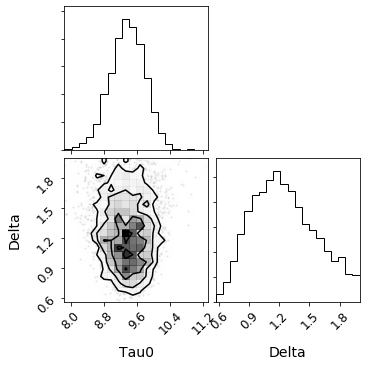

In [19]:
corner(np.array(list(zip(*[nest_hypermodel_samples[name] for name in hypermodel.names]))), 
       labels=hypermodel.names
       #, truths=[10, 1]
      )
plt.show()

As can be seen from the above corner plot, the events have mean duration of around $(9.4\pm 0.4)\,$s with a spread of $(1.2\pm0.3)\,$s. 

Because these are fake events which I generated myself, we can check that these results are consistent with a population I simulated (uncomment the "truths" line in the above cell).

# Section 4.0 Conclusions

?